In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import imageio
import random
import time
from itertools import permutations
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from sklearn.cluster import AgglomerativeClustering
#from sklearn import metrics
#from sklearn.datasets.samples_generator import make_blobs
#from sklearn.preprocessing import StandardScaler
#from skimage import img_as_ubyte

In [2]:
def sig_func(x,y):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        y: The second parameter.

    Returns:
        The return value.
        
    """
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def mutate(x,rate):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        rate: The second parameter.

    Returns:
        The return value.
        
    """
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = 2*np.random.random(1)-1
    return(x)

In [4]:
def intersection(lst1, lst2):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    return list(set(lst1) & set(lst2))

In [5]:
def extract_tribe(cells, cell_weights, n, labels, node_n = 225):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    db = AgglomerativeClustering(n).fit(cell_weights)
    print(db.labels_)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    flags = flags[1:]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    return(next_cells[0], next_weights[0], db)

In [136]:
def slime(x = [],
          y = [],
          start_pop = 200,
          max_age = 100,
          fig_size = [5,5],
          board_size = 128,
          fertile = 6,
          start_hp = 4,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 40,
          willing_wait = 5,
          mode='once'):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.

    """
    
    global sight
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global cell_name
    global killed
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    global max_hp
    global frame_count
    
    total_start_time = time.time()
    frame_count = 1
    max_hp = fertile
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    cell_name = 1
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Build the initial cell list.  Skip this if one from a previous run is submitted.
    # The NN is built around sight/input of 9*9, movement/output of 3*3.
    if(len(x) < 1):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        
        for cell in range(0,start_pop):
            cells[cell,:] = [cell_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          start_hp,
                          1]
            cell_weights[cell,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(cell)
            cell_name += 1          
    else:
        cells = x
        cell_weights = y
        start_pop = len(cells)

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X)
        return (im,)
    
    # Get the relative coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    keep = [0,0]
    
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='magma', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global cell_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        global max_hp
        global frame_count
        
        """Example function with PEP 484 type annotations.

        Args:
            lst1: The first parameter.
            lst2: The second parameter.

        Returns:
            The return value.

        """
        
        # Warning for long frame generation wait time.
        if(last_time > willing_wait):
            print("Taking too long...")
        
        # Initial values.
        start_time = time.time()
        grow_count = 0
        birth_count = 0
        bump_count = 0
        killed_this_round = np.array([], dtype = int)
        
        # Take turns through the cell list for each frame.
        time_tick += 1
        im.set_data(animate.X)
        
        for cell in range(0, len(cells)):
            
            # Input.
            test_in = []
            for perm in np.mod(cells[cell,1:3] + np.unique(keep,axis=0), board_size):
                test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])

            # Output.
            test_out = sig_func(test_in,cell_weights[cell,:].reshape((sight*sight, 3*3)))
            d = test_out.tolist().index(np.random.choice([i for i in test_out if i <= (np.min(test_out)+np.random.rand()*np.max(test_out))]))

            # Rest and recover up to half fertile health.
            if(d==4):
                if(cells[cell,3] < max_hp/2):
                    cells[cell,3] += 1
                    grow_count += 1
                    if(log == True):
                        print("{0} grew to size {1}.".format(cells[cell,0], cells[cell,3]))

                # Handle birth/splitting, don't clear.
                if(cells[cell,3] >= max_hp):
                    
                    # Get the relative coodinates for possible baby locations.
                    L = [0, 0, 1, 1, -1, -1]
                    keep2 = [0,0]

                    for comb in permutations(L, r=2):
                        keep2 = np.vstack((keep2, comb))

                    potential = []
                    for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                        potential = np.append(potential, X[int(perm[0]), int(perm[1])])
                    
                    # Check if location for baby is clear
                    clear = []
                    for i in potential:
                        if(i == 0):
                            clear = np.append(clear,i)
                    
                    # Cell division process, only divide if there is a vacant destination to choose from.
                    if(len(clear) > 0):
                        d = np.random.choice(range(0,len(clear)))
                        # Give new coordinate and fill it in.
                        destination = np.mod(np.add(cells[int(cell),1:3], new_coord[d]), board_size)
                        
                        # Half parent hp.
                        divided_hp = np.floor(cells[cell,3]/2)
                        cells[cell,3] = divided_hp

                        # Give the baby attributes.
                        baby_name = cell_name
                        G.add_node(baby_name)
                        G.add_edge(cell_name, baby_name)
                        cell_name += 1

                        a = [baby_name,
                             int(destination[0]),
                             int(destination[1]),
                             divided_hp,
                             1]
                        
                        # Mutate the baby's NN
                        b = mutate(cell_weights[cell,:], mutation_rate)
                        cells = np.vstack((cells, a)) 
                        cell_weights = np.vstack((cell_weights, b))
                        X[int(destination[0]), int(destination[1])] = abs(sum(b))

                        birth_count += 1
                        if(log == True):
                            print("{0} underwent mitosis.  Gave birth to {1}.".format(cells[cell,0], baby_name))

            # Movement logic.
            else:
                # If it is clear to move.
                destination = np.mod(np.add(cells[cell,1:3], new_coord[d]), board_size)
                
                if(X[int(destination[0]), int(destination[1])] == 0):
                    # Clear where it was since it is not splitting.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0         
                    # Give new coordinate and fill it in.
                    cells[cell,1:3] = destination
                    X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[cell,:]))
                    
                else:
                    # It has an altercation    
                    x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                    y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                    z = intersection(x,y)
                    
                    # Make sure there is no ambiguity
                    if(len(z) == 1):
                        # The outcome is determined by hit points, age and who is initiating.
                        # The following ratio incorperates ages of predator and prey
                        rat = np.log(cells[z,4]/cells[cell,4])/np.e
                        if(cells[cell,3] > cells[z,3]):
                            cells[cell,3] += np.round(3+rat)
                            cells[z,3] -= np.round(3+rat)
                        if(cells[cell,3] == cells[z,3]):
                            cells[cell,3] += np.round(1+rat)
                            cells[z,3] -= np.round(1+rat)
                        if(cells[cell,3] < cells[z,3]):
                            cells[cell,3] -= np.round(2-rat)
                            cells[z,3] += np.round(2-rat)  
                        bump_count += 1
                        if(log == True):
                            print("{0} was injured to size {1}!".format(cells[cell,0], cells[cell,3]))
                            
                        try:
                            # Handle cell death.
                            if(cells[cell,3] < 1):
                                # Clear where the attacker was and add to the death list.
                                last_spot = cells[cell,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                                if(log == True):
                                    print("{0} died!.".format(cells[cell,0]))

                            if(cells[z,3] < 1):
                                # Clear where the victim was and add to the death list.
                                last_spot = cells[z,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[z,0]))
                                if(log == True):
                                    print("{0} died!.".format(cells[z,0]))
                        except:
                            pass
        
        # Kill the elderly        
        for i in range(0,len(cells)):
            if(cells[int(i),4] > max_age):
                # Blur max age a bit.
                if(np.random.random() < (cells[int(i),4]-max_age)/max_age):      
                    # Clear where it was and add to the death list.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0
                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                    if(log == True):
                        print("{0} died of old age!.".format(cells[cell,0]))
        
        # Finally handle the death list and delete cells
        for i in np.unique(killed_this_round):
            j = list(cells[:,0]).index((i))
            cells = np.delete(cells, (j), axis=0)
            cell_weights = np.delete(cell_weights, (j), axis=0)
        
        # Dynamic population control
        run_pop = len(cells)   
        if(np.random.random() < -np.log(run_pop/(start_pop)/np.e)):
            if(max_hp > 3):
                    max_hp -= 1
                    print("We're going extinct, make babies!  Breeding requirements decreased to {0}.".format(max_hp))

        if(np.random.random() < np.log(run_pop/(start_pop)/np.e)):
                max_hp += 1
                print("Too crowded, stop having kids!  Breeding requirements increased to {0}.".format(max_hp))
        
        mean_var = np.mean(np.var(cell_weights,axis = 0))
        
        # Tick everyone's age
        cells[:,4] = np.add(cells[:,4],1)
        # Capture array for gif
        for_gif = np.concatenate((for_gif, X))
        # Capture death statistics
        death_count = len(np.unique(killed_this_round))
        # Current frame summary
        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count, run_pop, mean_var])
        # Append to run summary
        trends = np.vstack((trends, current))
        # Get the current frame run time to check next frame
        last_time = time.time() - start_time
        # Log every 10 frames to monitor full run time and check frame generation time.
        if(np.mod(frame_count,10) == 0):
            print("Frame {0} took {1} seconds.".format(frame_count,round(last_time,1)))
        frame_count += 1
    
        return (im,)
    
    # Handles the browser animation viewer.
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make a little animated gif
    images = []
    for i in range(0,(frames+1)):
        converted = np.reshape(for_gif,(len(trends),board_size,board_size))[int(i),:,:]
        imageio.imwrite('slime.gif', converted)
        images.append(imageio.imread('slime.gif'))
    imageio.mimsave('slime.gif', images)
    
    # Total run time
    total_last_time = time.time() - total_start_time
    print("Total Run Time:  {0} seconds.".format(round(total_last_time,1)))
    
    return (html_result, cells, cell_weights, G, trends[1:,:], for_gif)

In [137]:
gr, c, cw, g, t, a = slime(start_pop=100, board_size=128, frames=100)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.4 seconds.
Frame 20 took 0.3 seconds.
Frame 30 took 0.4 seconds.
Frame 40 took 0.4 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 4.
Frame 50 took 0.6 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 5.
Frame 60 took 0.6 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 6.
Frame 70 took 0.6 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 7.
Too crowded, stop having kids!  Breeding requirements increased to 8.
Too crowded, stop having kids!  Breeding requirements increased to 9.
Frame 80 took 0.6 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 10.
Too crowded, stop having kids!  Breeding requirements increased to 11.
Too

Frame 100 took 0.6 seconds.


Total Run Time:  56.3 seconds.



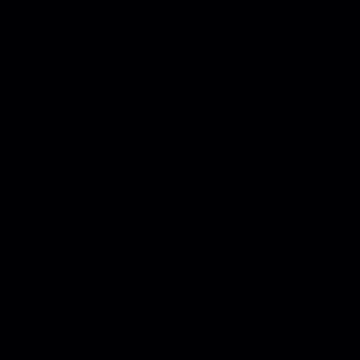
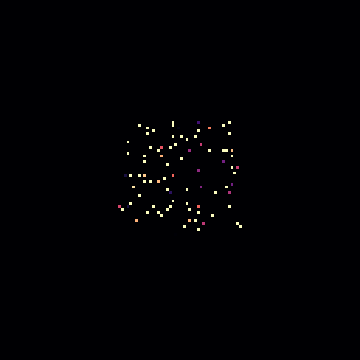
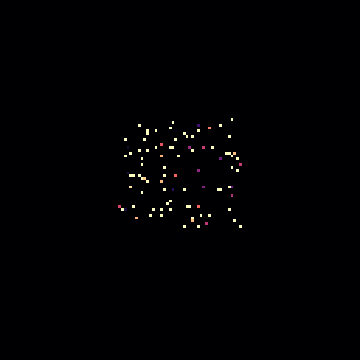
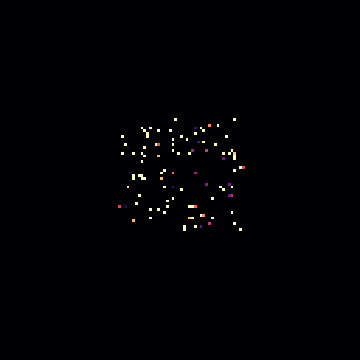
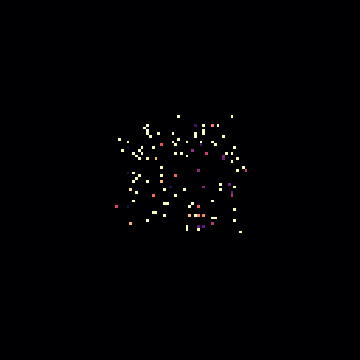
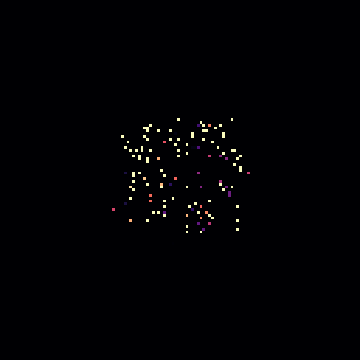
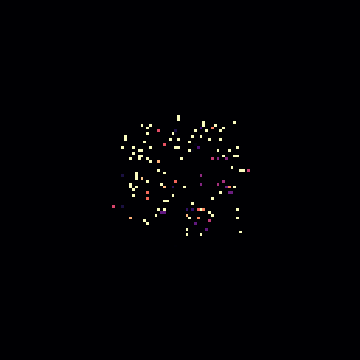
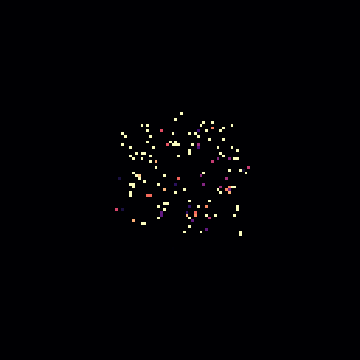
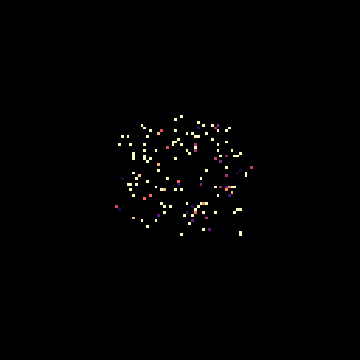
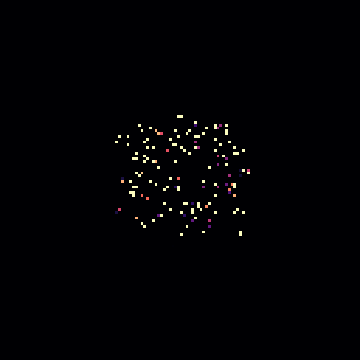
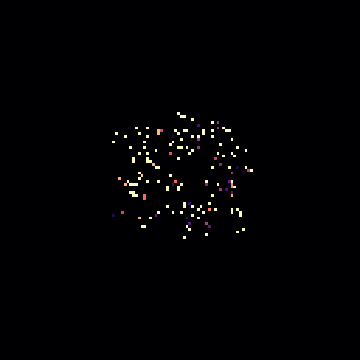
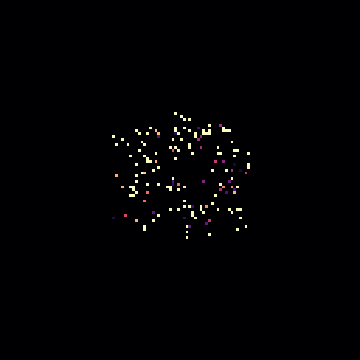
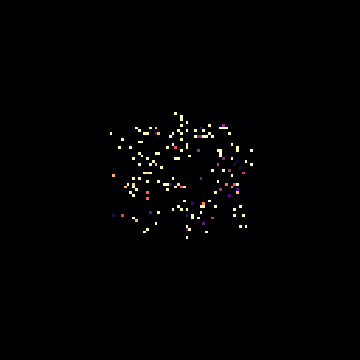
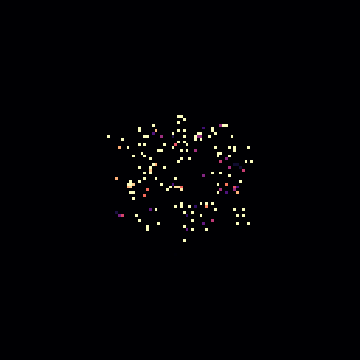
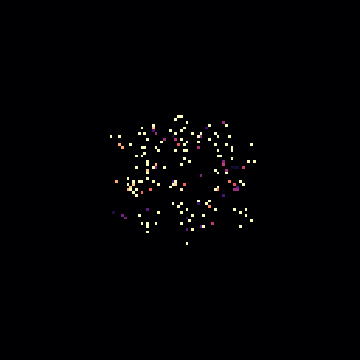
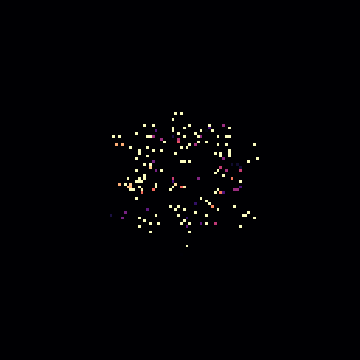
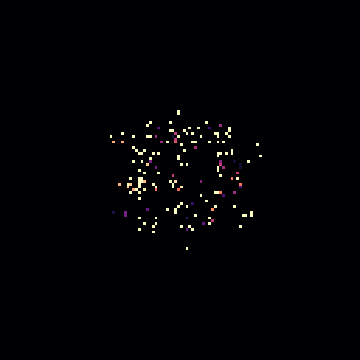
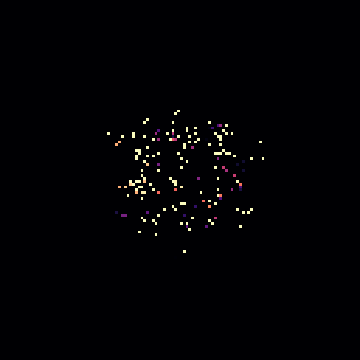
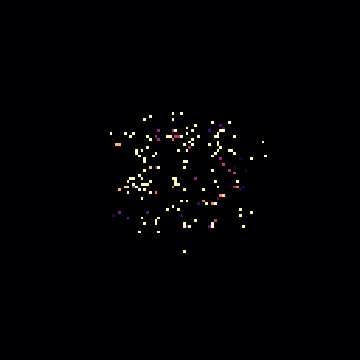
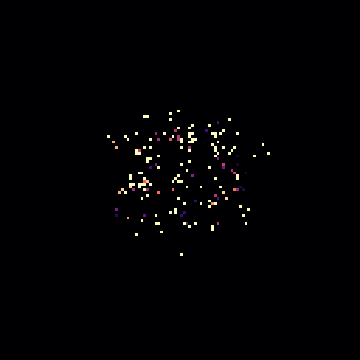
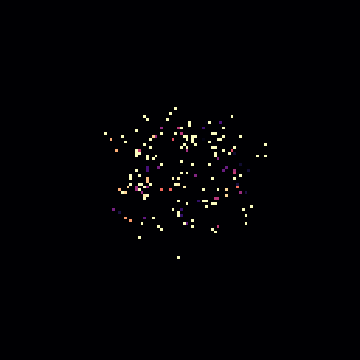
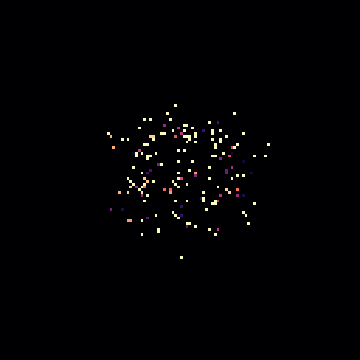
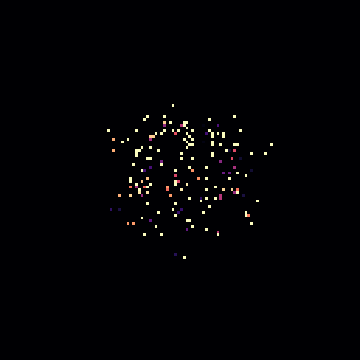
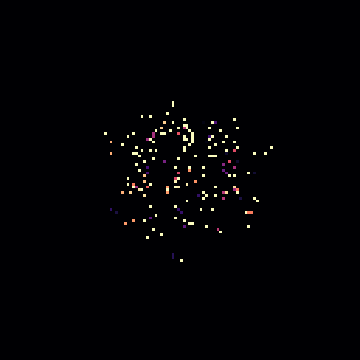
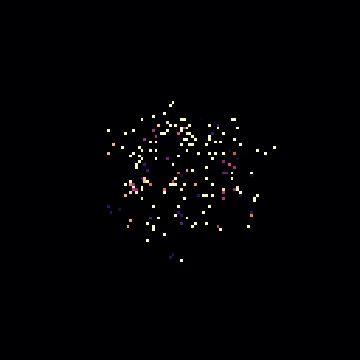
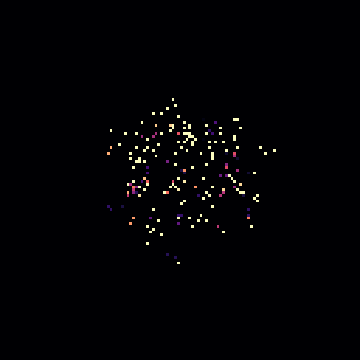
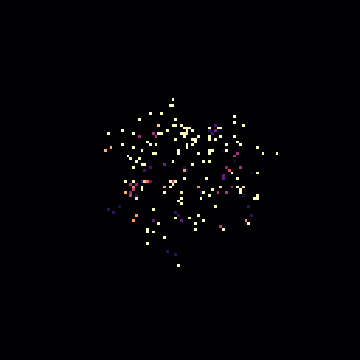
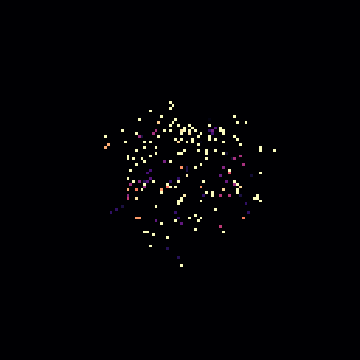
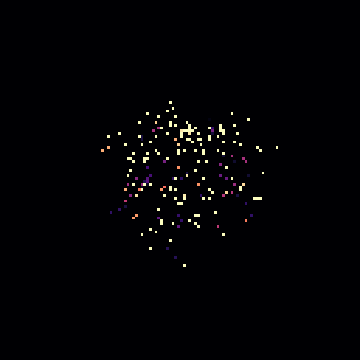
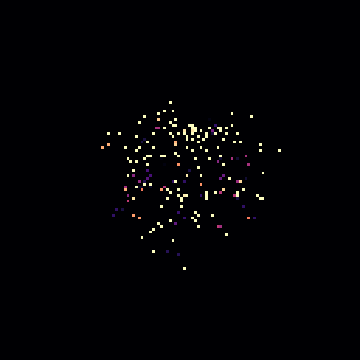
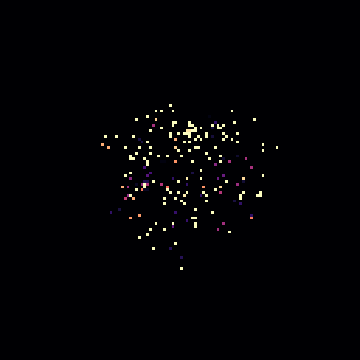
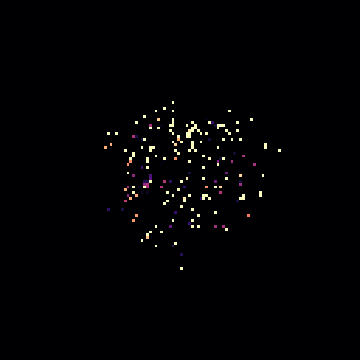
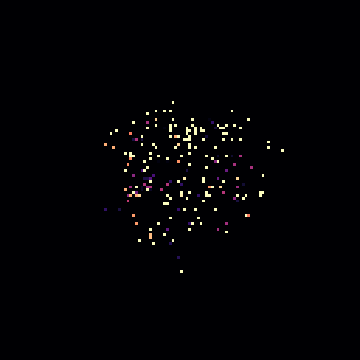
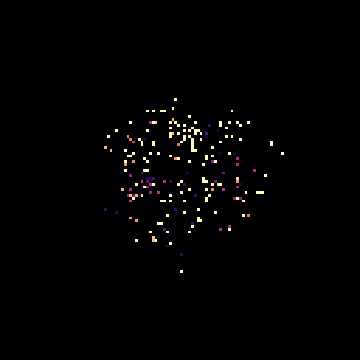
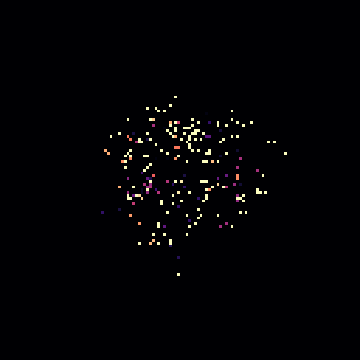
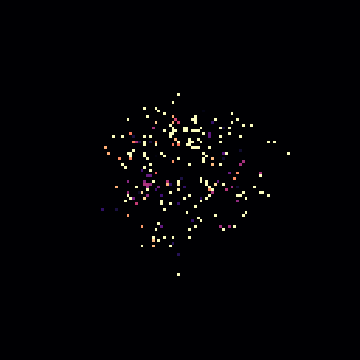
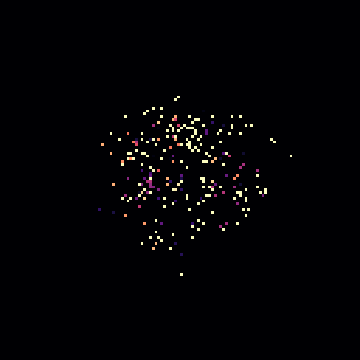
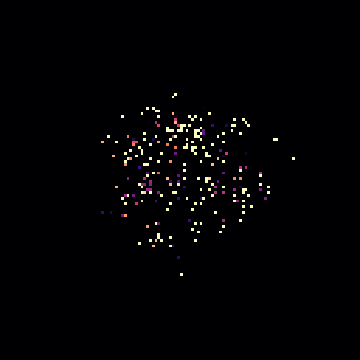
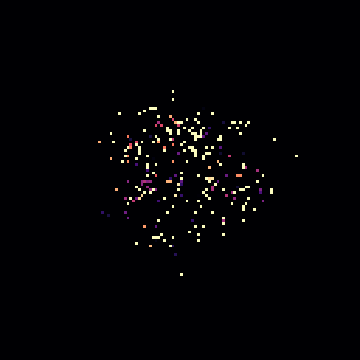
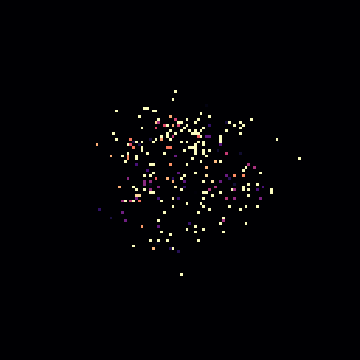
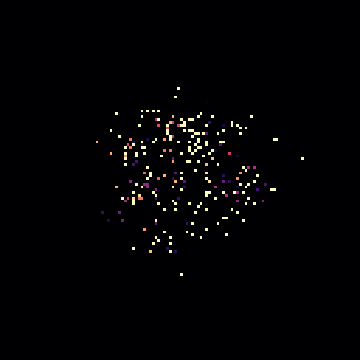
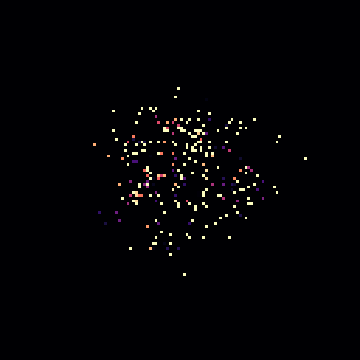
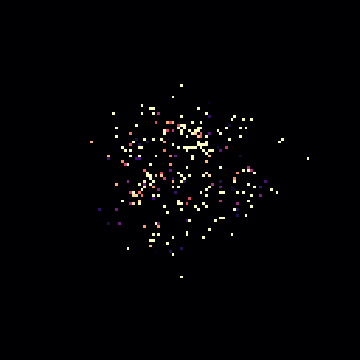
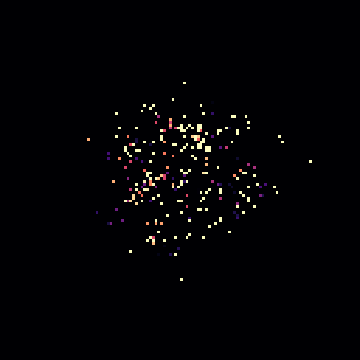
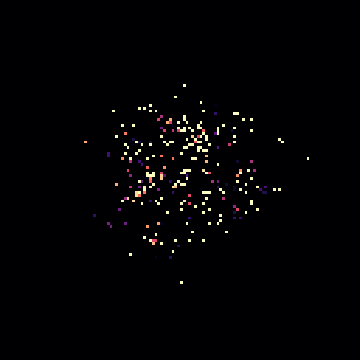
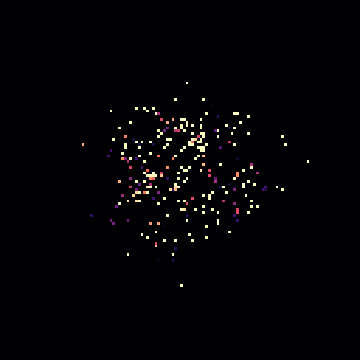
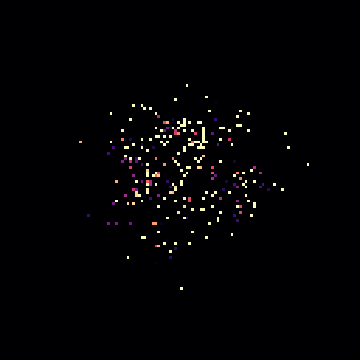
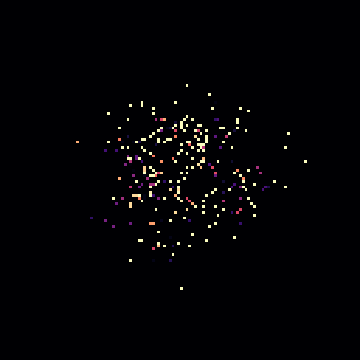
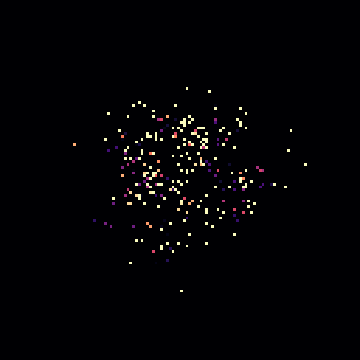
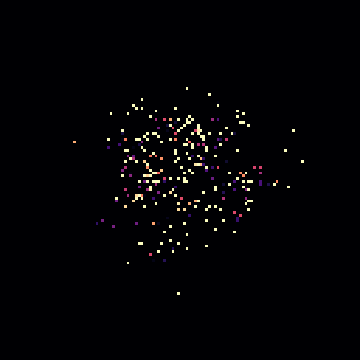
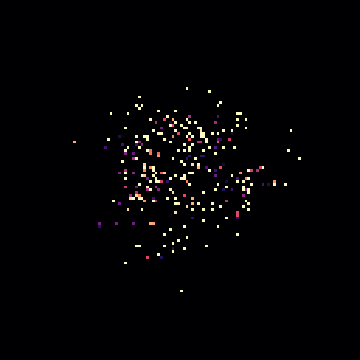
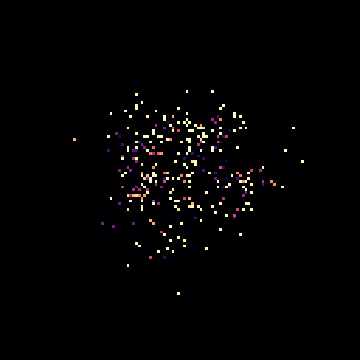
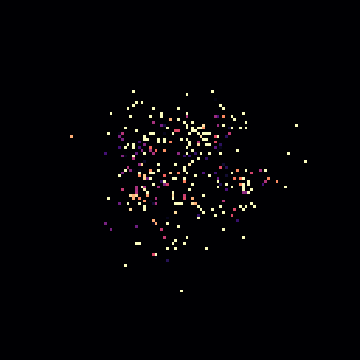
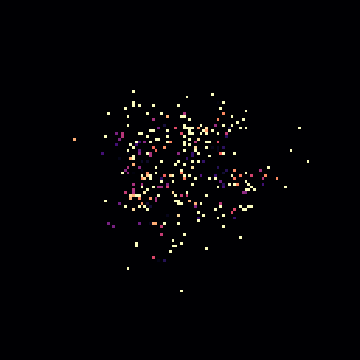
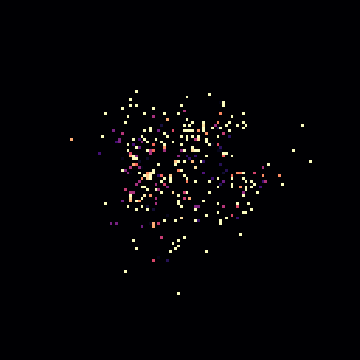
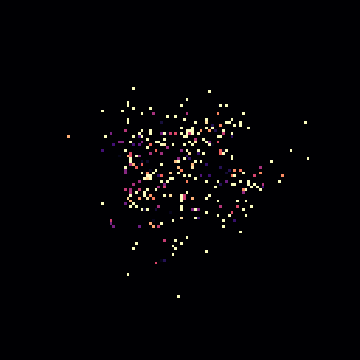
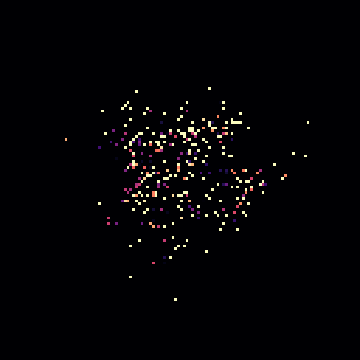
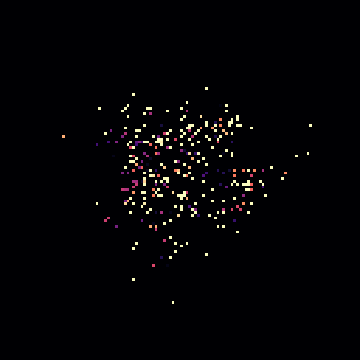
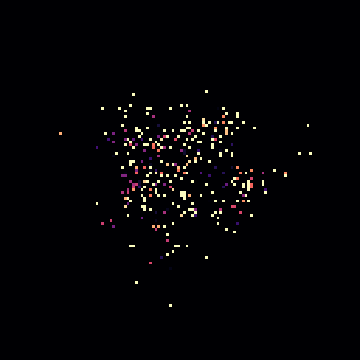
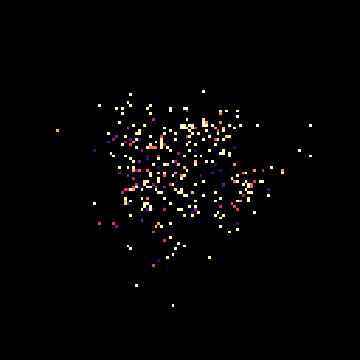
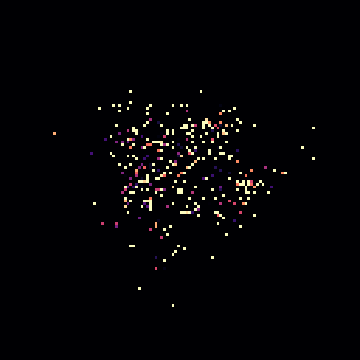
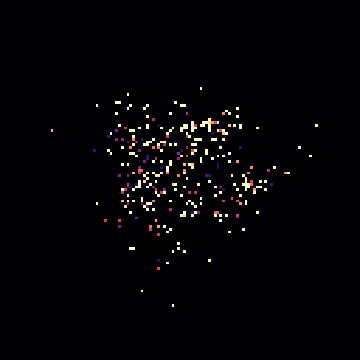
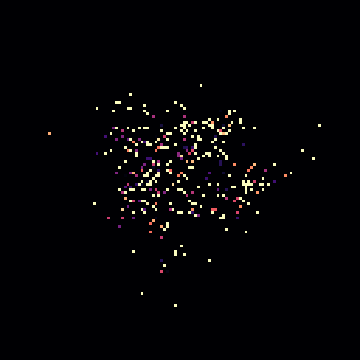
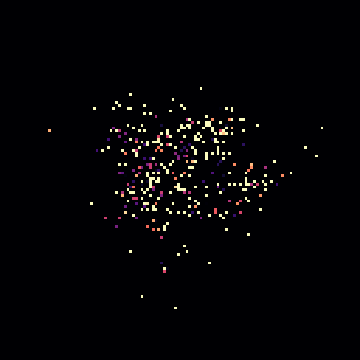
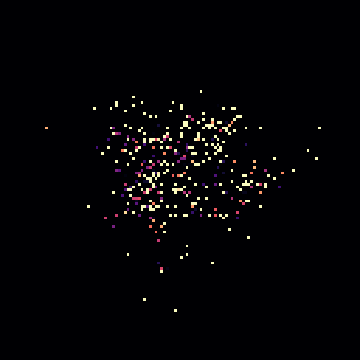
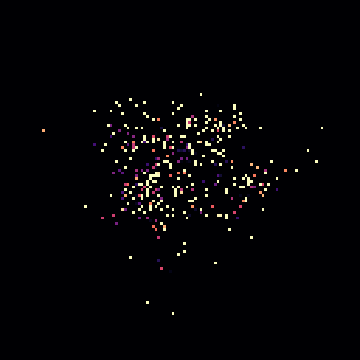
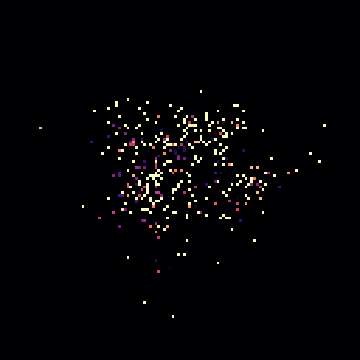
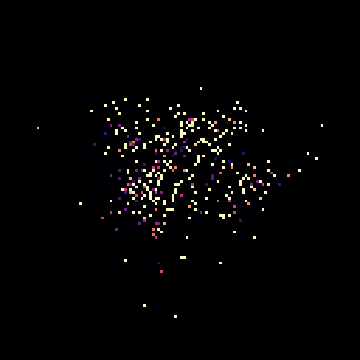
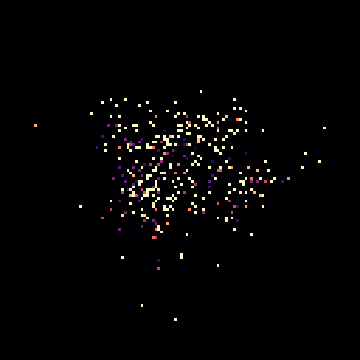
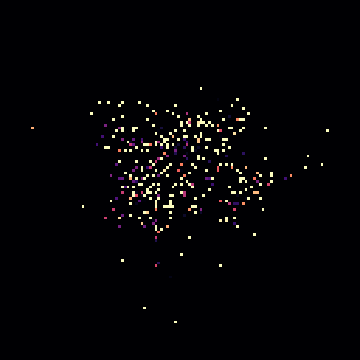
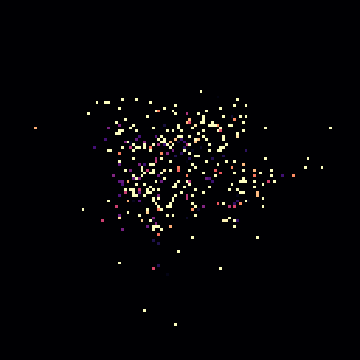
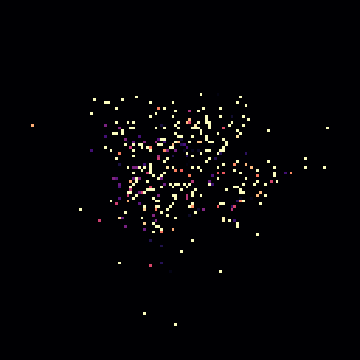
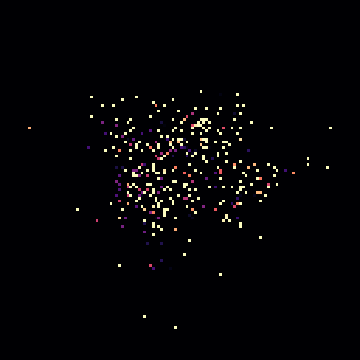
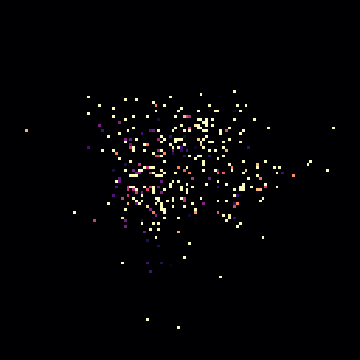
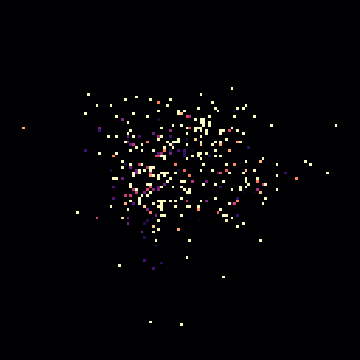
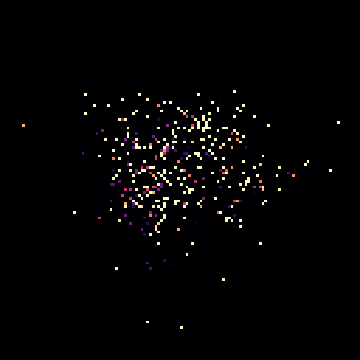
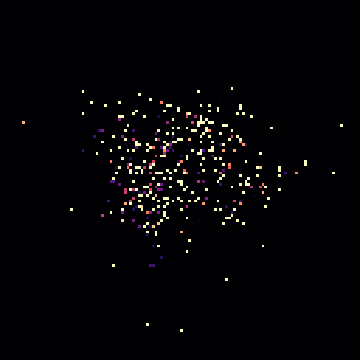
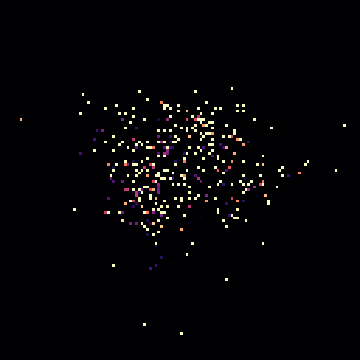
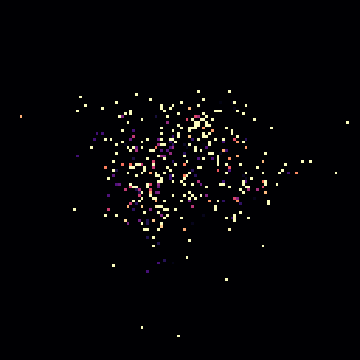
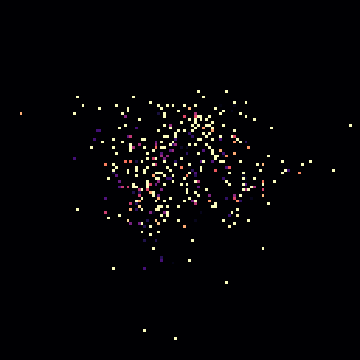
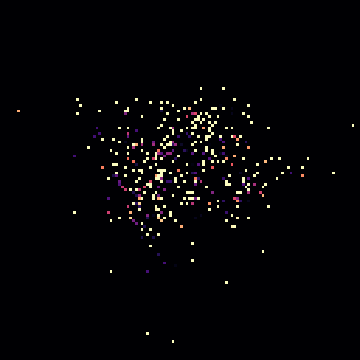
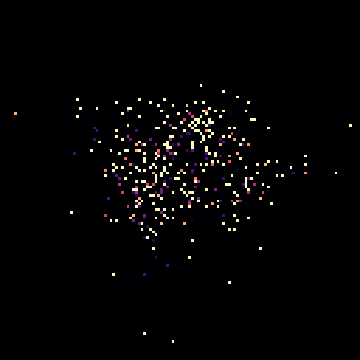
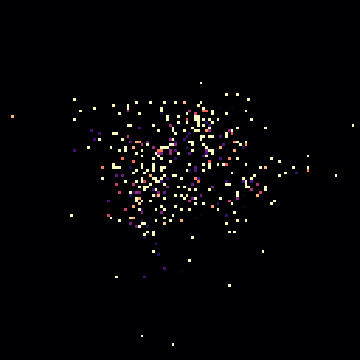
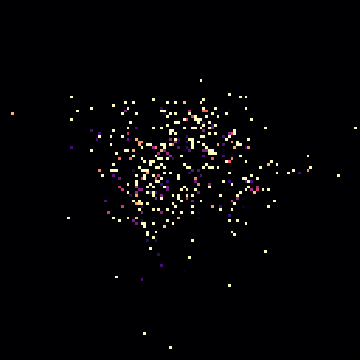
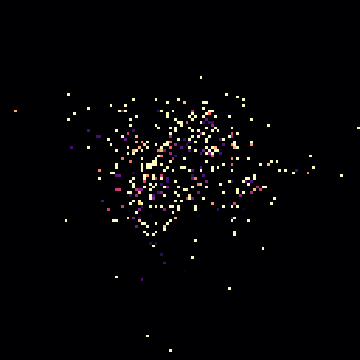
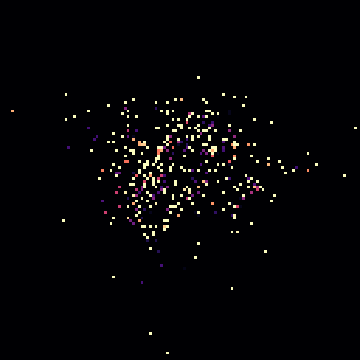
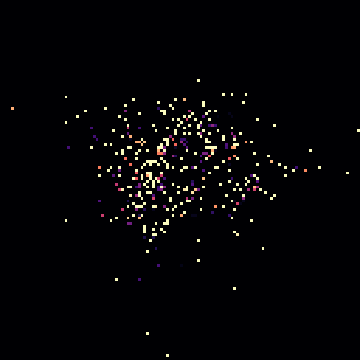
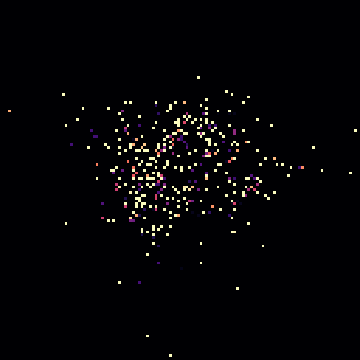
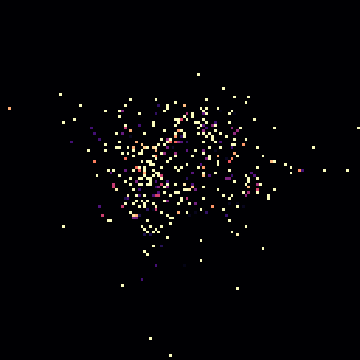
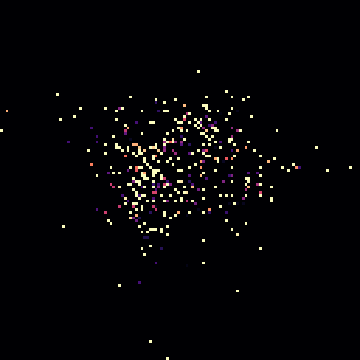
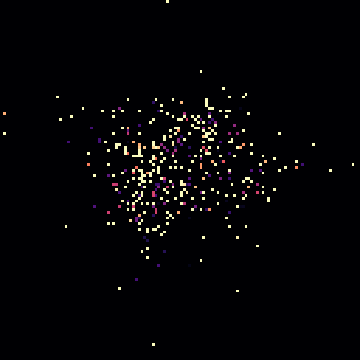
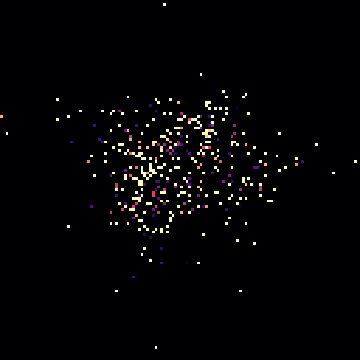
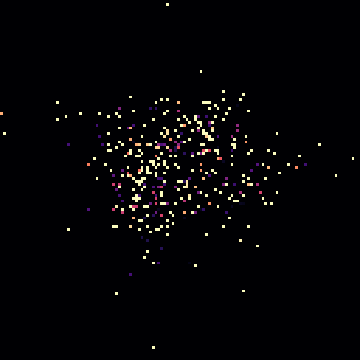
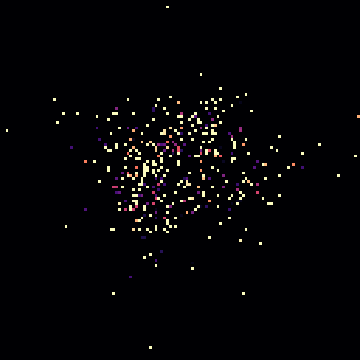
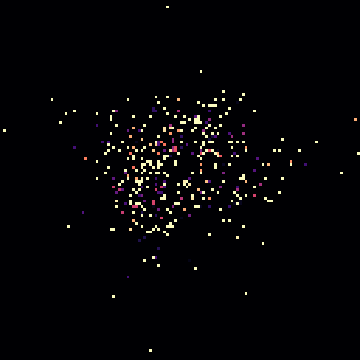
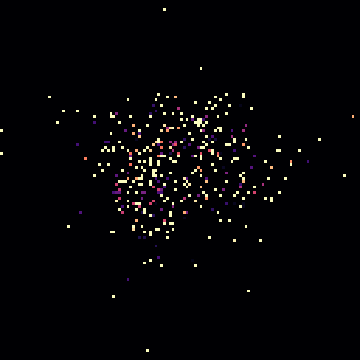
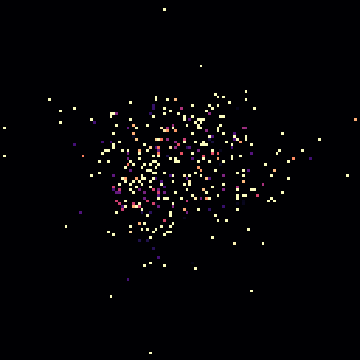
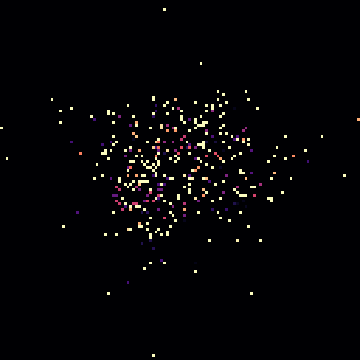
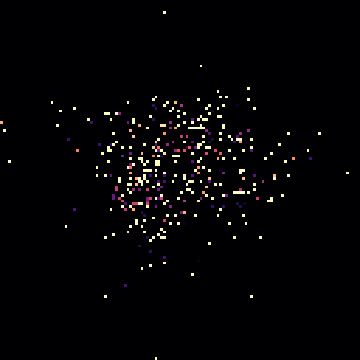
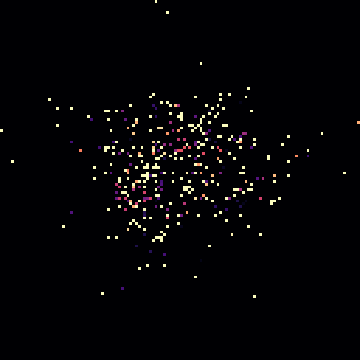

In [138]:
gr

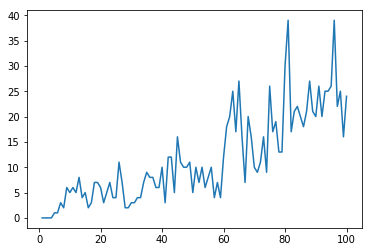

In [139]:
# Growth
plt.plot(t[:,0],t[:,1])

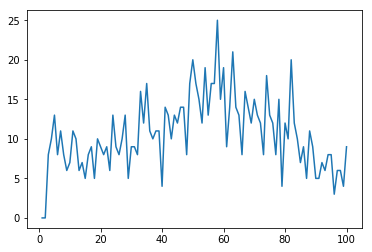

In [140]:
# Birth
plt.plot(t[:,0],t[:,2])

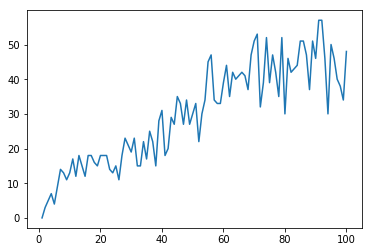

In [141]:
# Injuries
plt.plot(t[:,0],t[:,3])

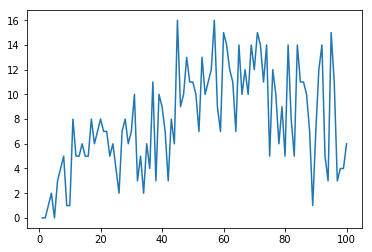

In [142]:
# Deaths
plt.plot(t[:,0],t[:,4])

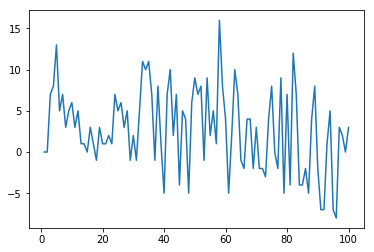

In [143]:
# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])

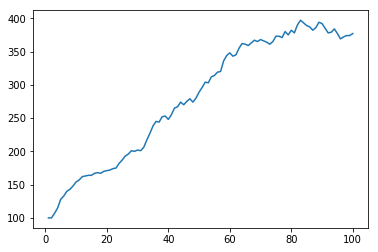

In [144]:
# Population
plt.plot(t[:,0],t[:,5])

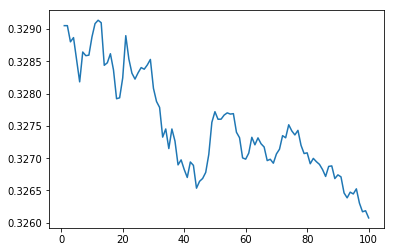

In [145]:
# Mean Variance
plt.plot(t[:,0],t[:,6])

In [15]:
# Summary
t

array([[  1,   0,   0,   4,   0, 100],
       [  2,   0,   1,   1,   0, 101],
       [  3,   0,  10,   1,   0, 111],
       [  4,   0,   8,   6,   2, 117],
       [  5,   0,   9,   5,   1, 125],
       [  6,   1,   5,   9,   2, 128],
       [  7,   1,  10,   8,   2, 136],
       [  8,   5,   4,  13,   4, 136],
       [  9,   1,   3,  14,   3, 136],
       [ 10,   3,   5,   6,   1, 140],
       [ 11,   2,   8,  11,   3, 145],
       [ 12,   1,  10,  12,   4, 151],
       [ 13,   3,   6,  11,   2, 155],
       [ 14,   6,   7,  14,   7, 155],
       [ 15,   2,   4,   9,   4, 155],
       [ 16,   7,  11,   9,   2, 164],
       [ 17,   4,   6,  10,   3, 167],
       [ 18,   3,   6,  12,   4, 169],
       [ 19,   3,   9,  10,   5, 173],
       [ 20,   3,  11,  19,   5, 179],
       [ 21,   4,   5,  14,   7, 177],
       [ 22,   6,   5,  12,   4, 178],
       [ 23,   2,   4,  17,   5, 177],
       [ 24,   3,   6,  11,   1, 182],
       [ 25,   8,   6,  12,   3, 185],
       [ 26,   4,   8,  1

In [16]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 883\nNumber of edges: 783\nAverage degree:   1.7735'

In [42]:
c2, cw2, db = extract_tribe(c2, cw2, 5, [0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 0 2 3 0 0 0 0 1 0 0
 0 2 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 0 1 0 0 0 0 1 2 0 1
 4 0 2 0 2 0 0 0 0 0 1 0 0 0 0 0 3 0 1 0 0 1 2 2 1 0 1 1 0 0 0 0 0 2 0 0 4
 0 0 4 0 2 0 3 0 0 0 0 1 1 4 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 3 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 2 1 0 4 0 0 0 0 0 0 0 4 0 4 3
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 1 0 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 4 3 0 0 0 0 4 0 4]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 66, 67, 68, 69, 72, 75, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 99, 102, 103, 104, 105, 106, 108, 109, 111, 112, 114, 116, 118, 119, 120, 121, 125, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 1

In [43]:
gr2, c3, cw3, g2, t2, a2 = slime(c2, cw2, board_size=128, frames=1200)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.5 seconds.
Frame 20 took 0.6 seconds.
Frame 30 took 0.7 seconds.
Frame 40 took 0.9 seconds.
Frame 50 took 0.9 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 4.
Too crowded, stop having kids!  Breeding requirements increased to 5.
Too crowded, stop having kids!  Breeding requirements increased to 6.
Frame 60 took 1.0 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 7.
Frame 70 took 1.0 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 8.
Too crowded, stop having kids!  Breeding requirements increased to 9.
Too crowded, stop having kids!  Breeding requirements increased to 10.
Frame 80 took 1.0 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 11.
Too

Frame 1200 took 0.9 seconds.


Total Run Time:  6587.2 seconds.



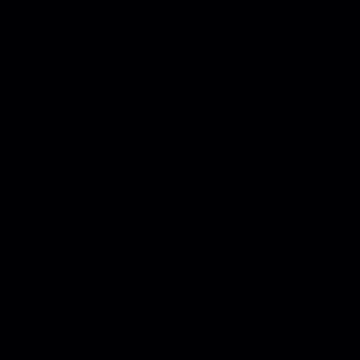
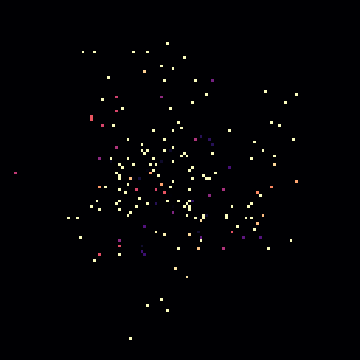
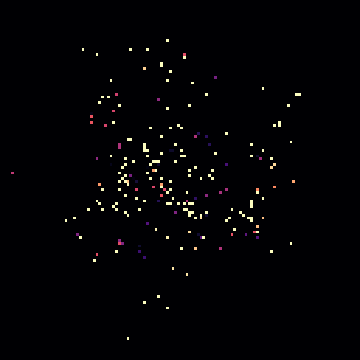
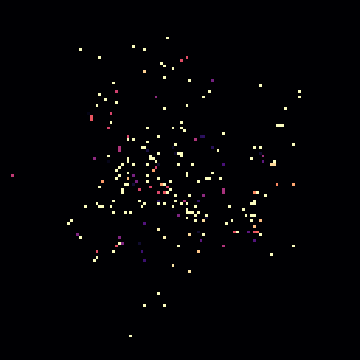
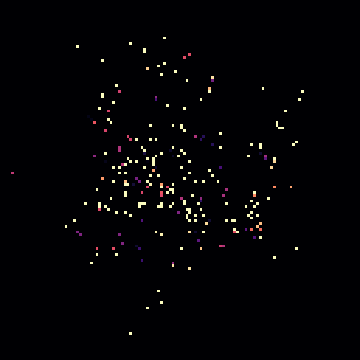
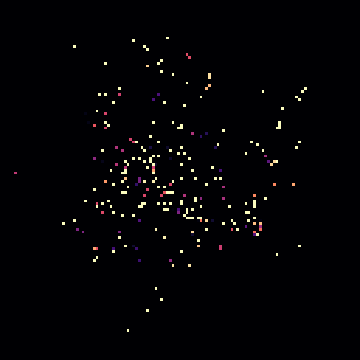
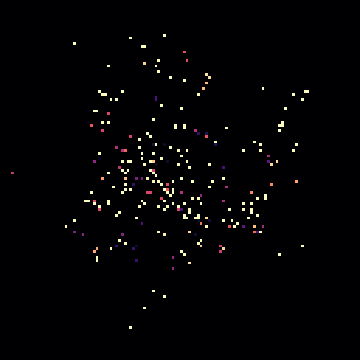
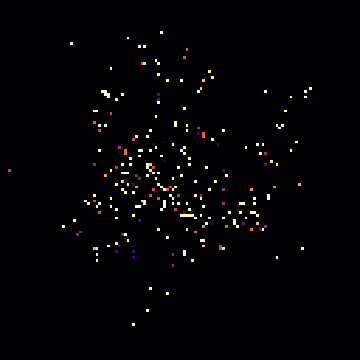
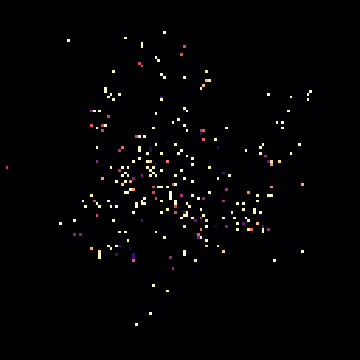
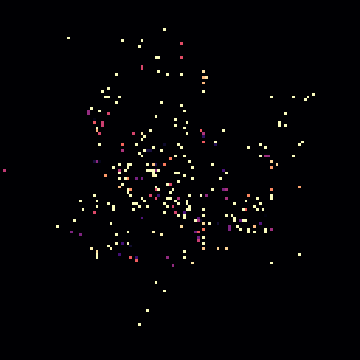
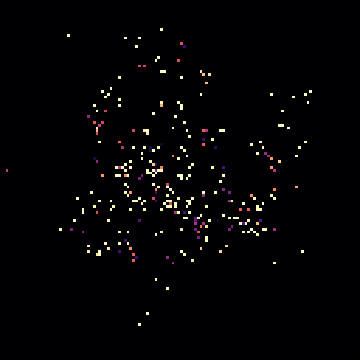
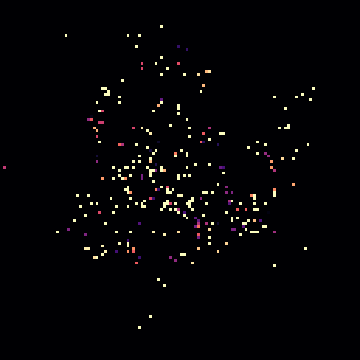
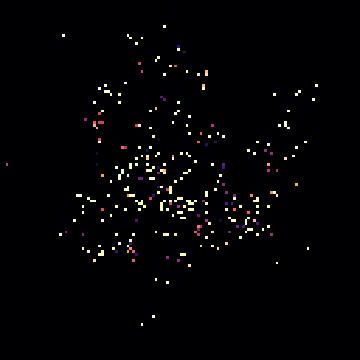
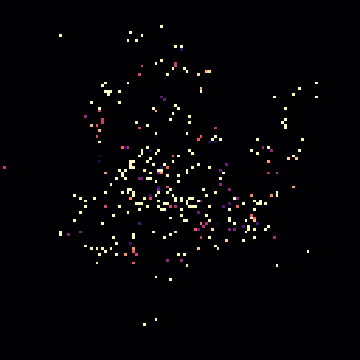
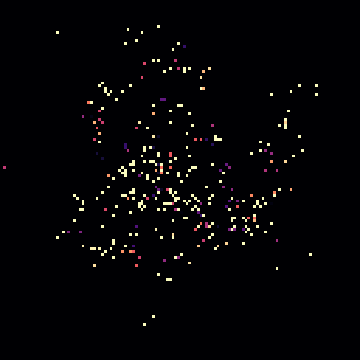
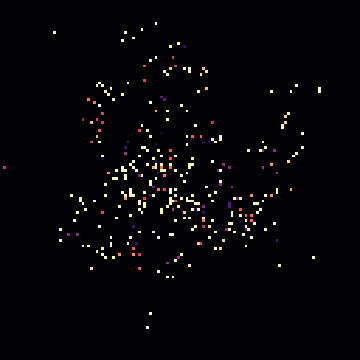
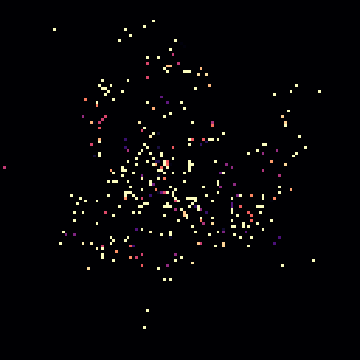
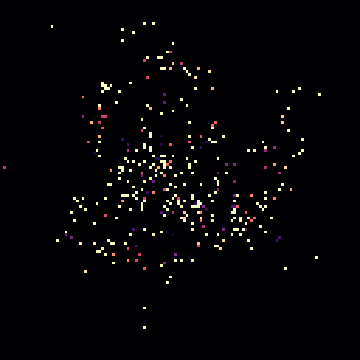
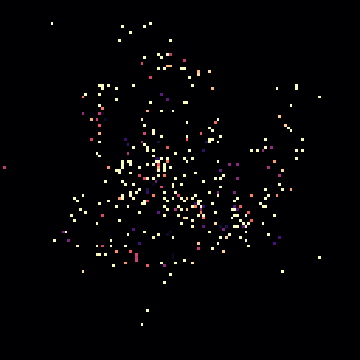
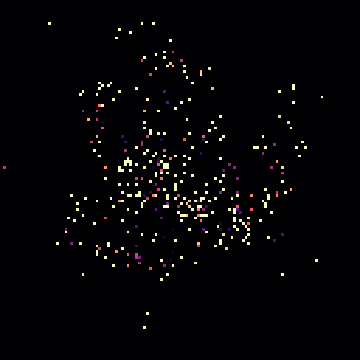
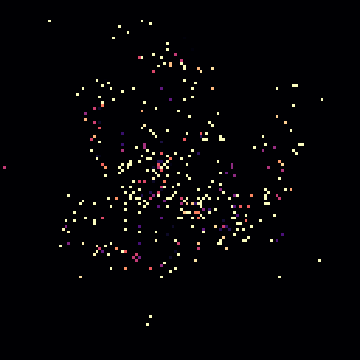
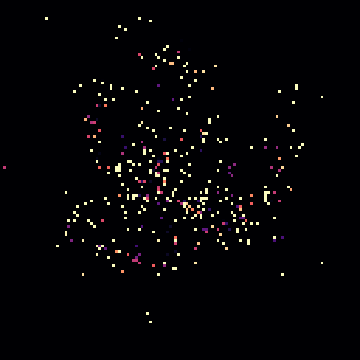
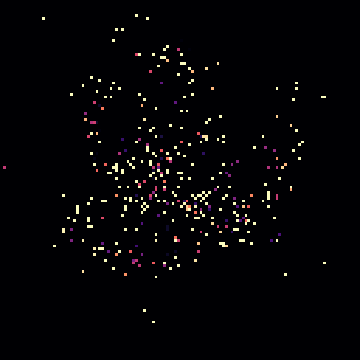
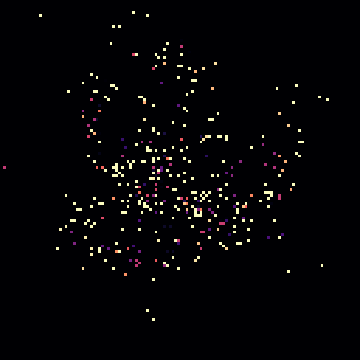
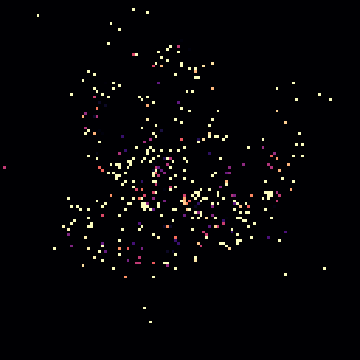
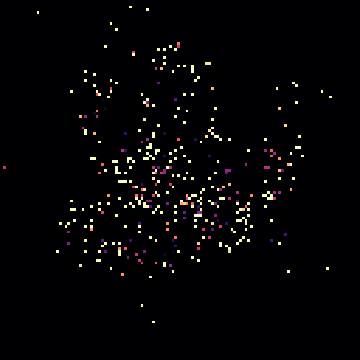
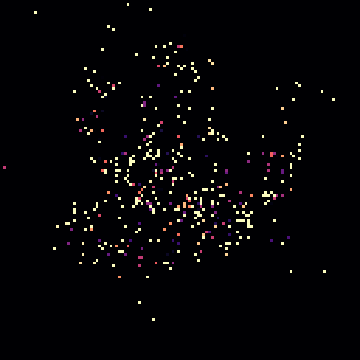
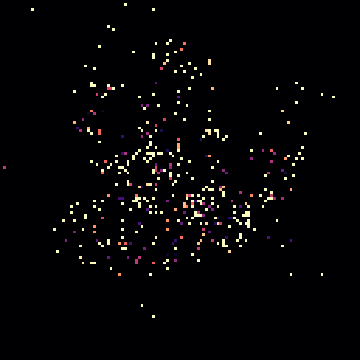
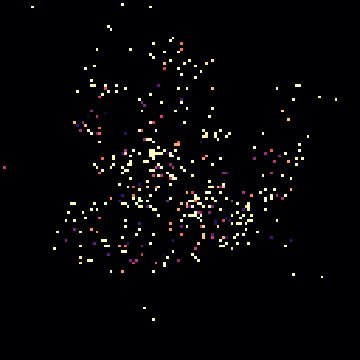
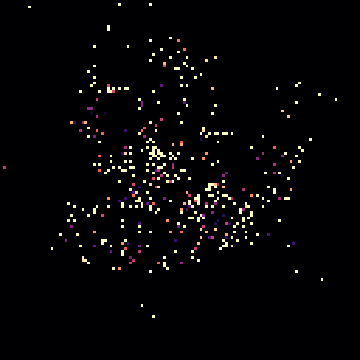
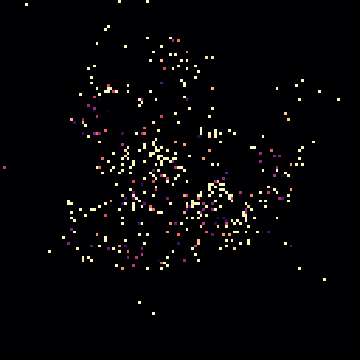
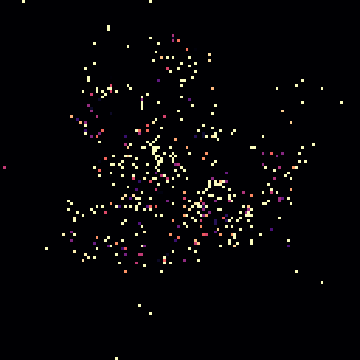
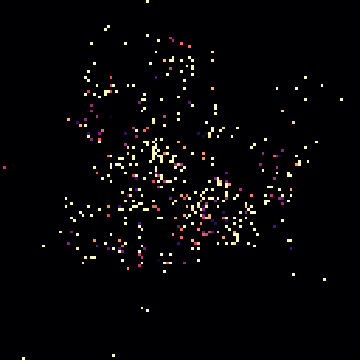
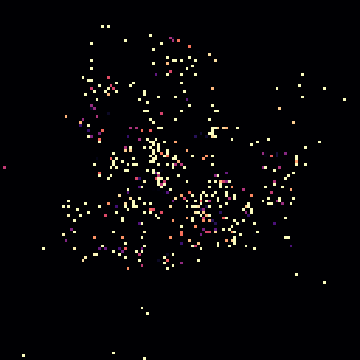
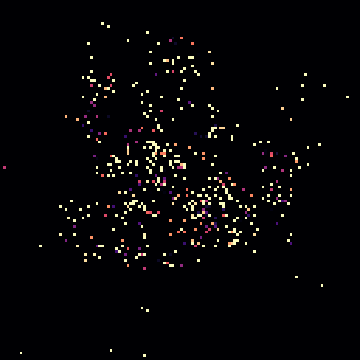
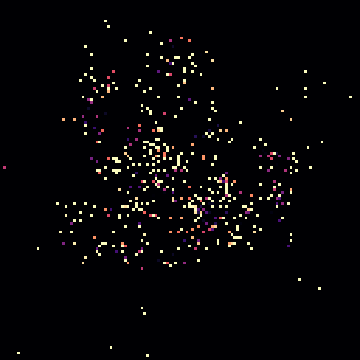
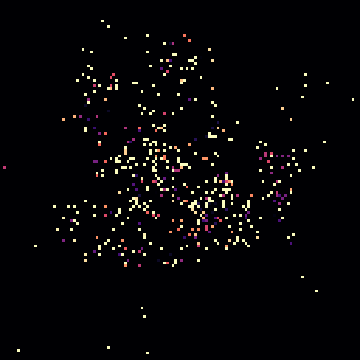
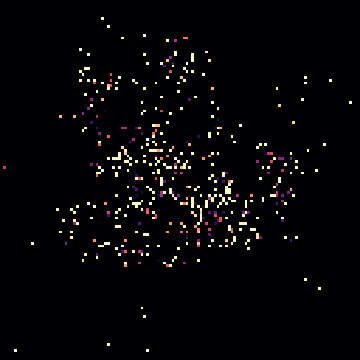
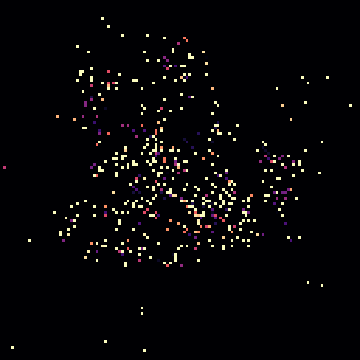
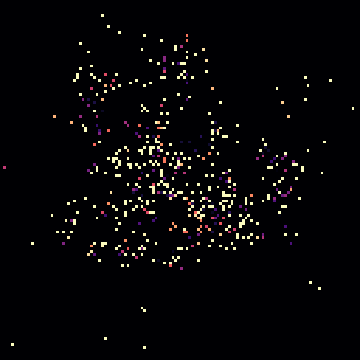
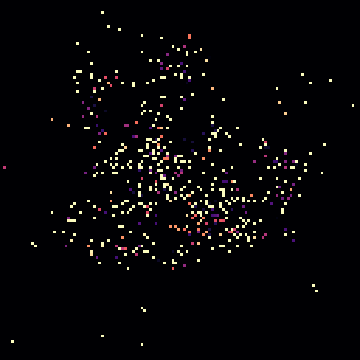
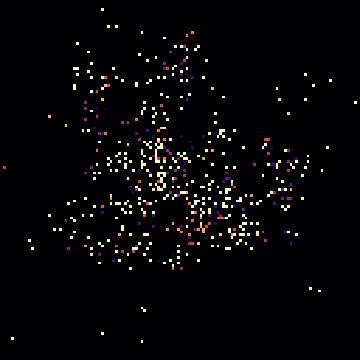
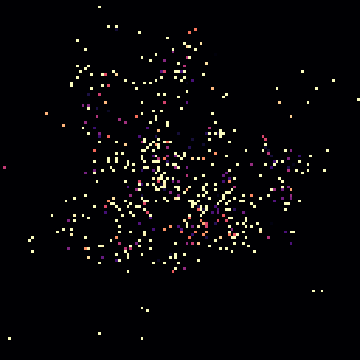
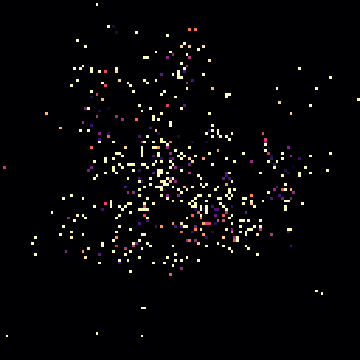
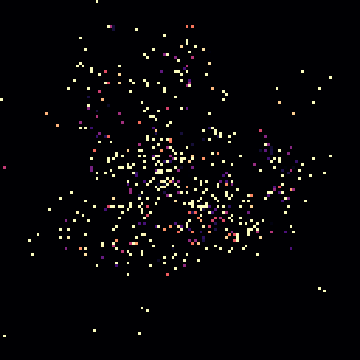
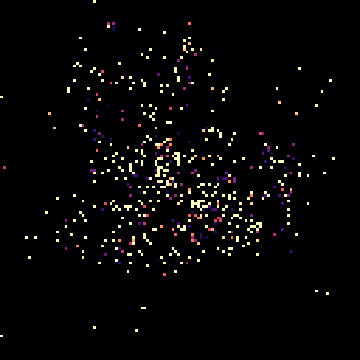
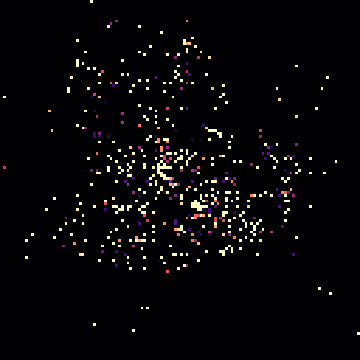
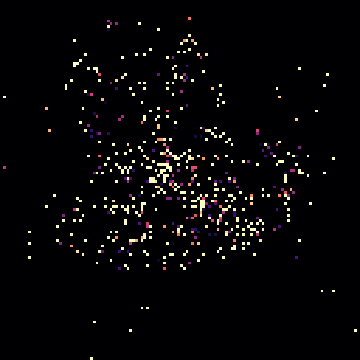
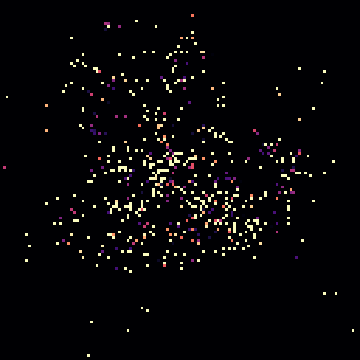
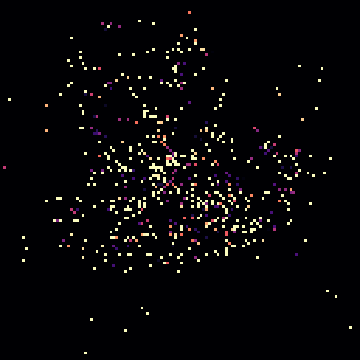
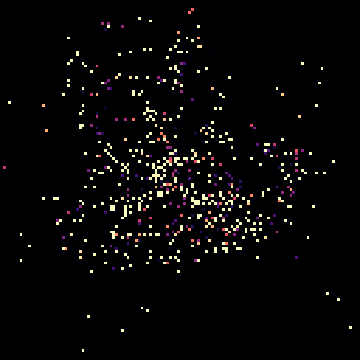
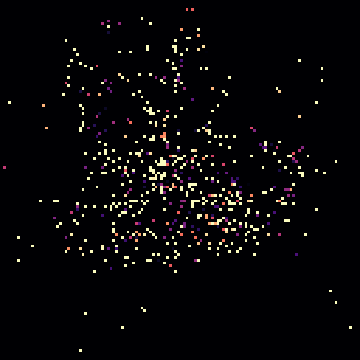
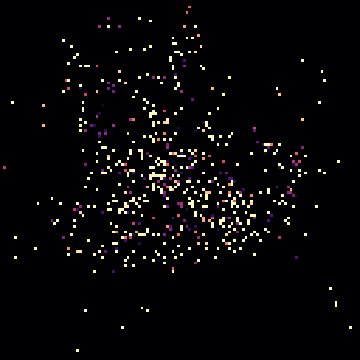
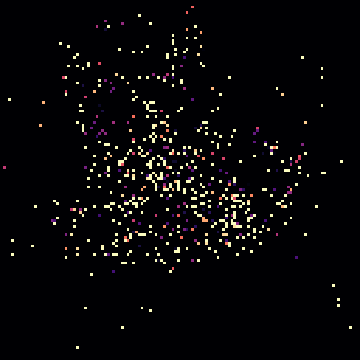
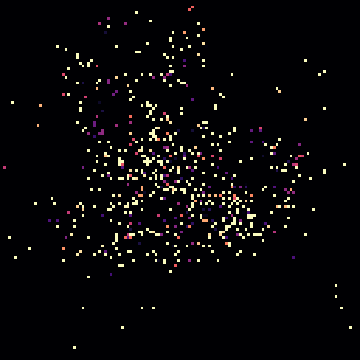
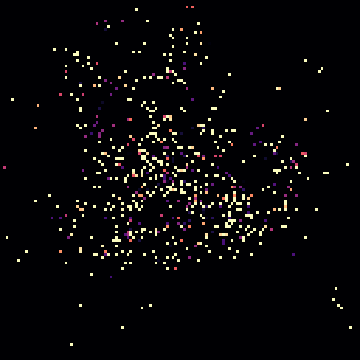
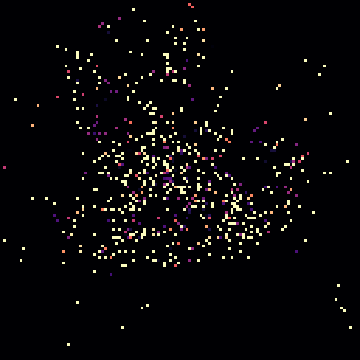
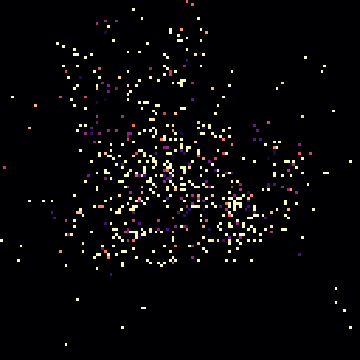
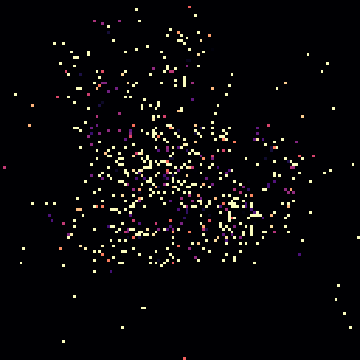
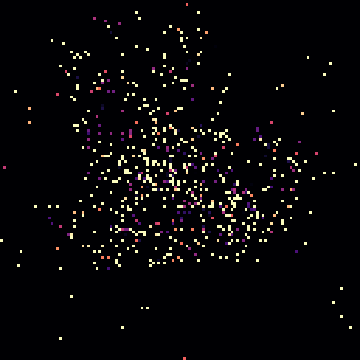
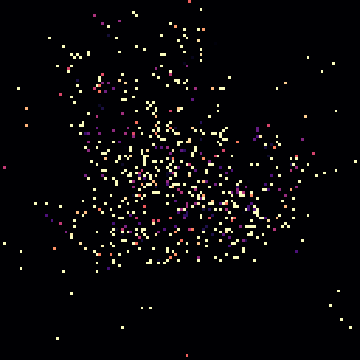
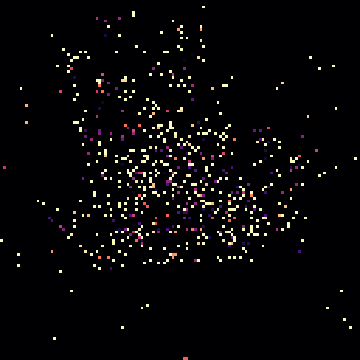
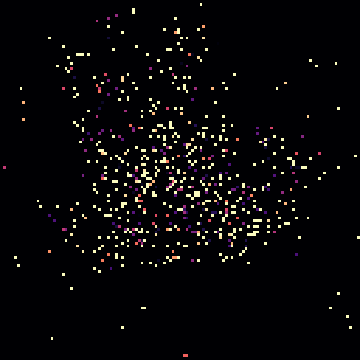
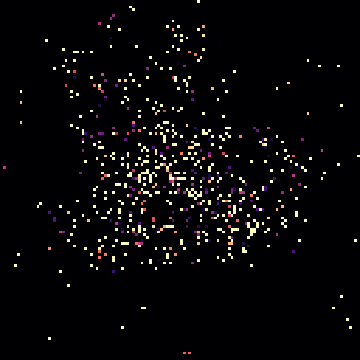
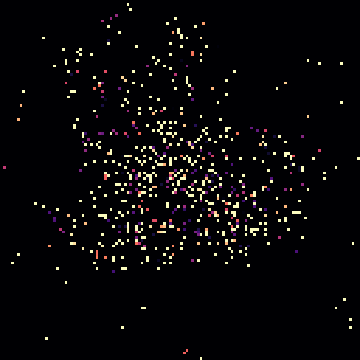
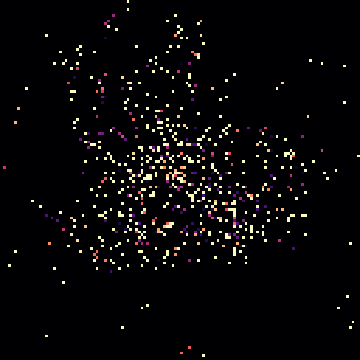
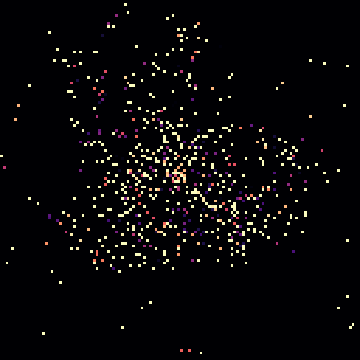
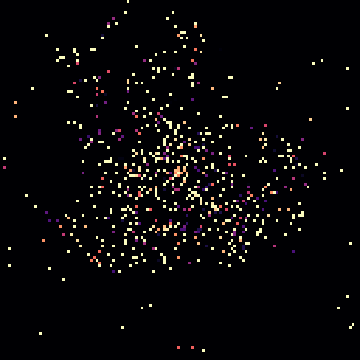
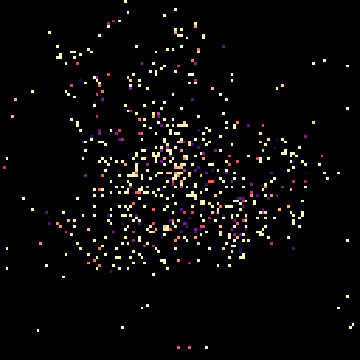
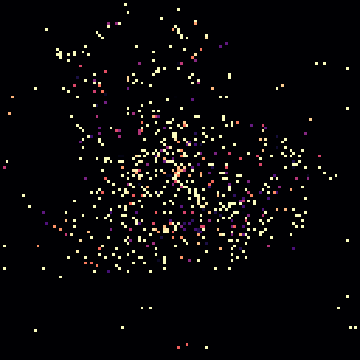
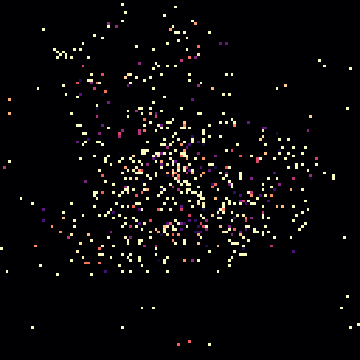
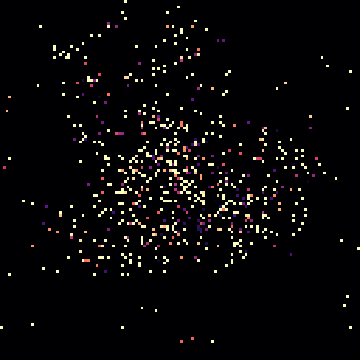
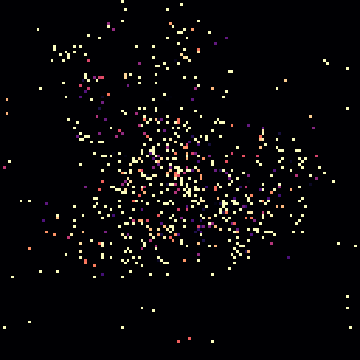
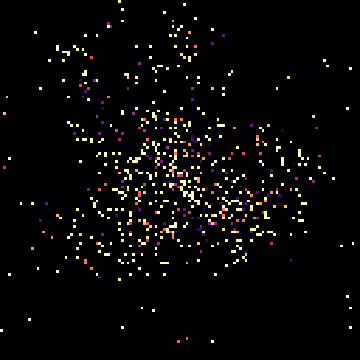
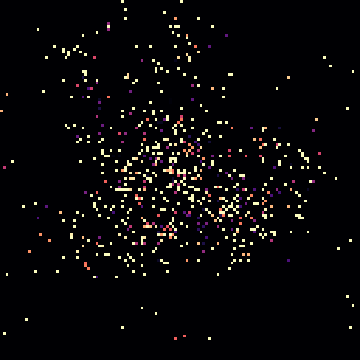
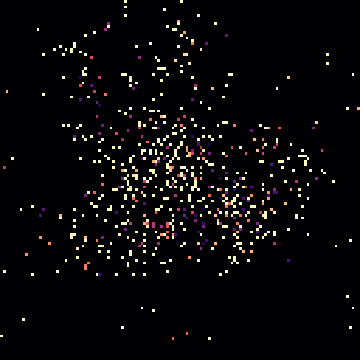
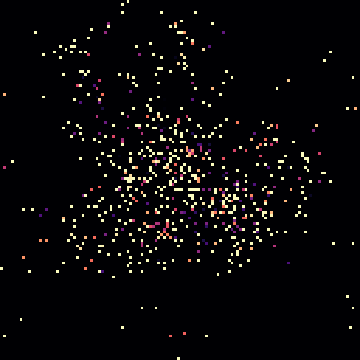
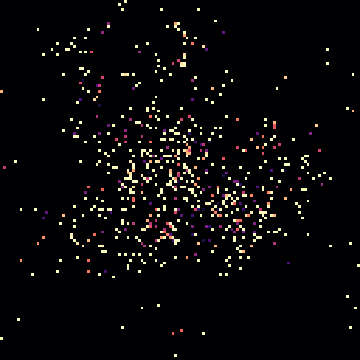
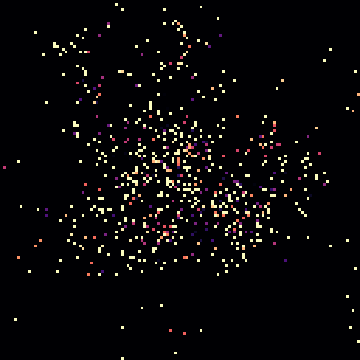
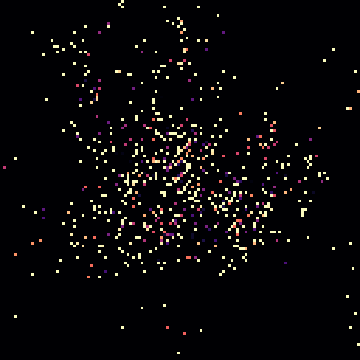
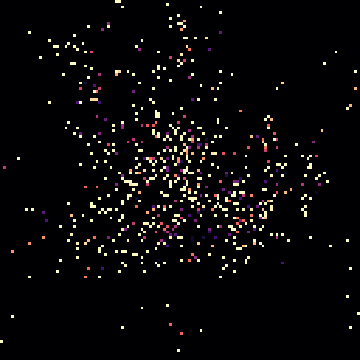
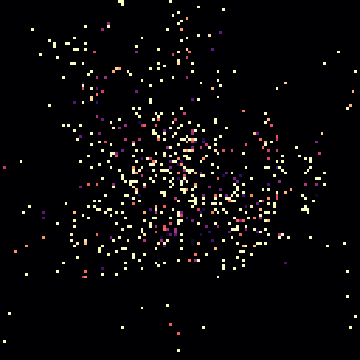
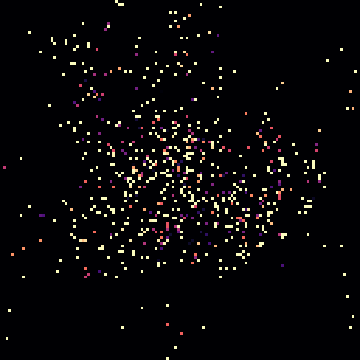
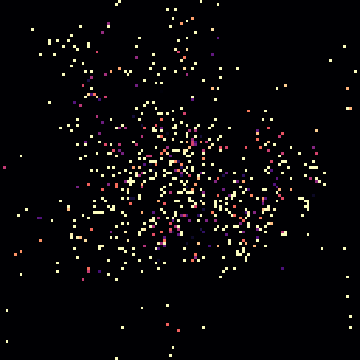
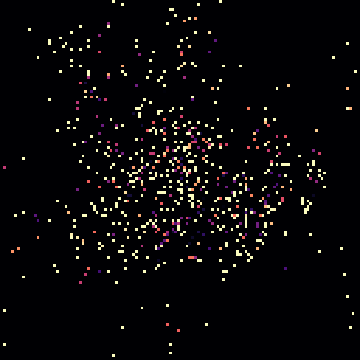
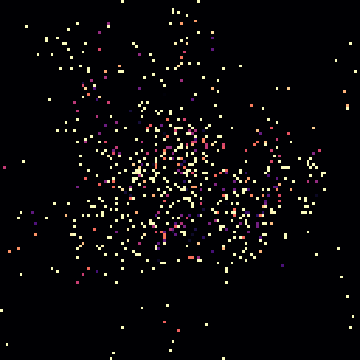
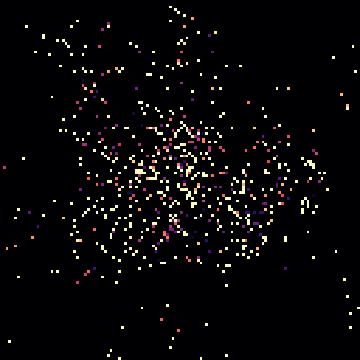
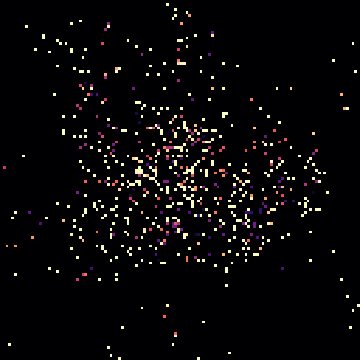
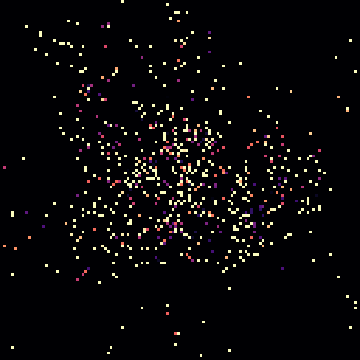
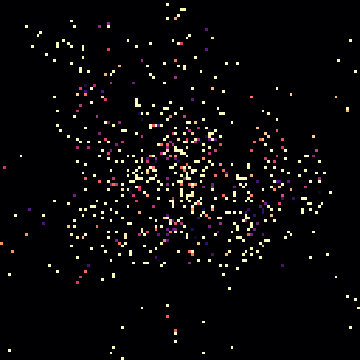
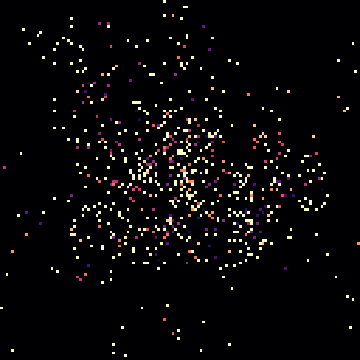
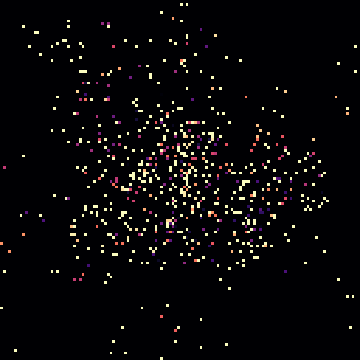
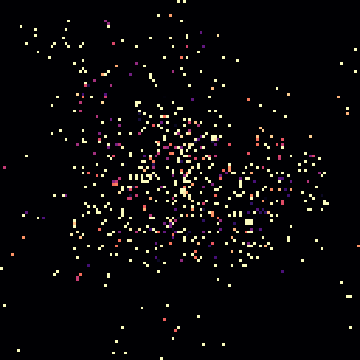
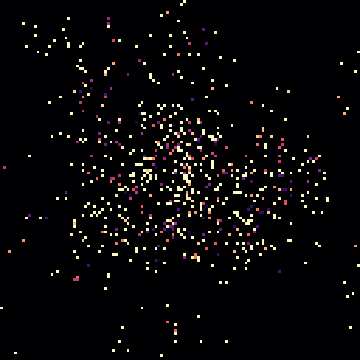
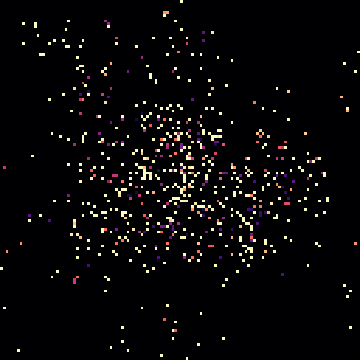
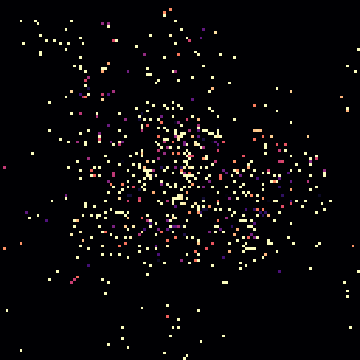
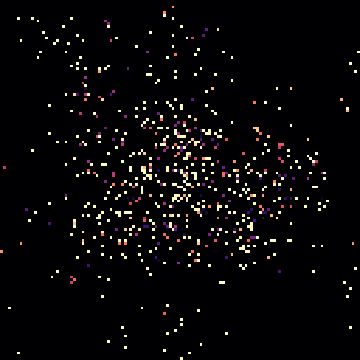
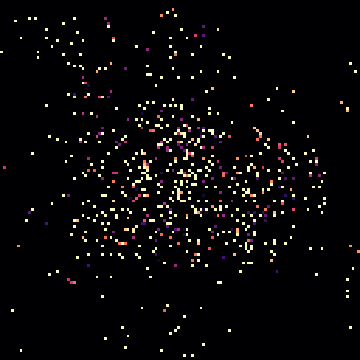
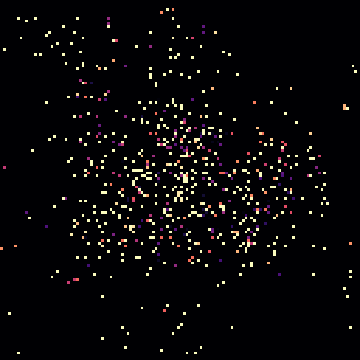
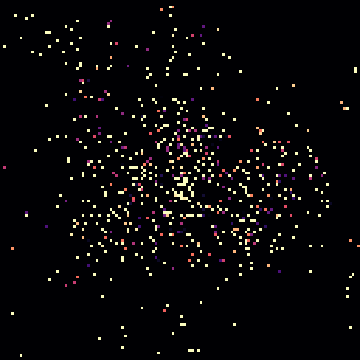
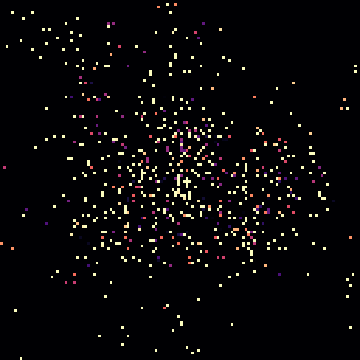
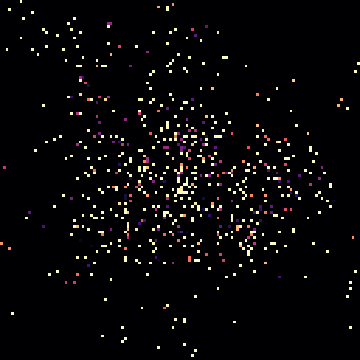
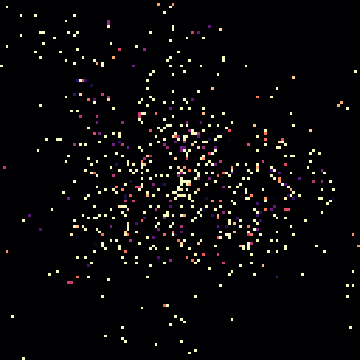
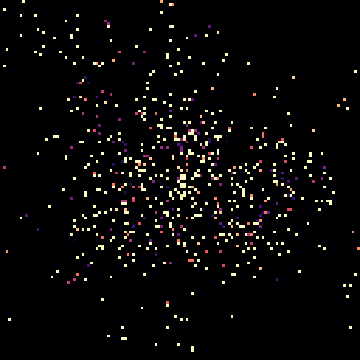
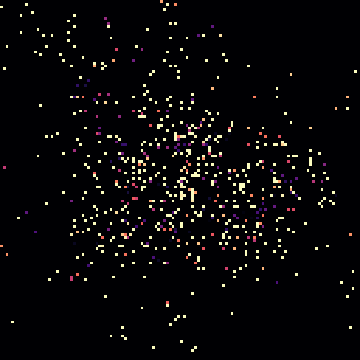
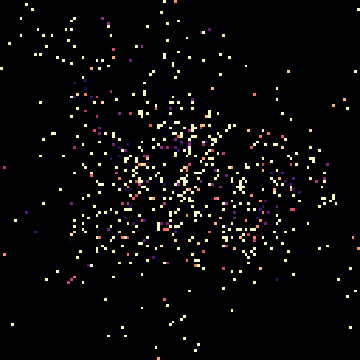
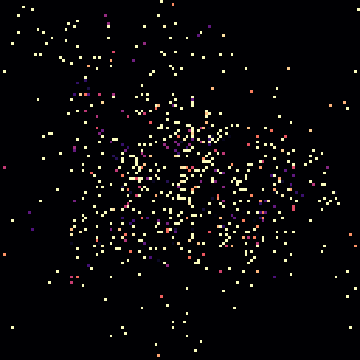
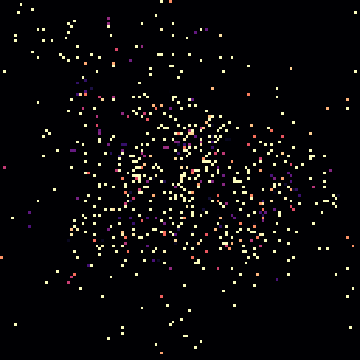
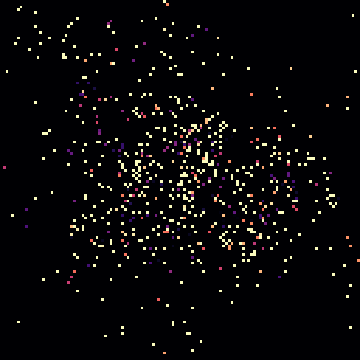
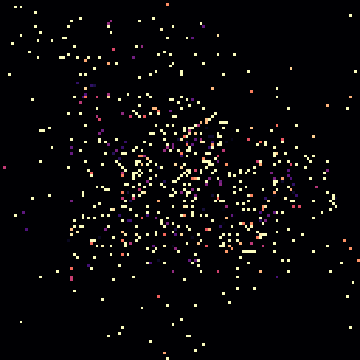
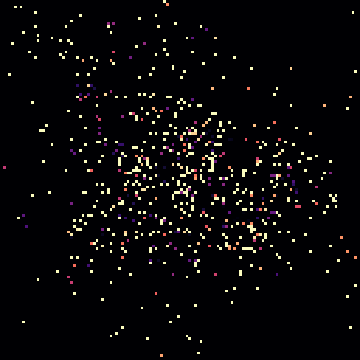
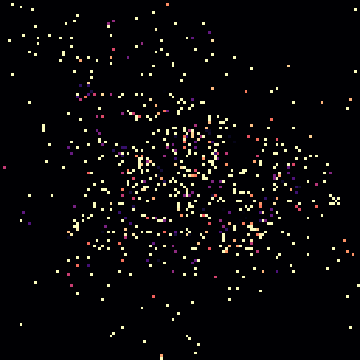
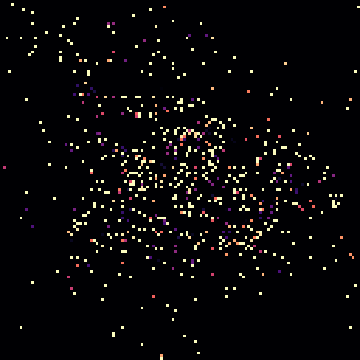
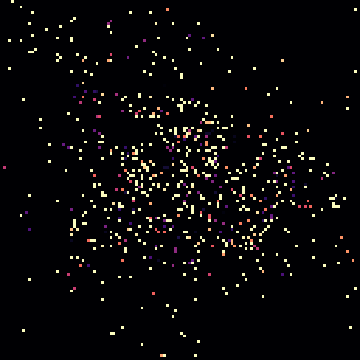
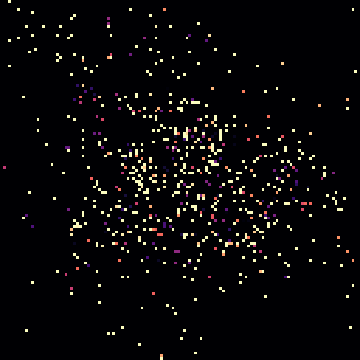
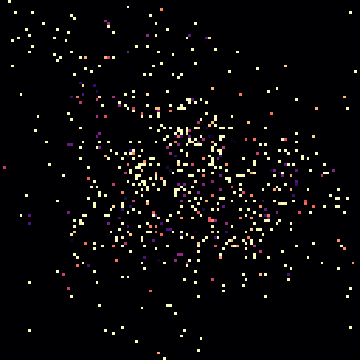
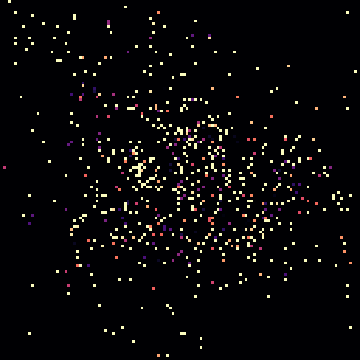
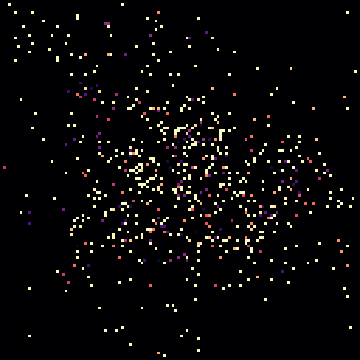
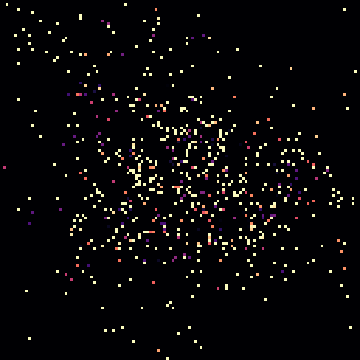
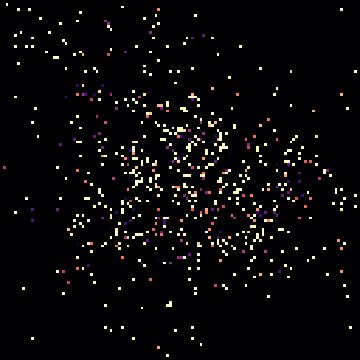
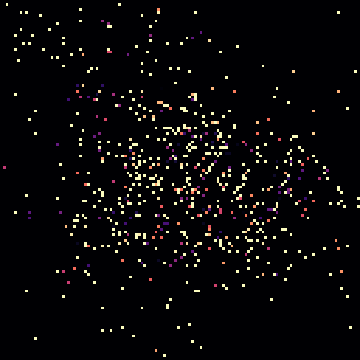
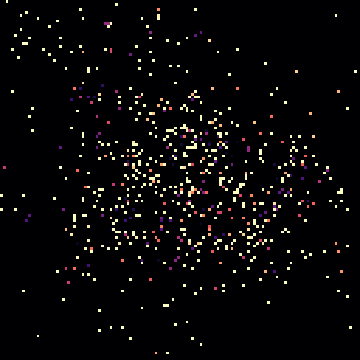
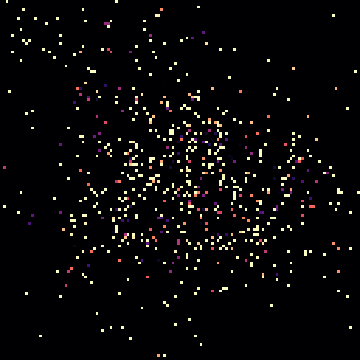
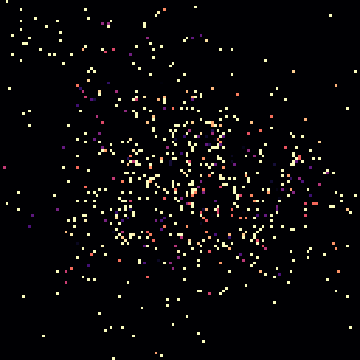
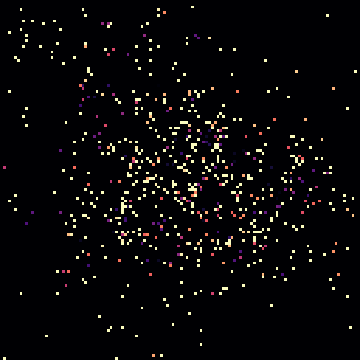
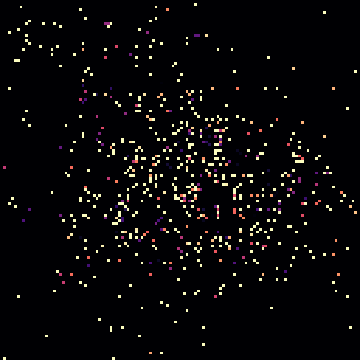
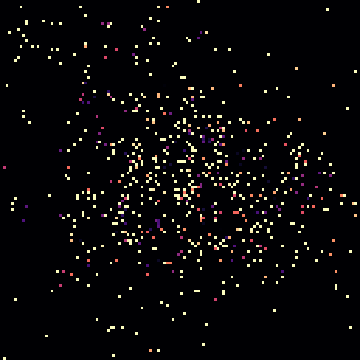
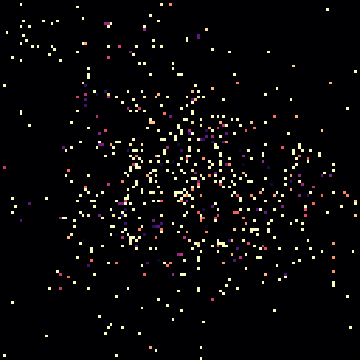
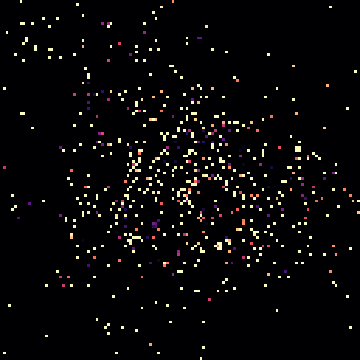
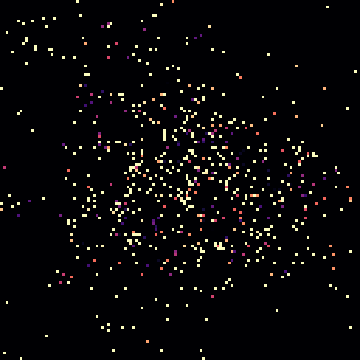
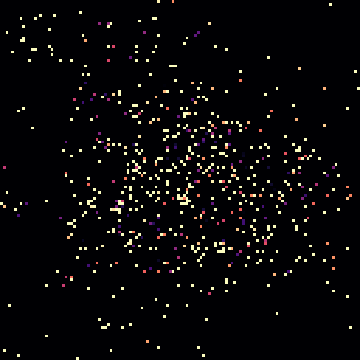
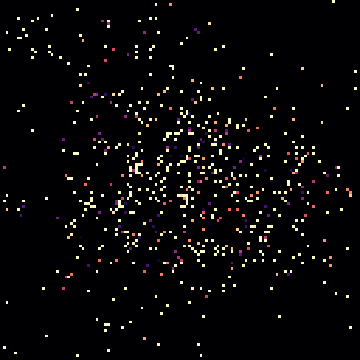
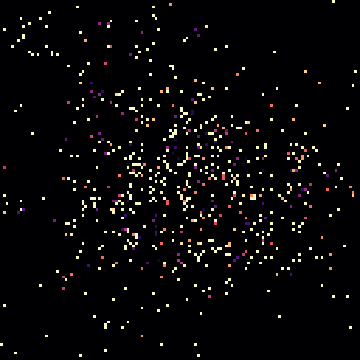
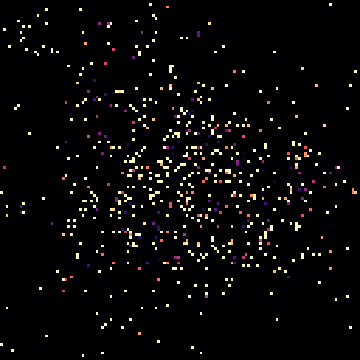
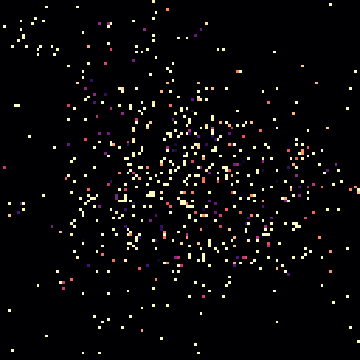
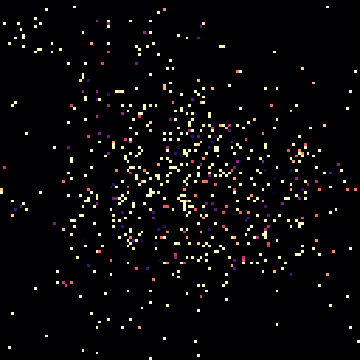
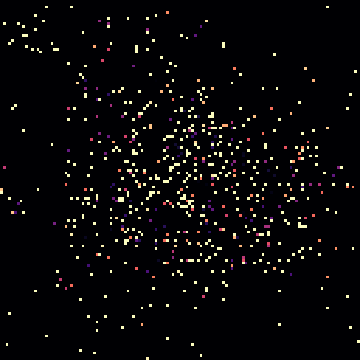
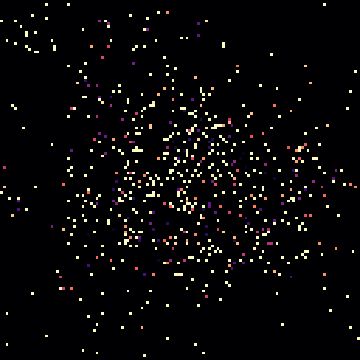
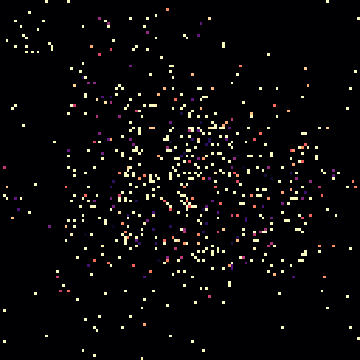
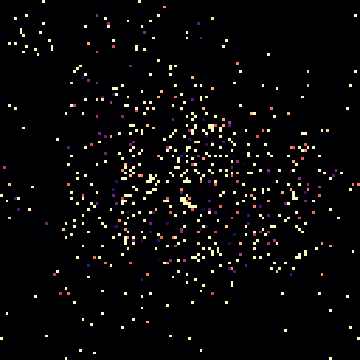
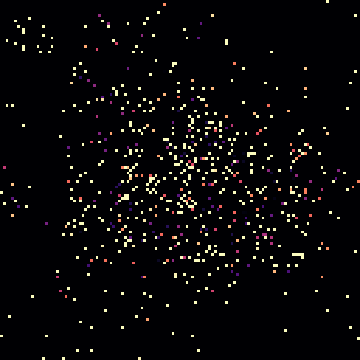
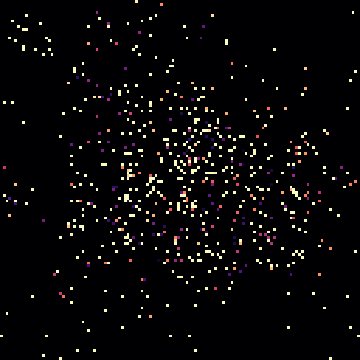
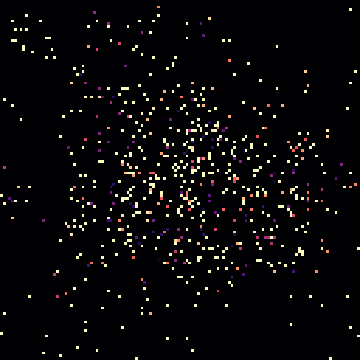
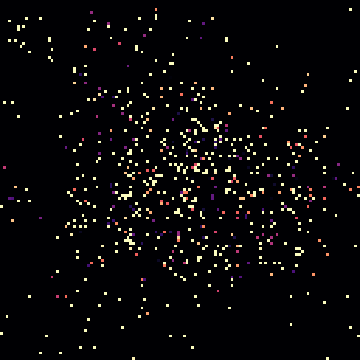
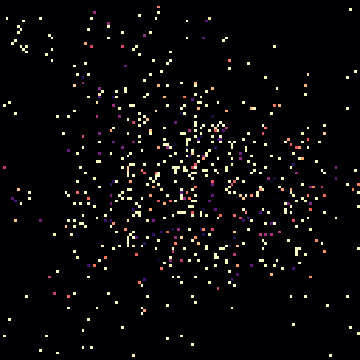
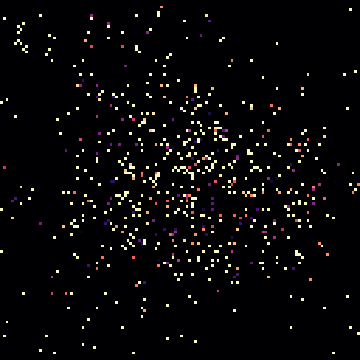
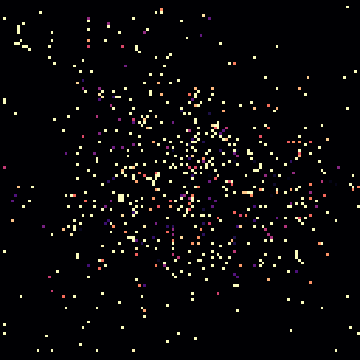
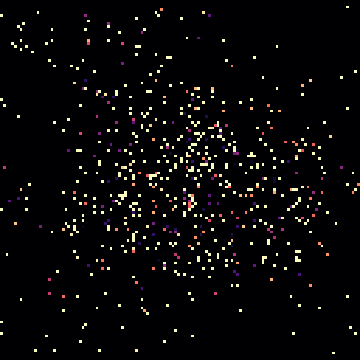
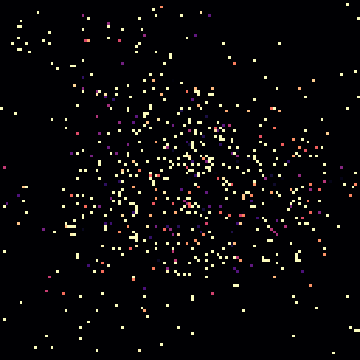
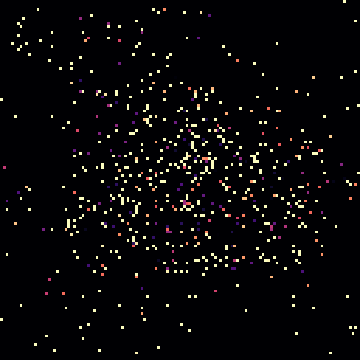
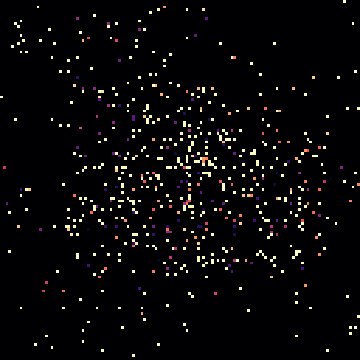
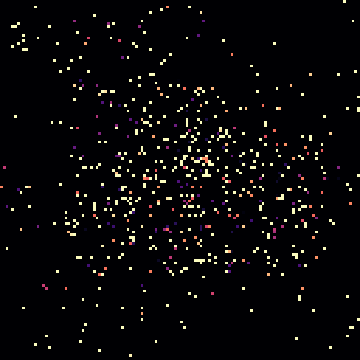
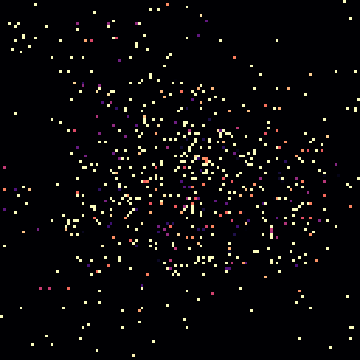
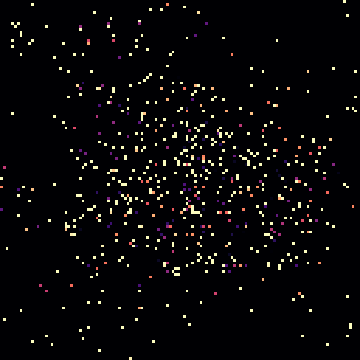
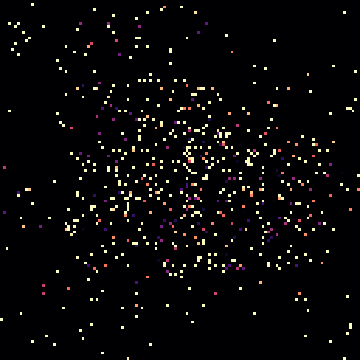
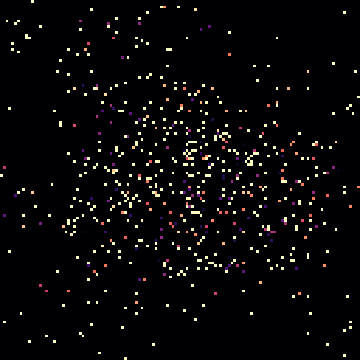
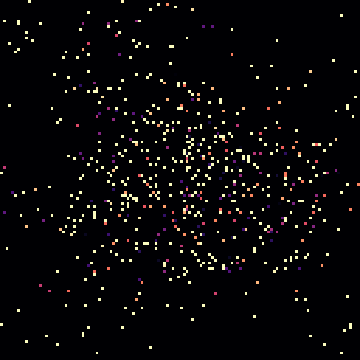
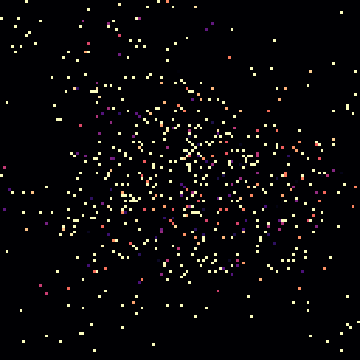
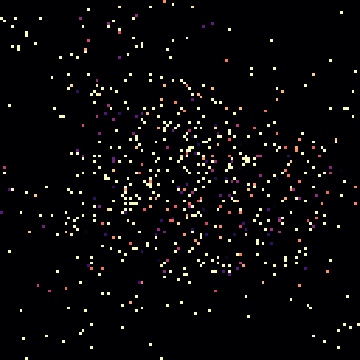
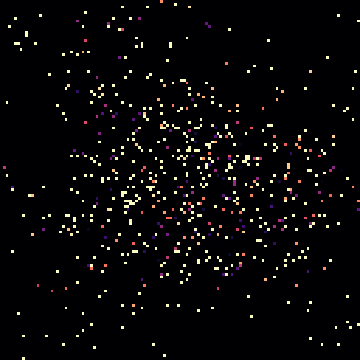
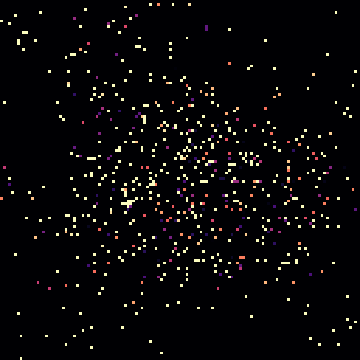
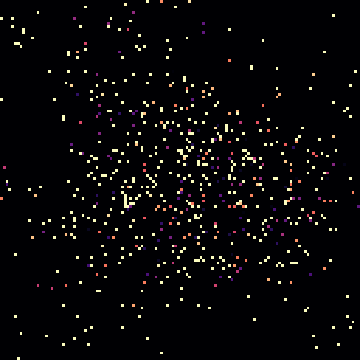
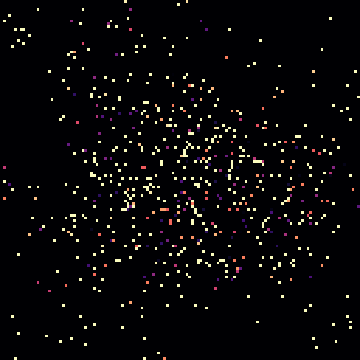
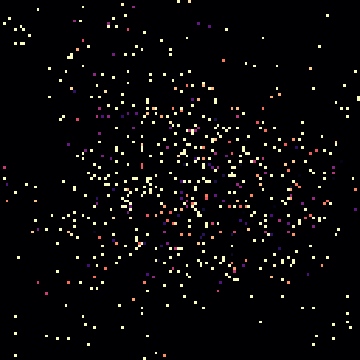
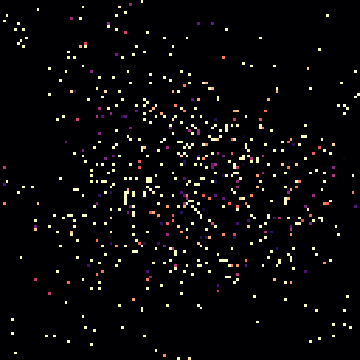
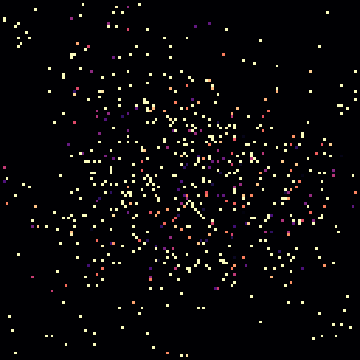
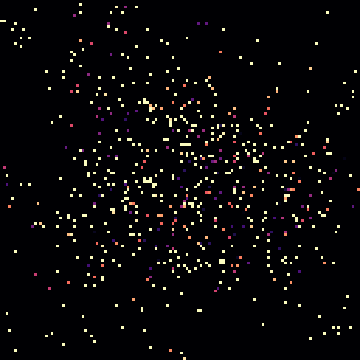
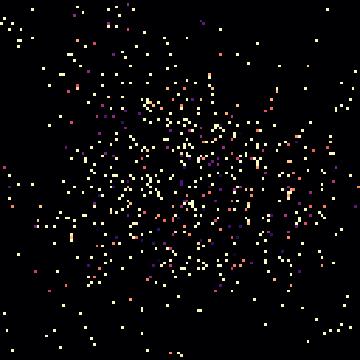
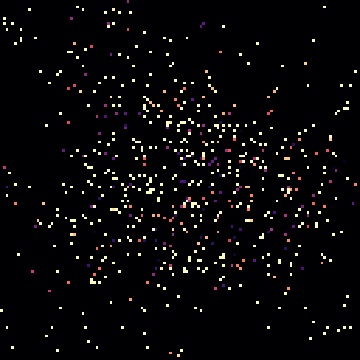
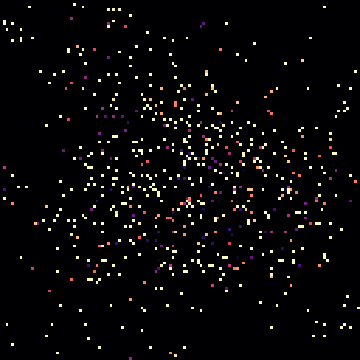
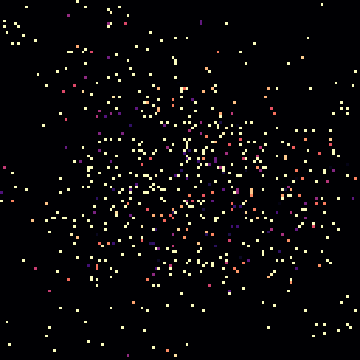
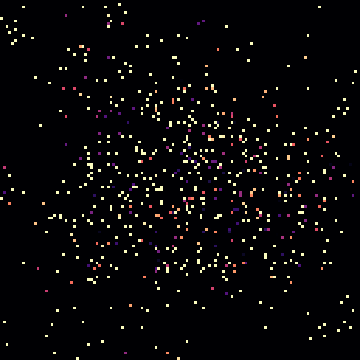
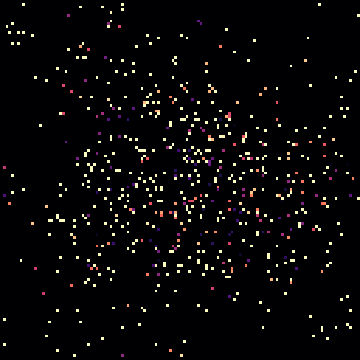
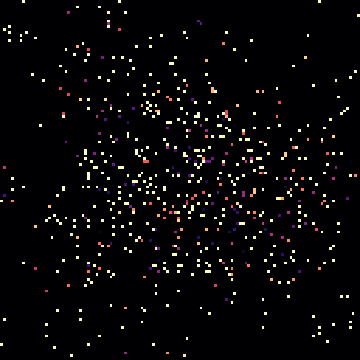
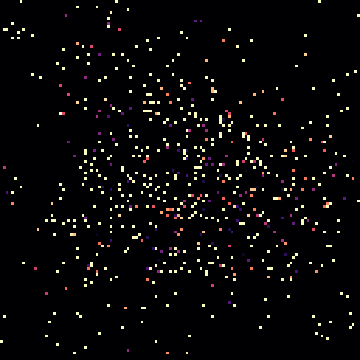
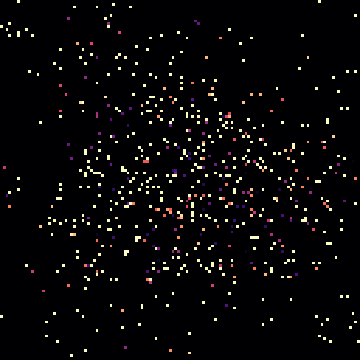
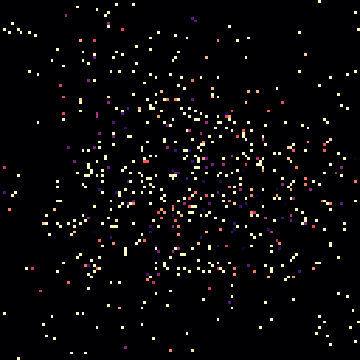
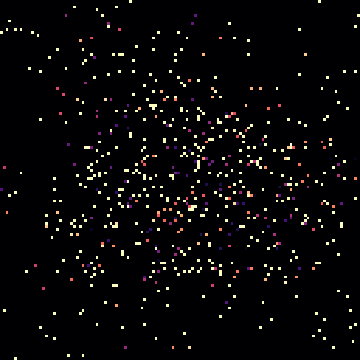
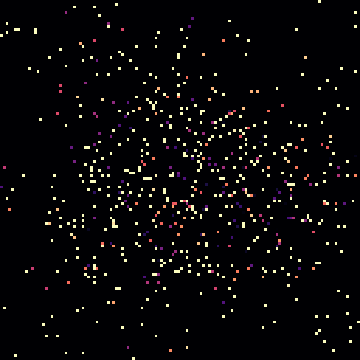
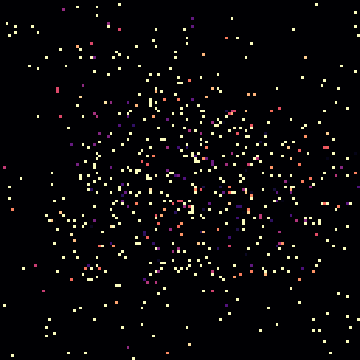
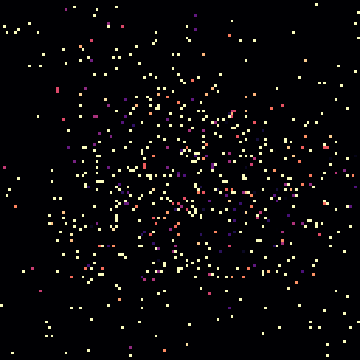
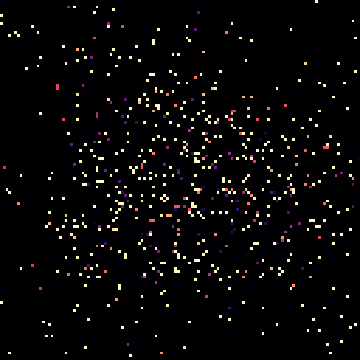
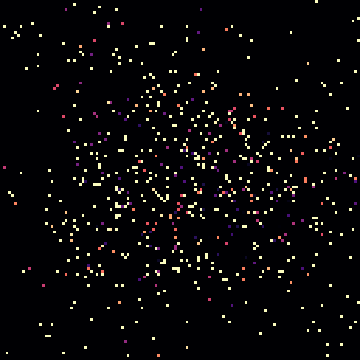
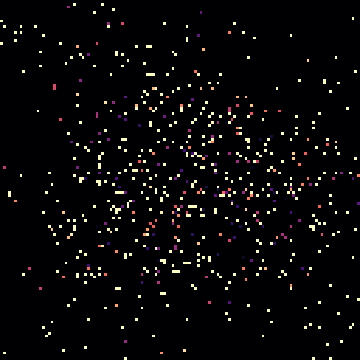
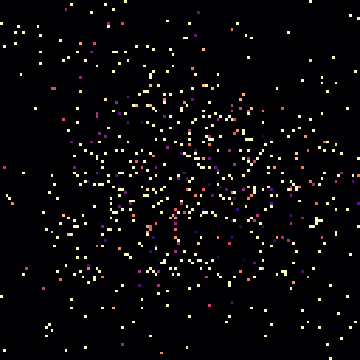
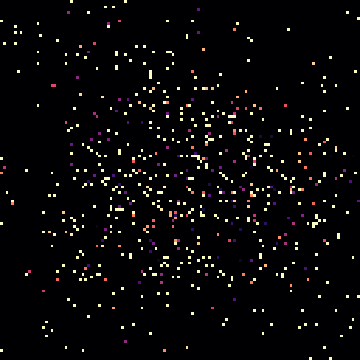
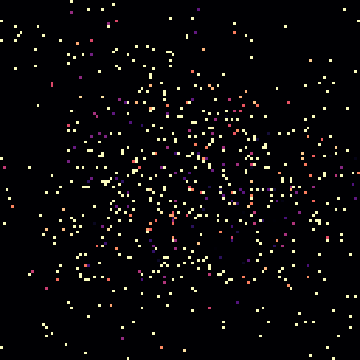
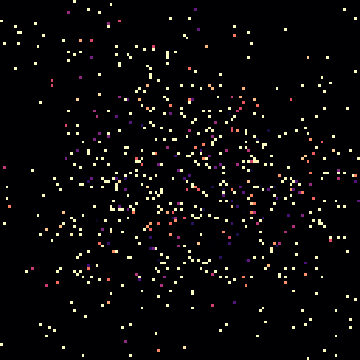
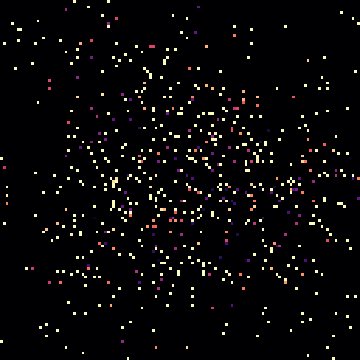
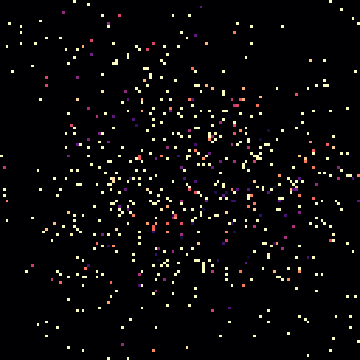
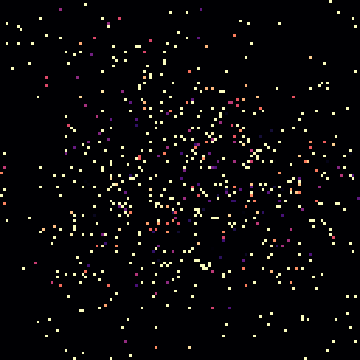
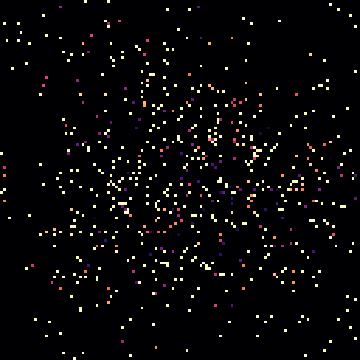
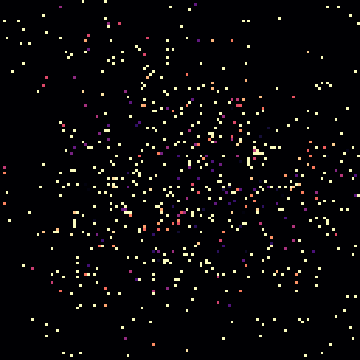
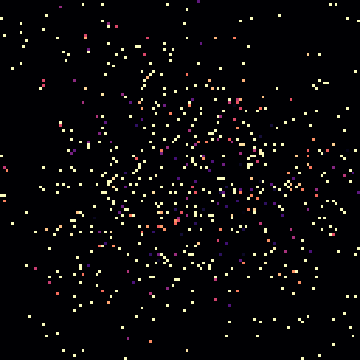
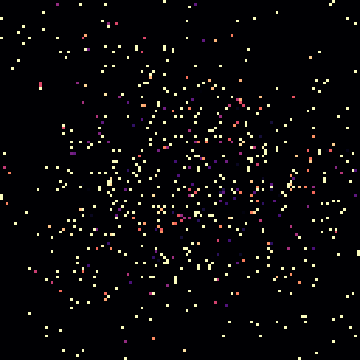
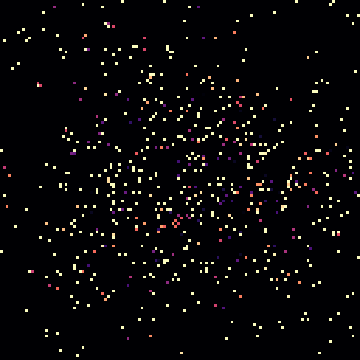
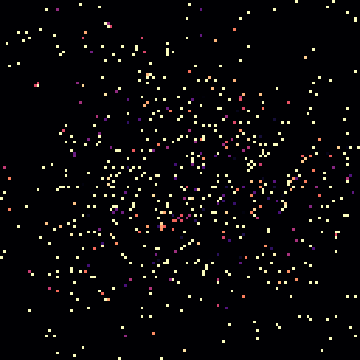
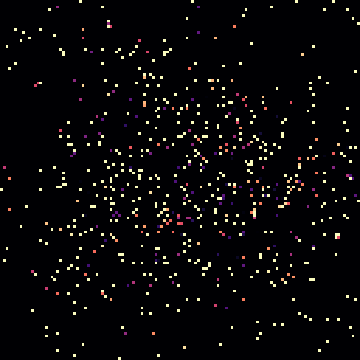
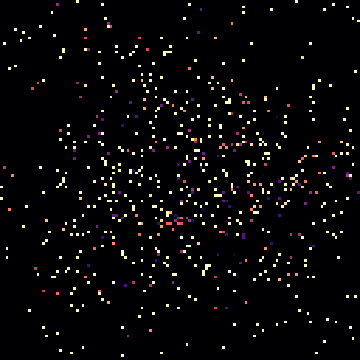
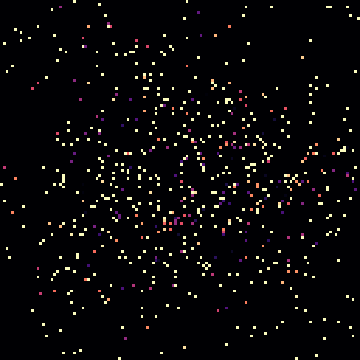
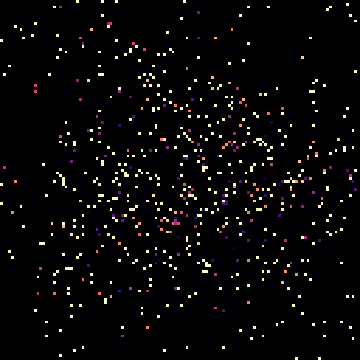
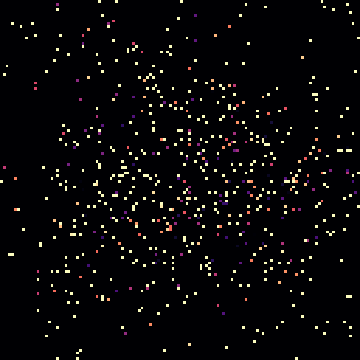
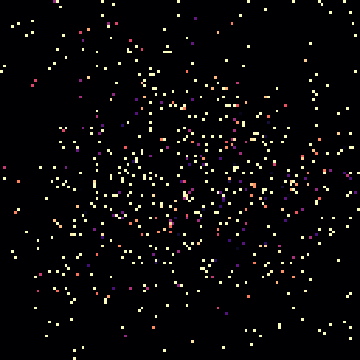
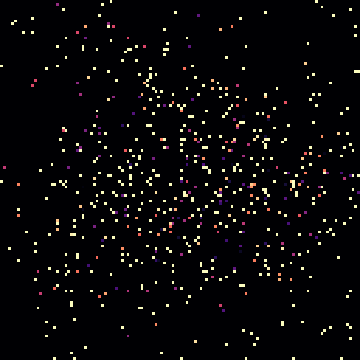
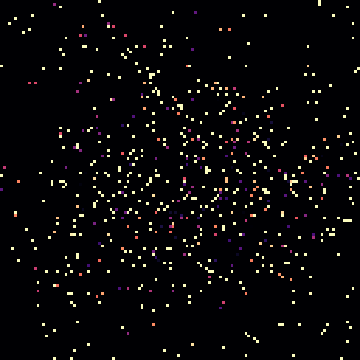
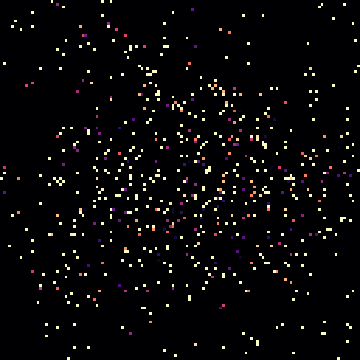
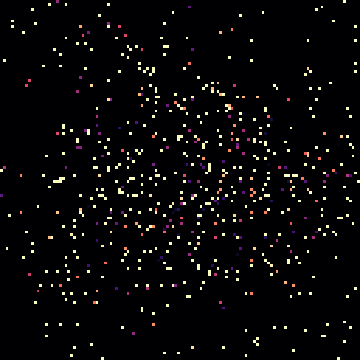
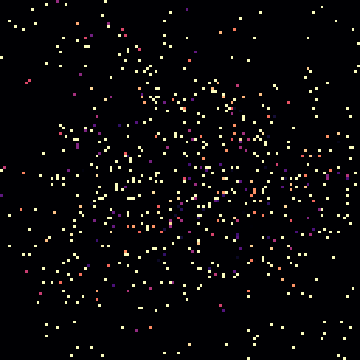
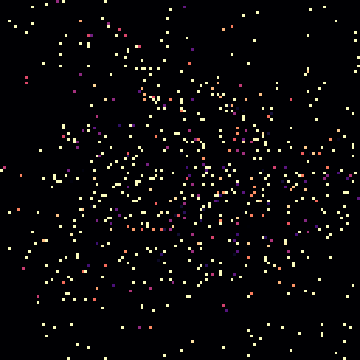
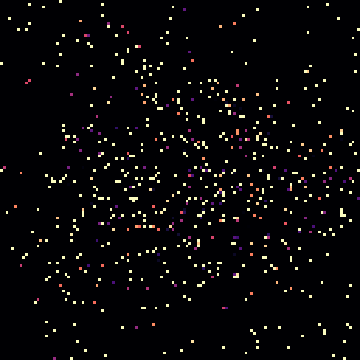
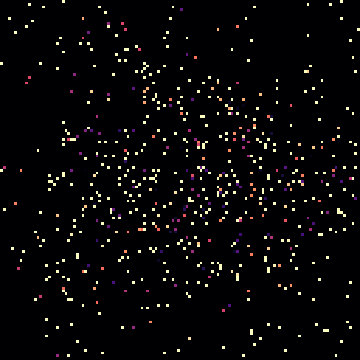
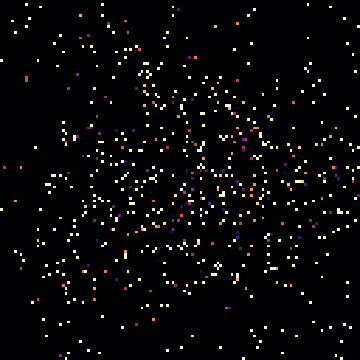
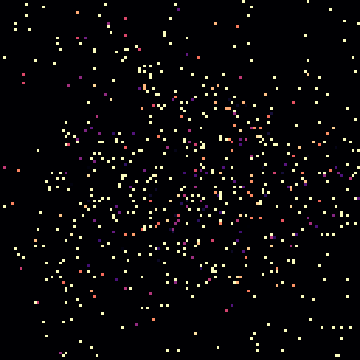
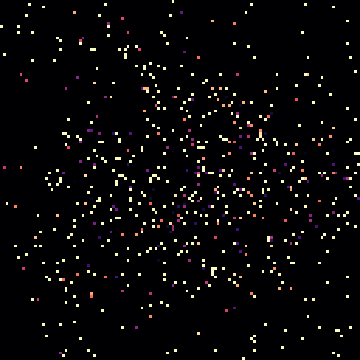
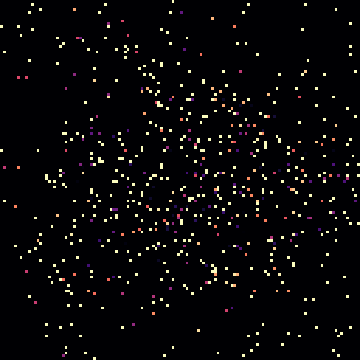
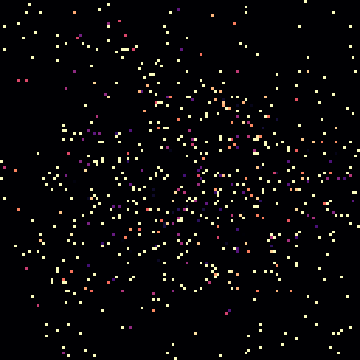
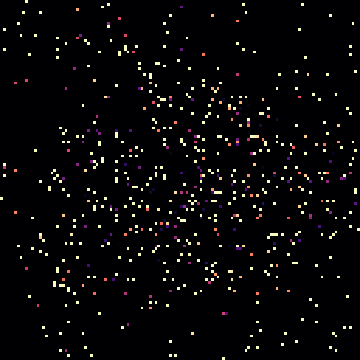
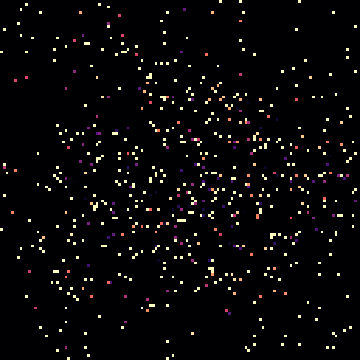
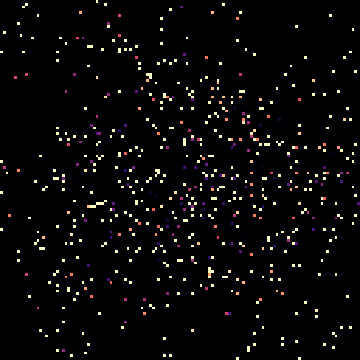
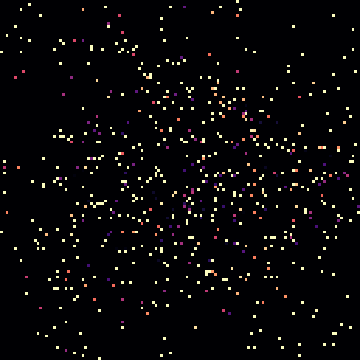
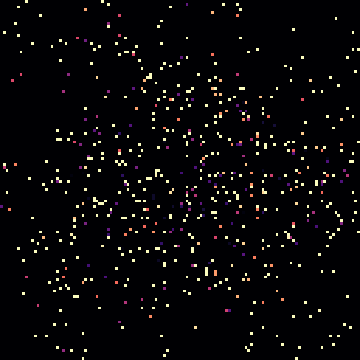
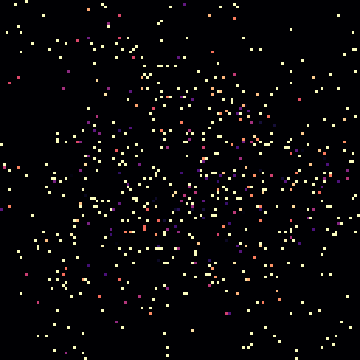
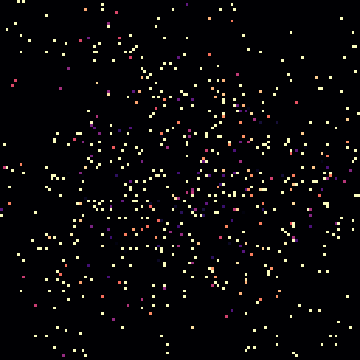
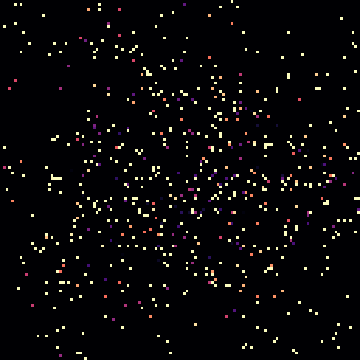
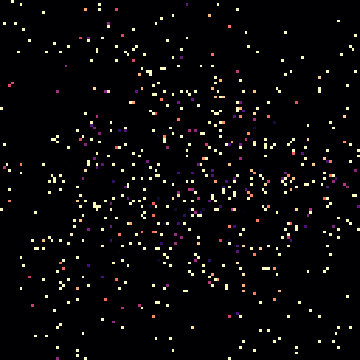
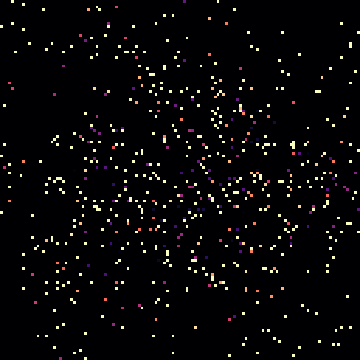
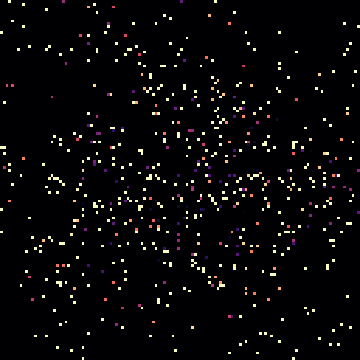
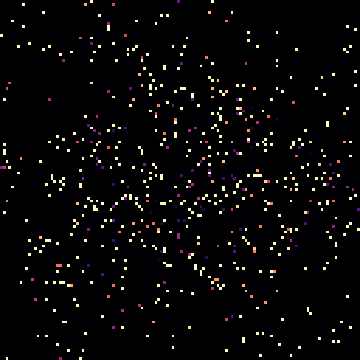
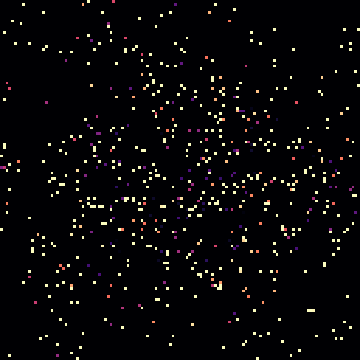
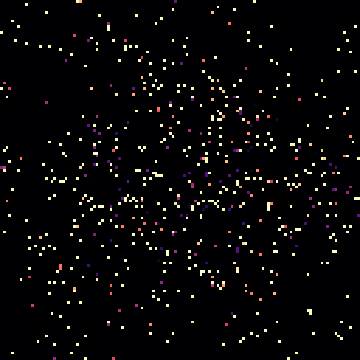
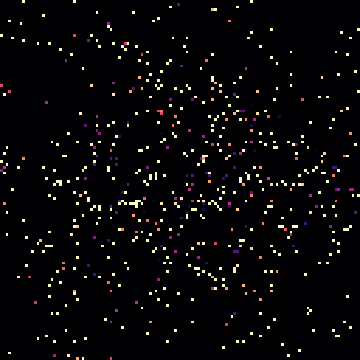
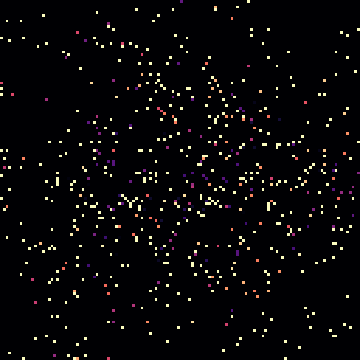
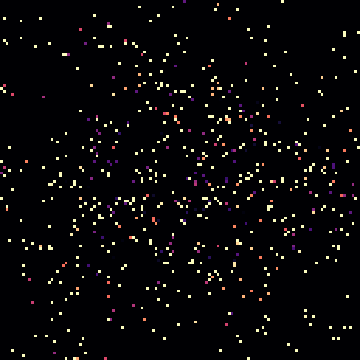
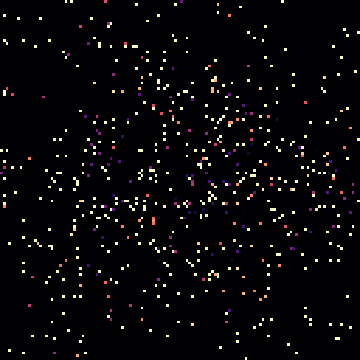
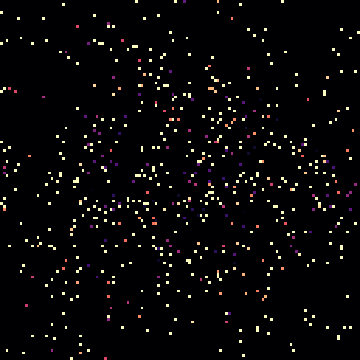
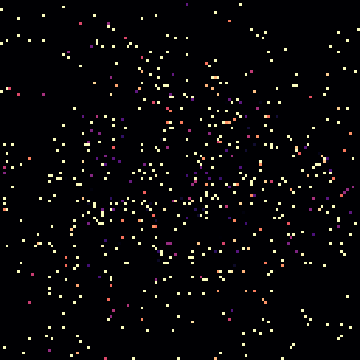
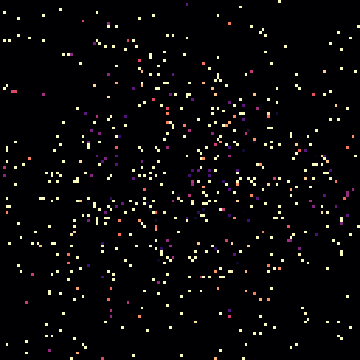
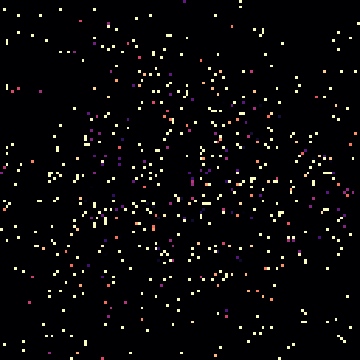
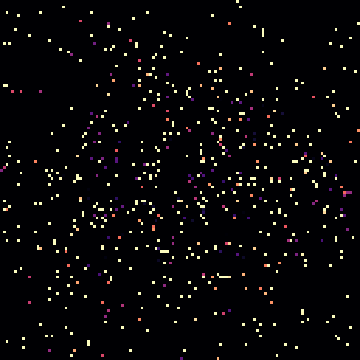
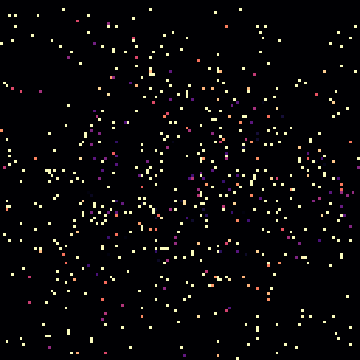
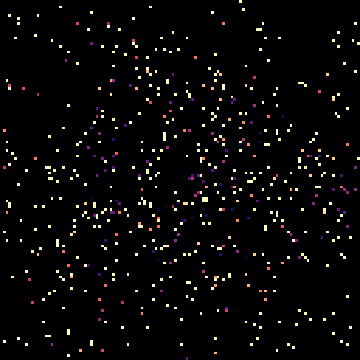
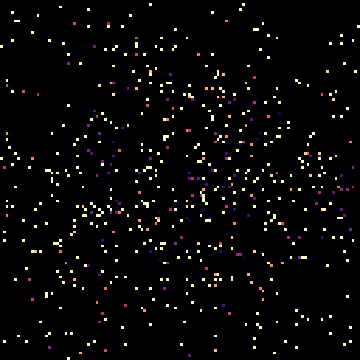
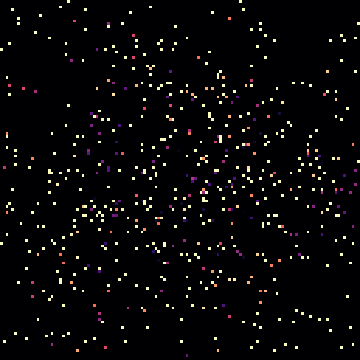
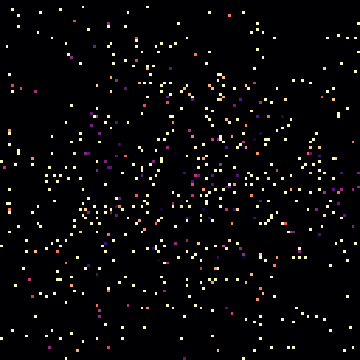
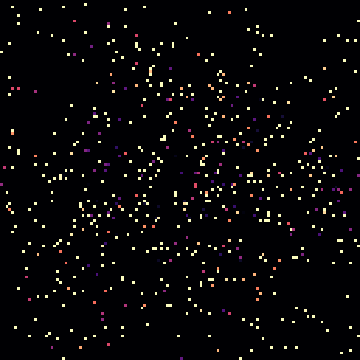
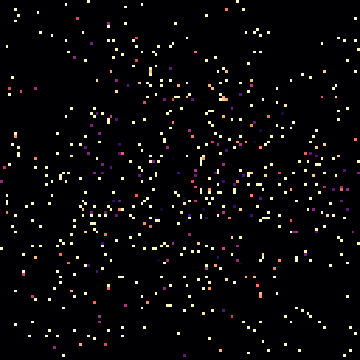
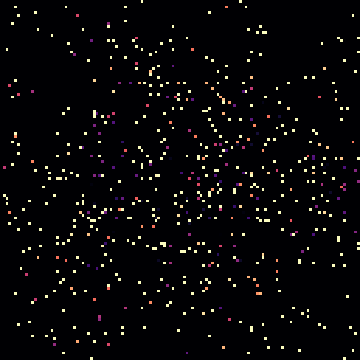
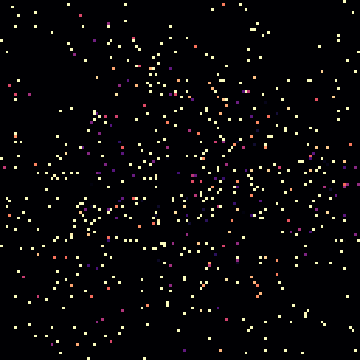
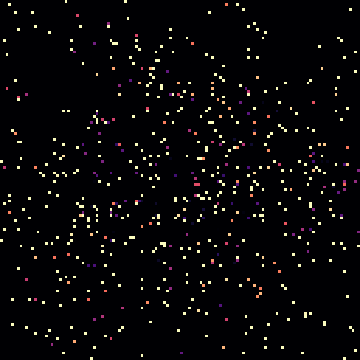
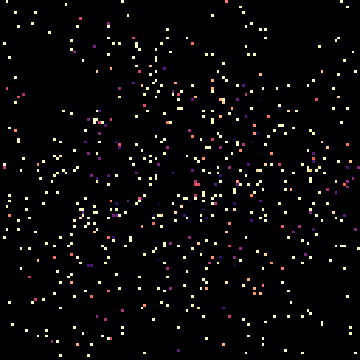
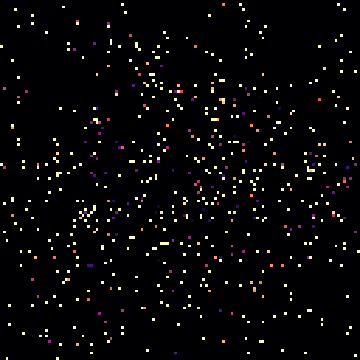
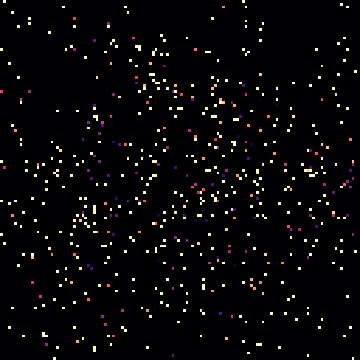
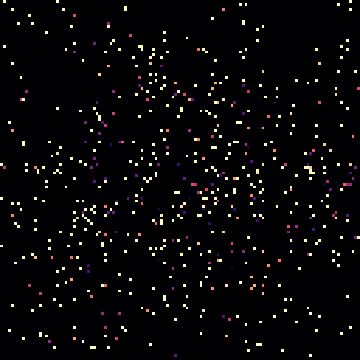
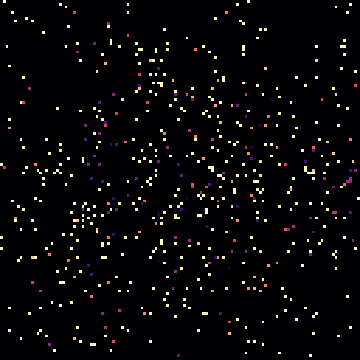
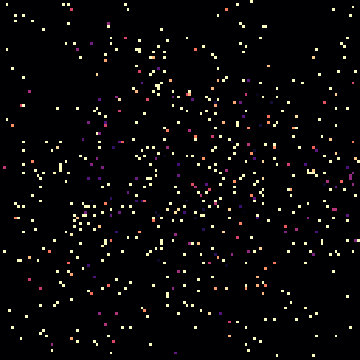
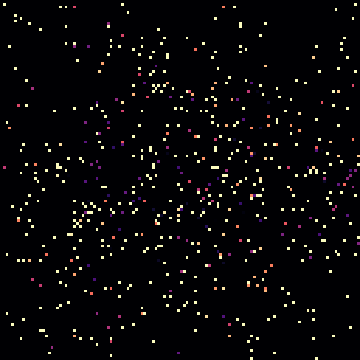
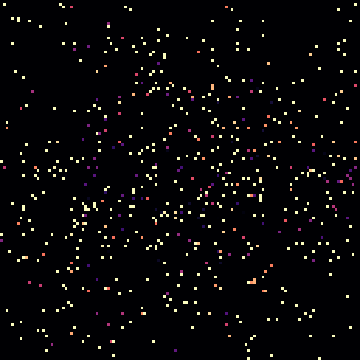
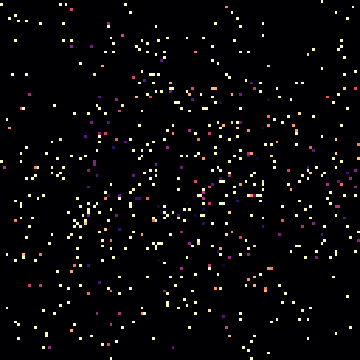
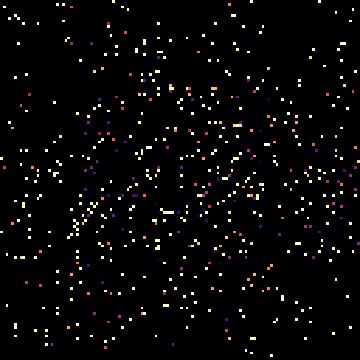
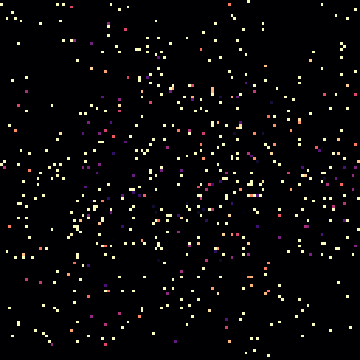
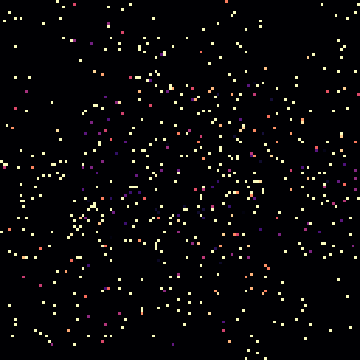
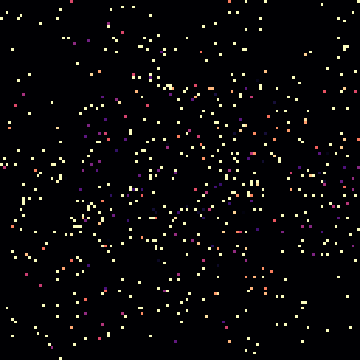
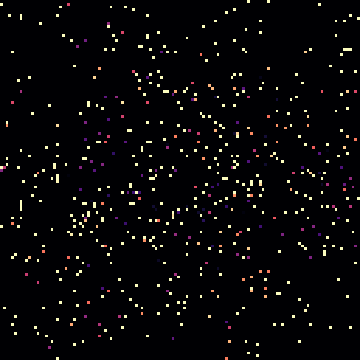
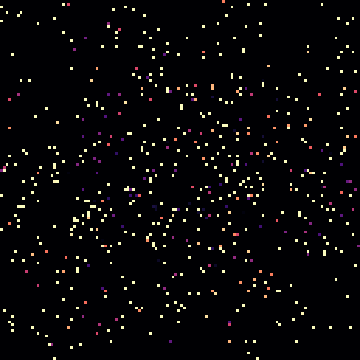
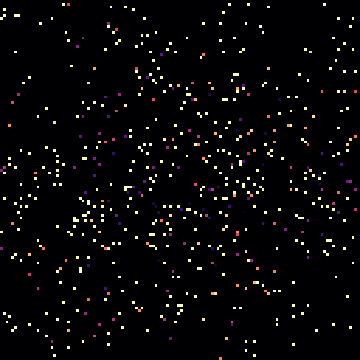
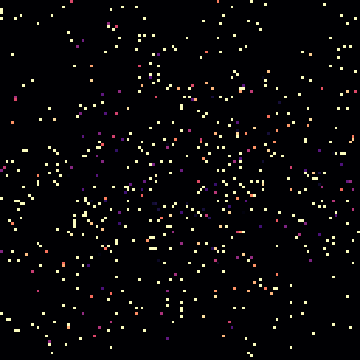
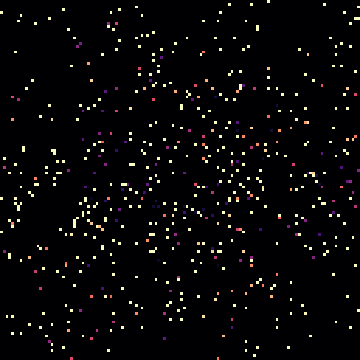
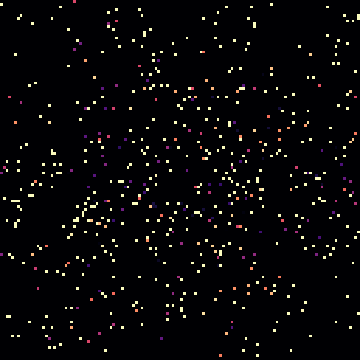
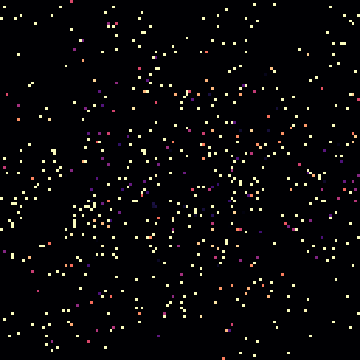
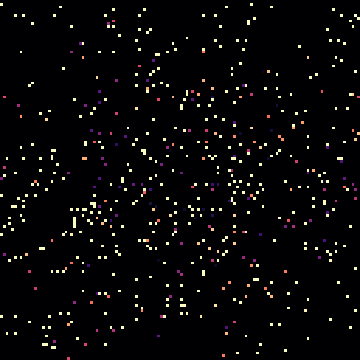
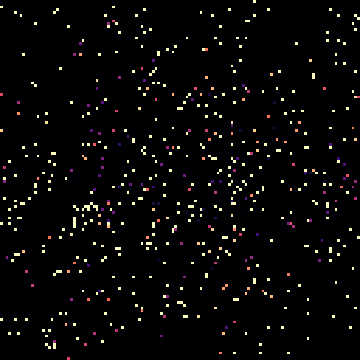
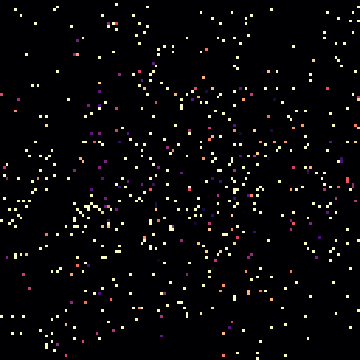
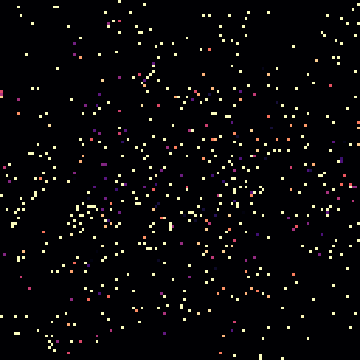
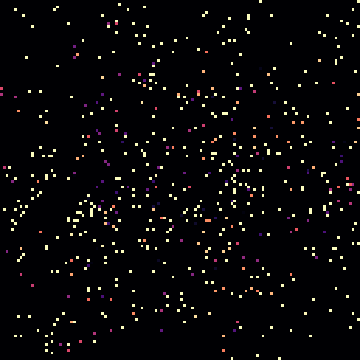
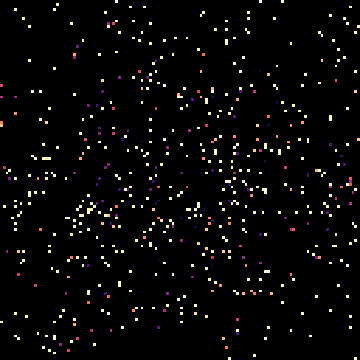
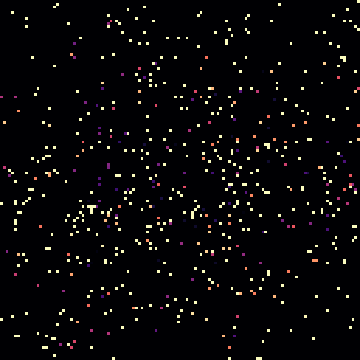
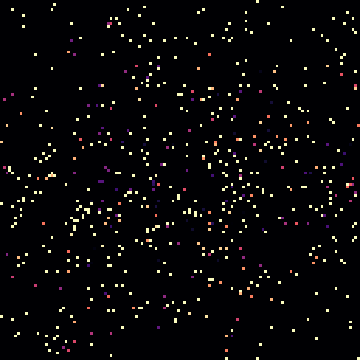
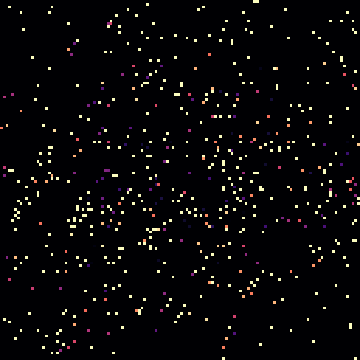
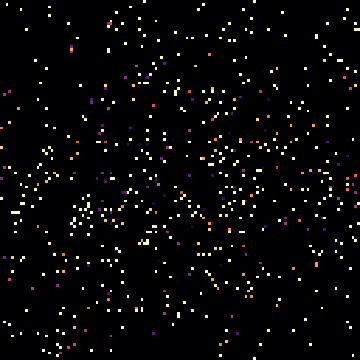
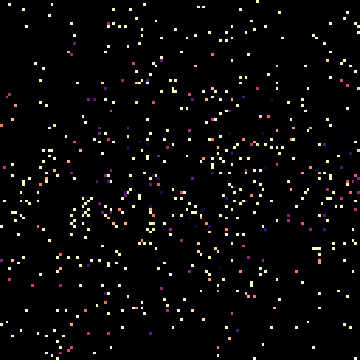
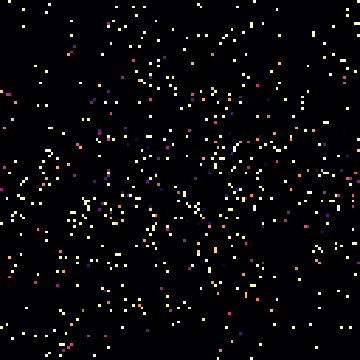
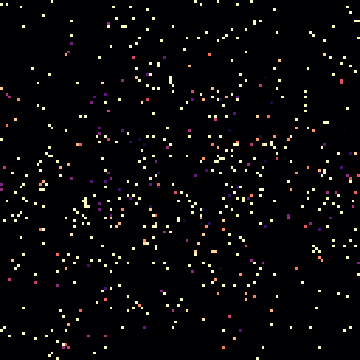
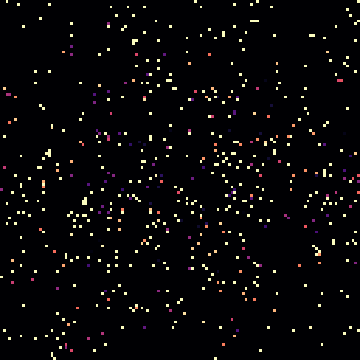
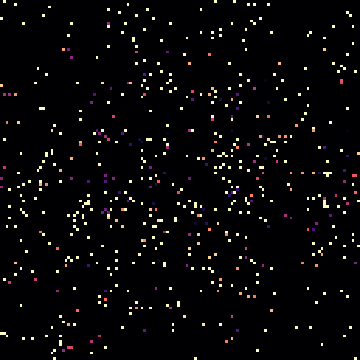
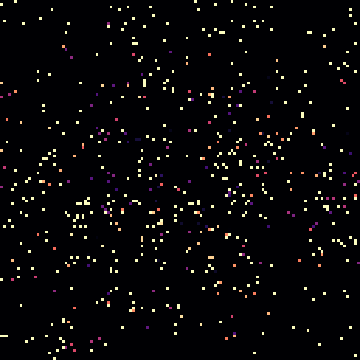
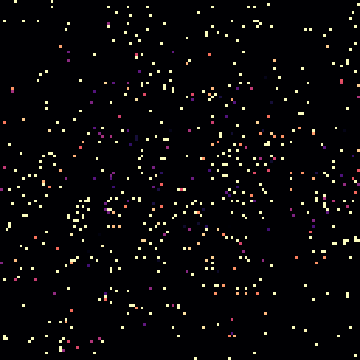
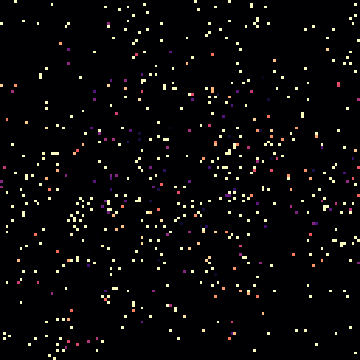
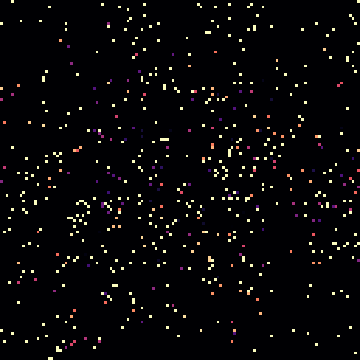
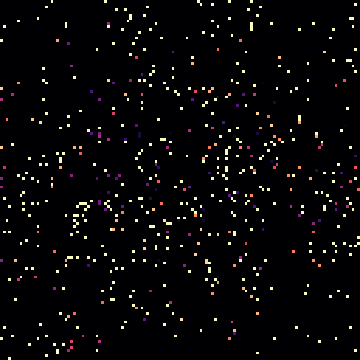
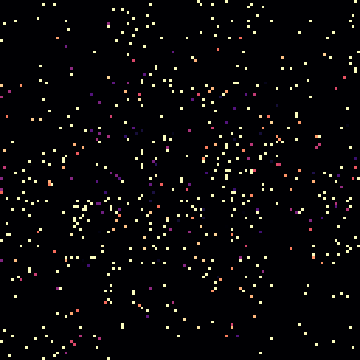
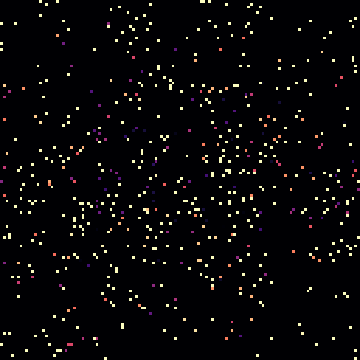
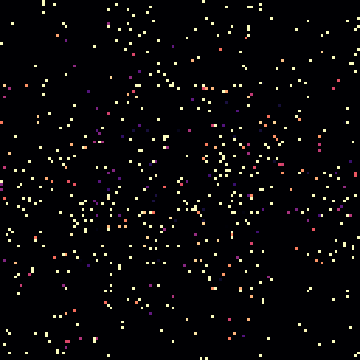
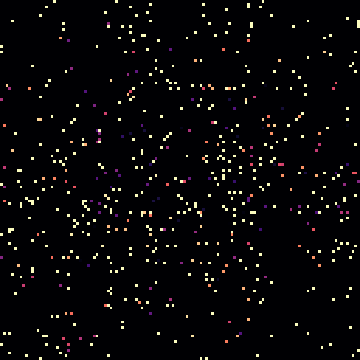
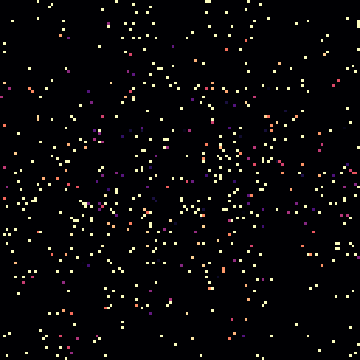
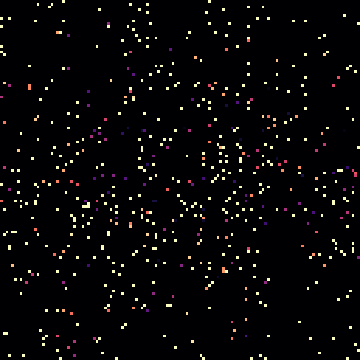
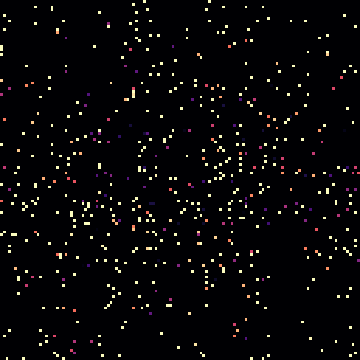
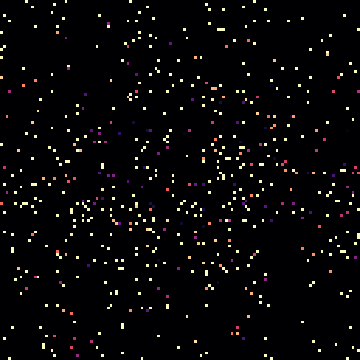
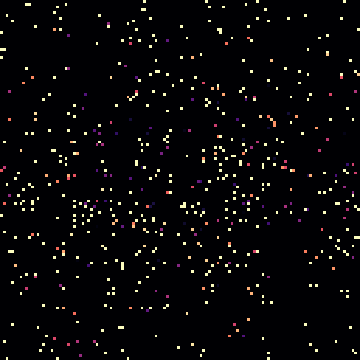
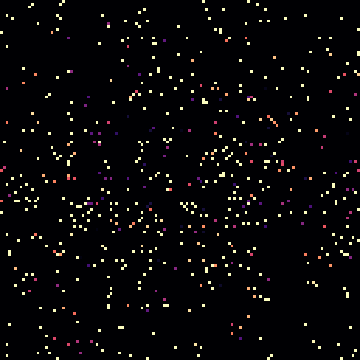
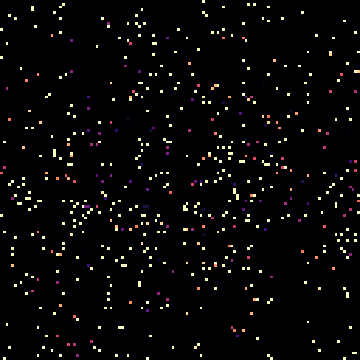
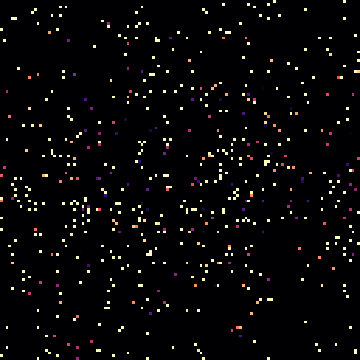
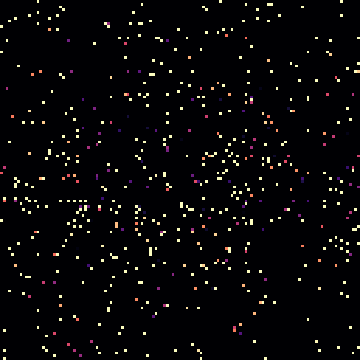
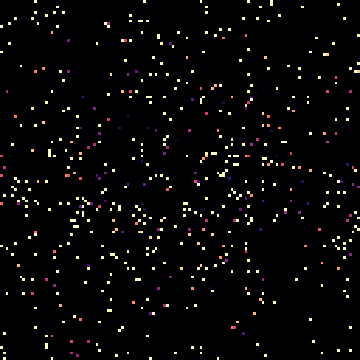
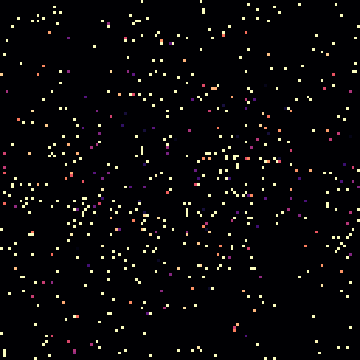
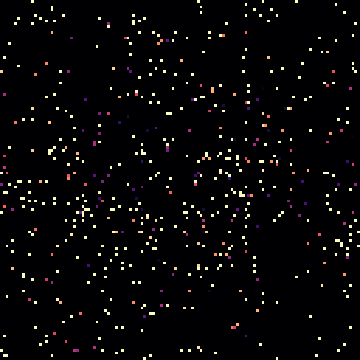
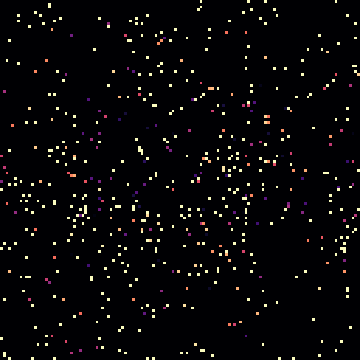
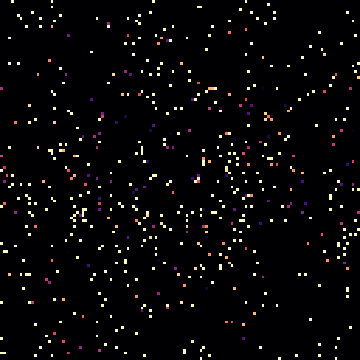
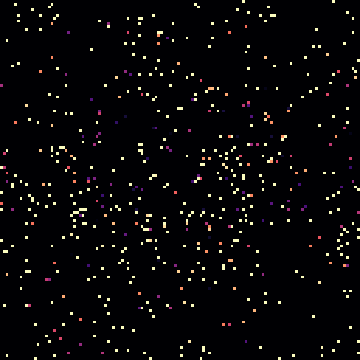
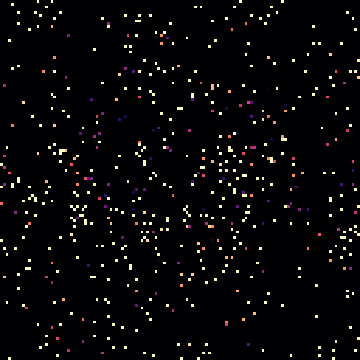
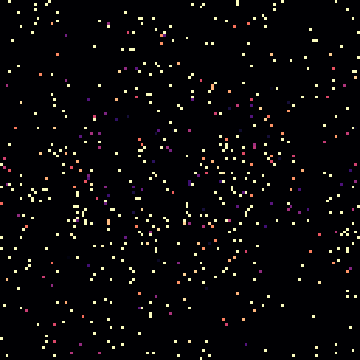
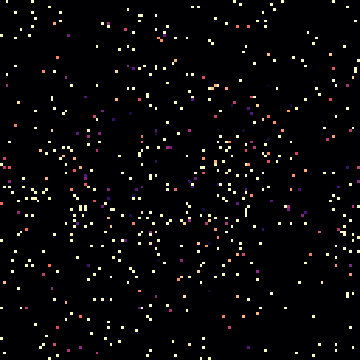
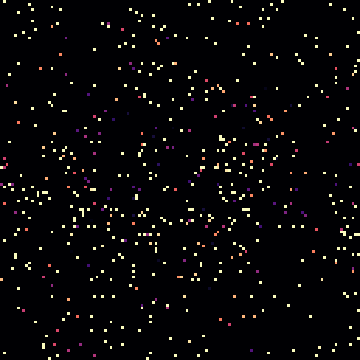
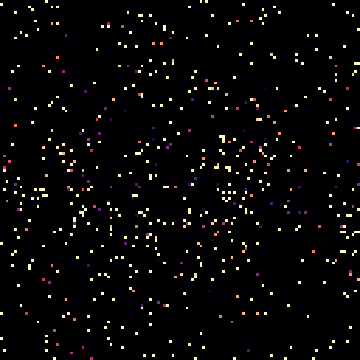
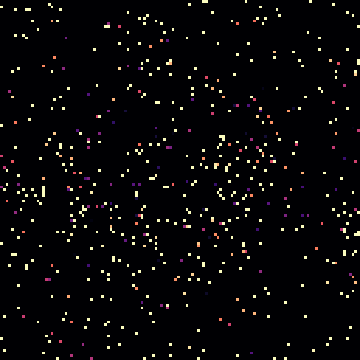
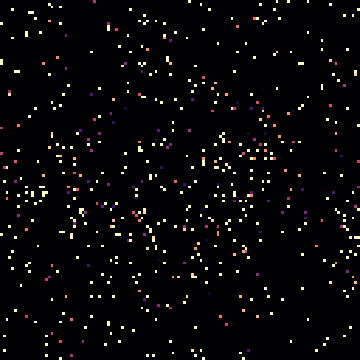
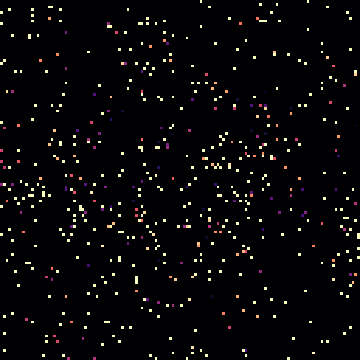
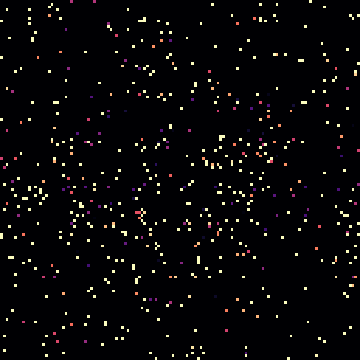
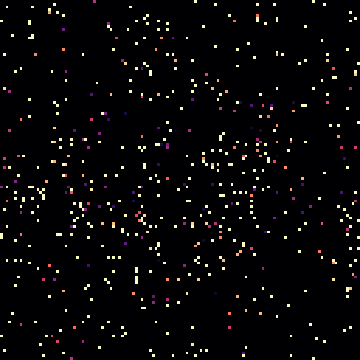
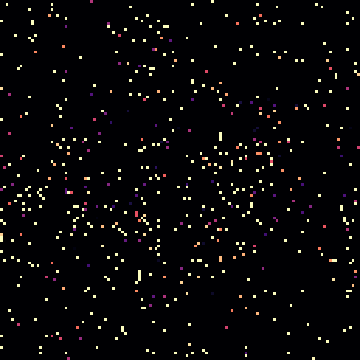
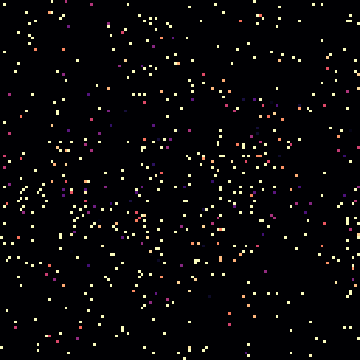
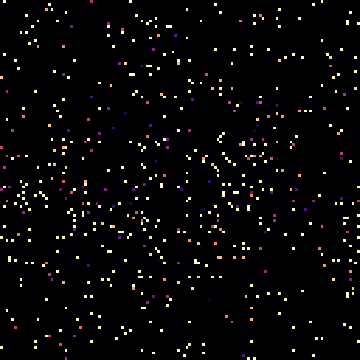
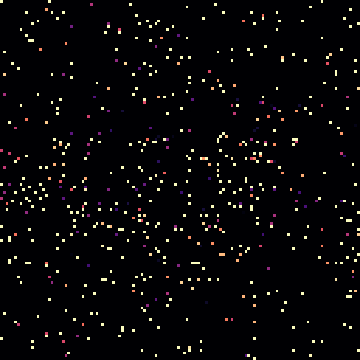
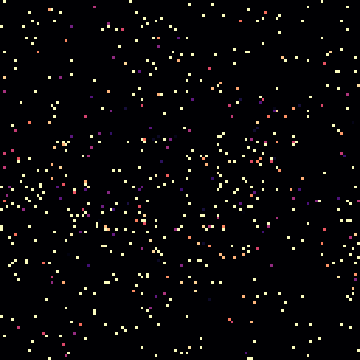
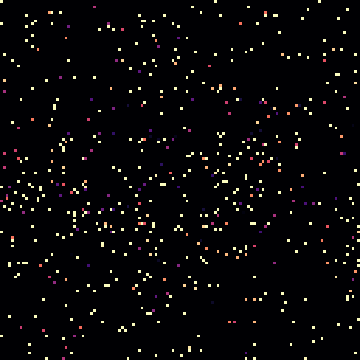
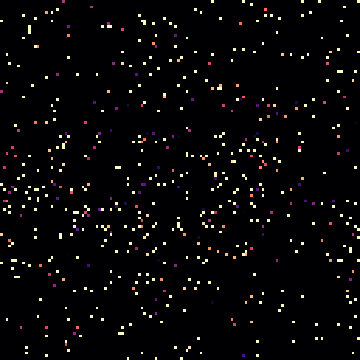
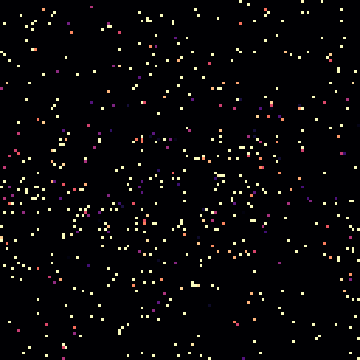
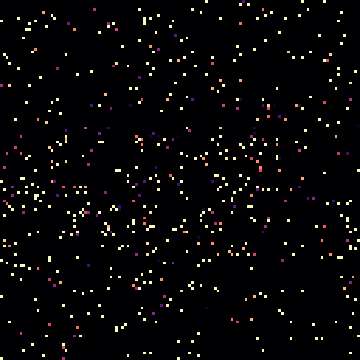
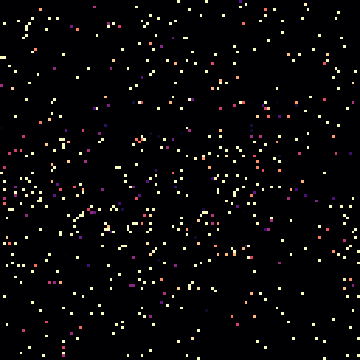
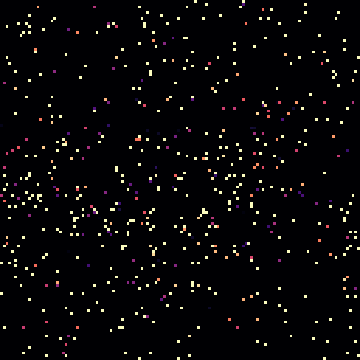
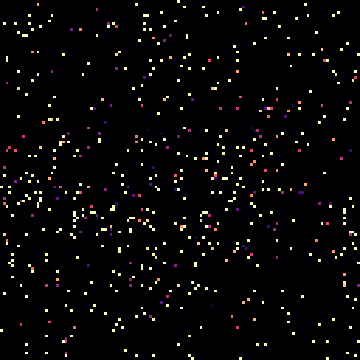
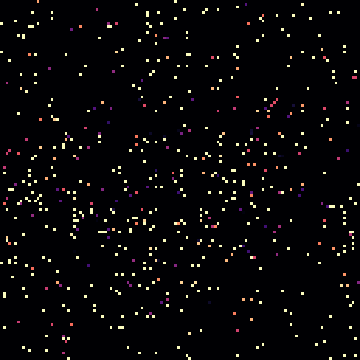
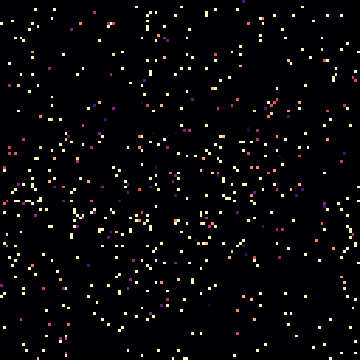
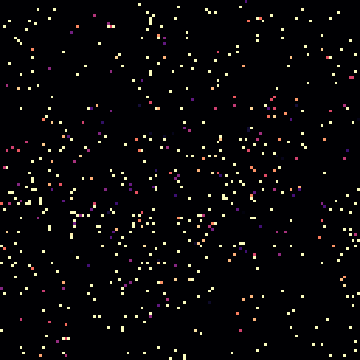
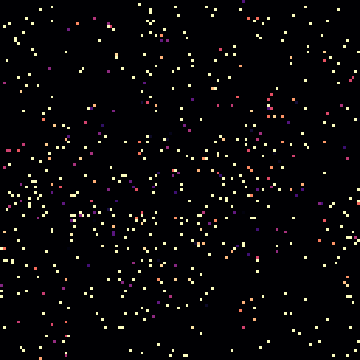
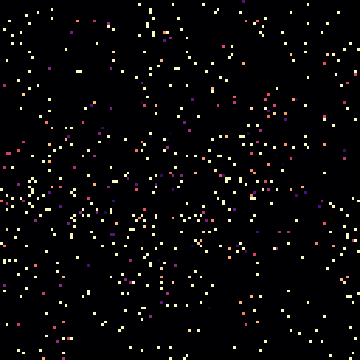
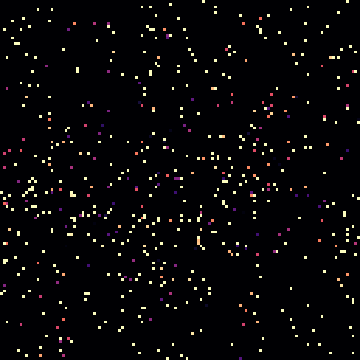
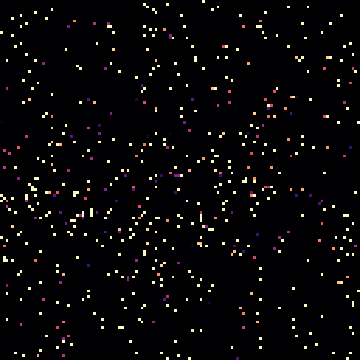
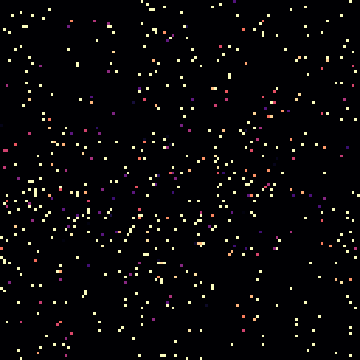
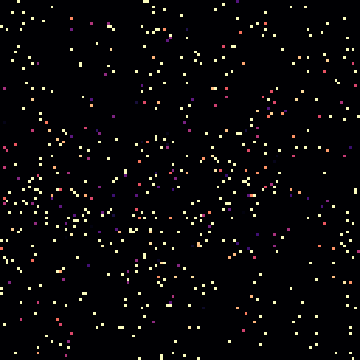
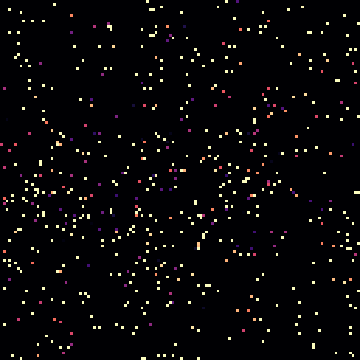
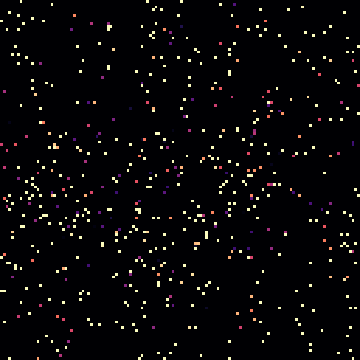
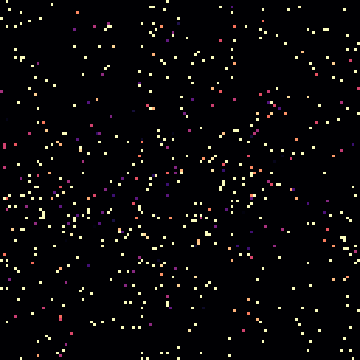
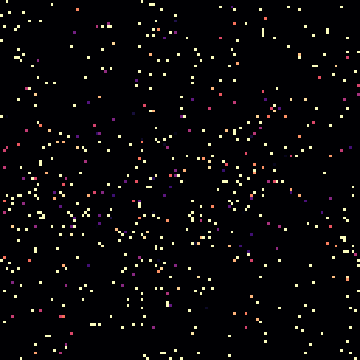
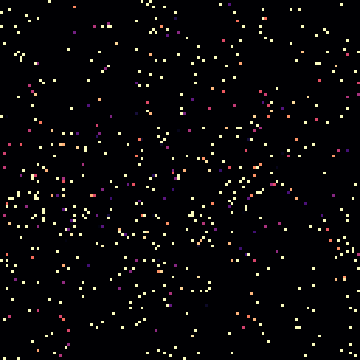
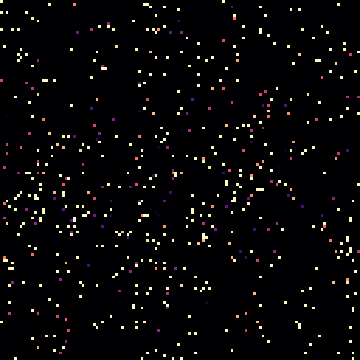
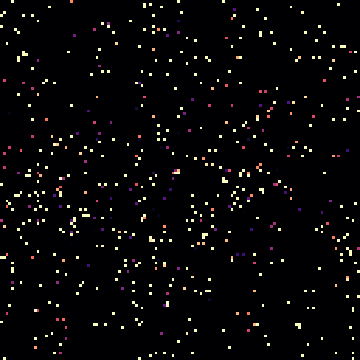
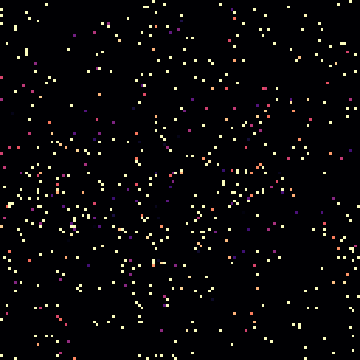
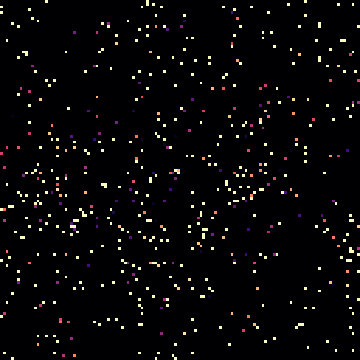
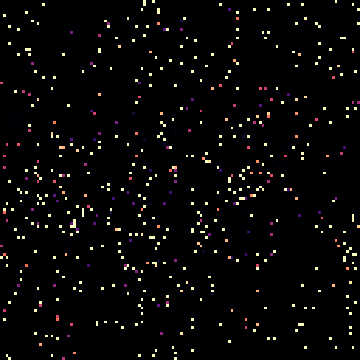
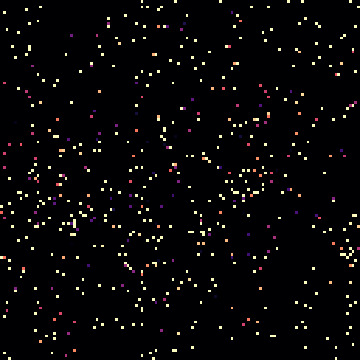
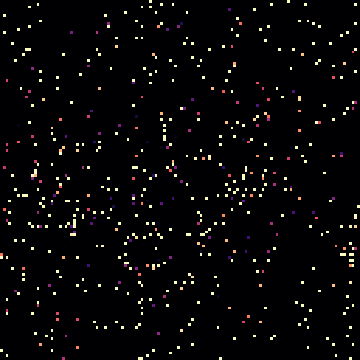
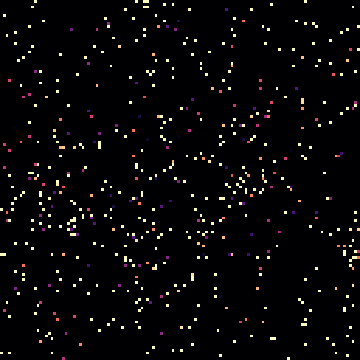
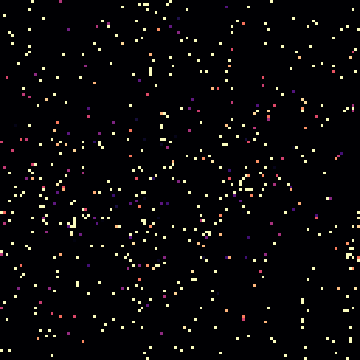
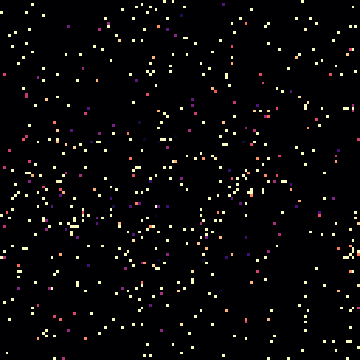
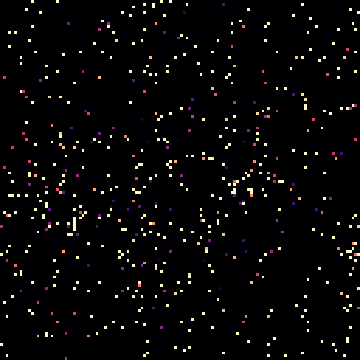
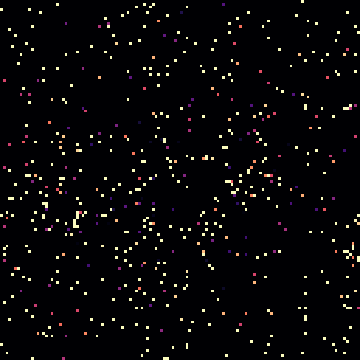
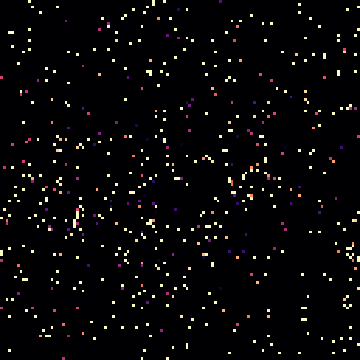
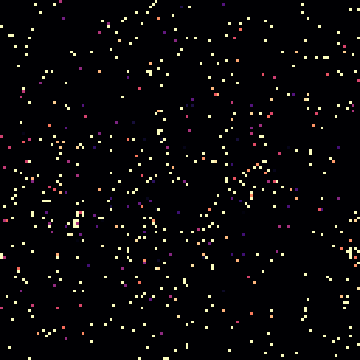
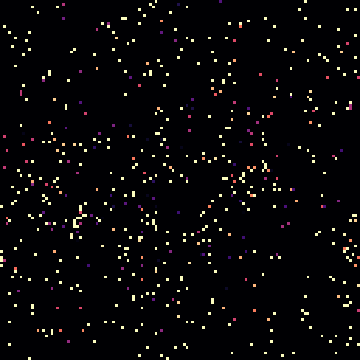
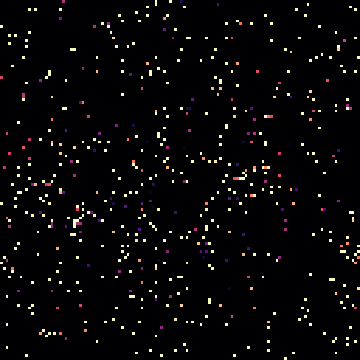
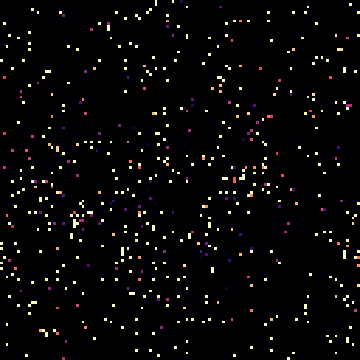
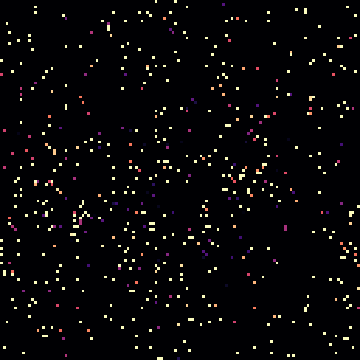
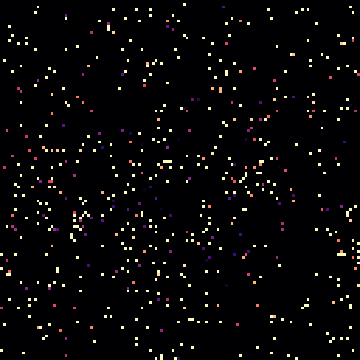
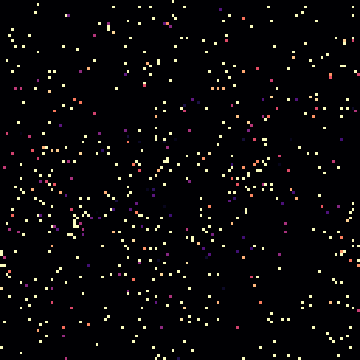
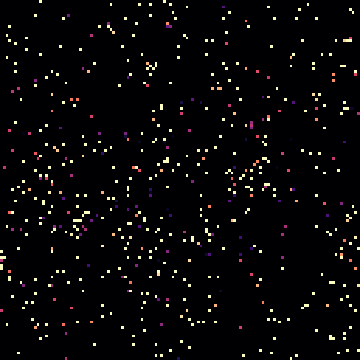
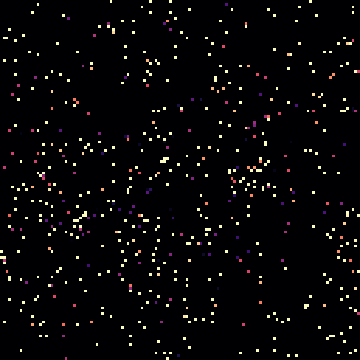
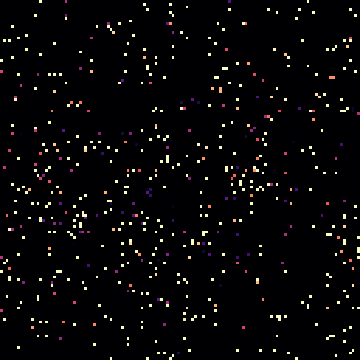
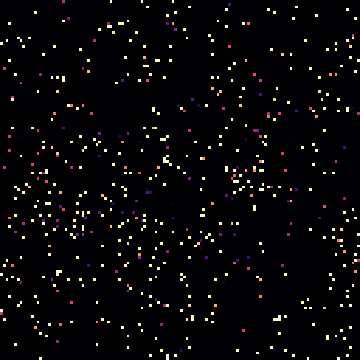
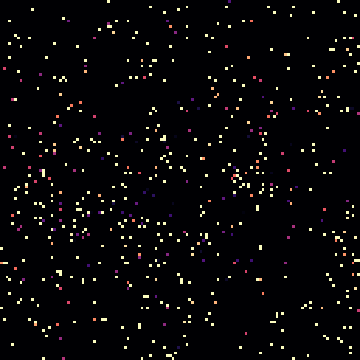
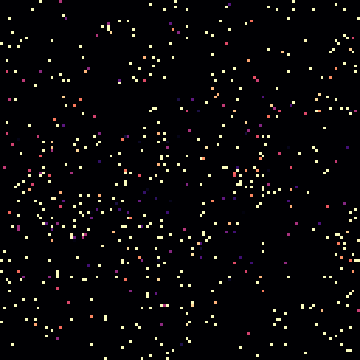
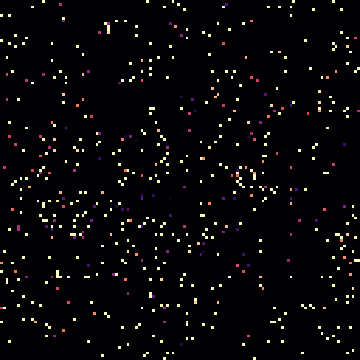
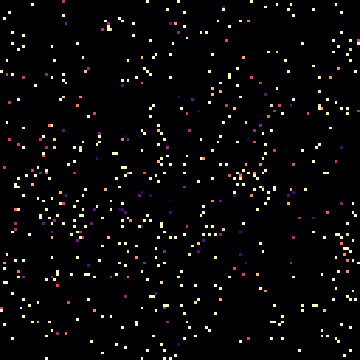
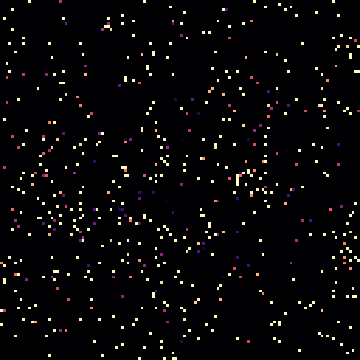
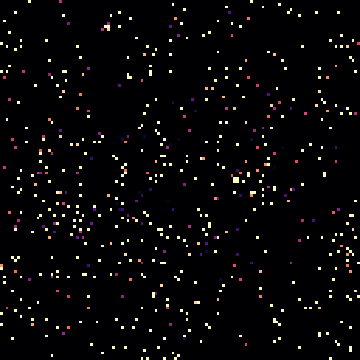
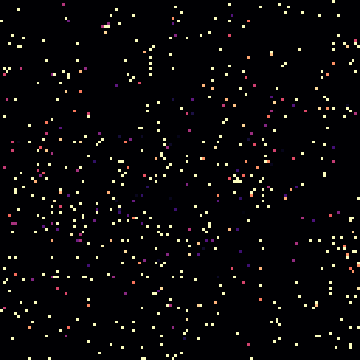
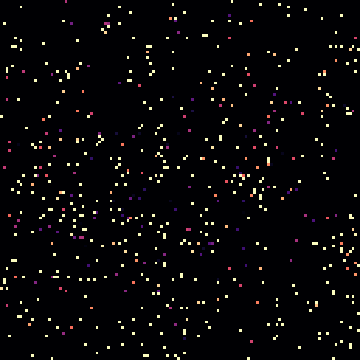
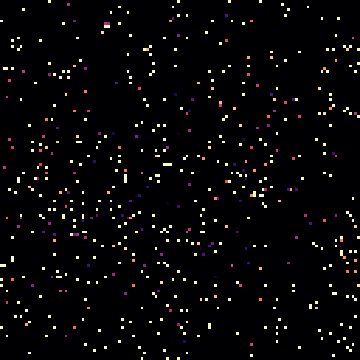
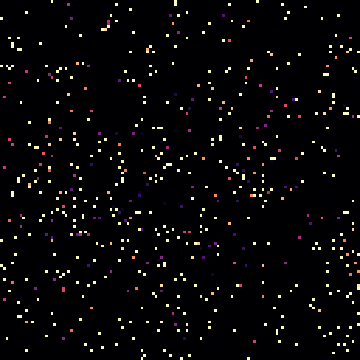
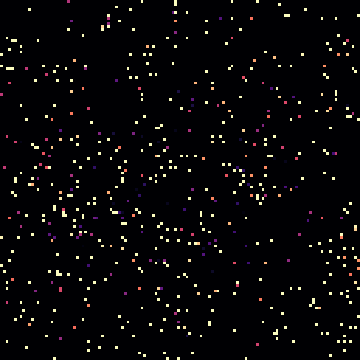
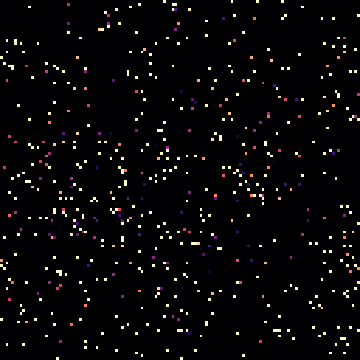
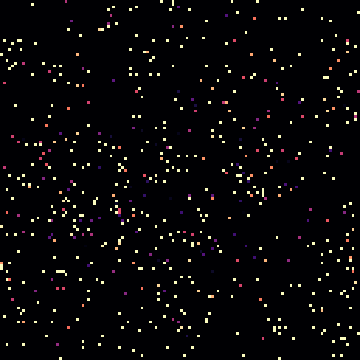
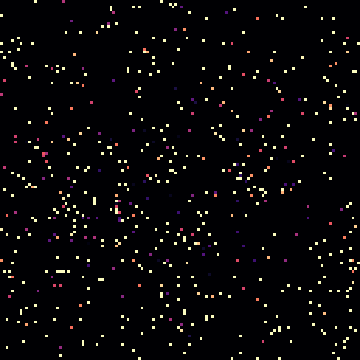
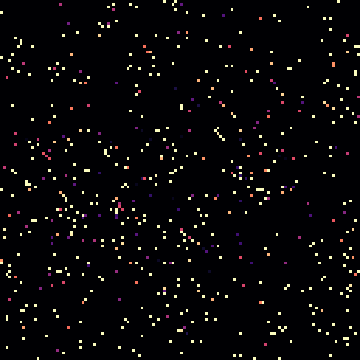
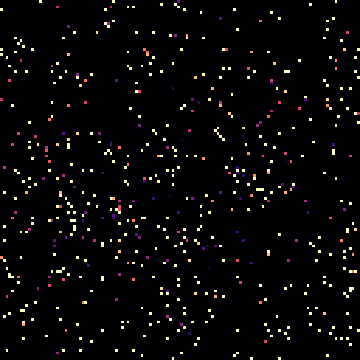
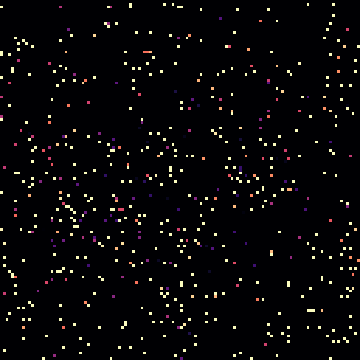
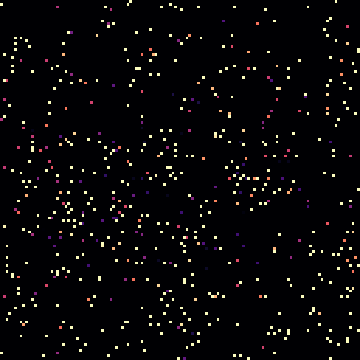
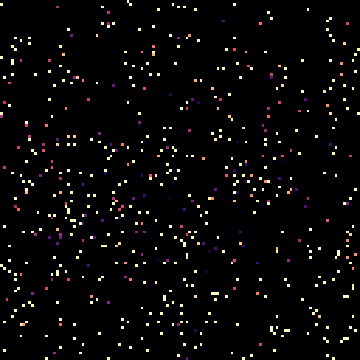
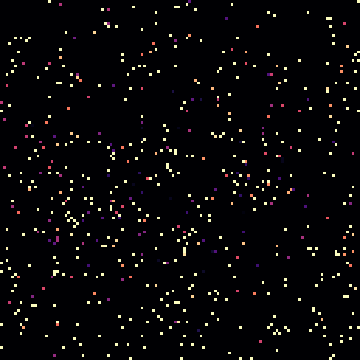
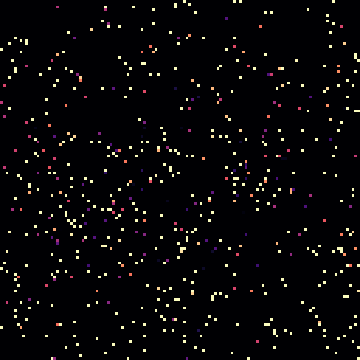
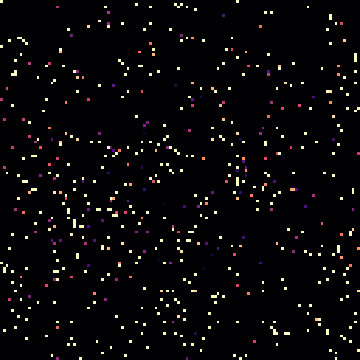
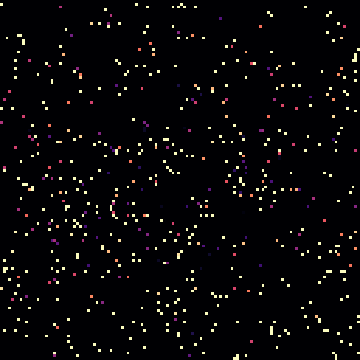
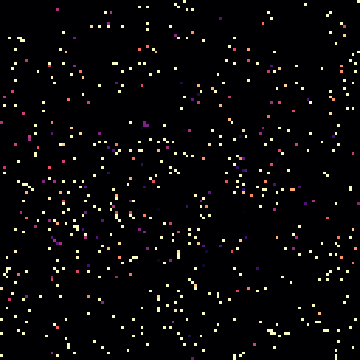
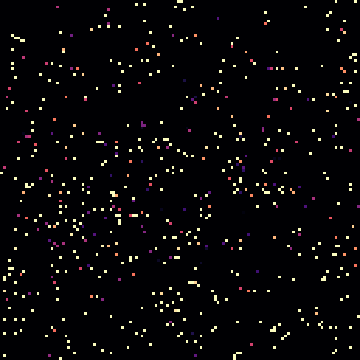
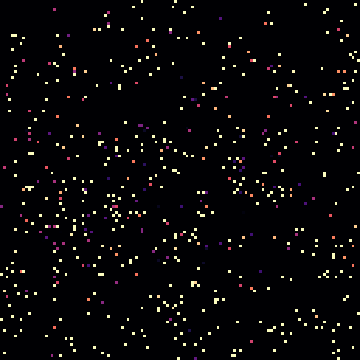
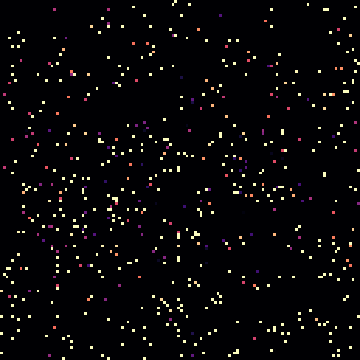
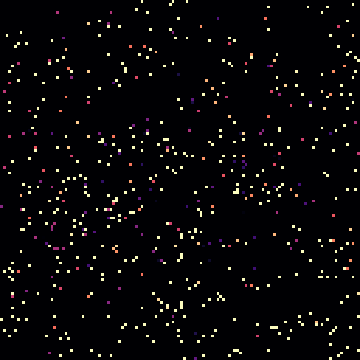
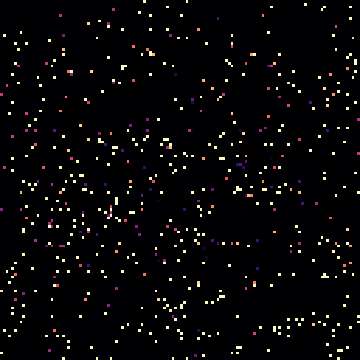
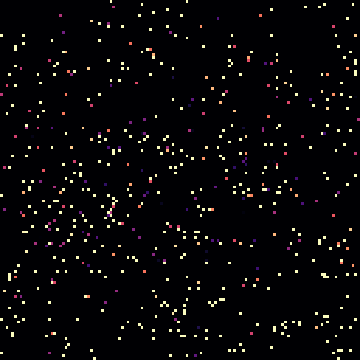
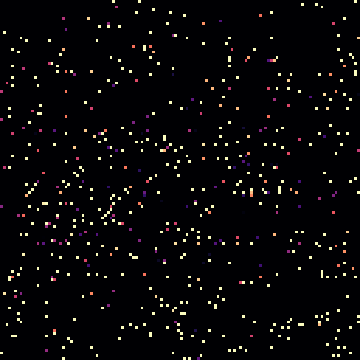
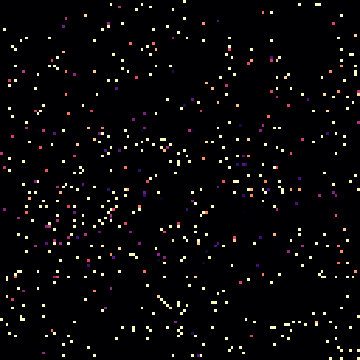
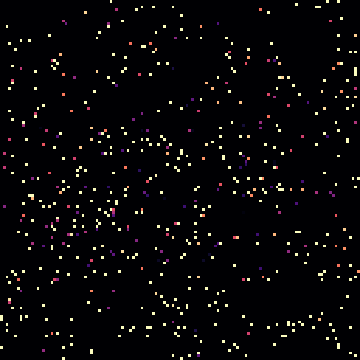
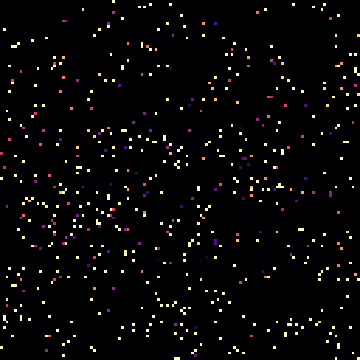
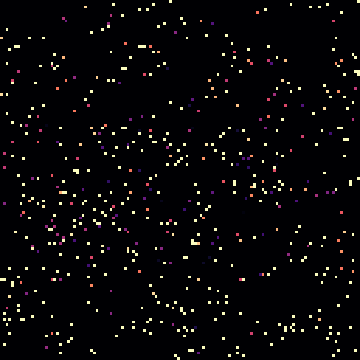
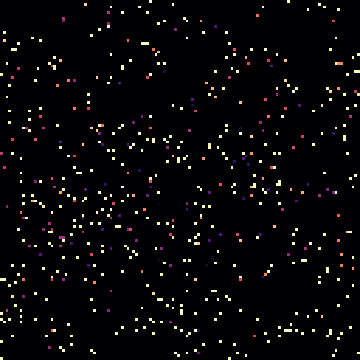
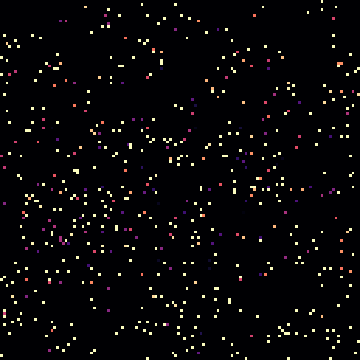
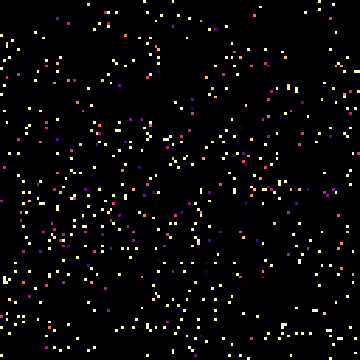
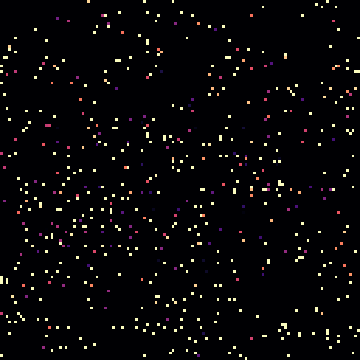
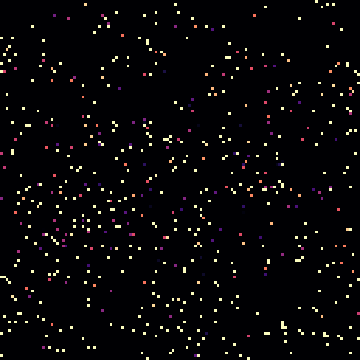
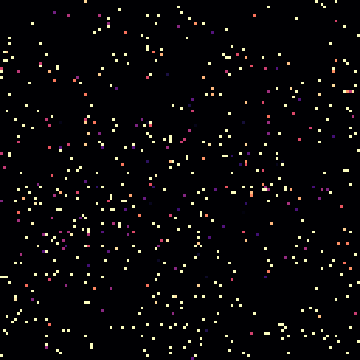
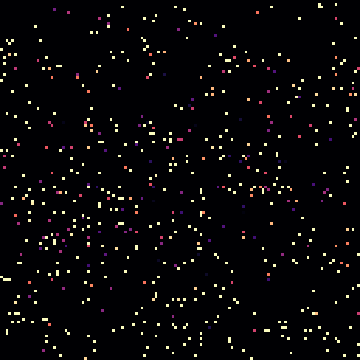
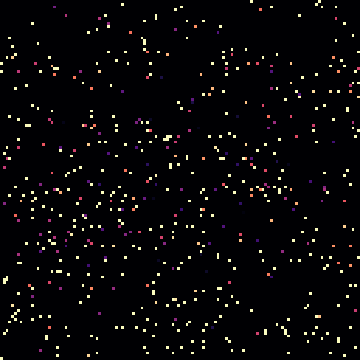
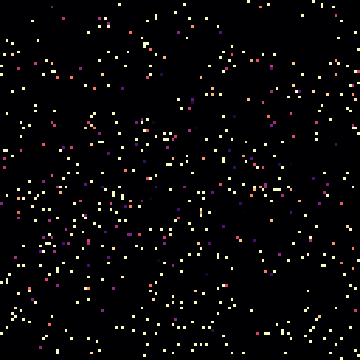
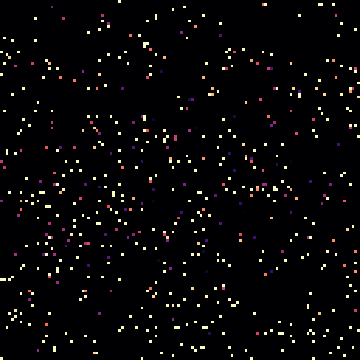
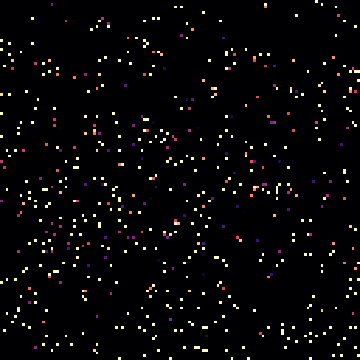
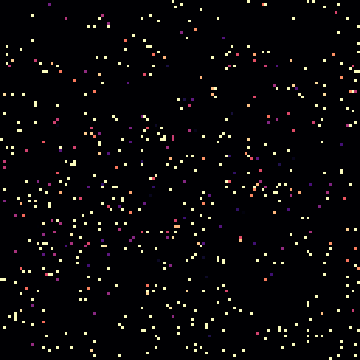
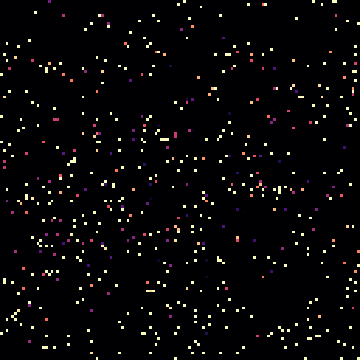
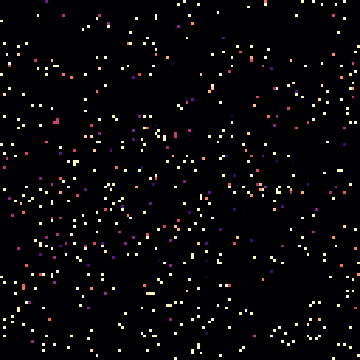
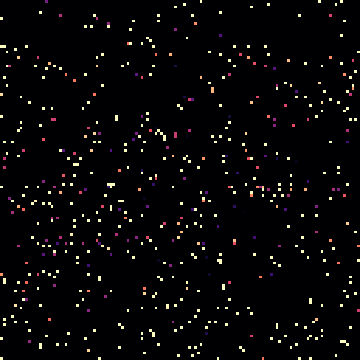
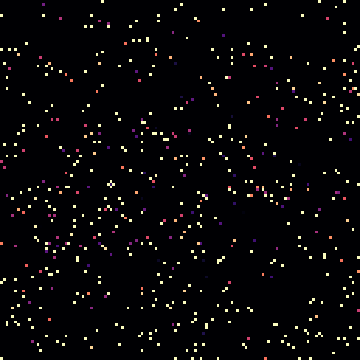
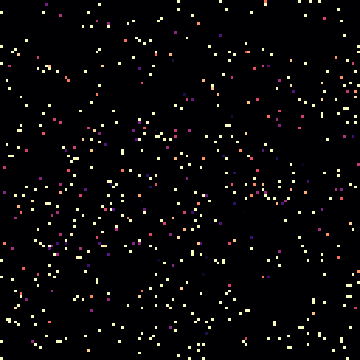
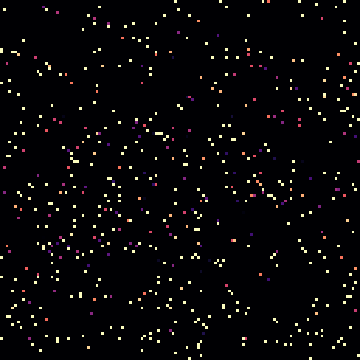
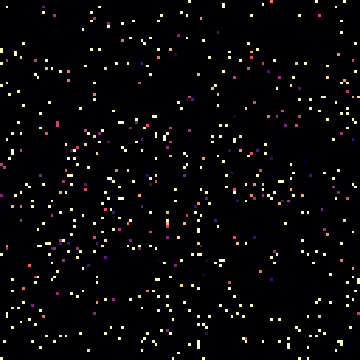
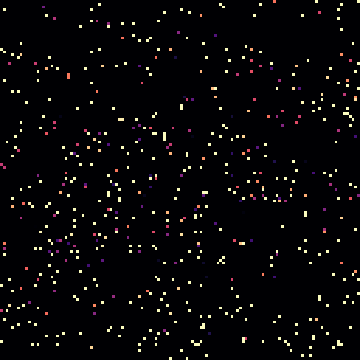
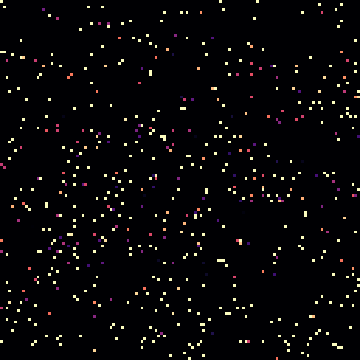
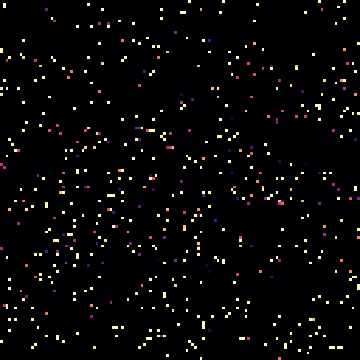
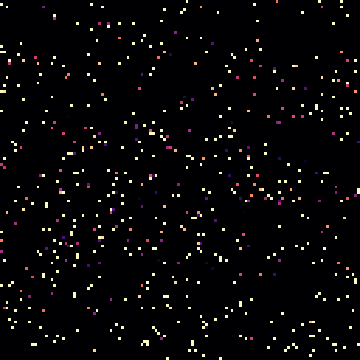
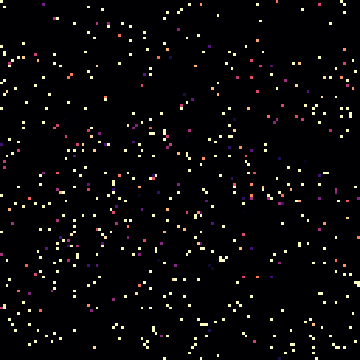
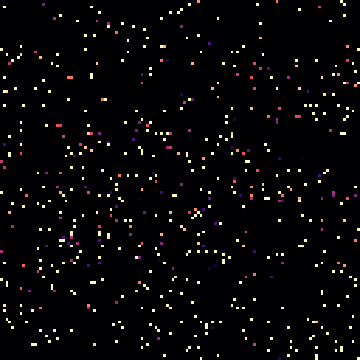
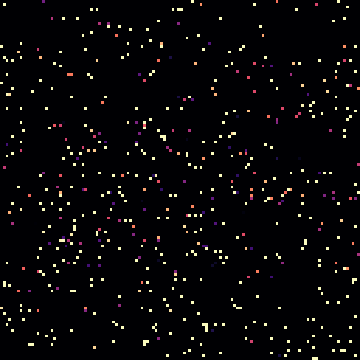
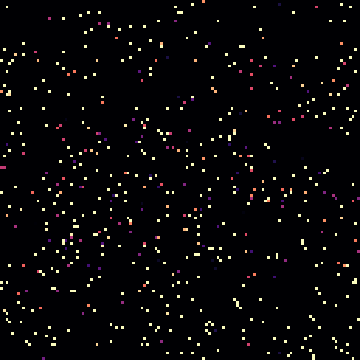
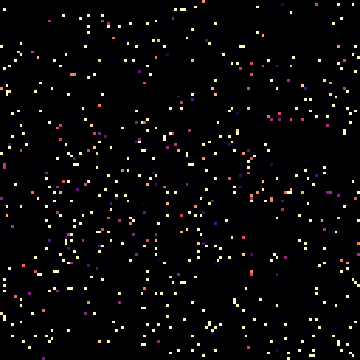
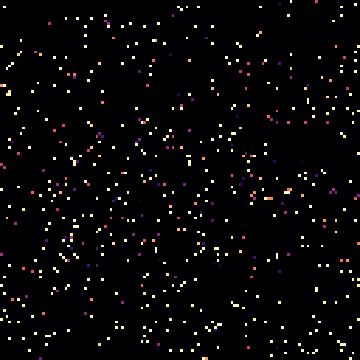
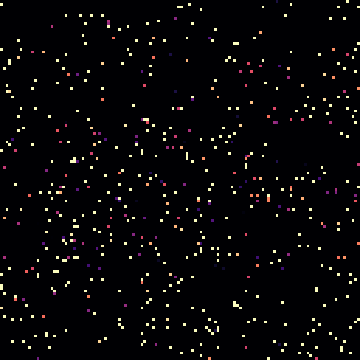
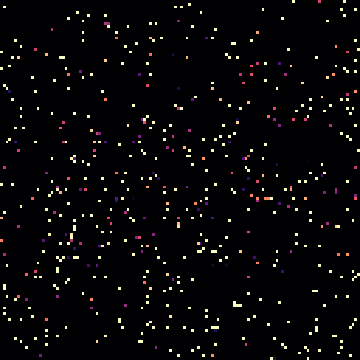
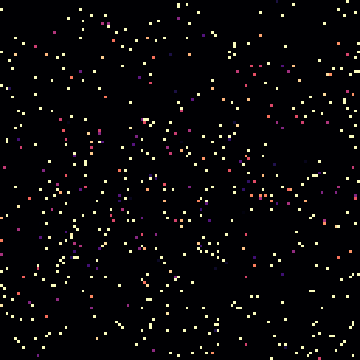
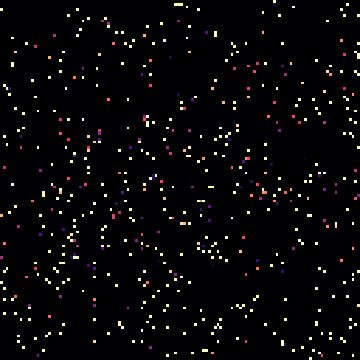
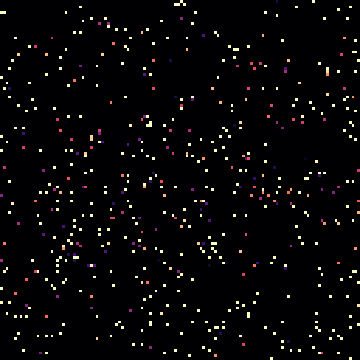
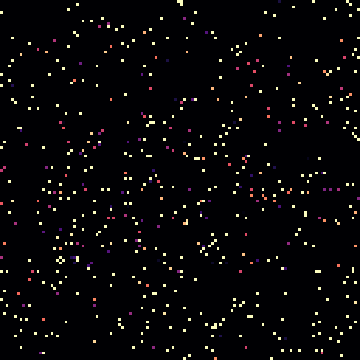
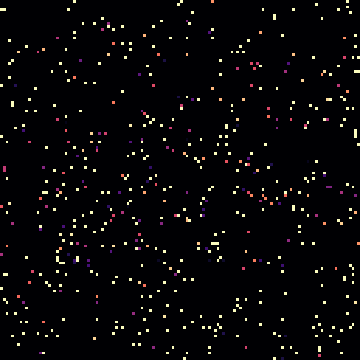
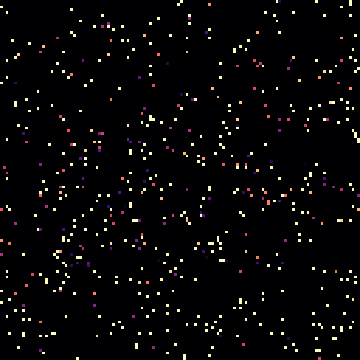
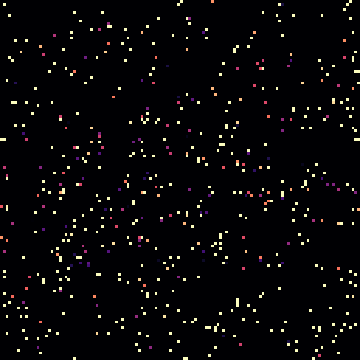
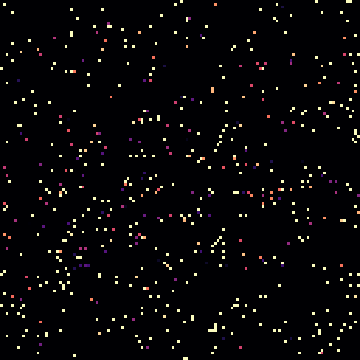
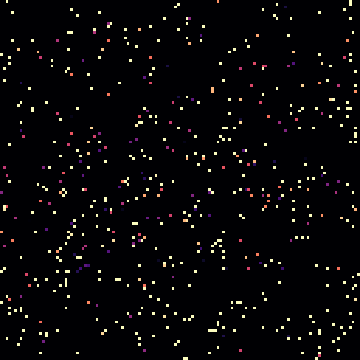
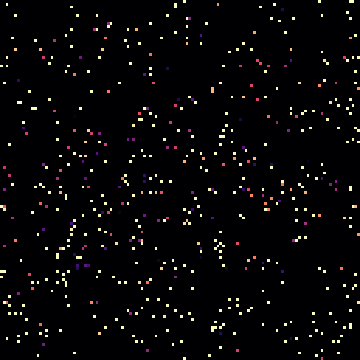
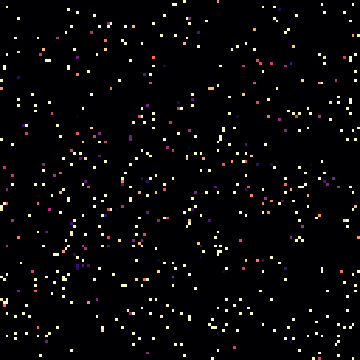
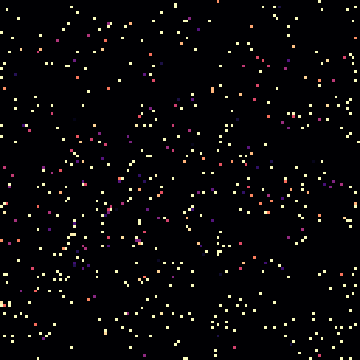
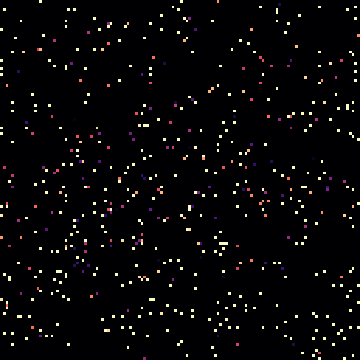
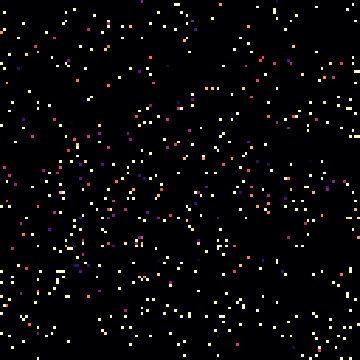
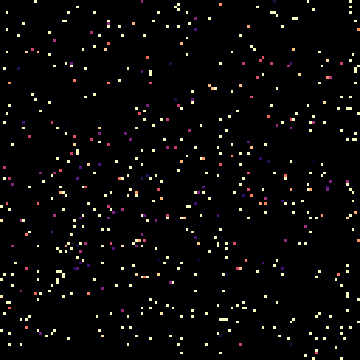
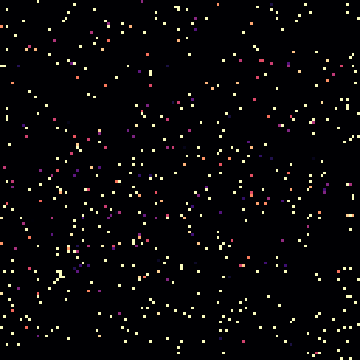
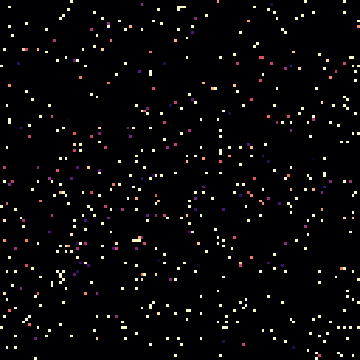
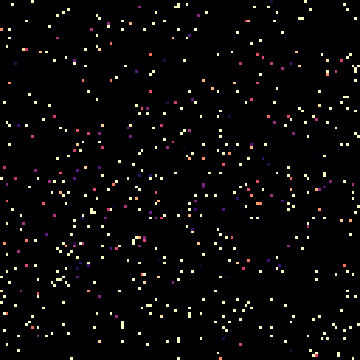
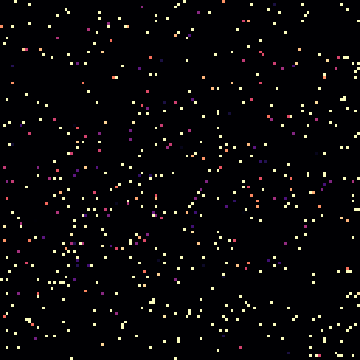
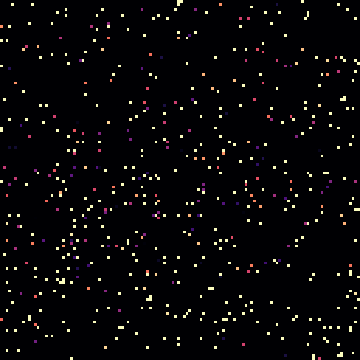
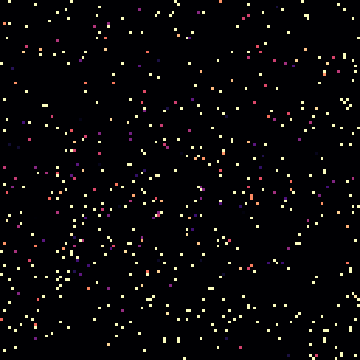
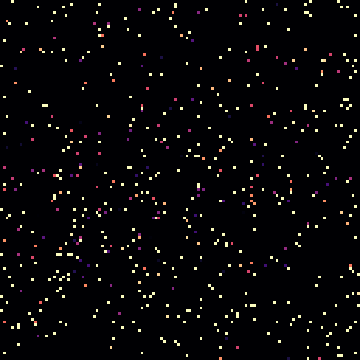
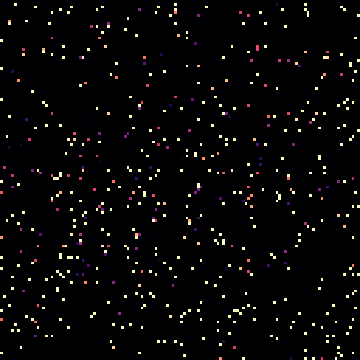
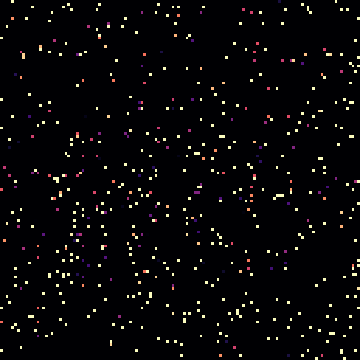
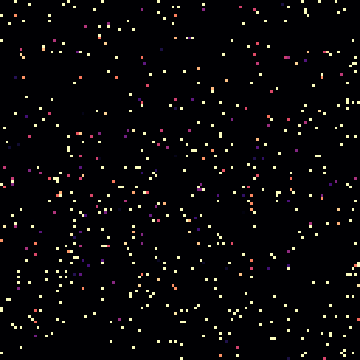
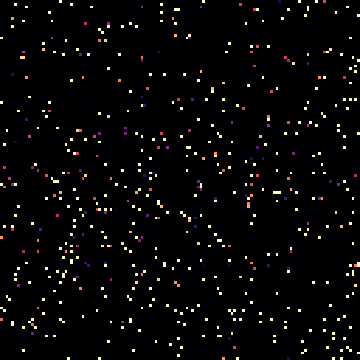
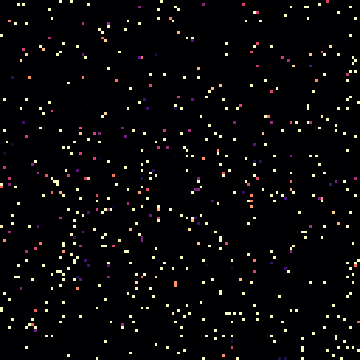
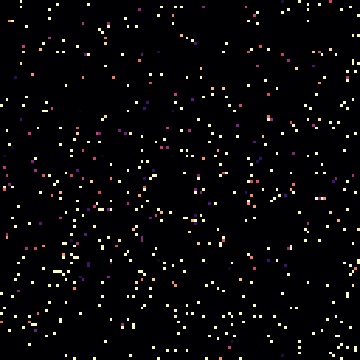
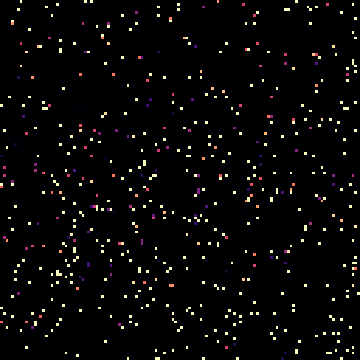
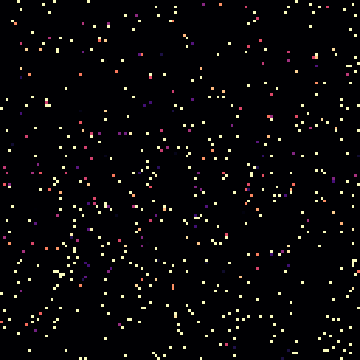
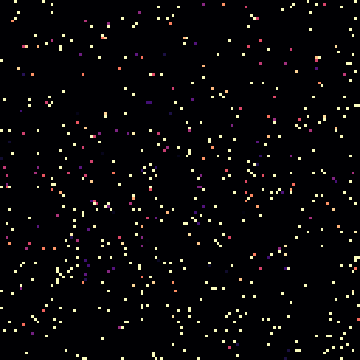
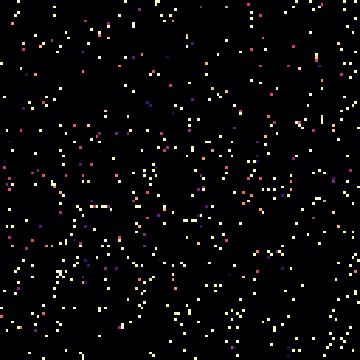
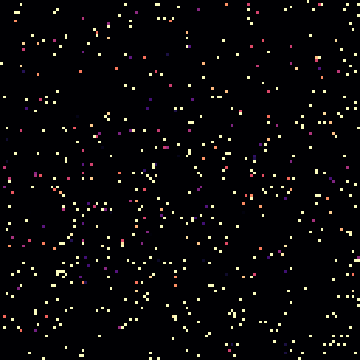
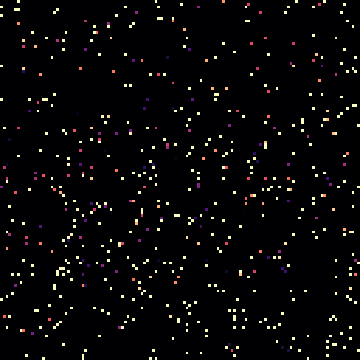
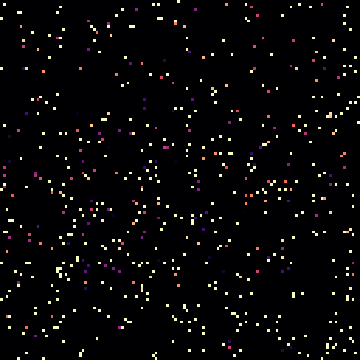
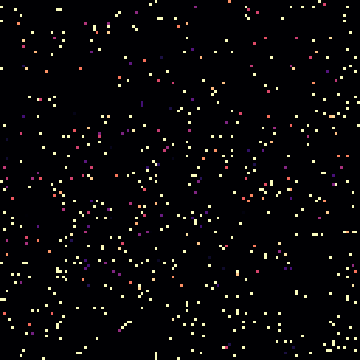
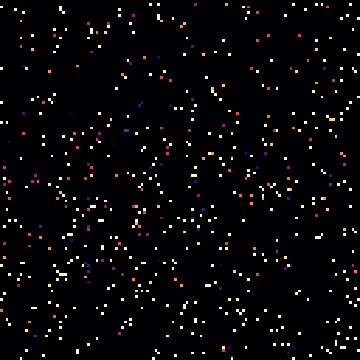
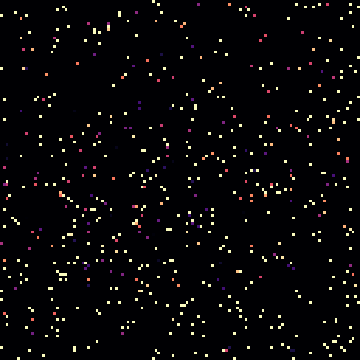
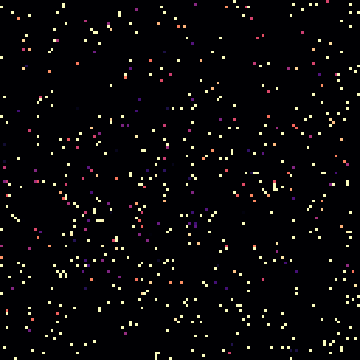
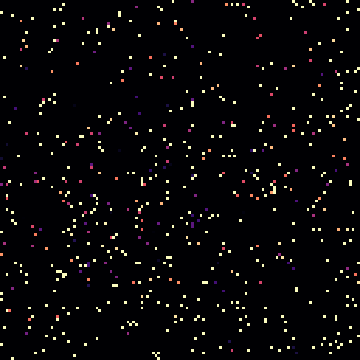
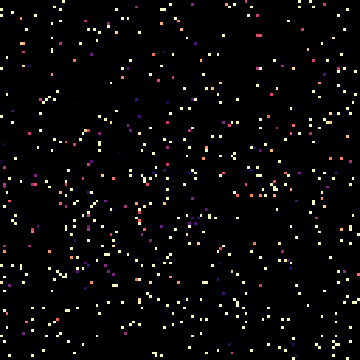
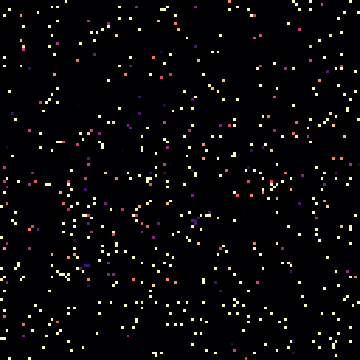
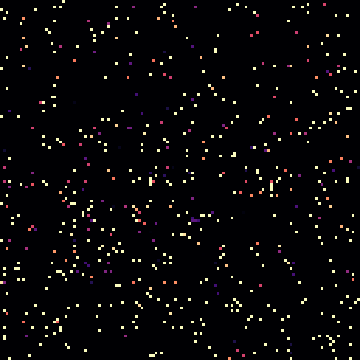
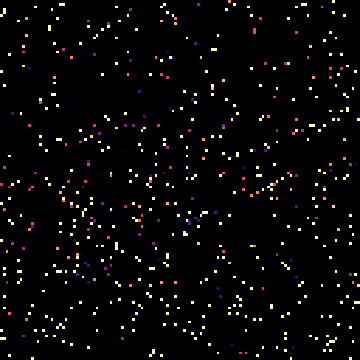
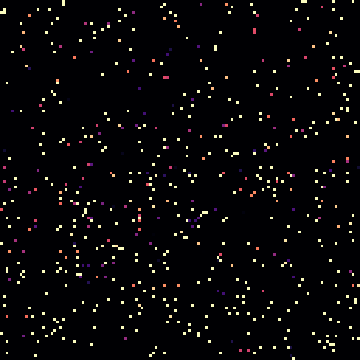
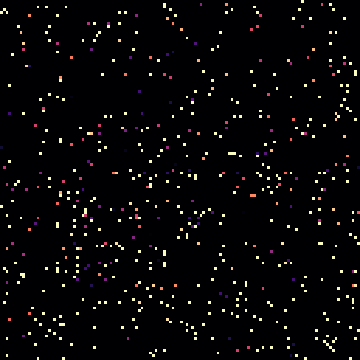
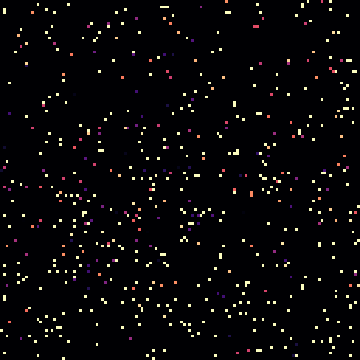
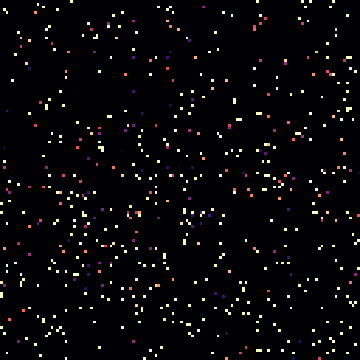
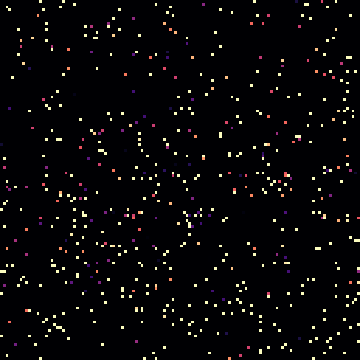
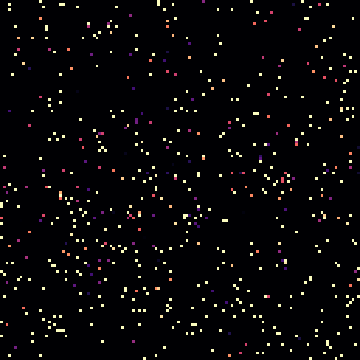
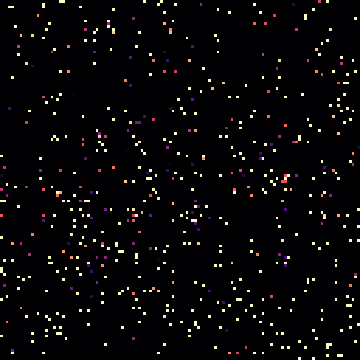
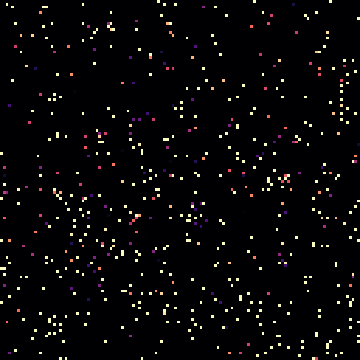
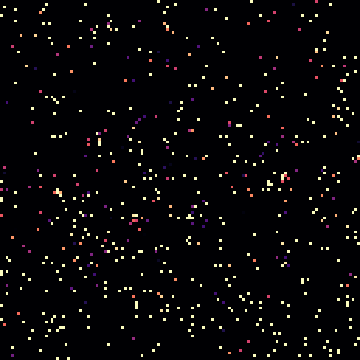
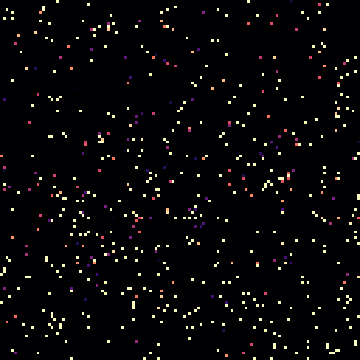
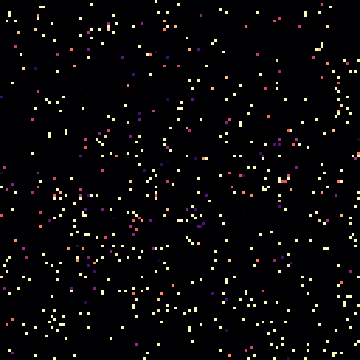
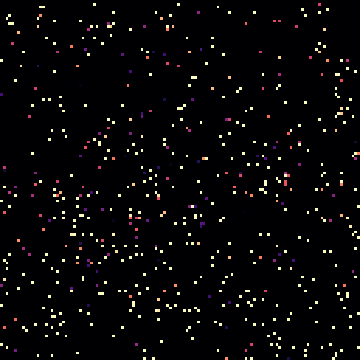
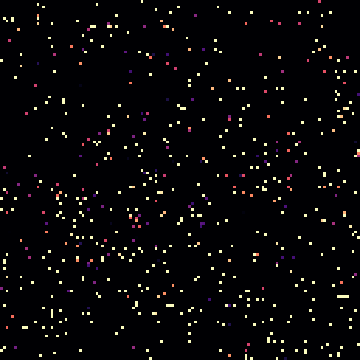
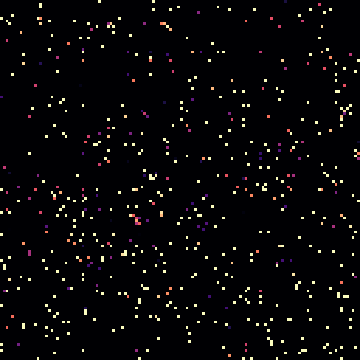
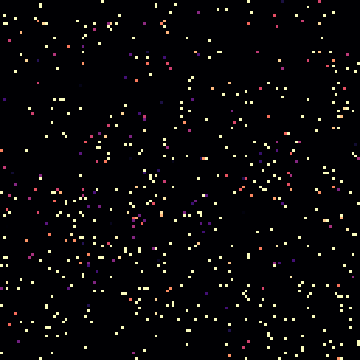
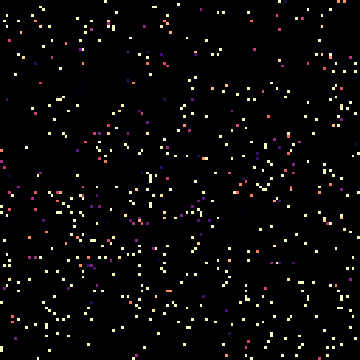
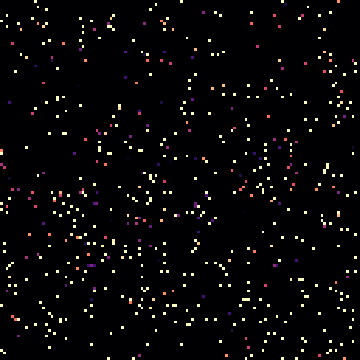
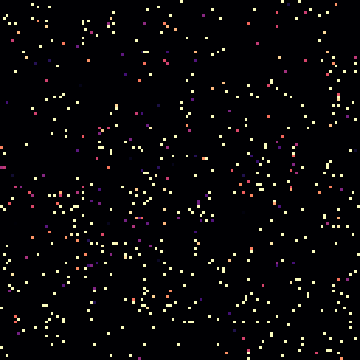
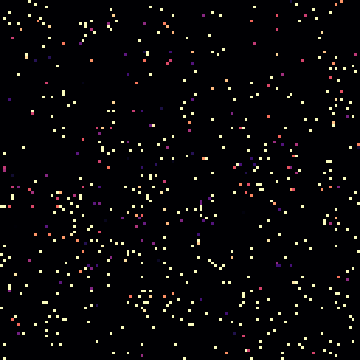
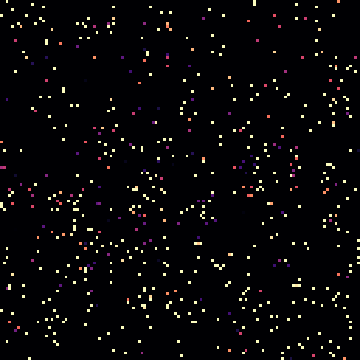
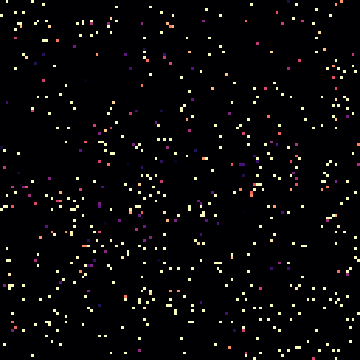
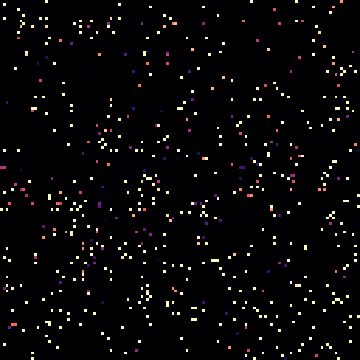
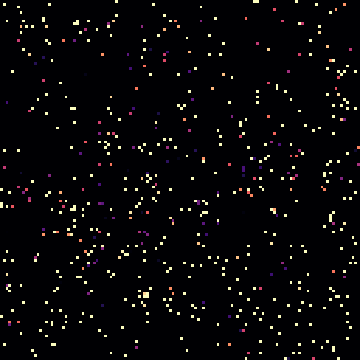
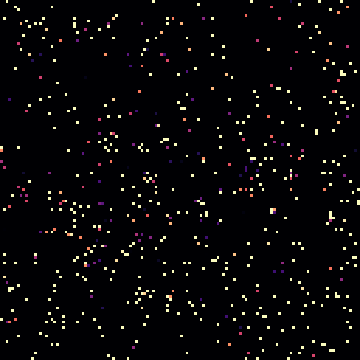
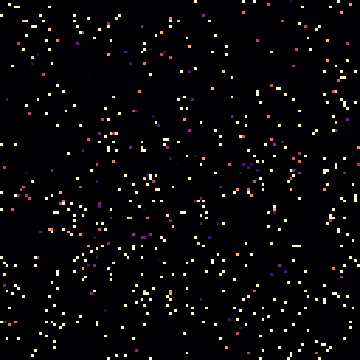
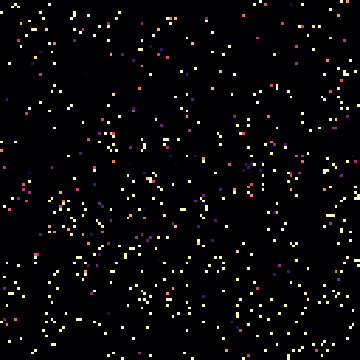
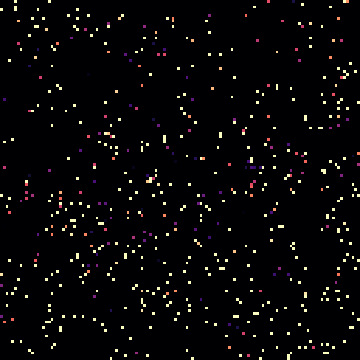
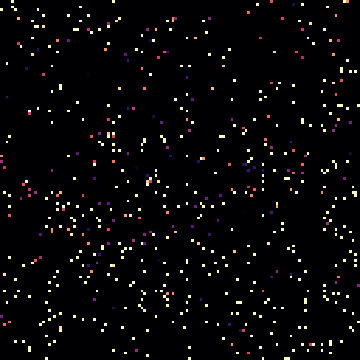
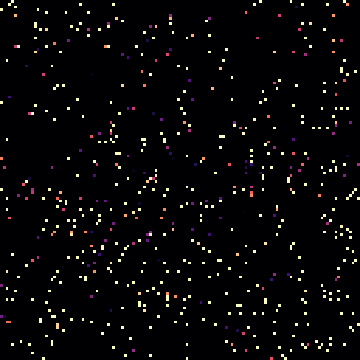
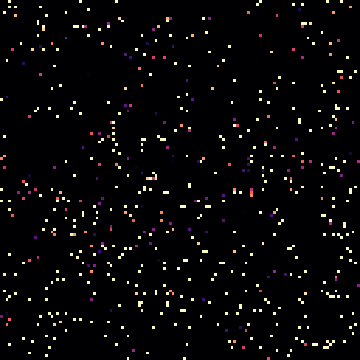
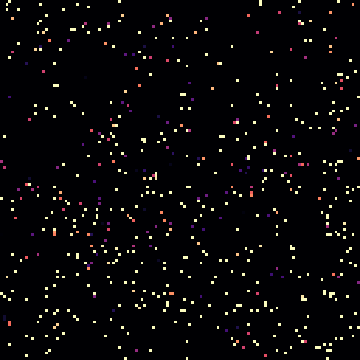
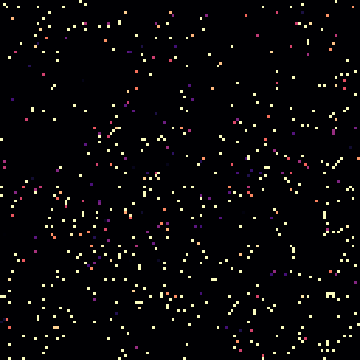
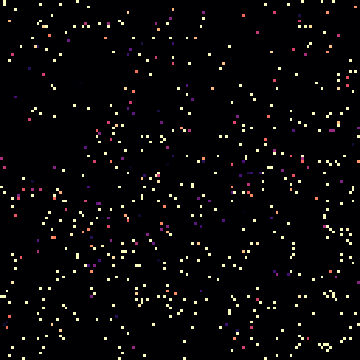
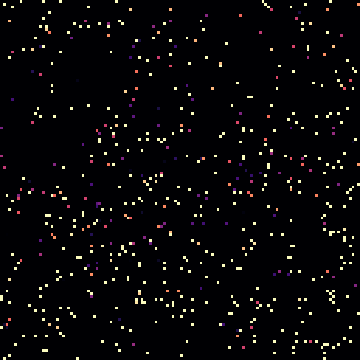
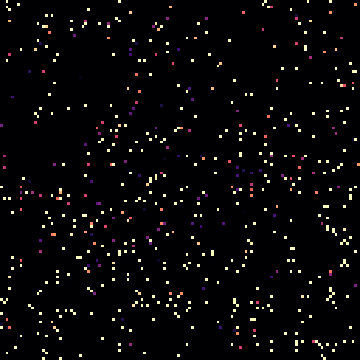
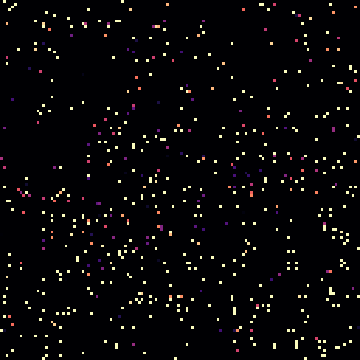
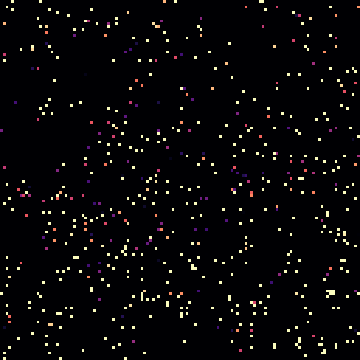
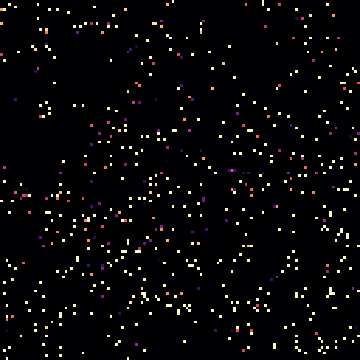
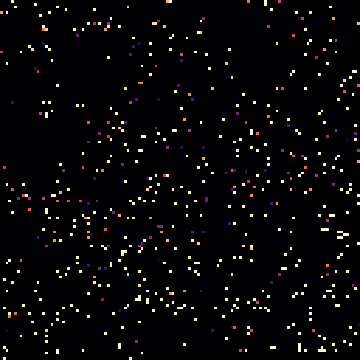
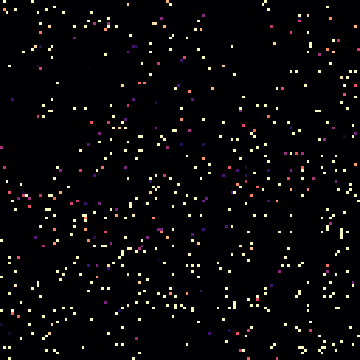
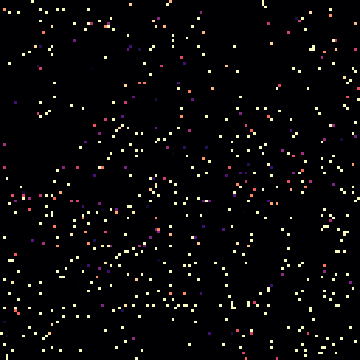
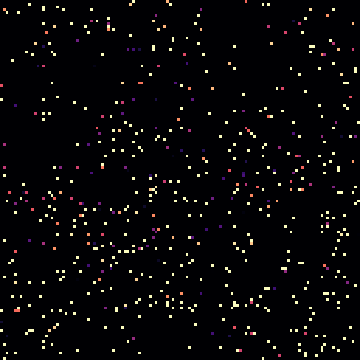
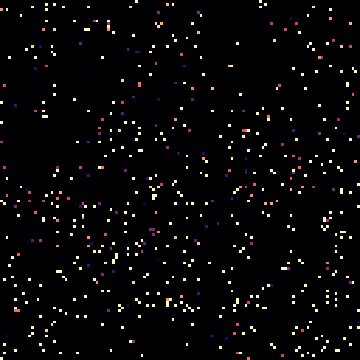
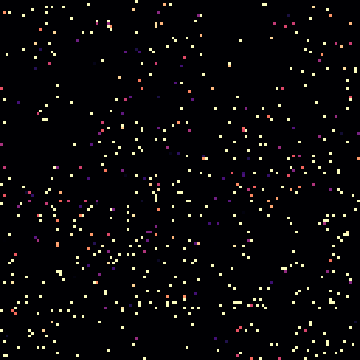
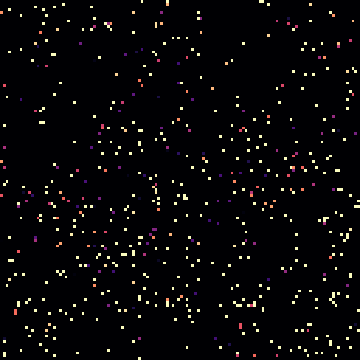
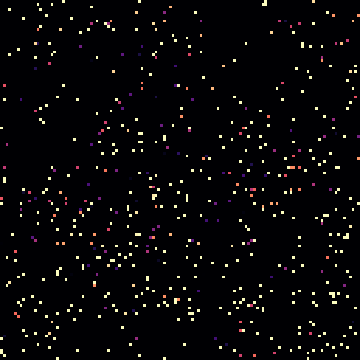
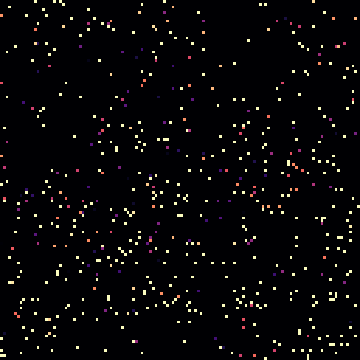
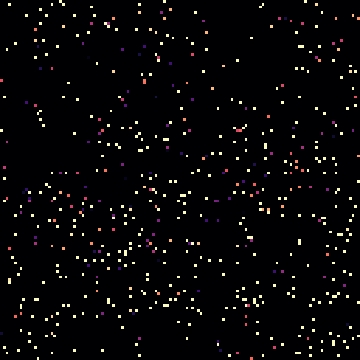
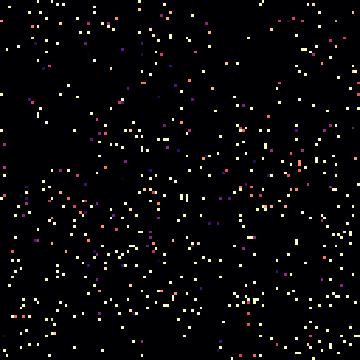
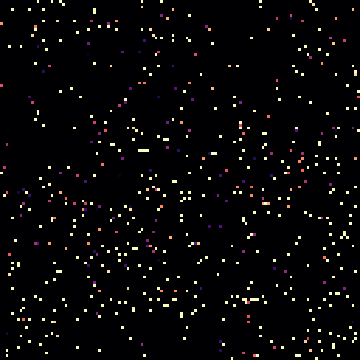
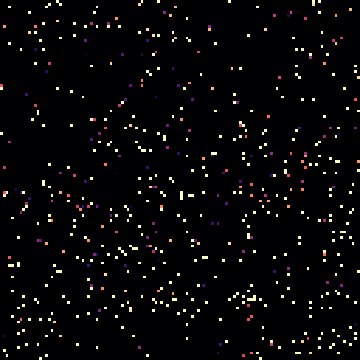
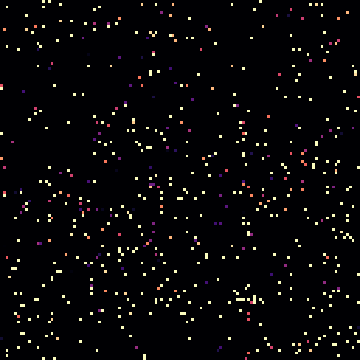
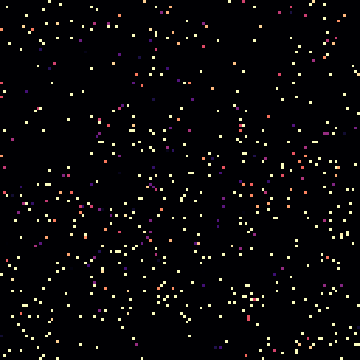
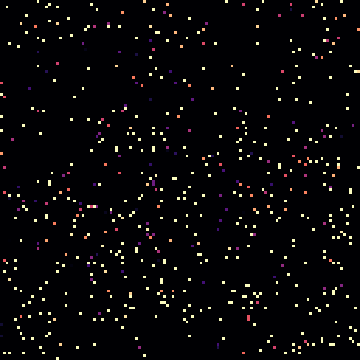
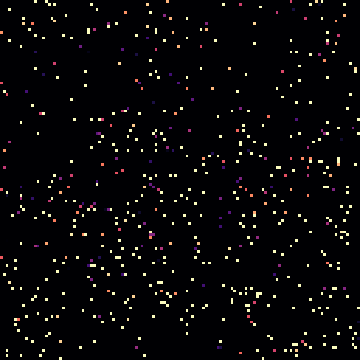
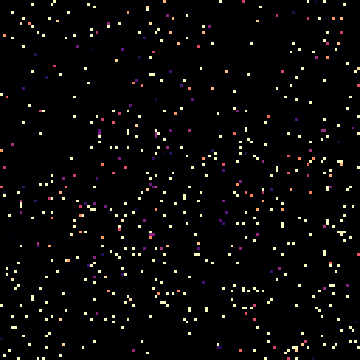
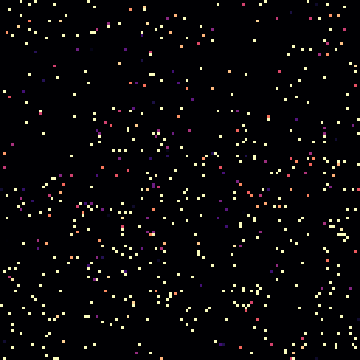
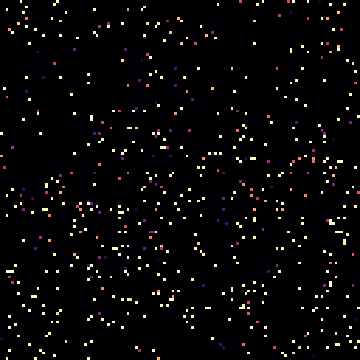
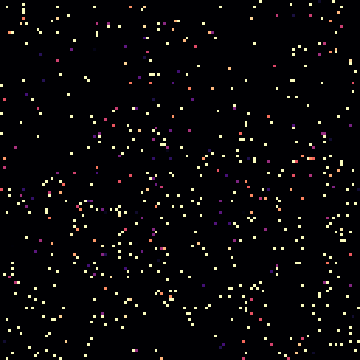
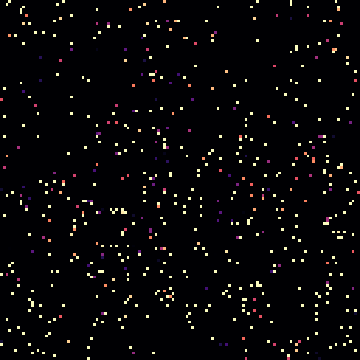
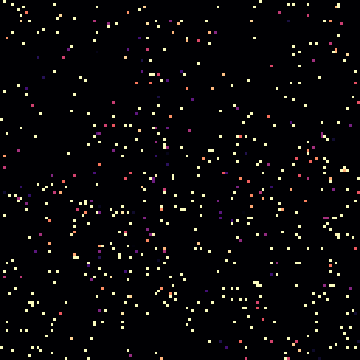
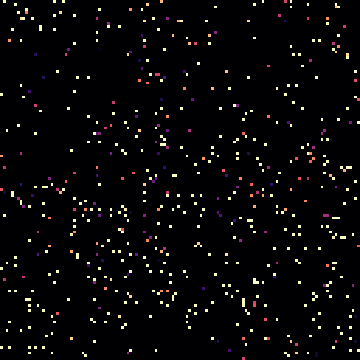
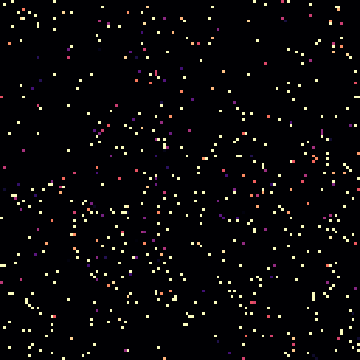
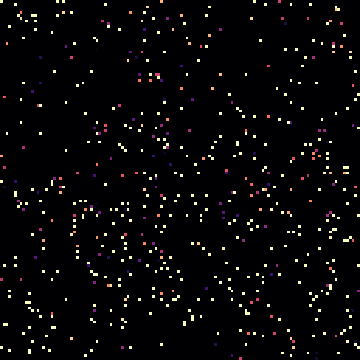
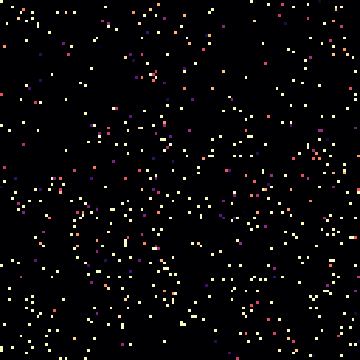
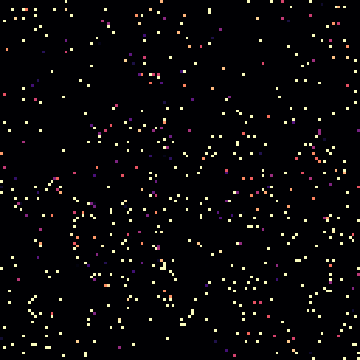
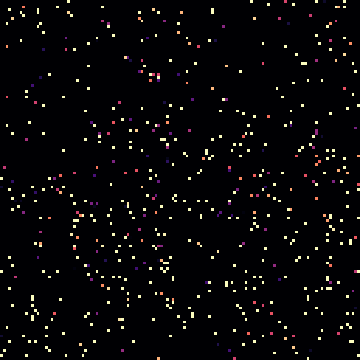
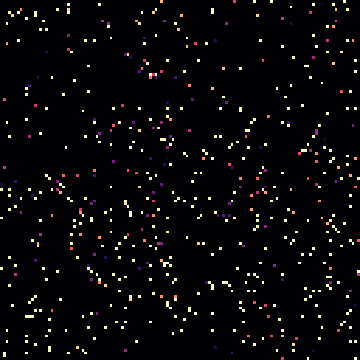
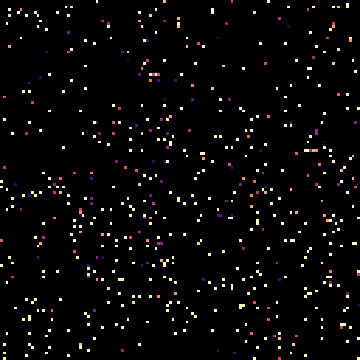
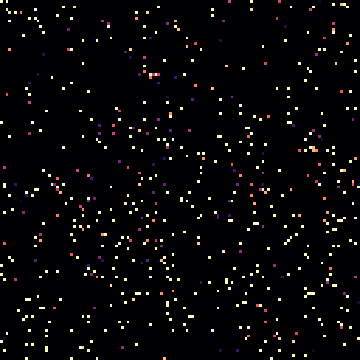
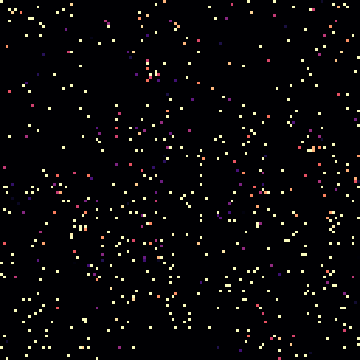
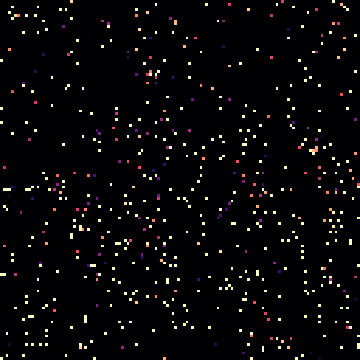
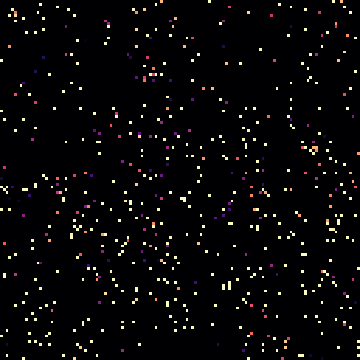
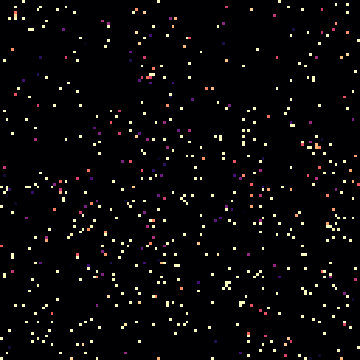
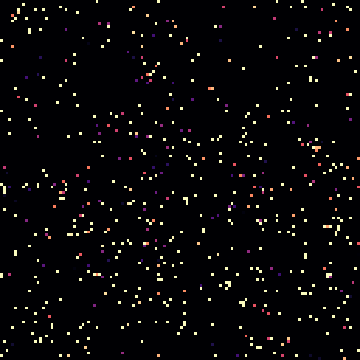
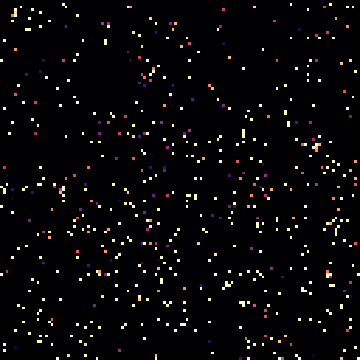
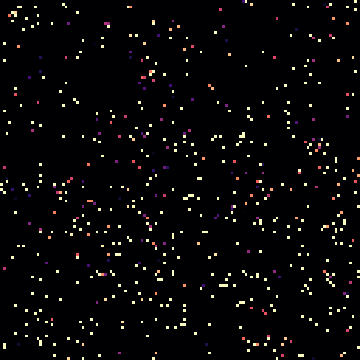
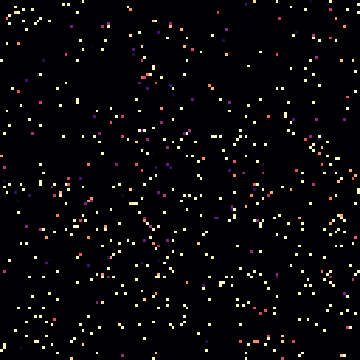
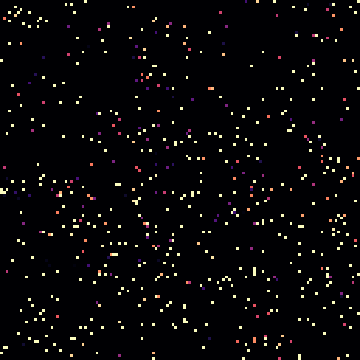
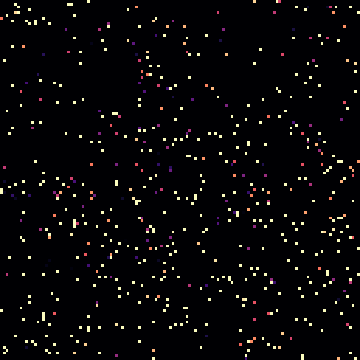
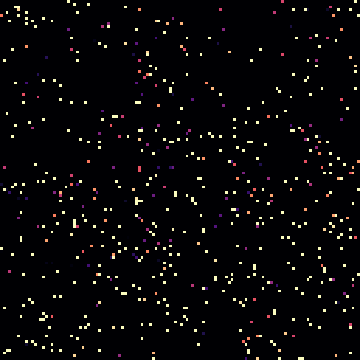
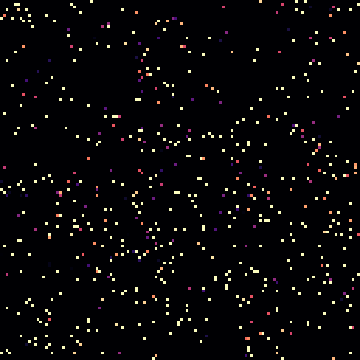
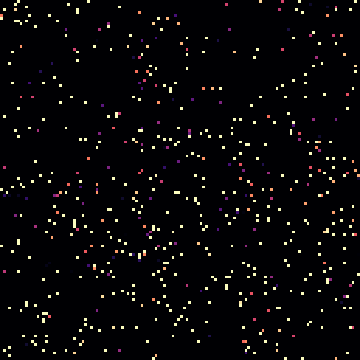
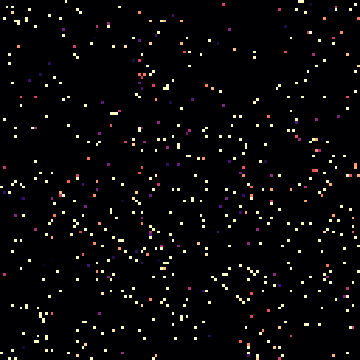
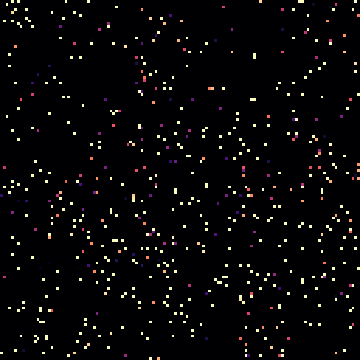
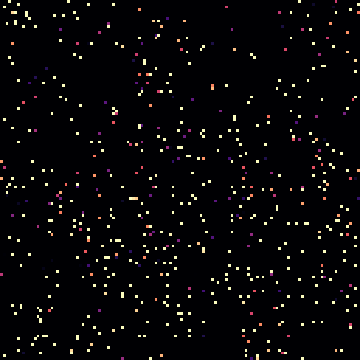
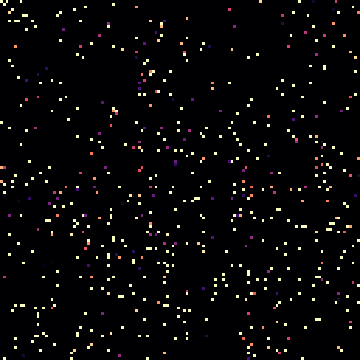
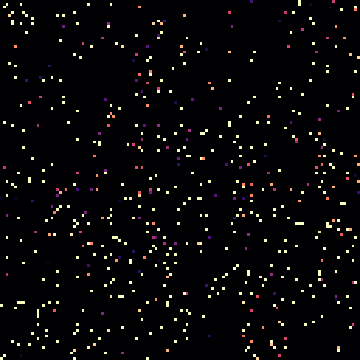
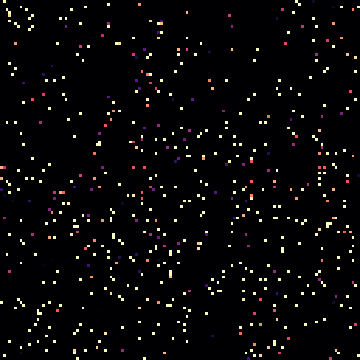
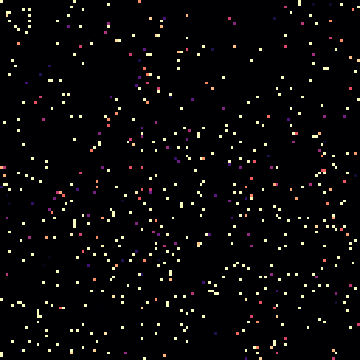
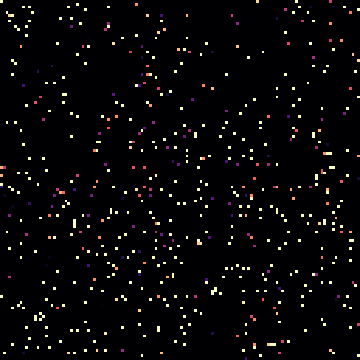
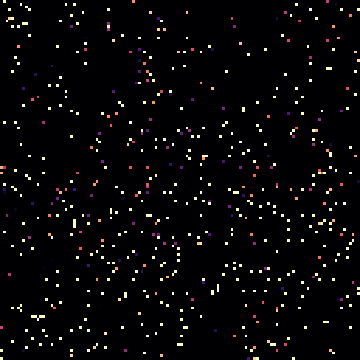
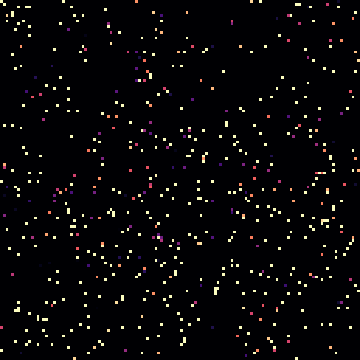
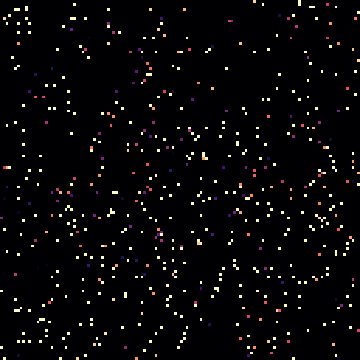
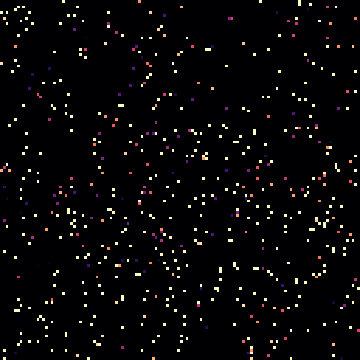
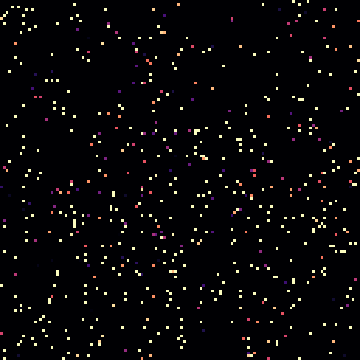
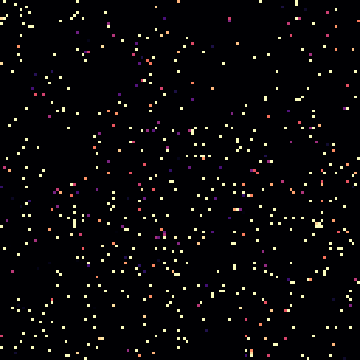
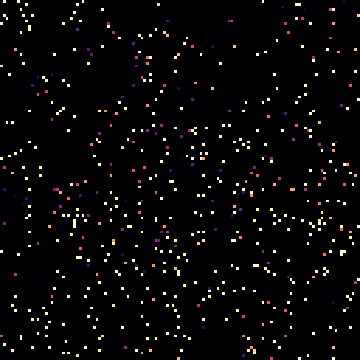
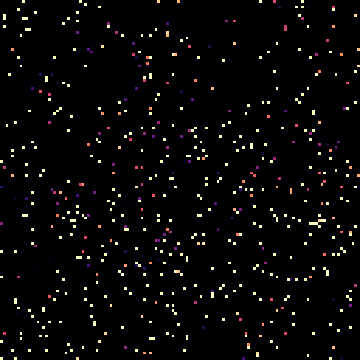
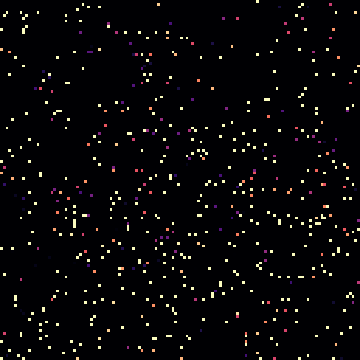
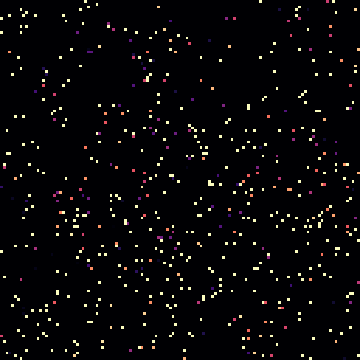
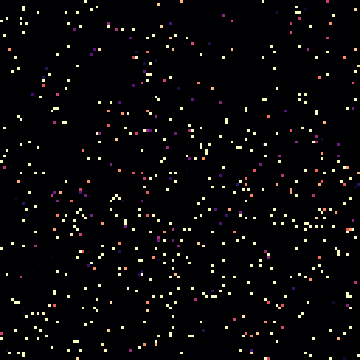
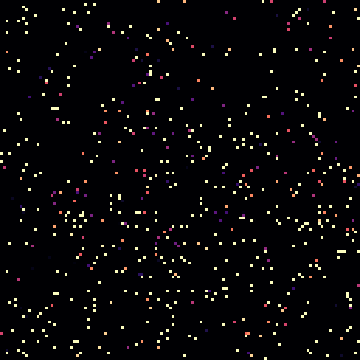
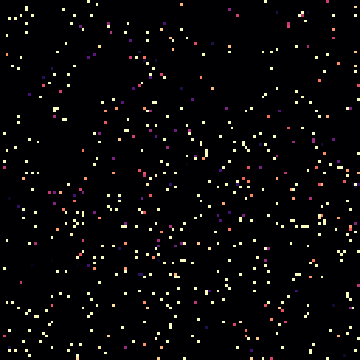
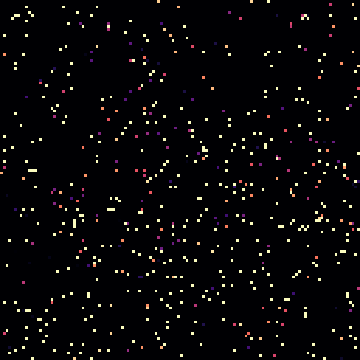
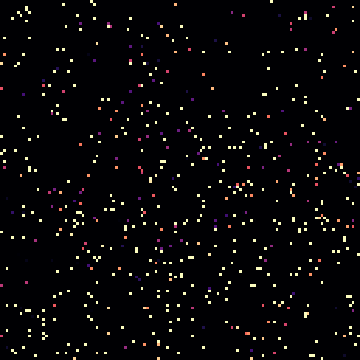
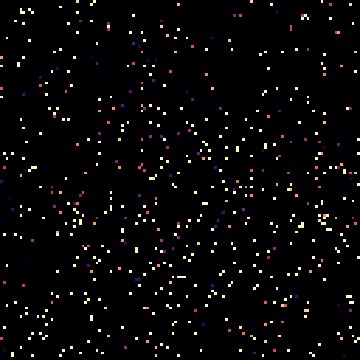
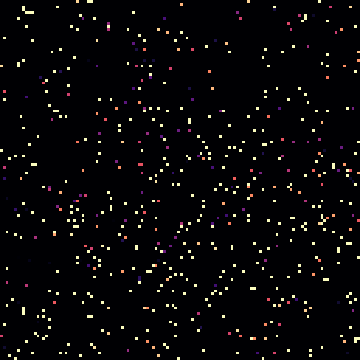
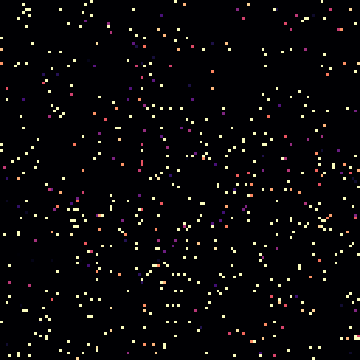
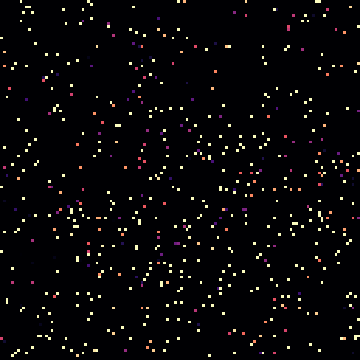
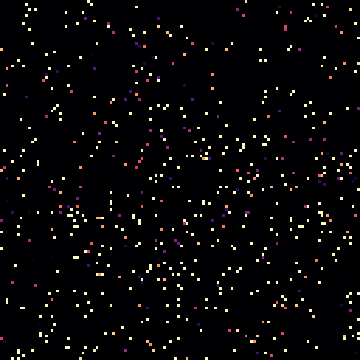
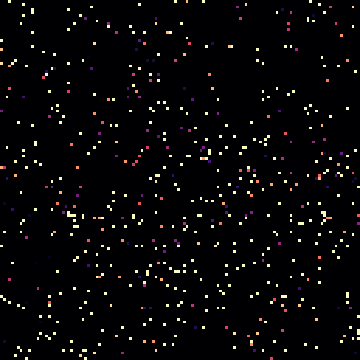
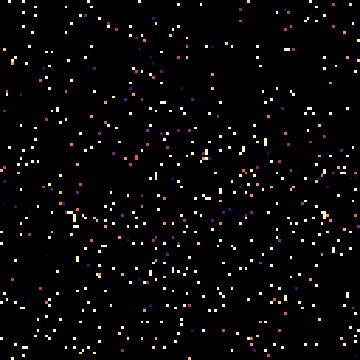
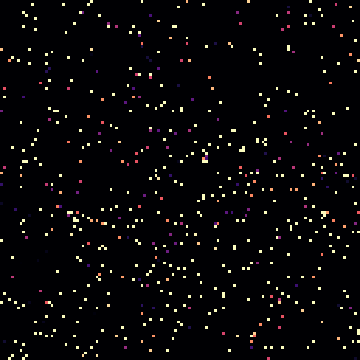
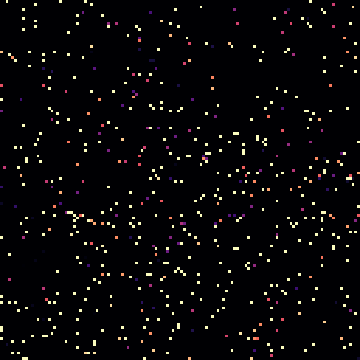
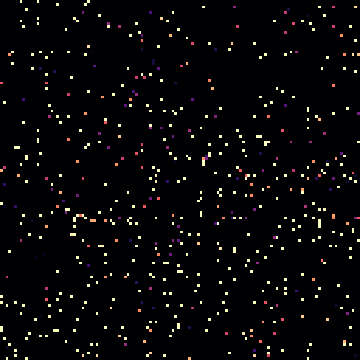
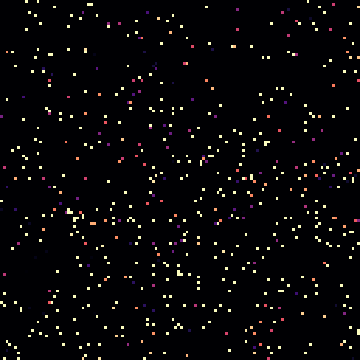
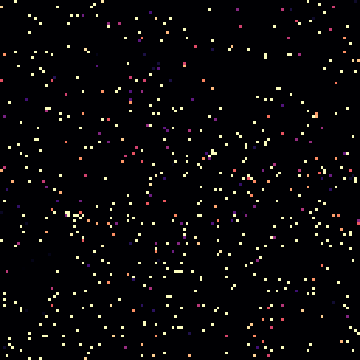
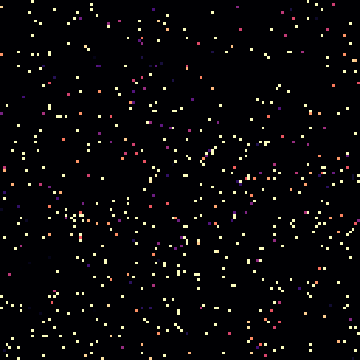
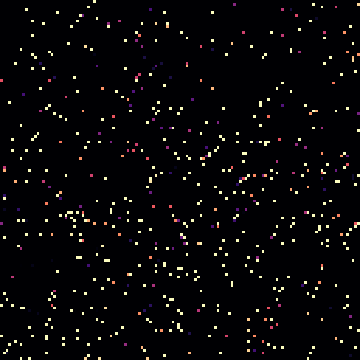
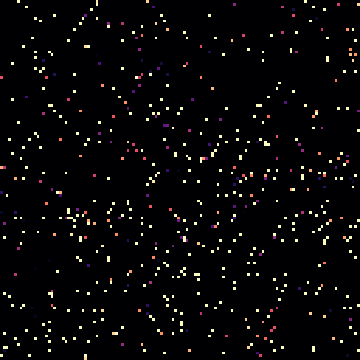
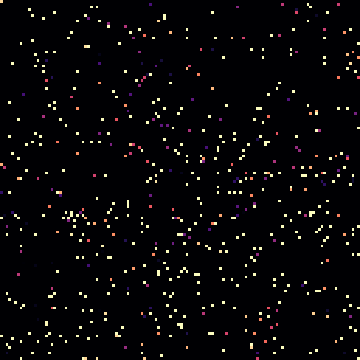
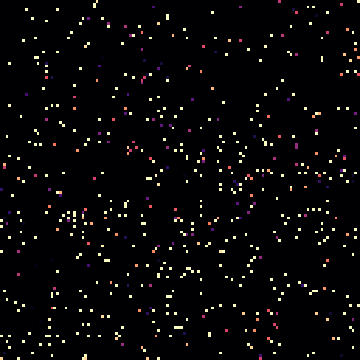
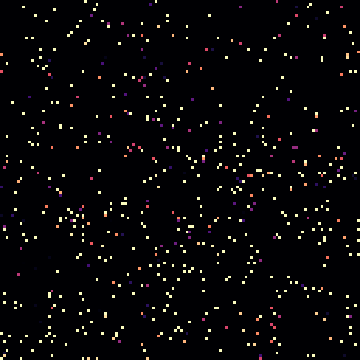
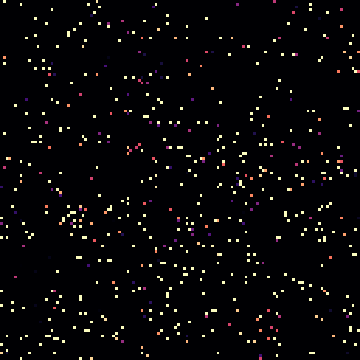
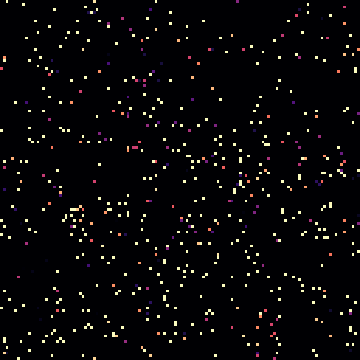
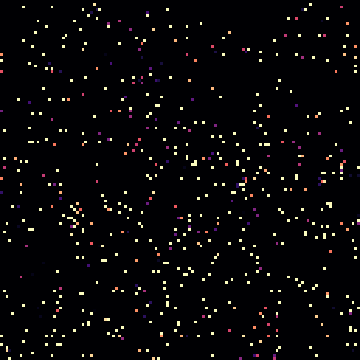
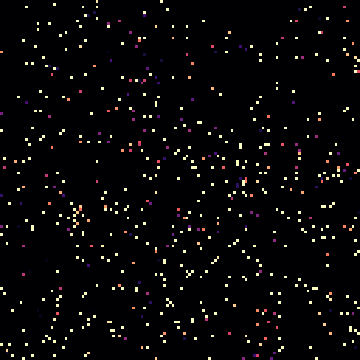
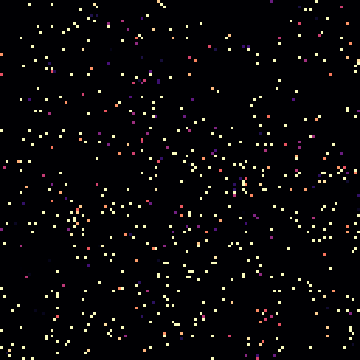
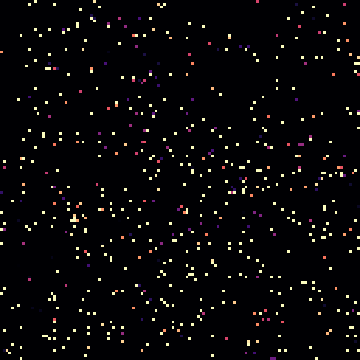
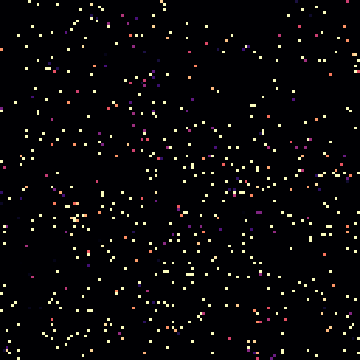
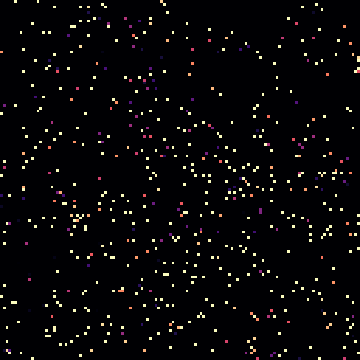
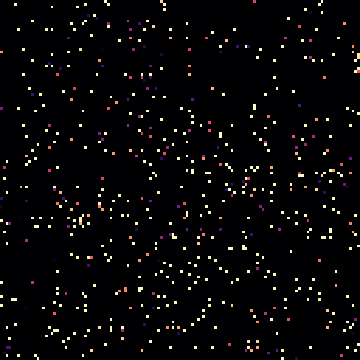
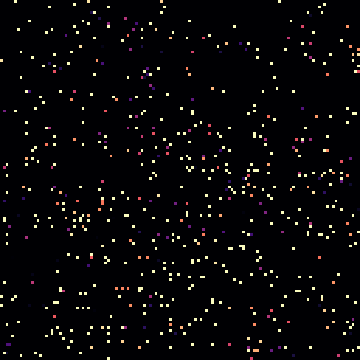
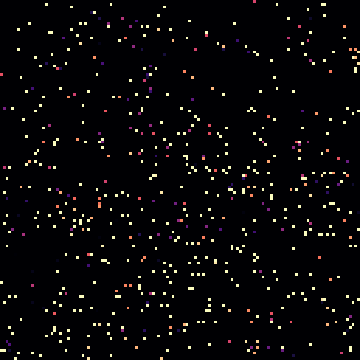
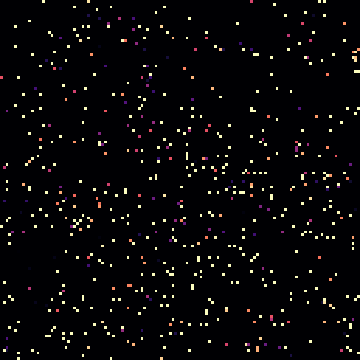
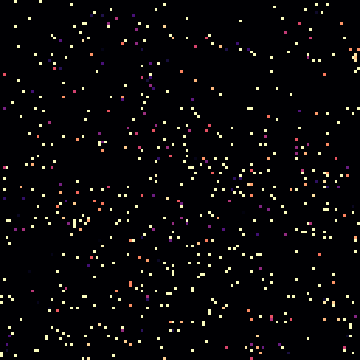
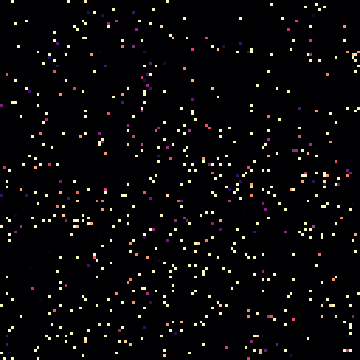
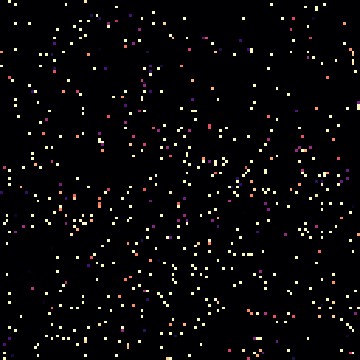
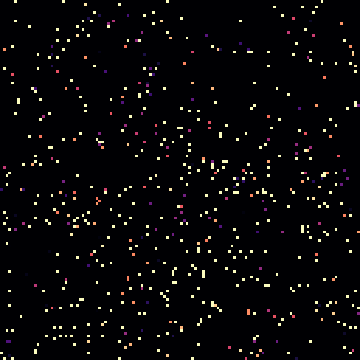
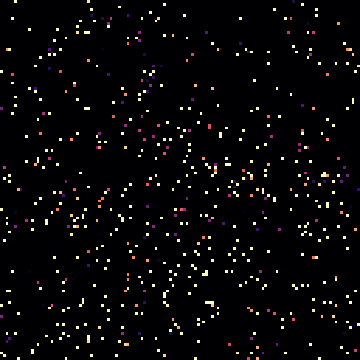
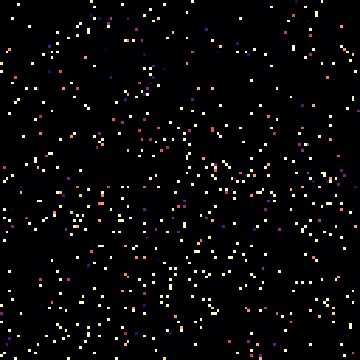
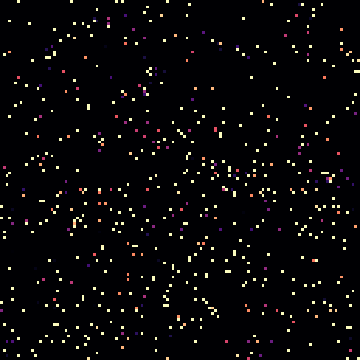
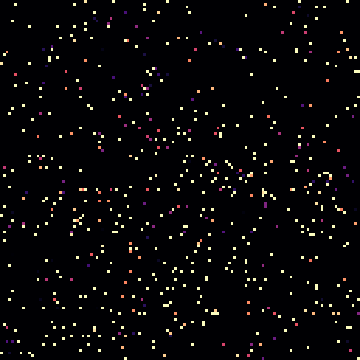
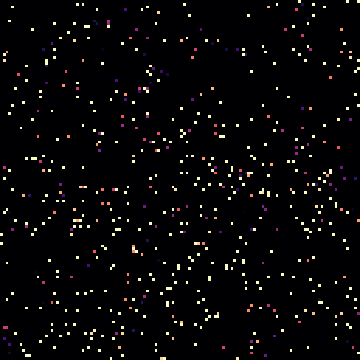
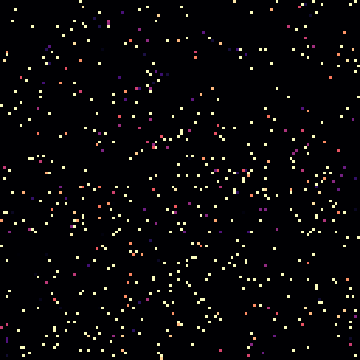
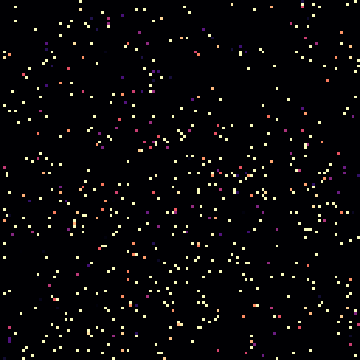
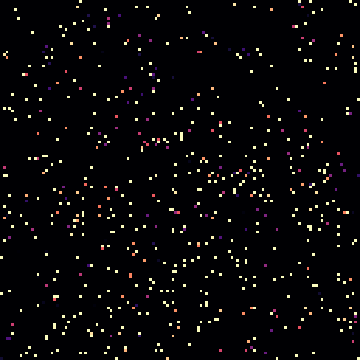
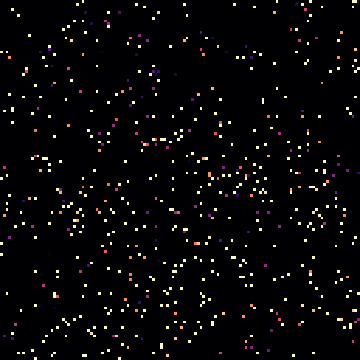
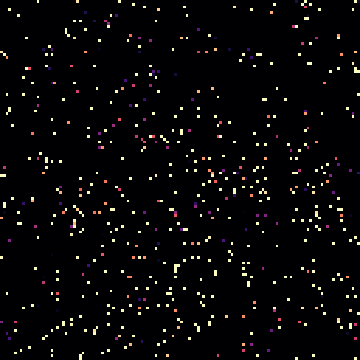
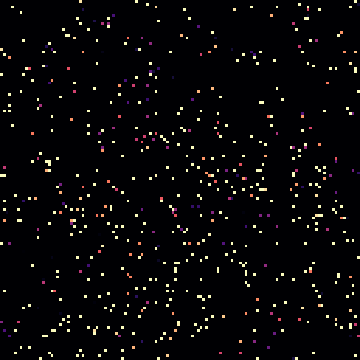
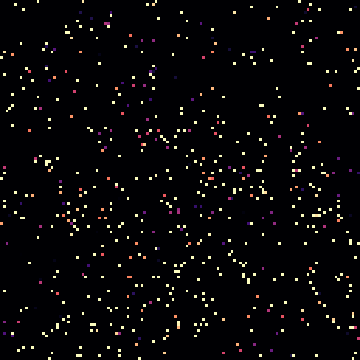
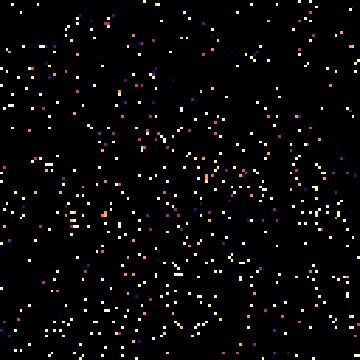
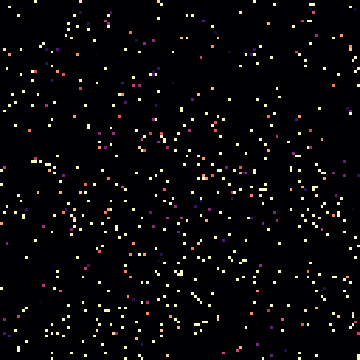
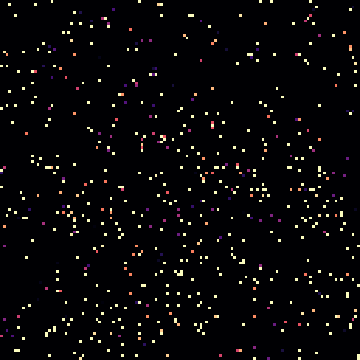
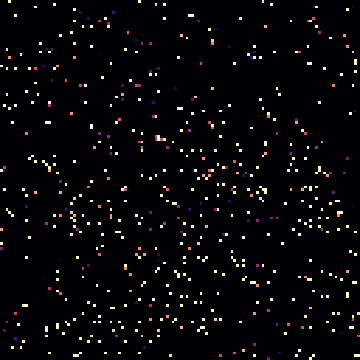
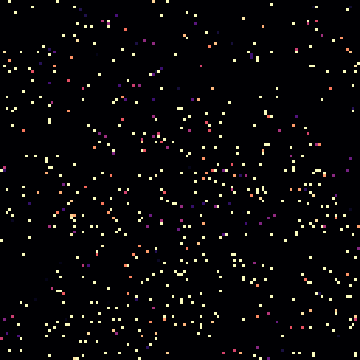
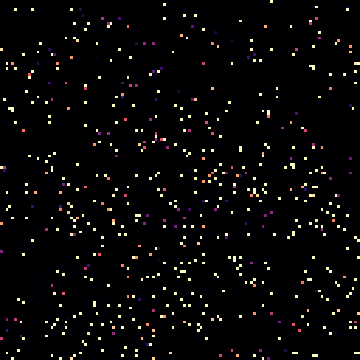
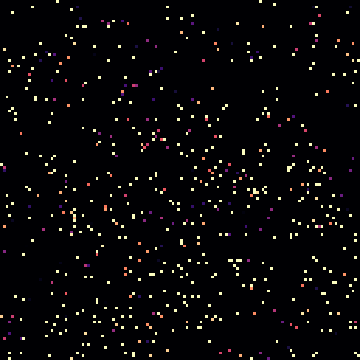
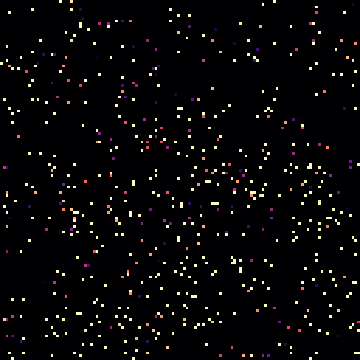
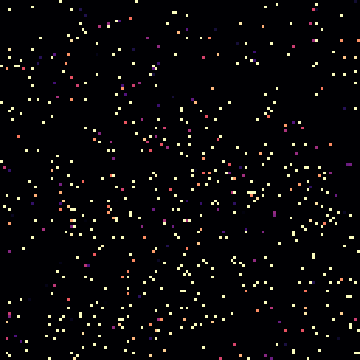
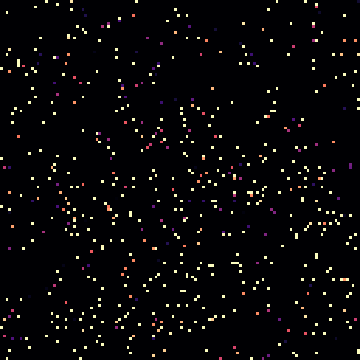
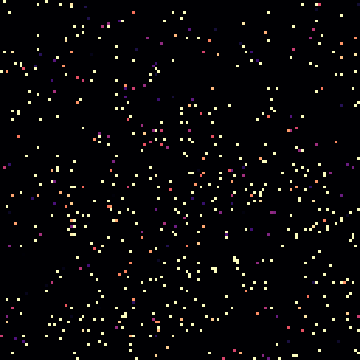
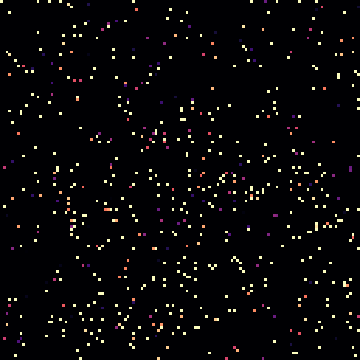
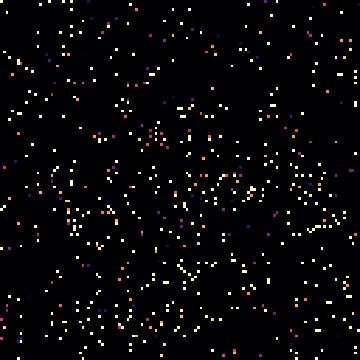
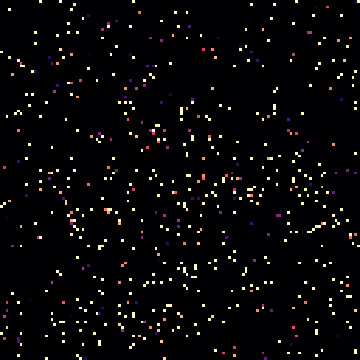
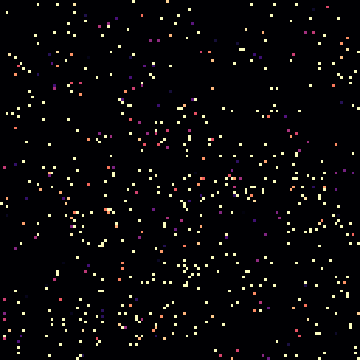
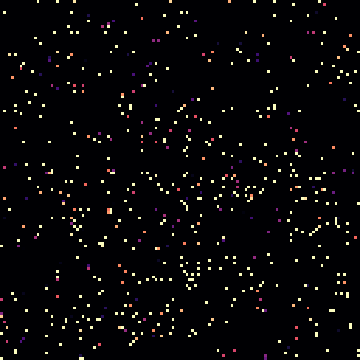
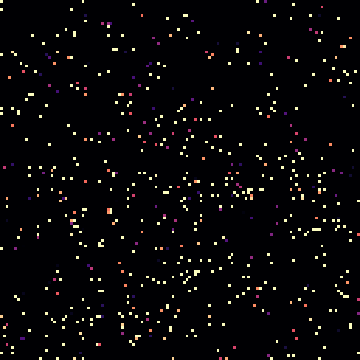
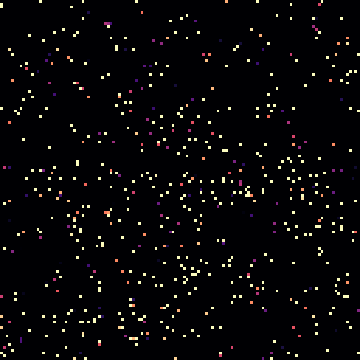
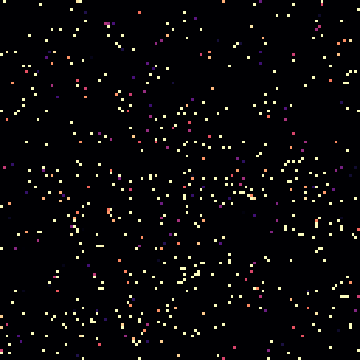
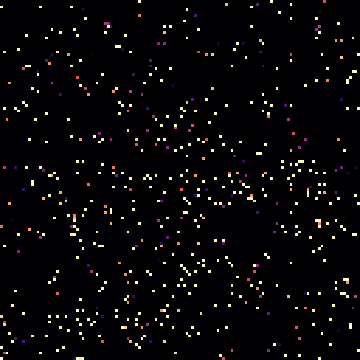
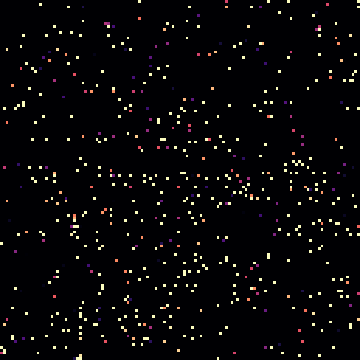
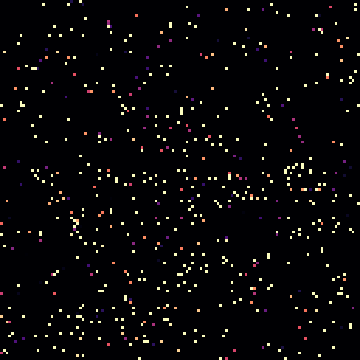
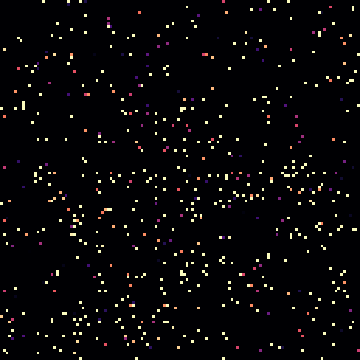
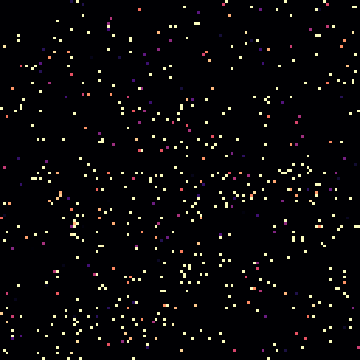
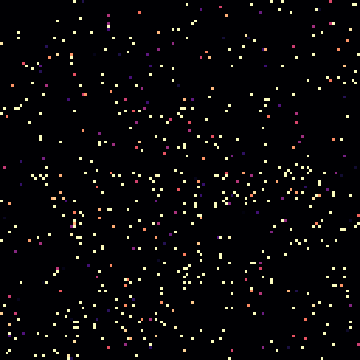
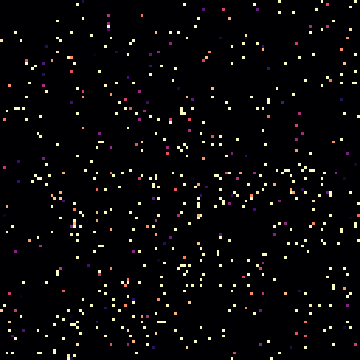
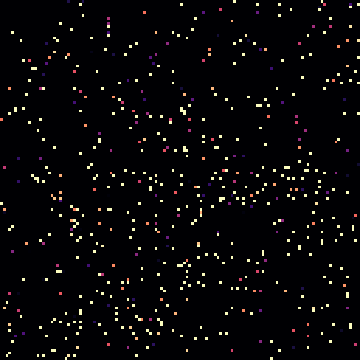
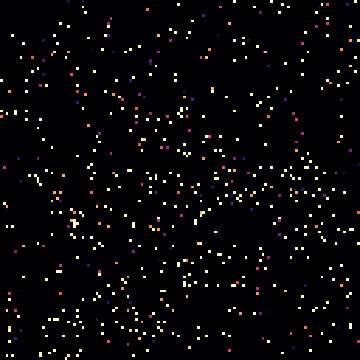
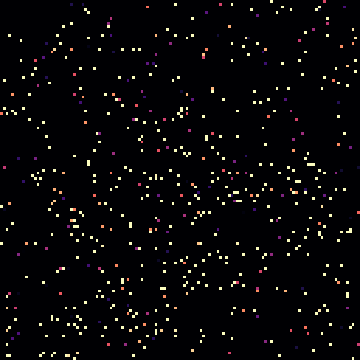
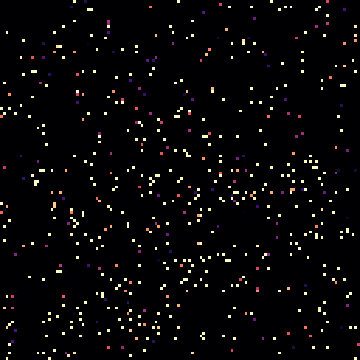
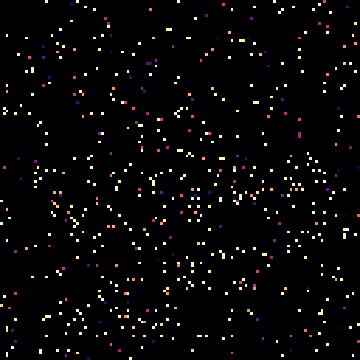
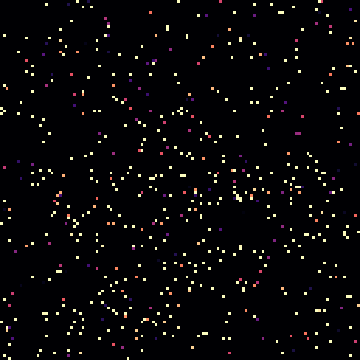
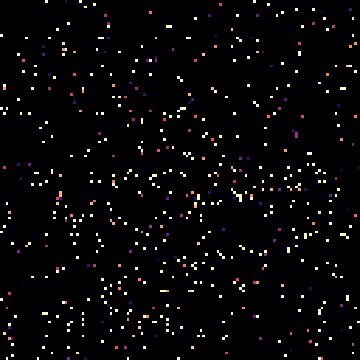
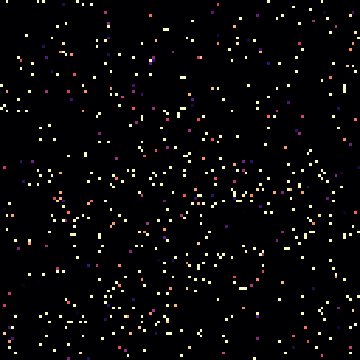
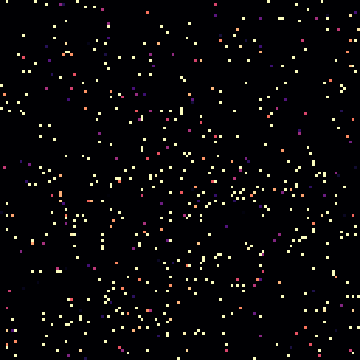
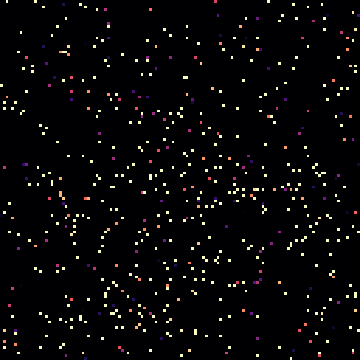
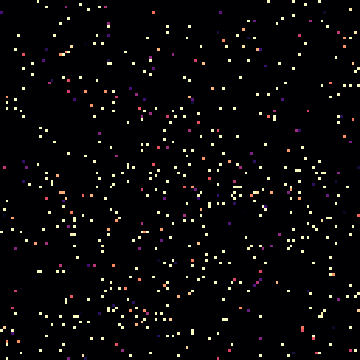
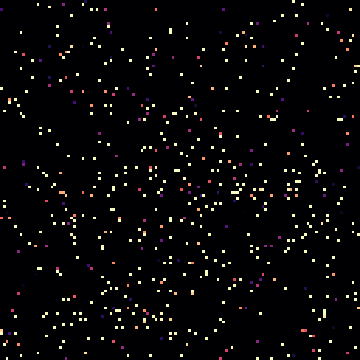
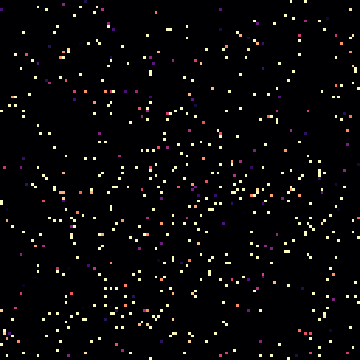
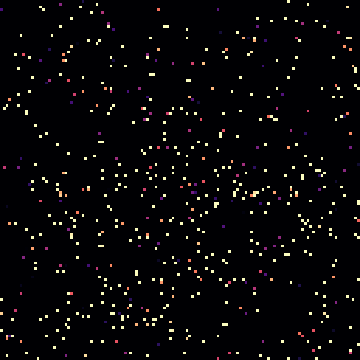
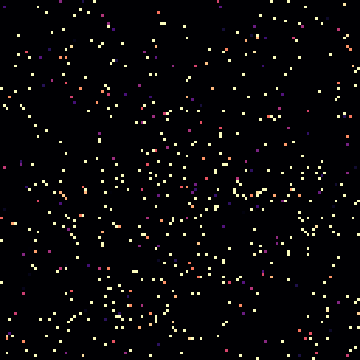
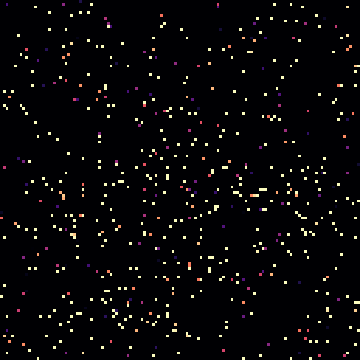
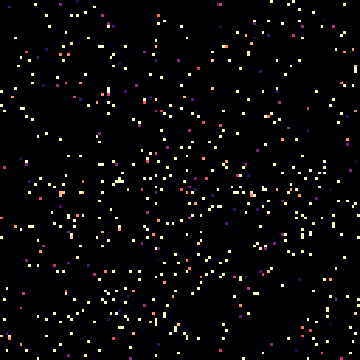
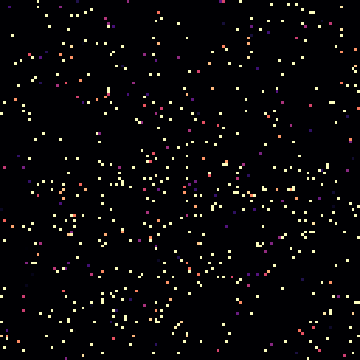
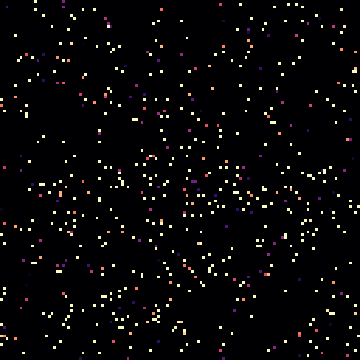
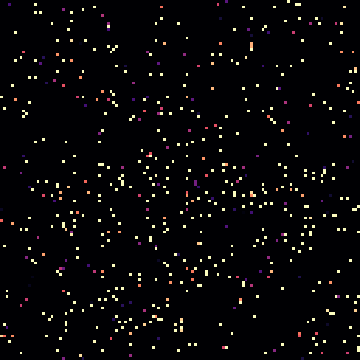
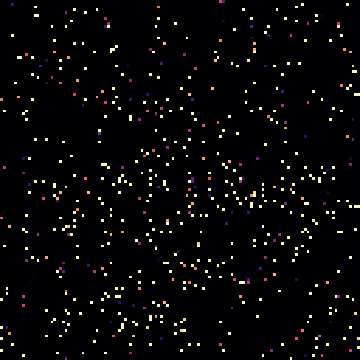
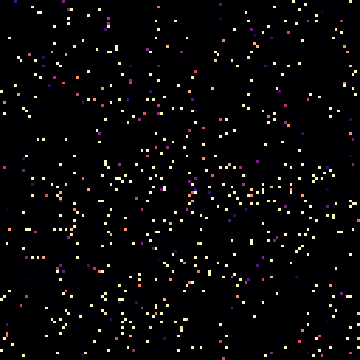
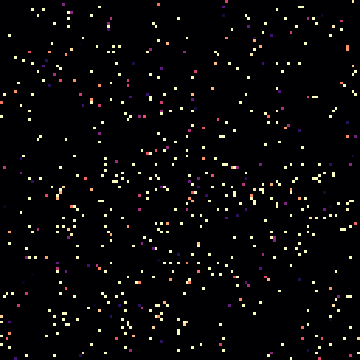
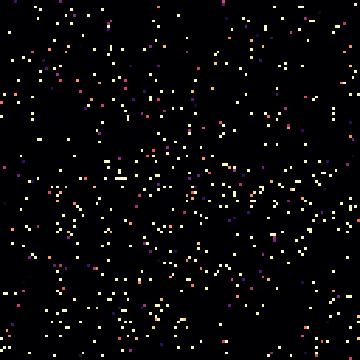
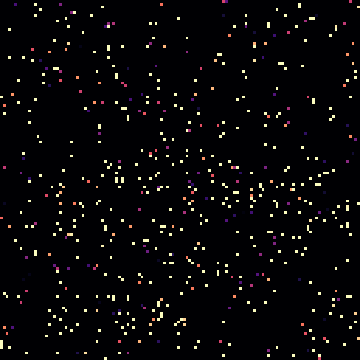
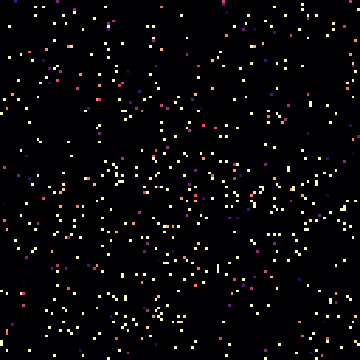
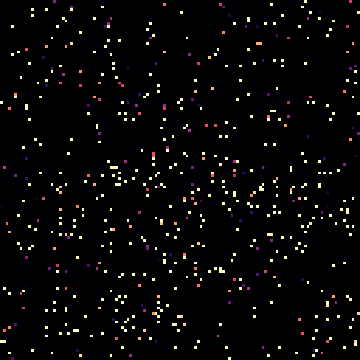
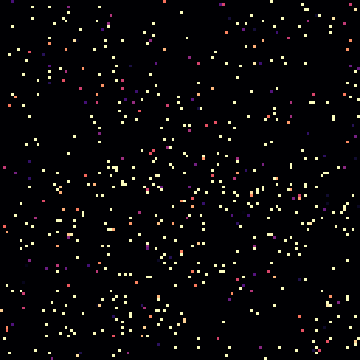
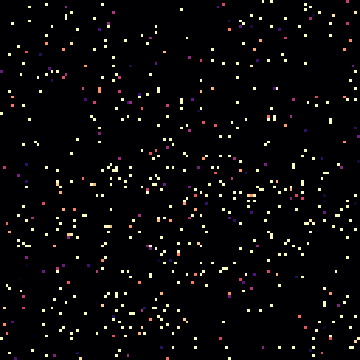
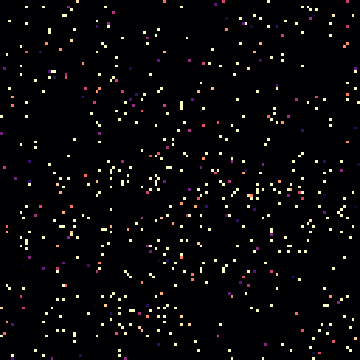
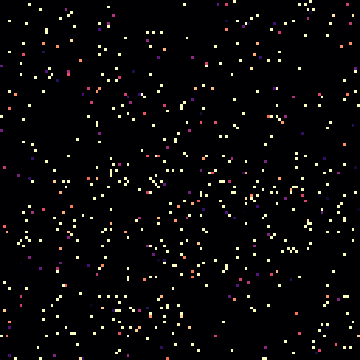
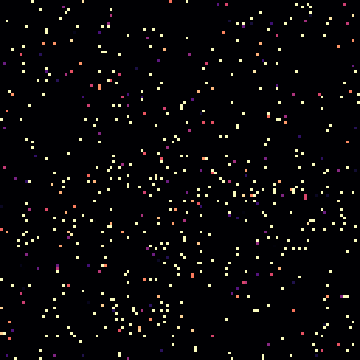
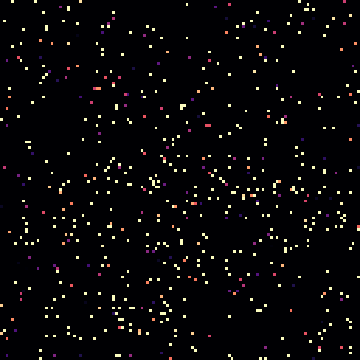
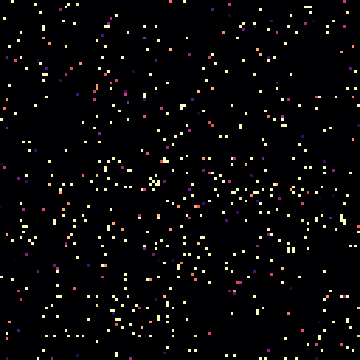
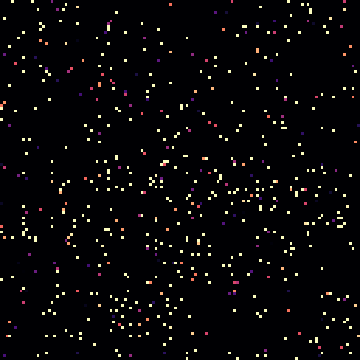
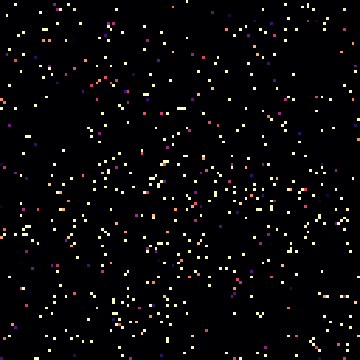
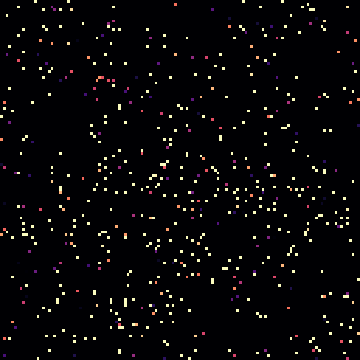
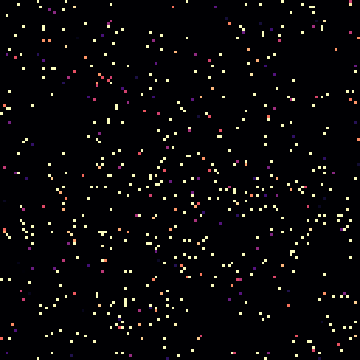
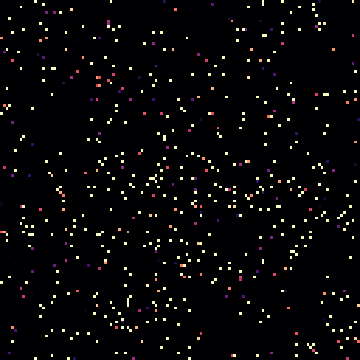
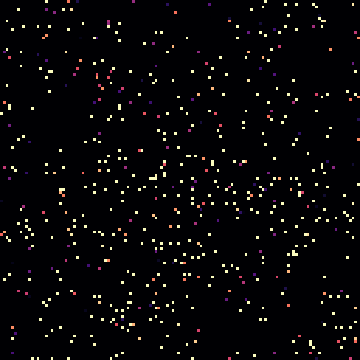
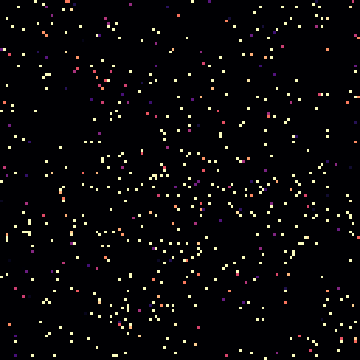
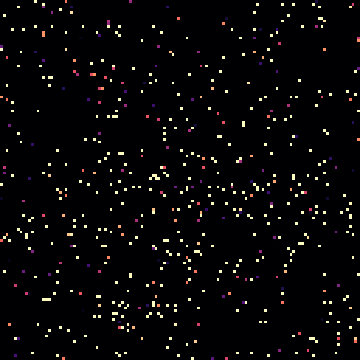
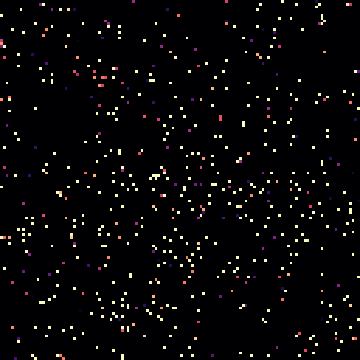
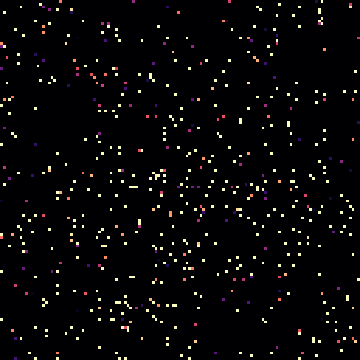
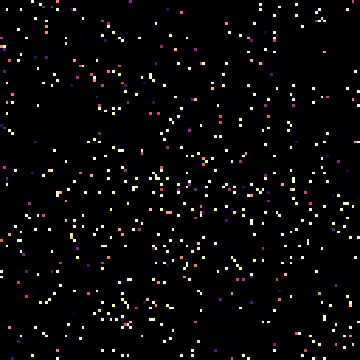
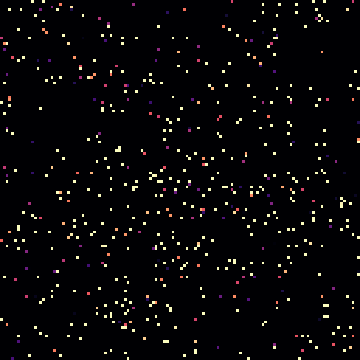
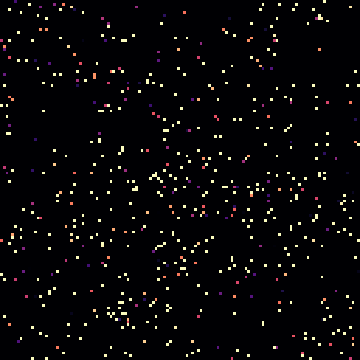
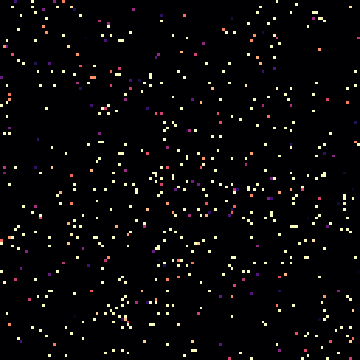
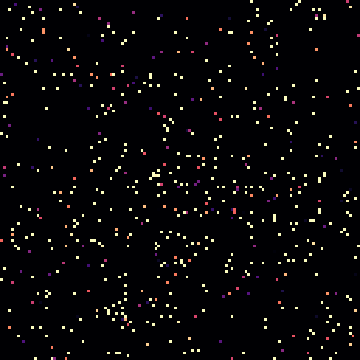
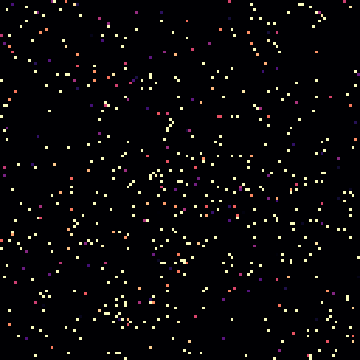
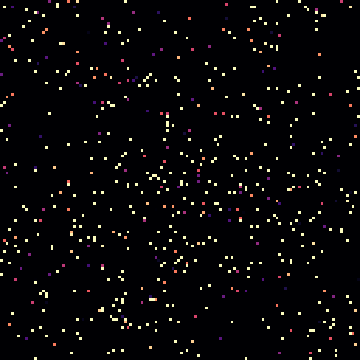
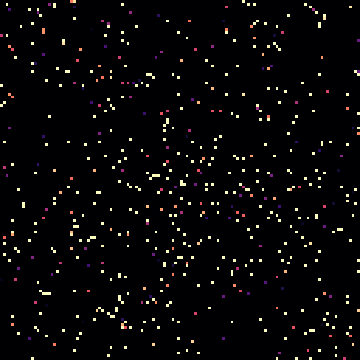
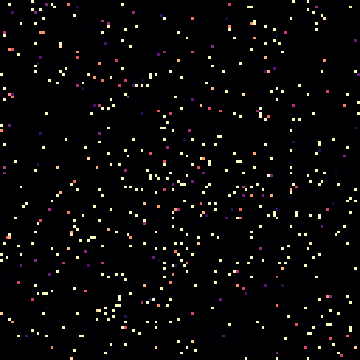
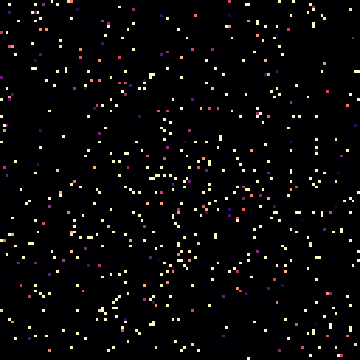
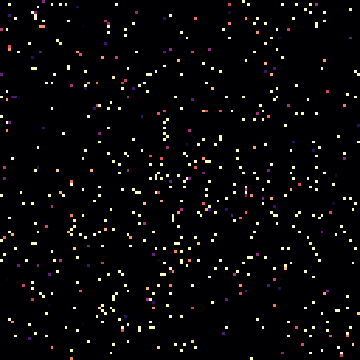
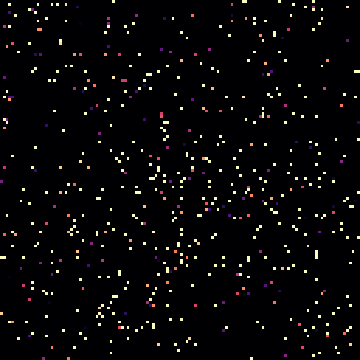
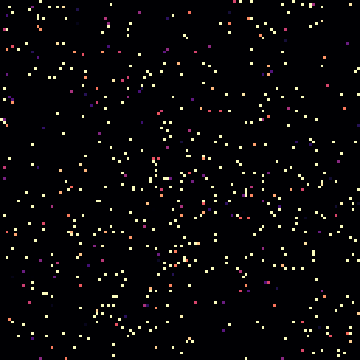
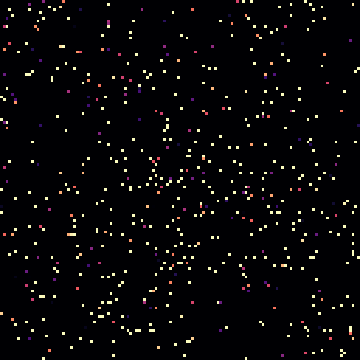
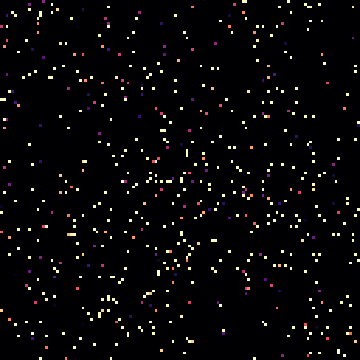
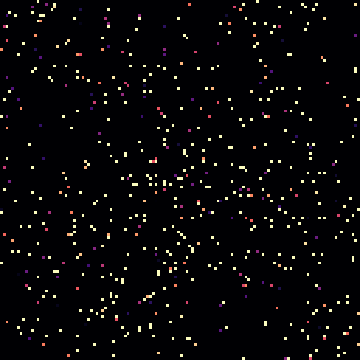
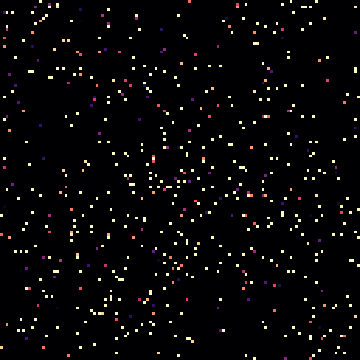
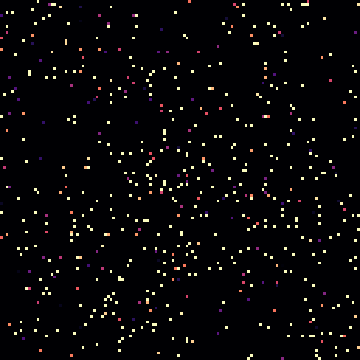
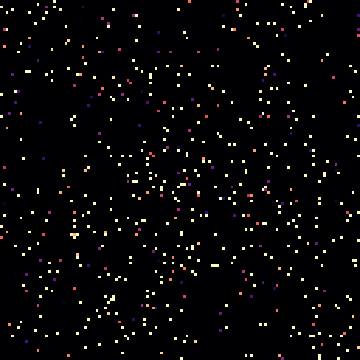
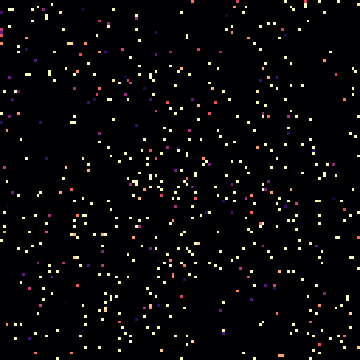
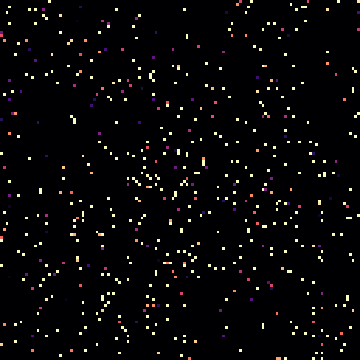
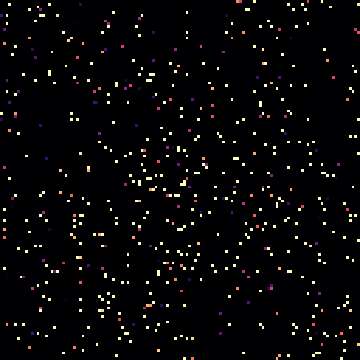
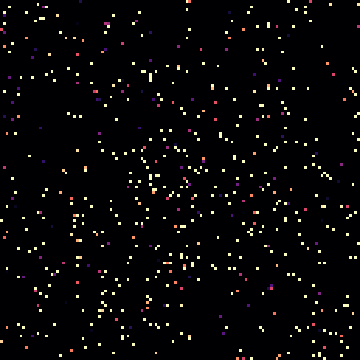
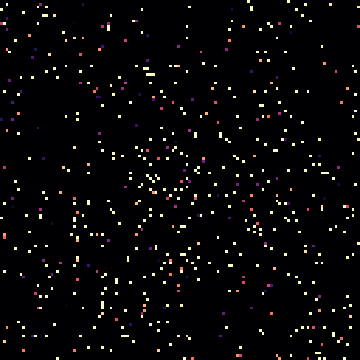
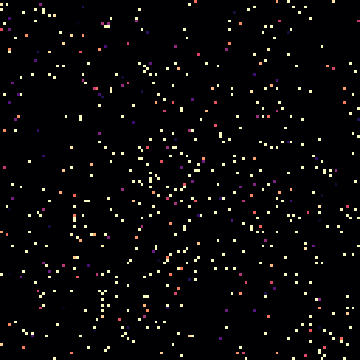
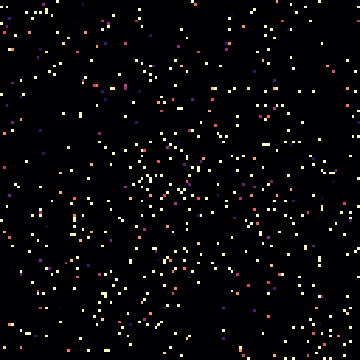
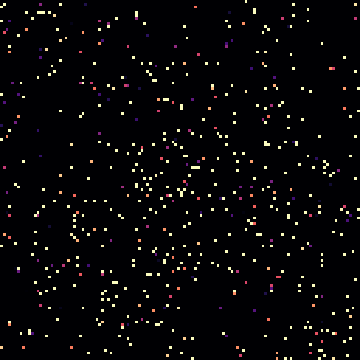
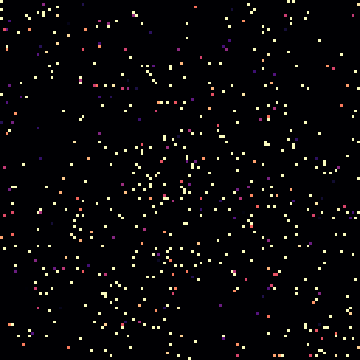
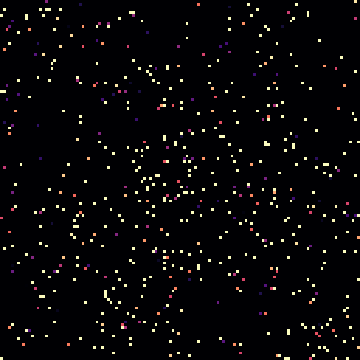
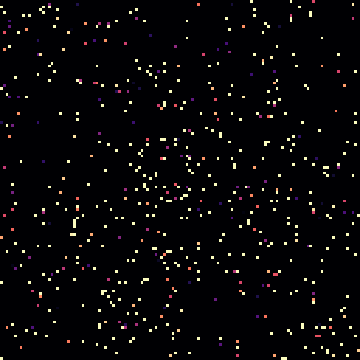
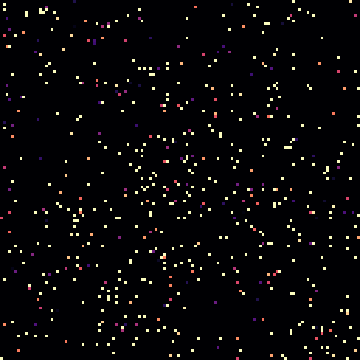
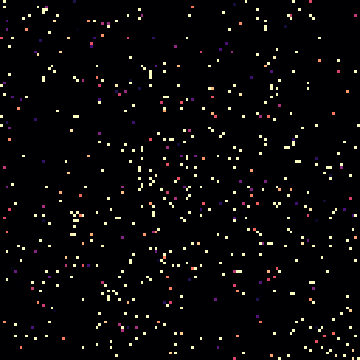
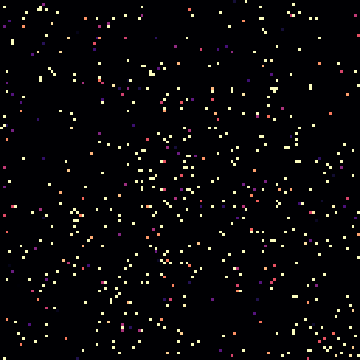
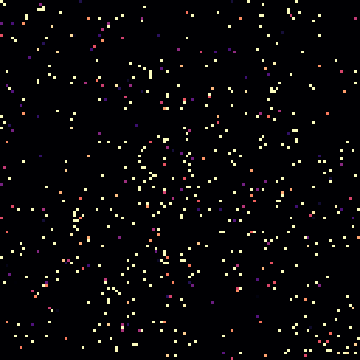
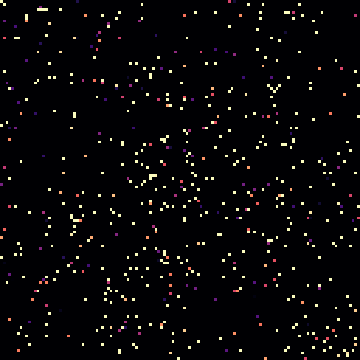
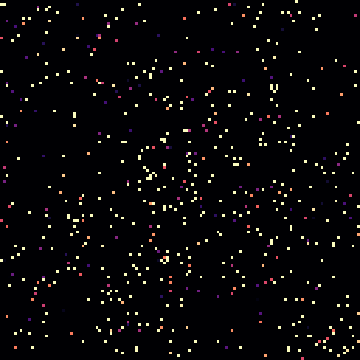
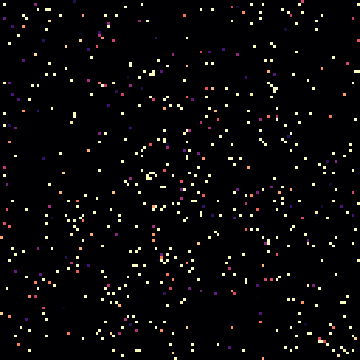
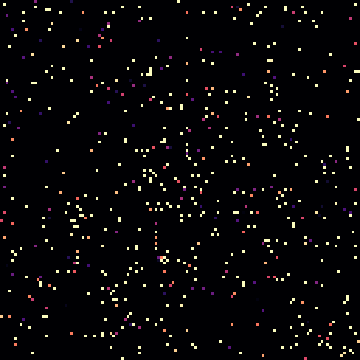
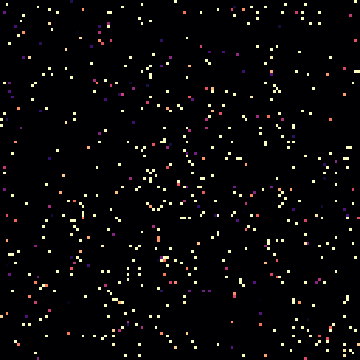
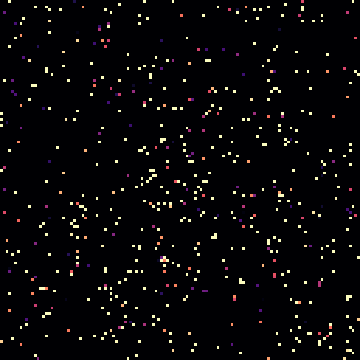
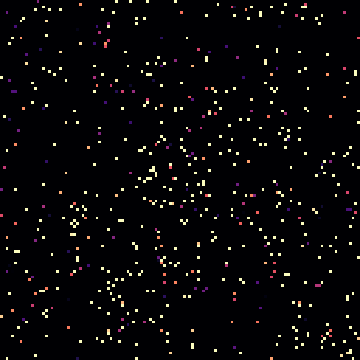
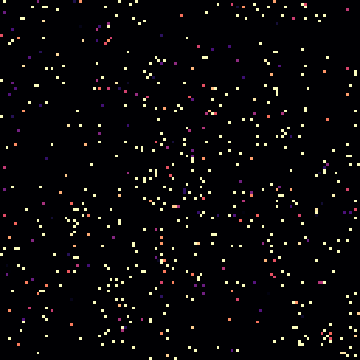
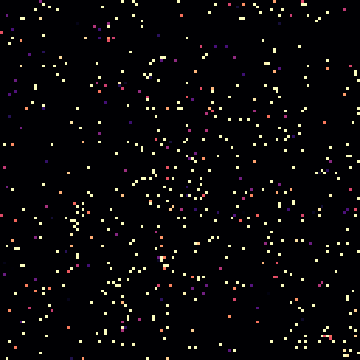
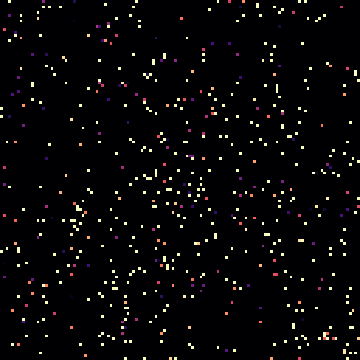
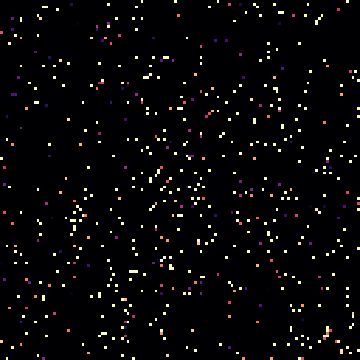
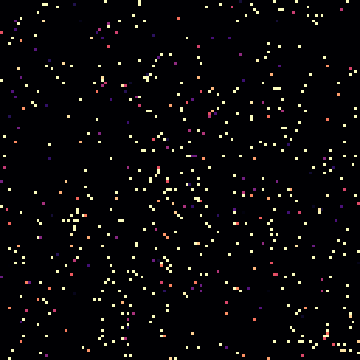
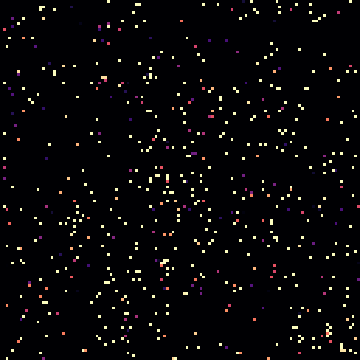
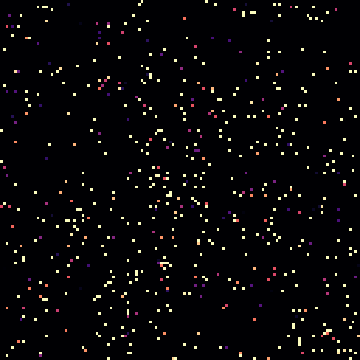
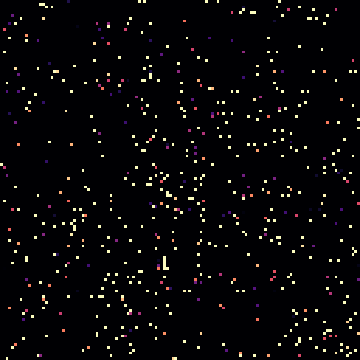
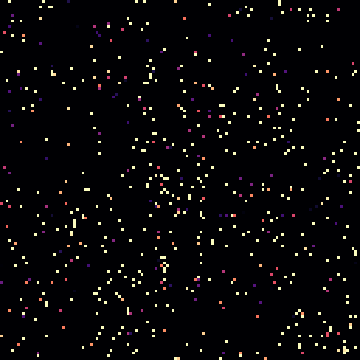
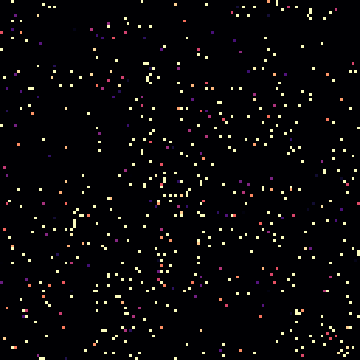
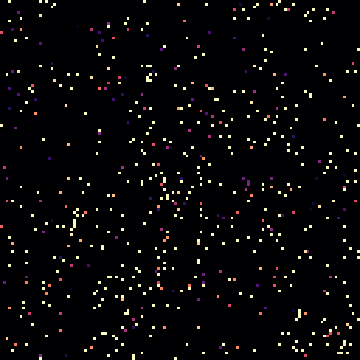
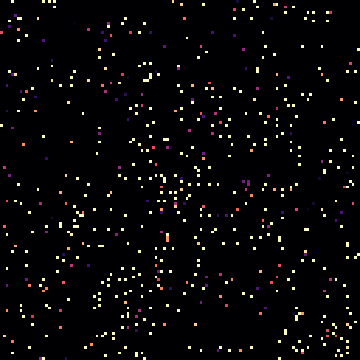
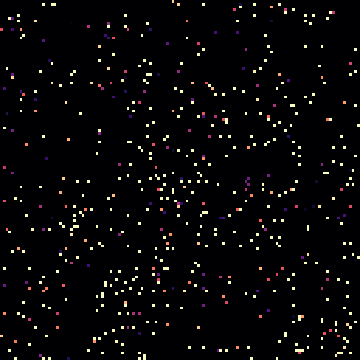
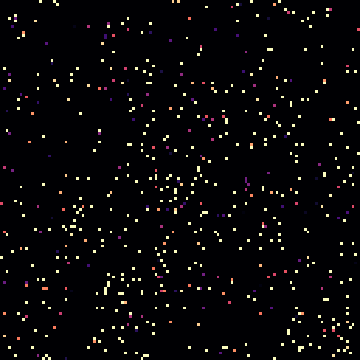
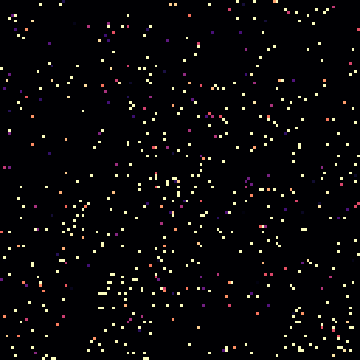
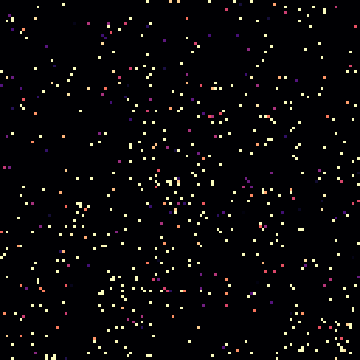
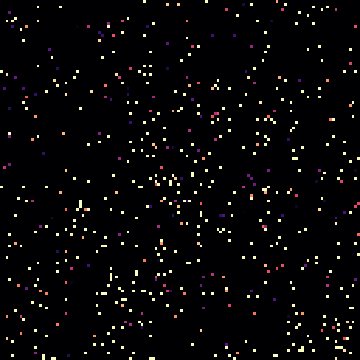
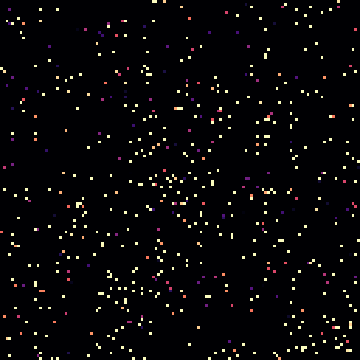
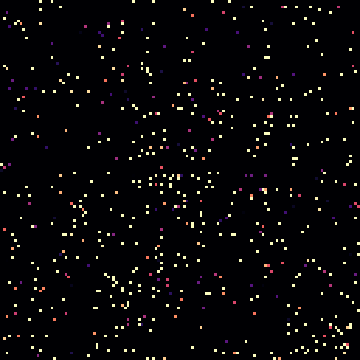
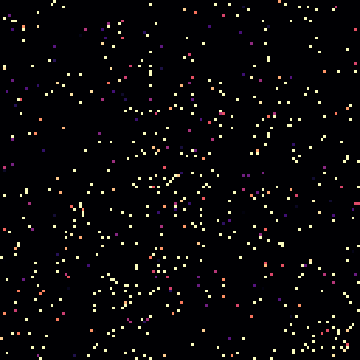
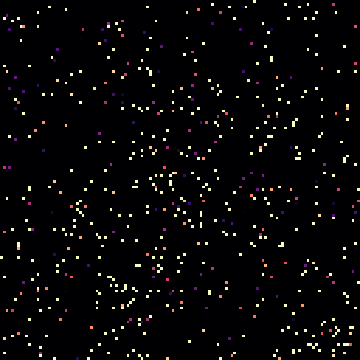
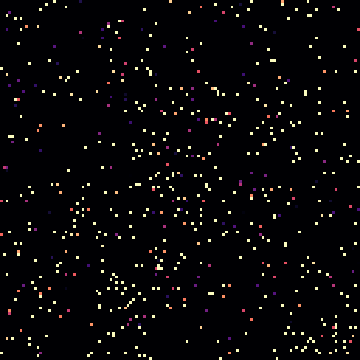
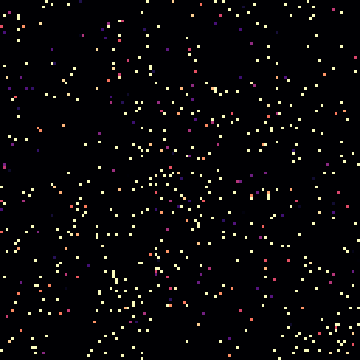
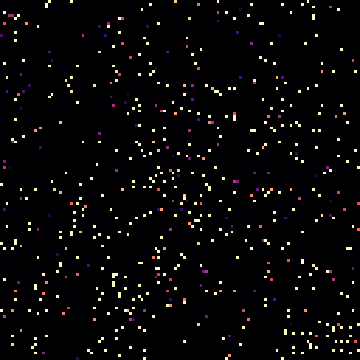
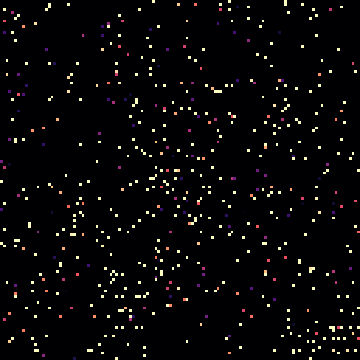
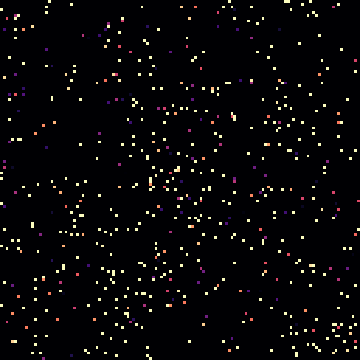
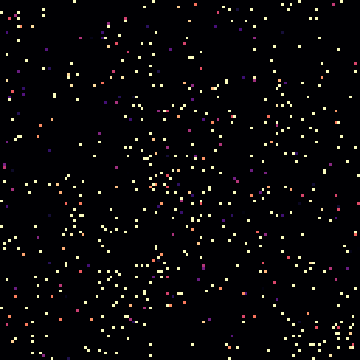
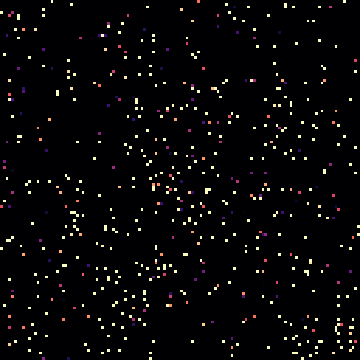
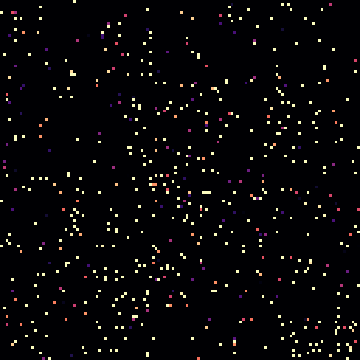
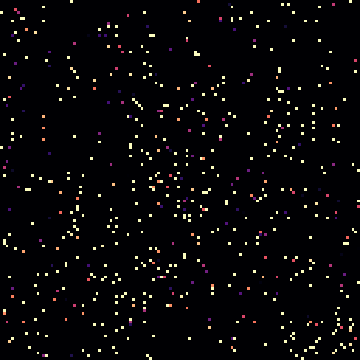
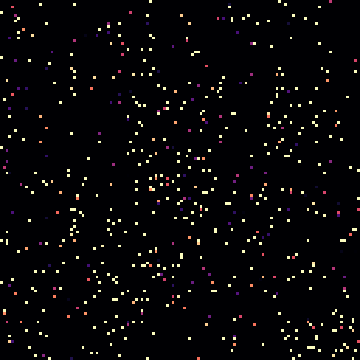
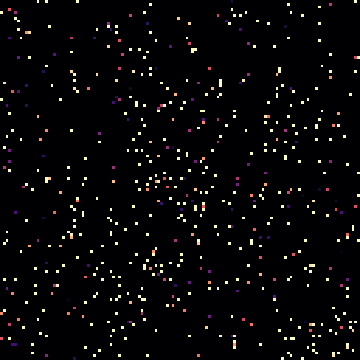
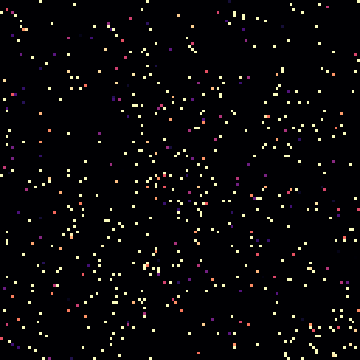
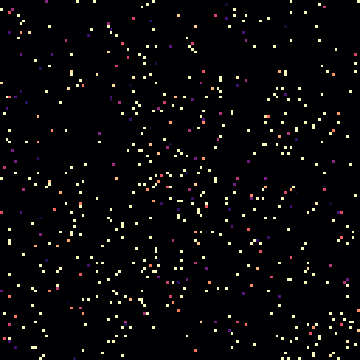
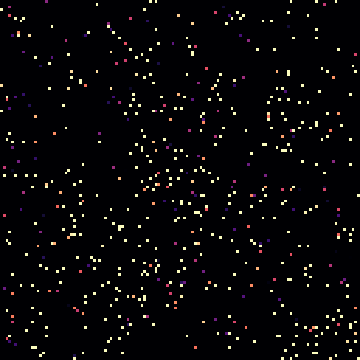
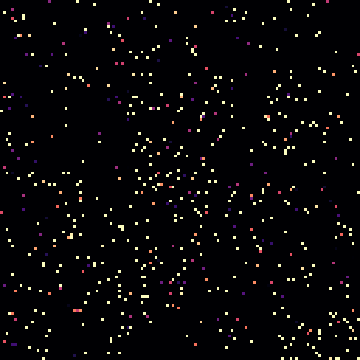
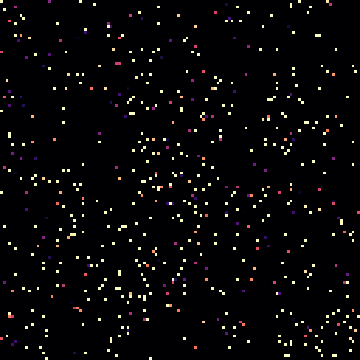
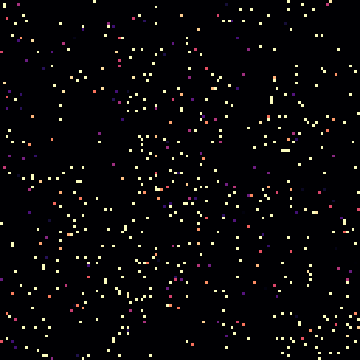
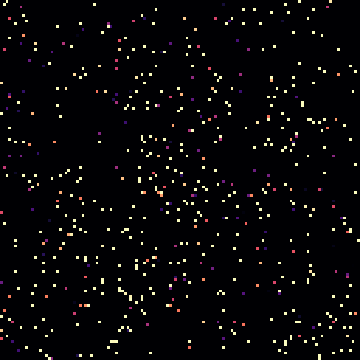
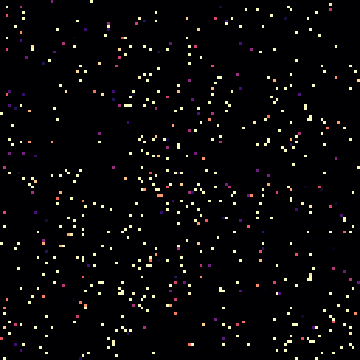
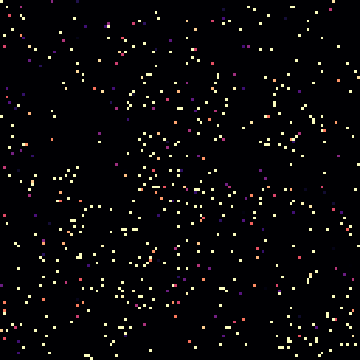
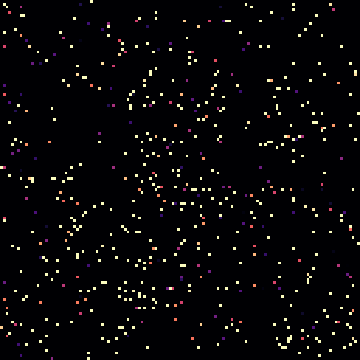
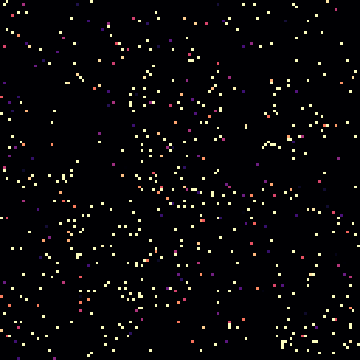
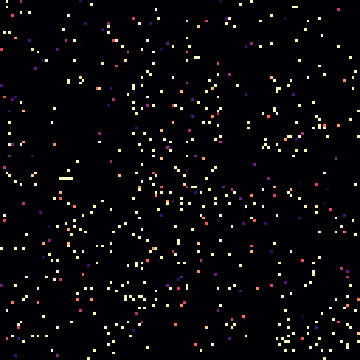
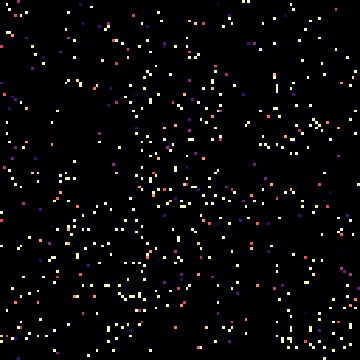
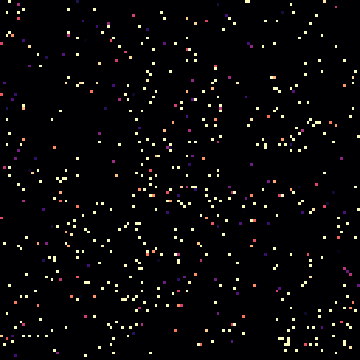
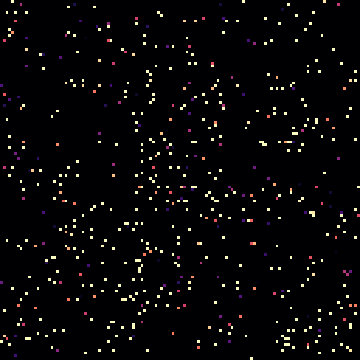
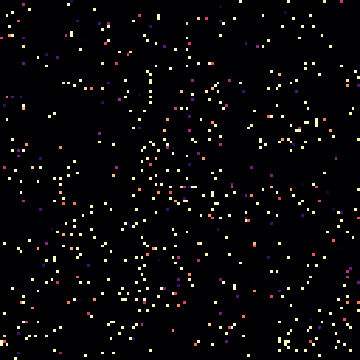
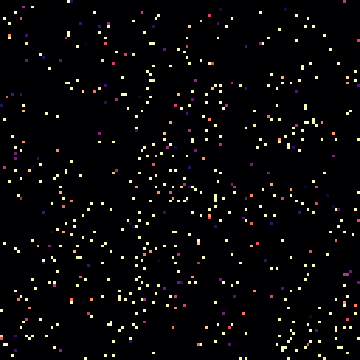
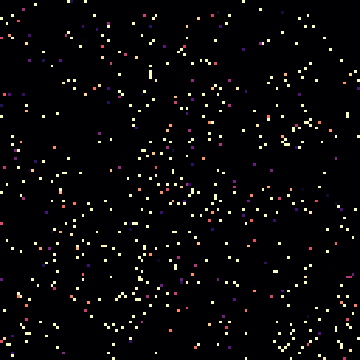
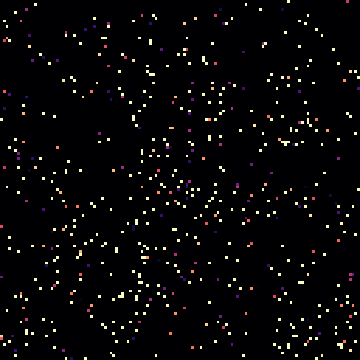
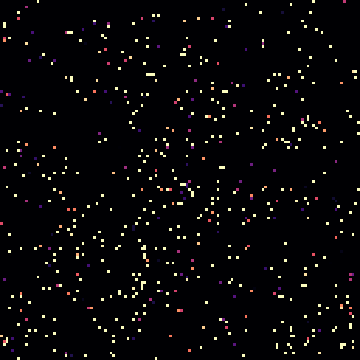
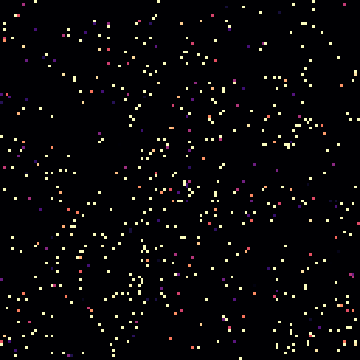
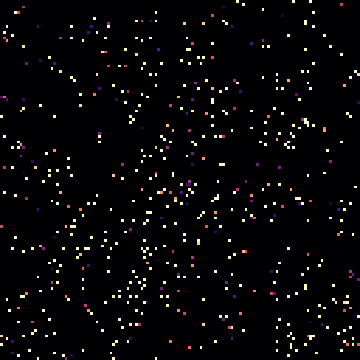
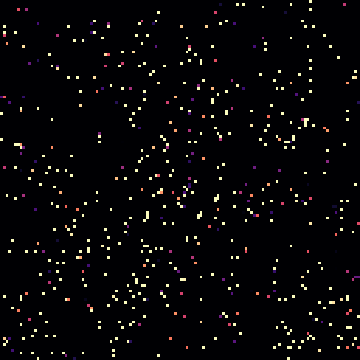
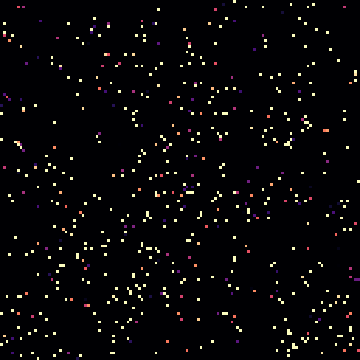
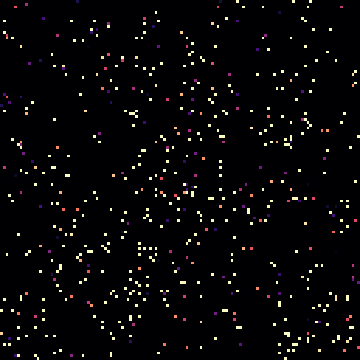
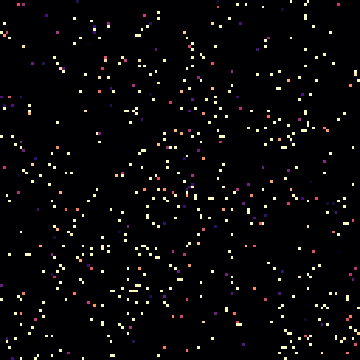
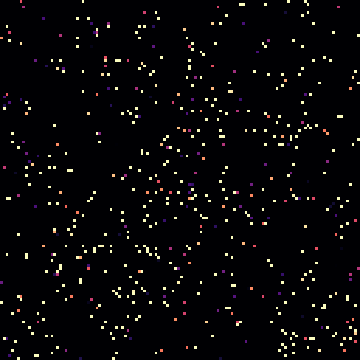
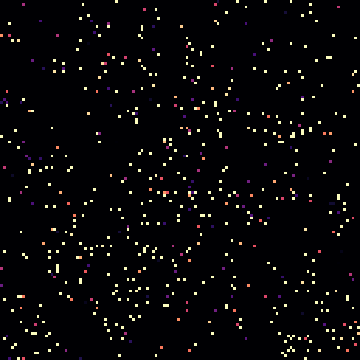
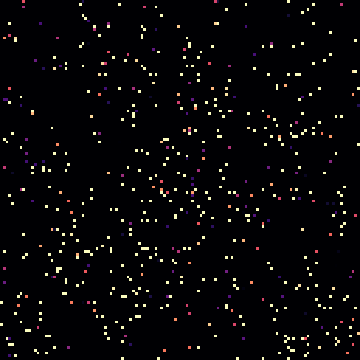
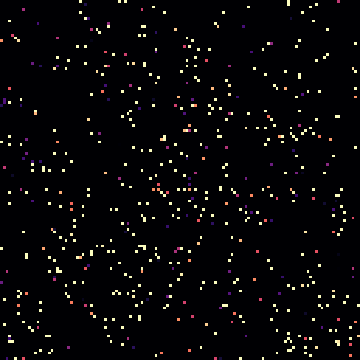
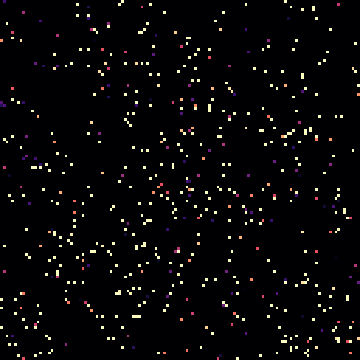
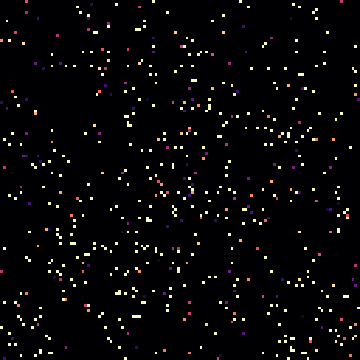
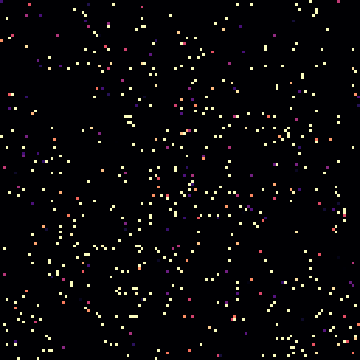
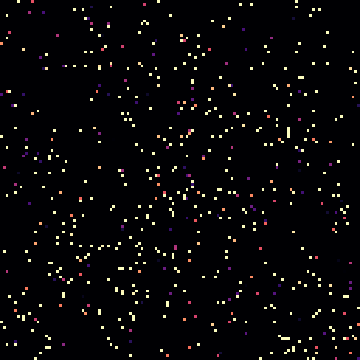
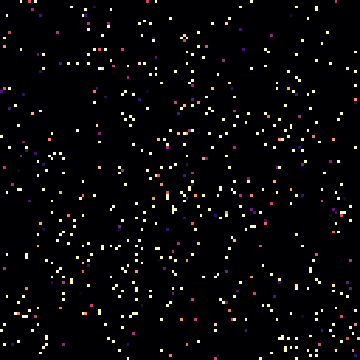
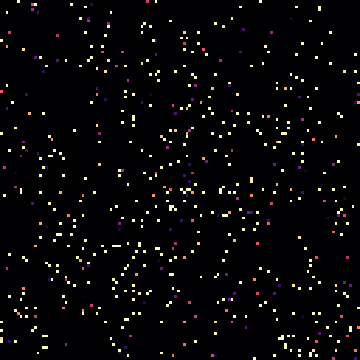
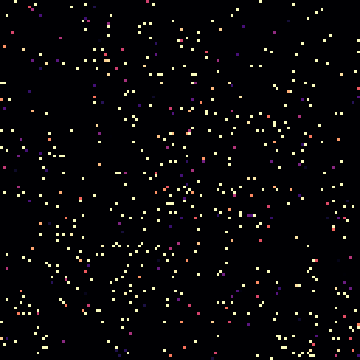
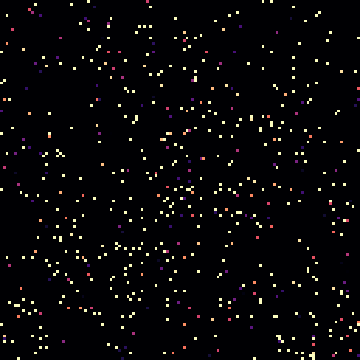
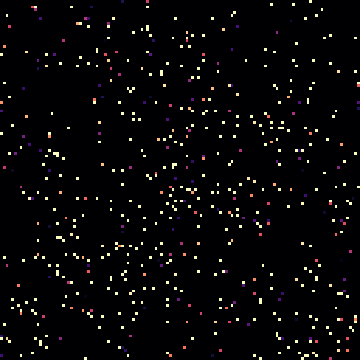
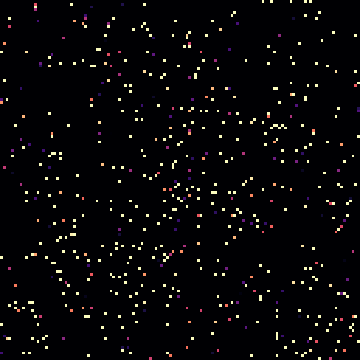
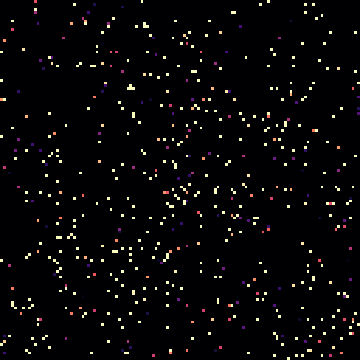
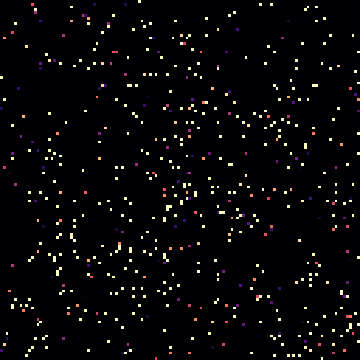
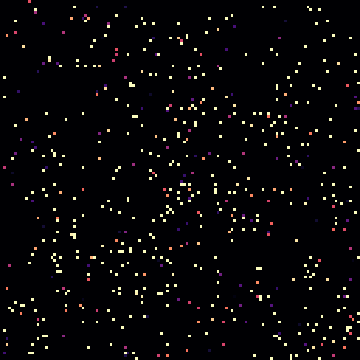
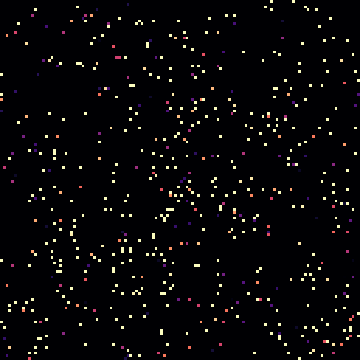
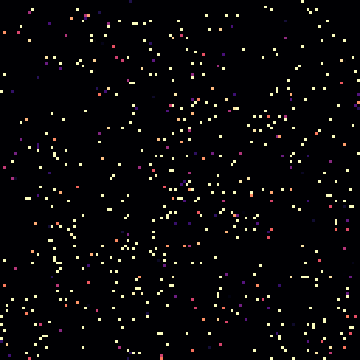
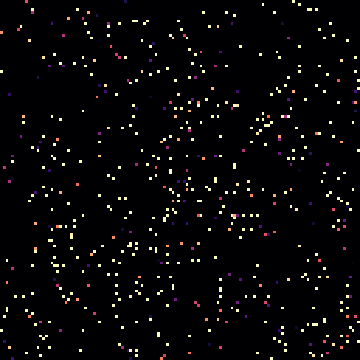
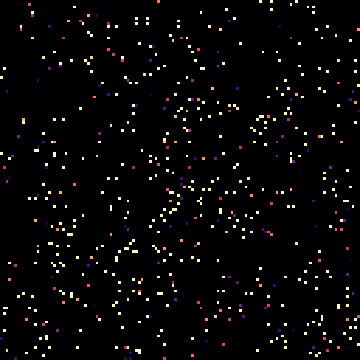
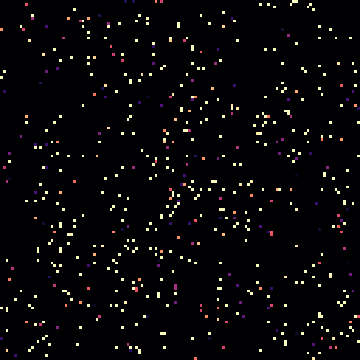
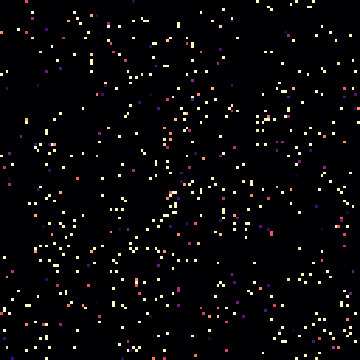
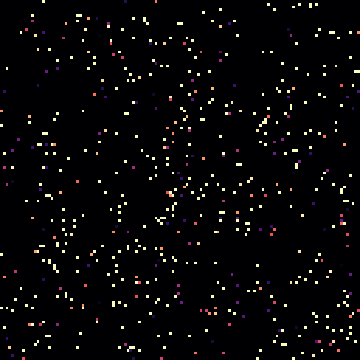
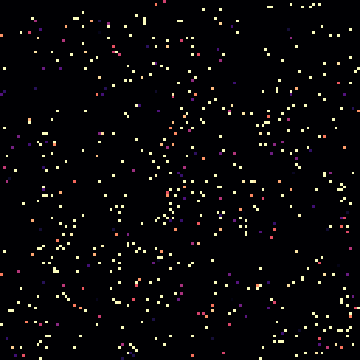
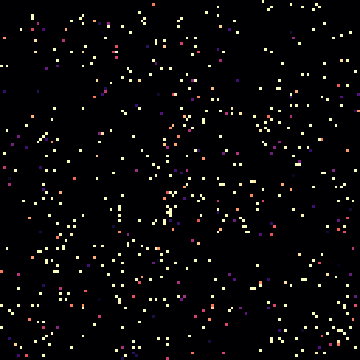
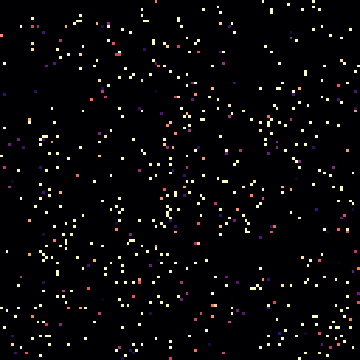
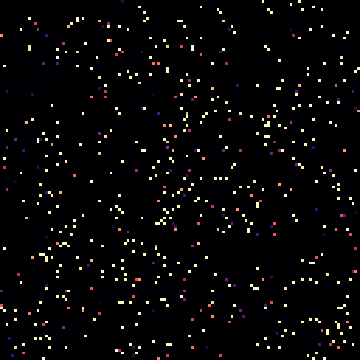
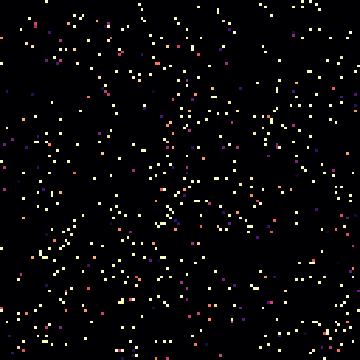
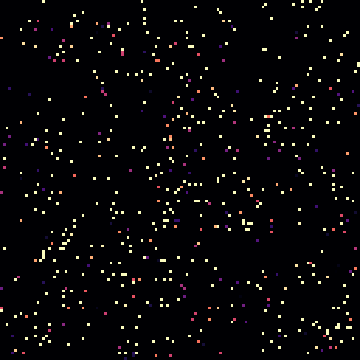
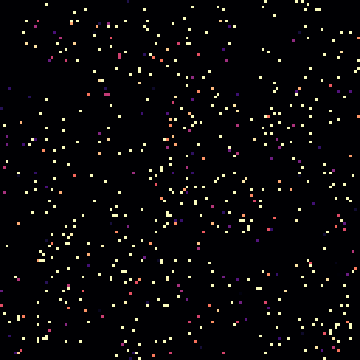
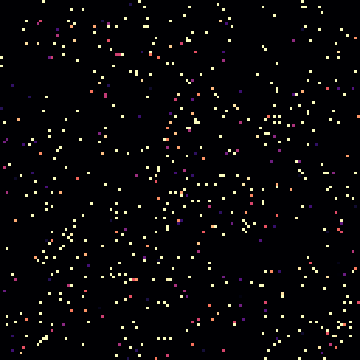
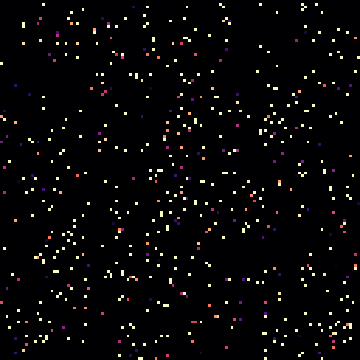
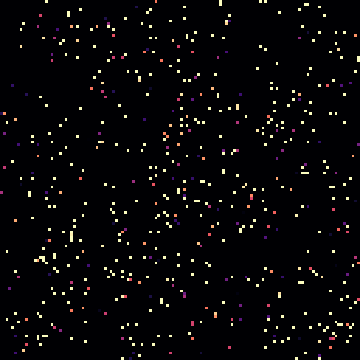
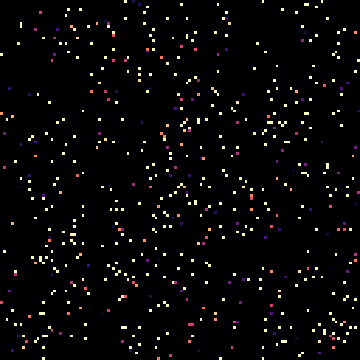
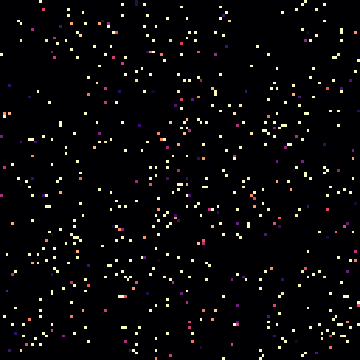
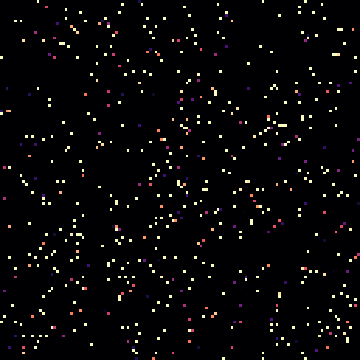
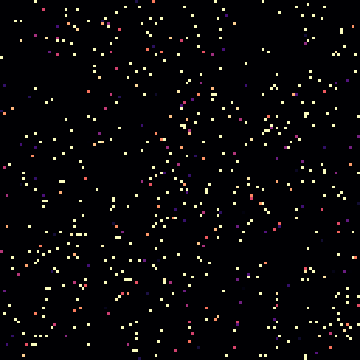
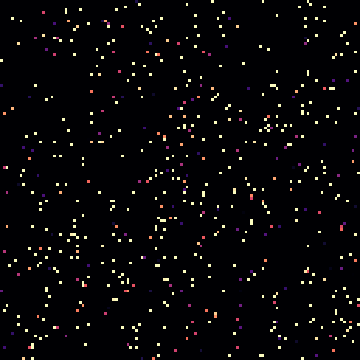
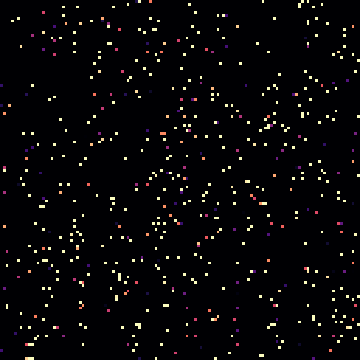
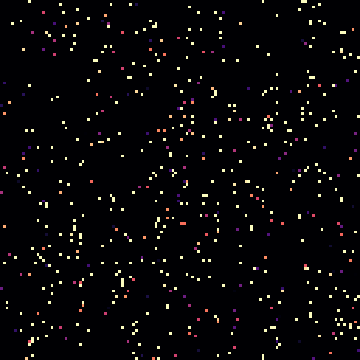
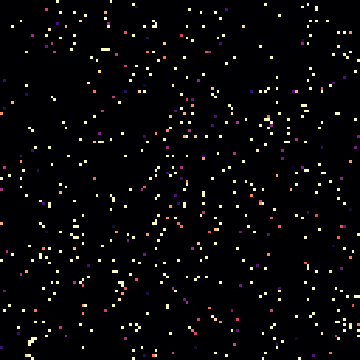
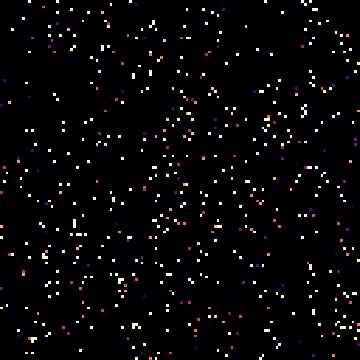
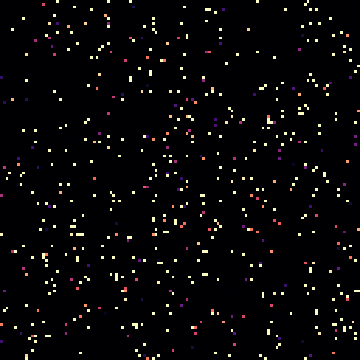
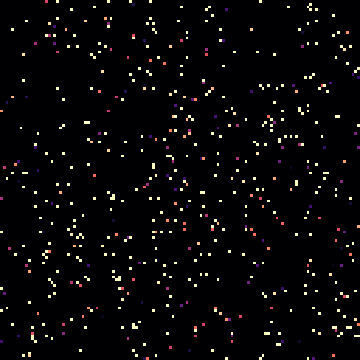
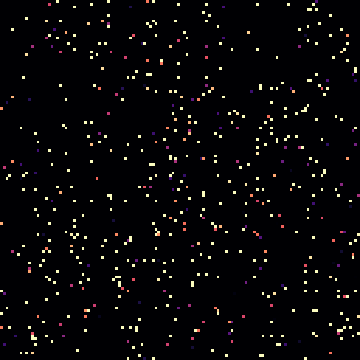
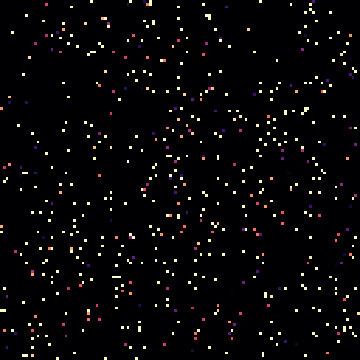
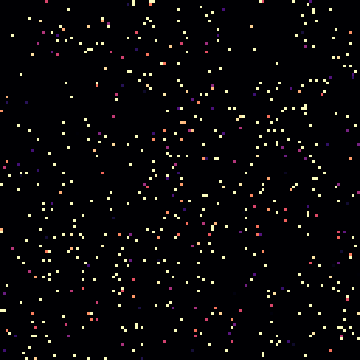
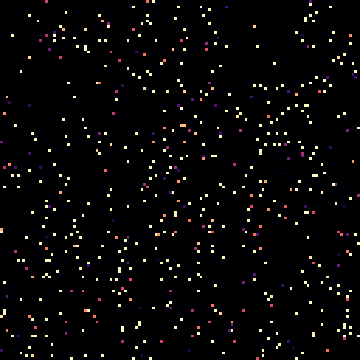
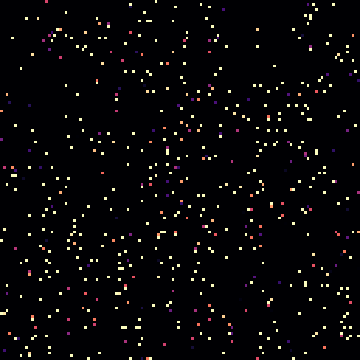
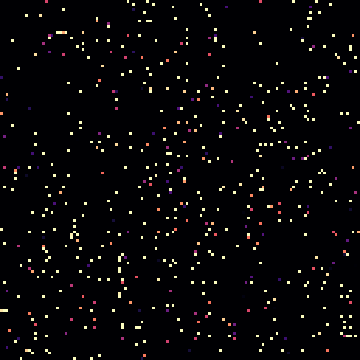
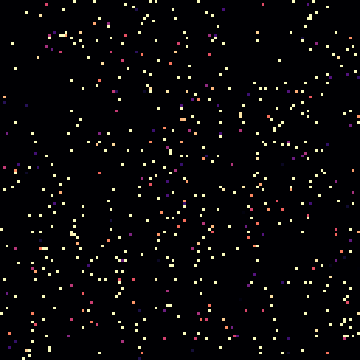
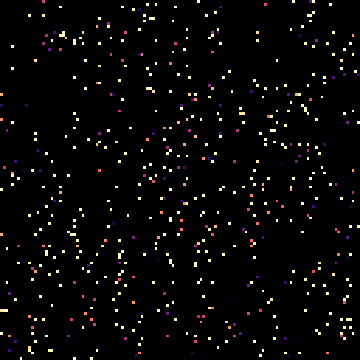
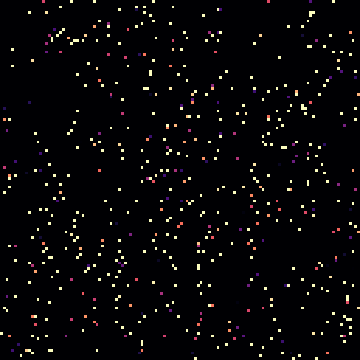
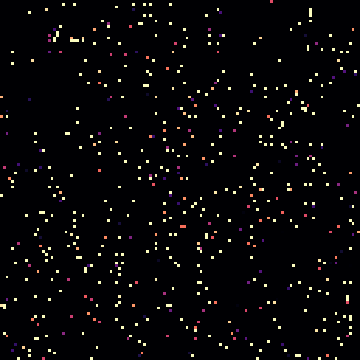
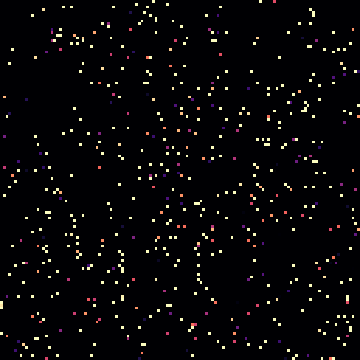
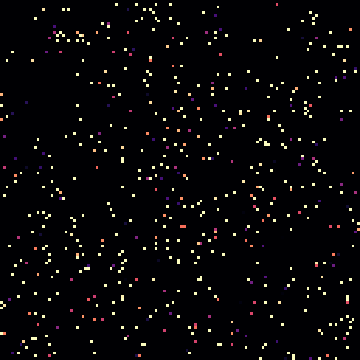
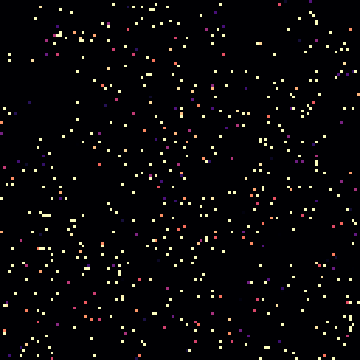
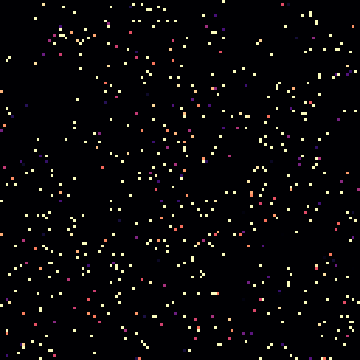
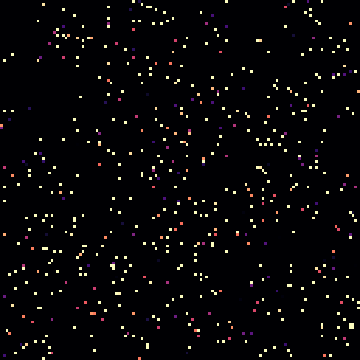
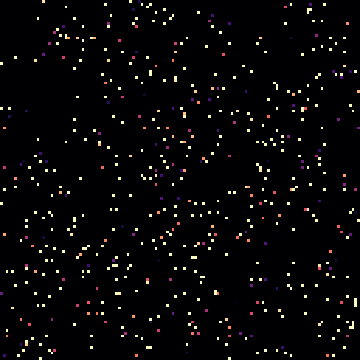
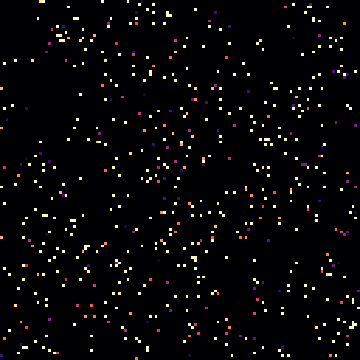
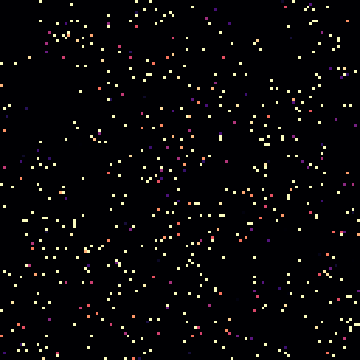
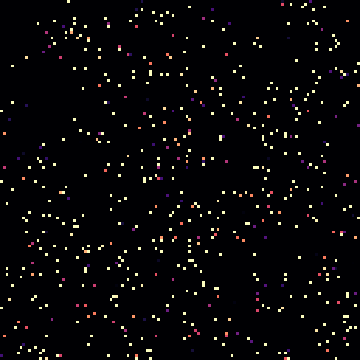
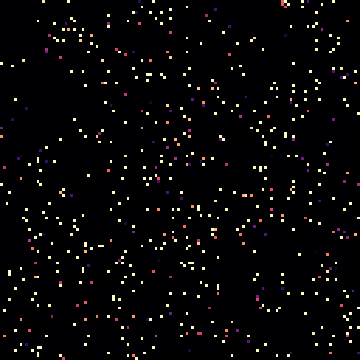
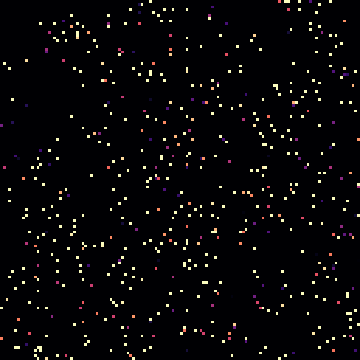
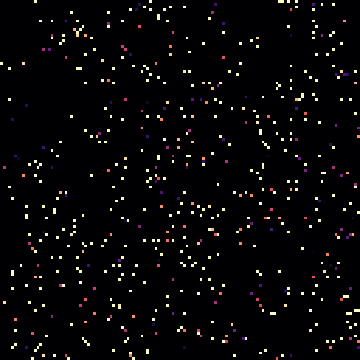
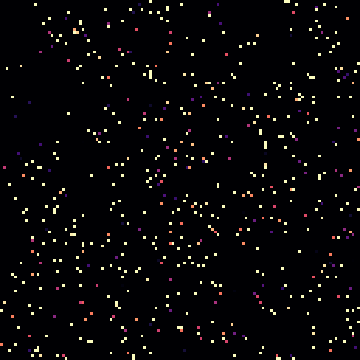
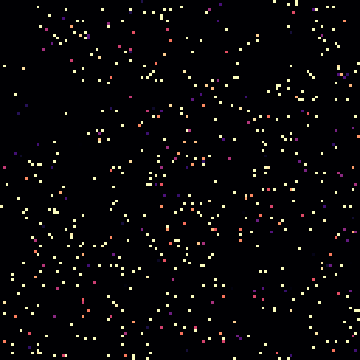
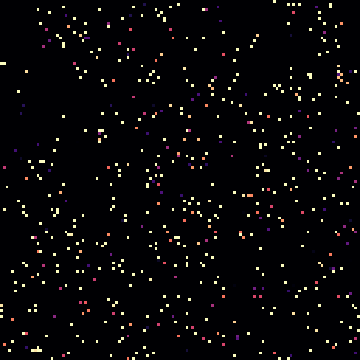
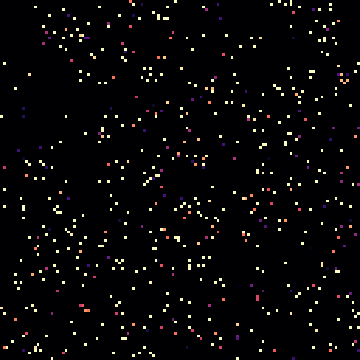
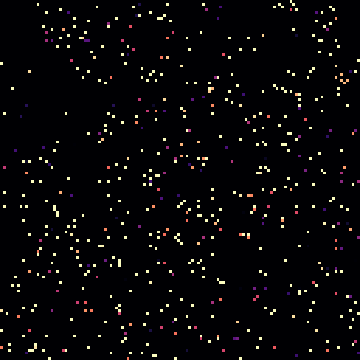
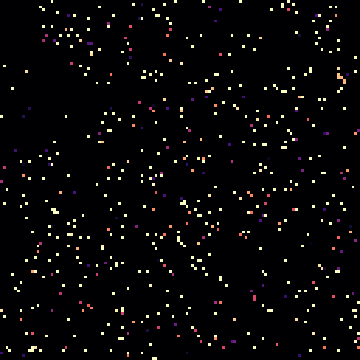
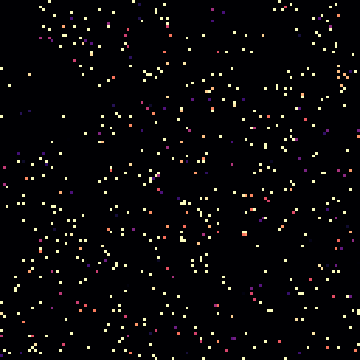
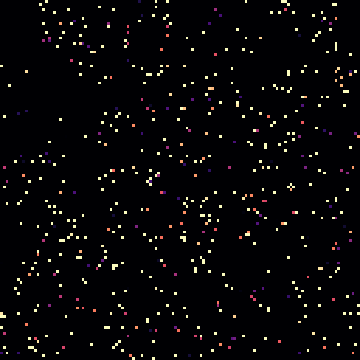
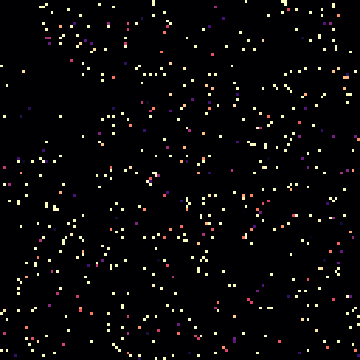
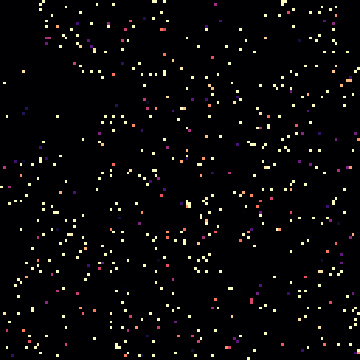
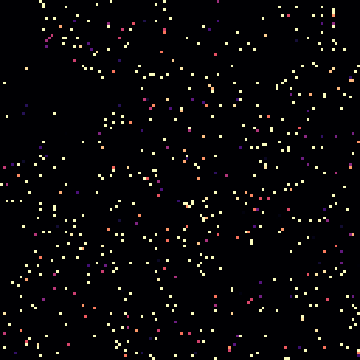
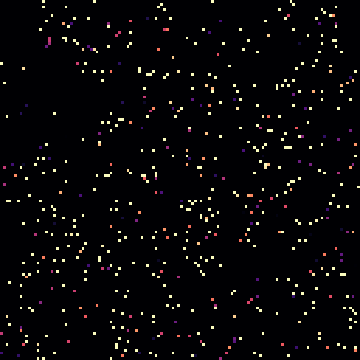
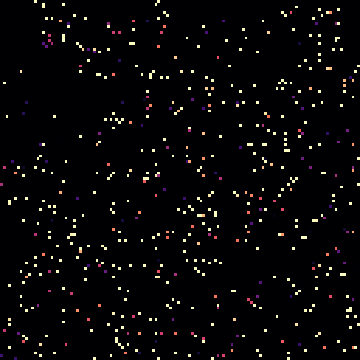
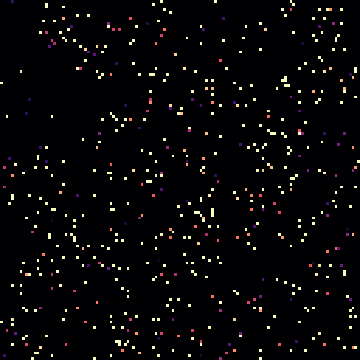
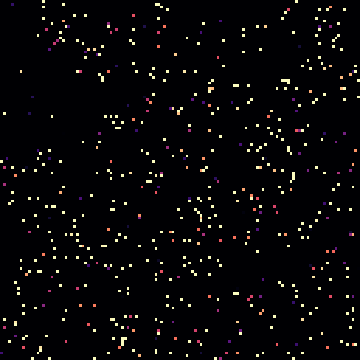
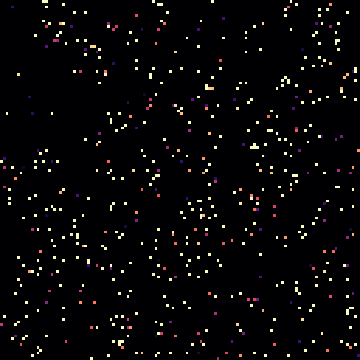
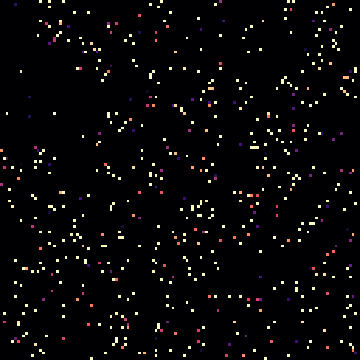
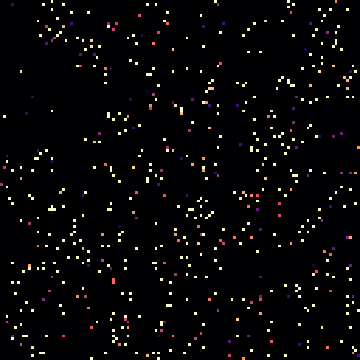
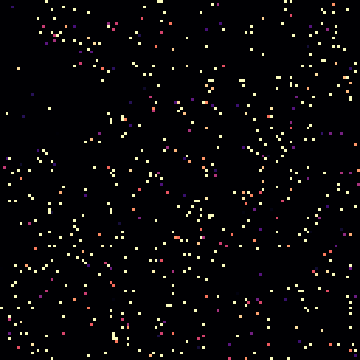
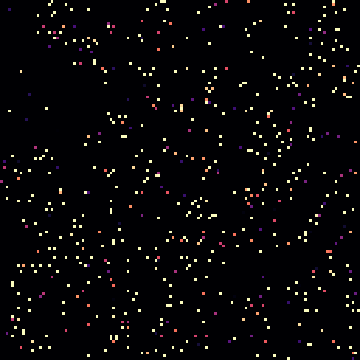
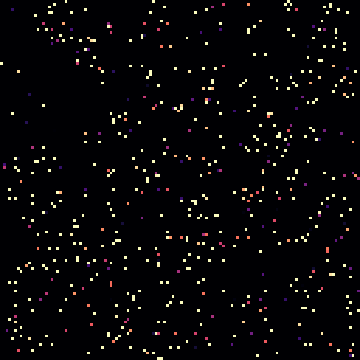
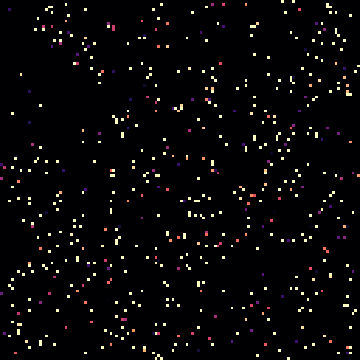
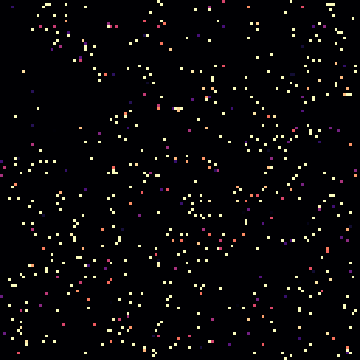
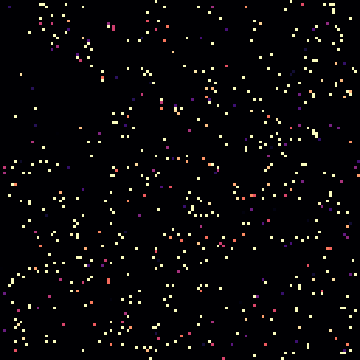
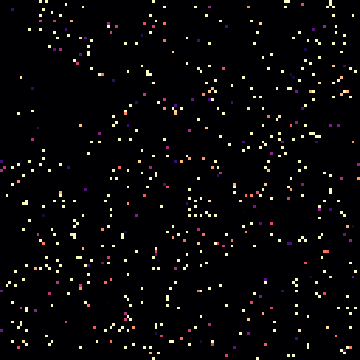
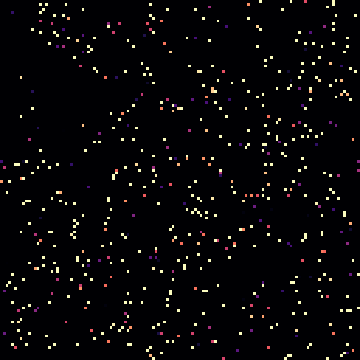
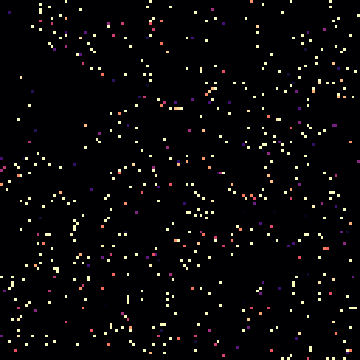
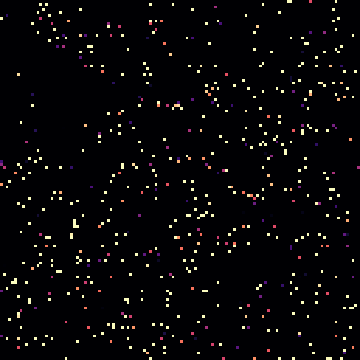
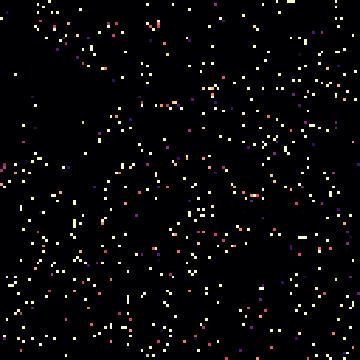
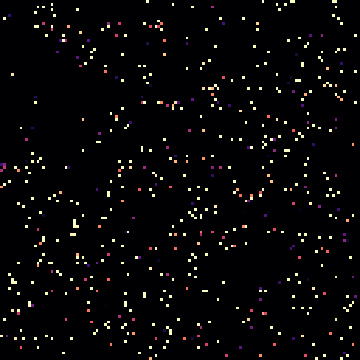
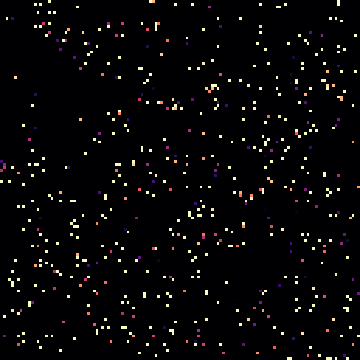
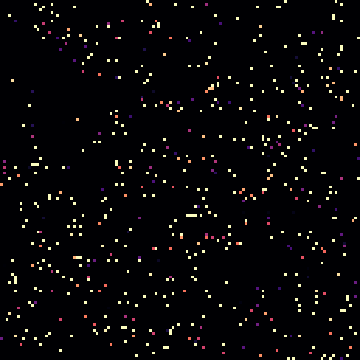
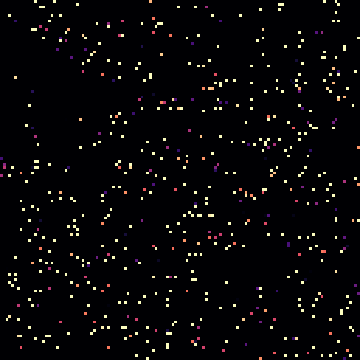
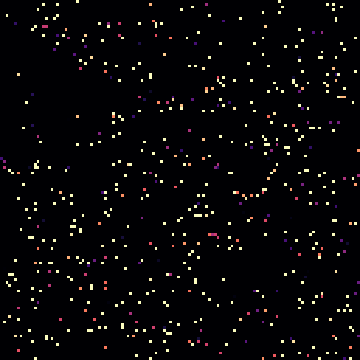
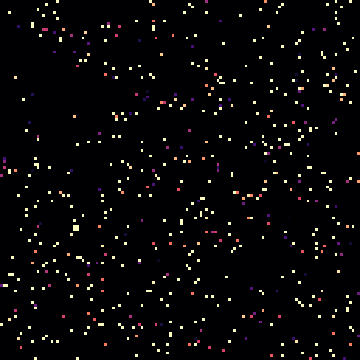
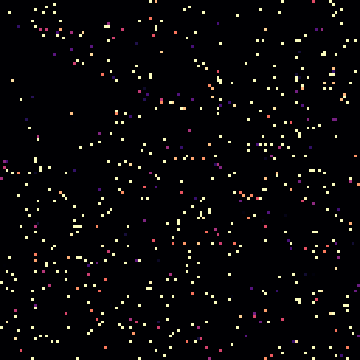
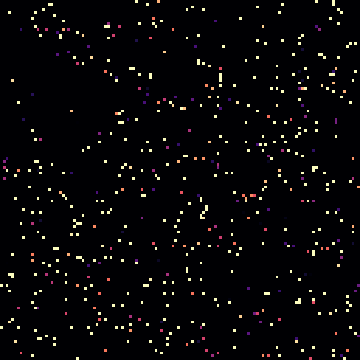
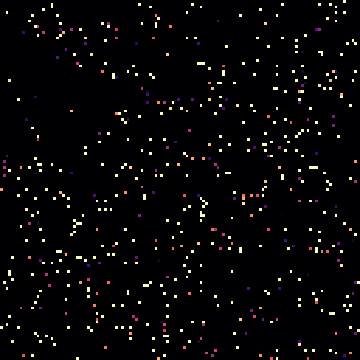
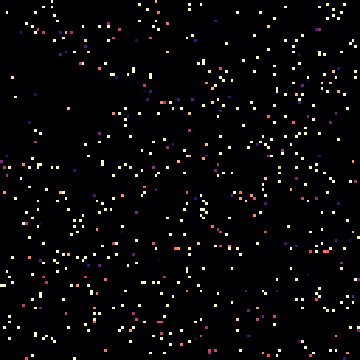
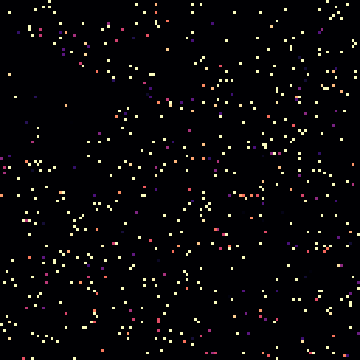
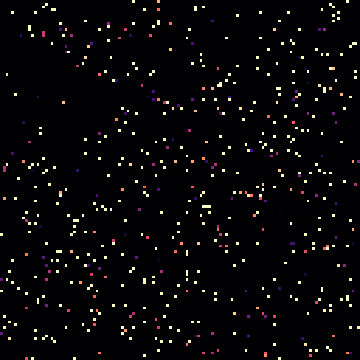
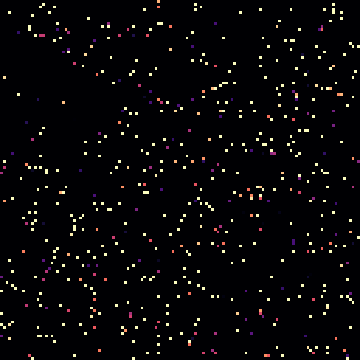
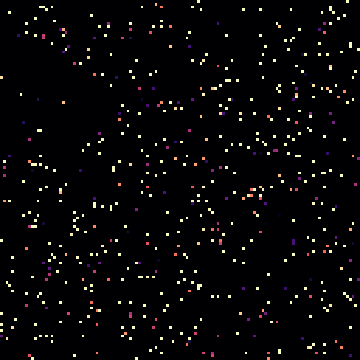
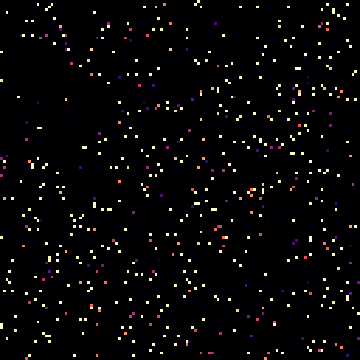
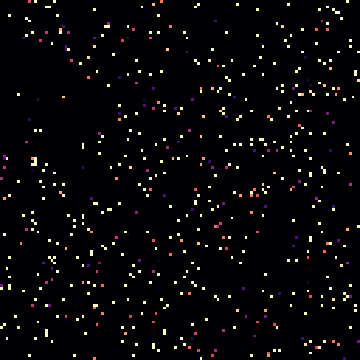
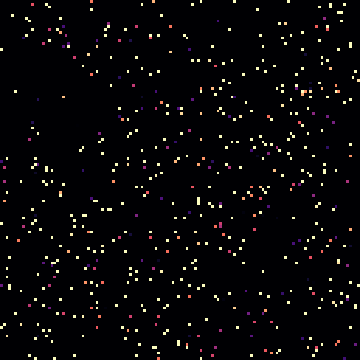
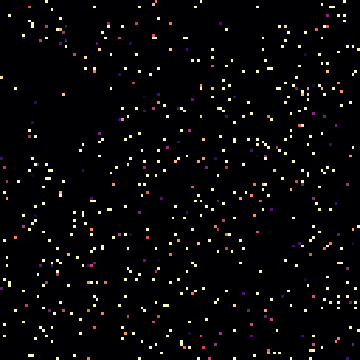
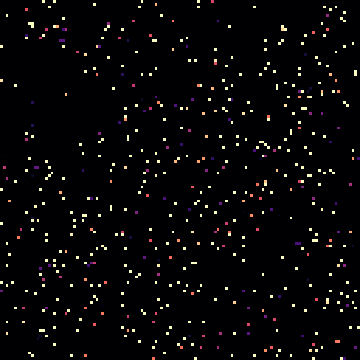
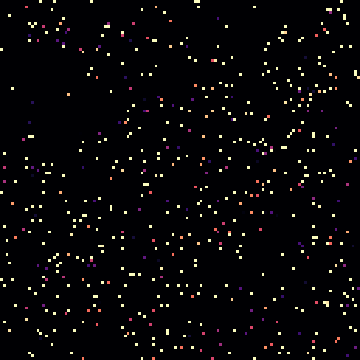
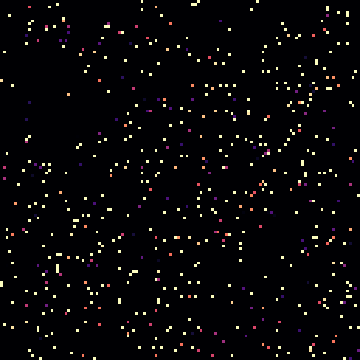
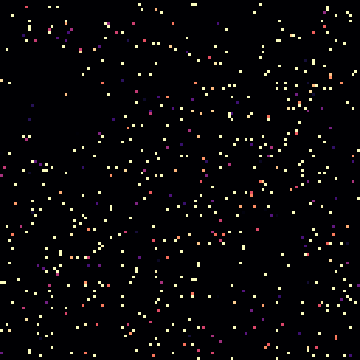
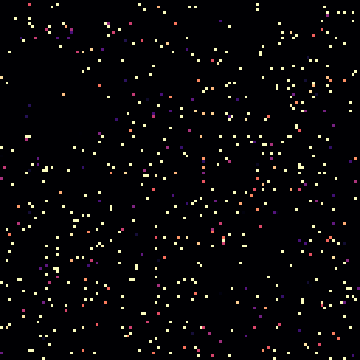
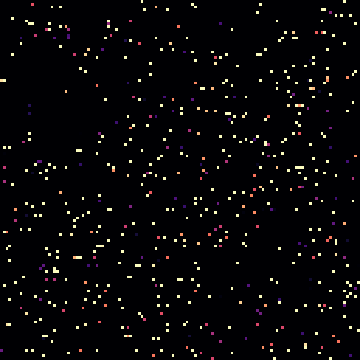
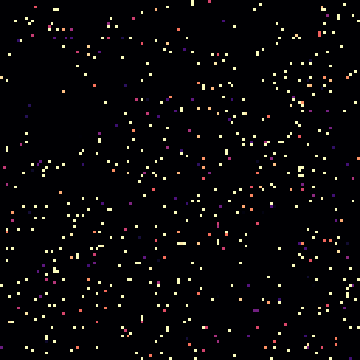
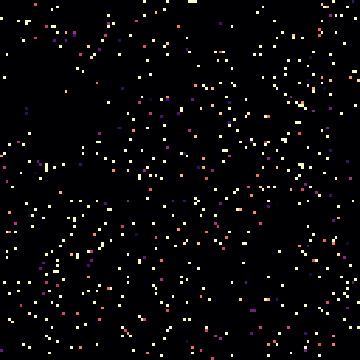
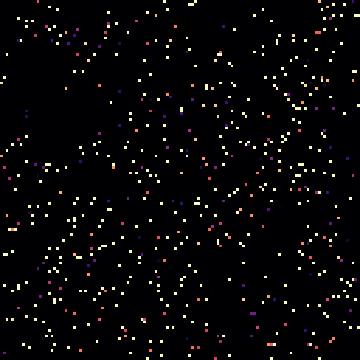
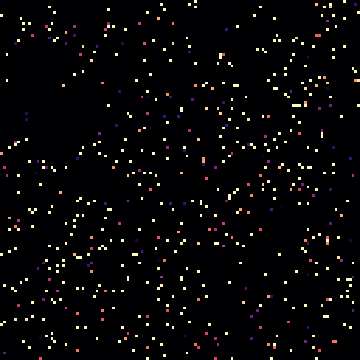
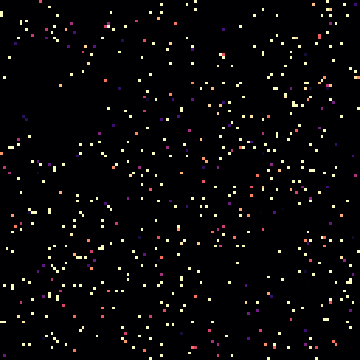
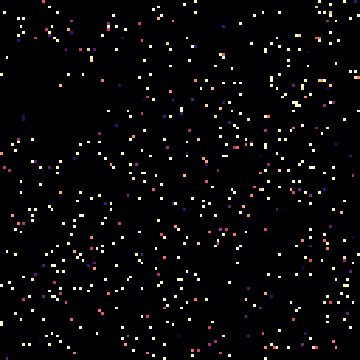
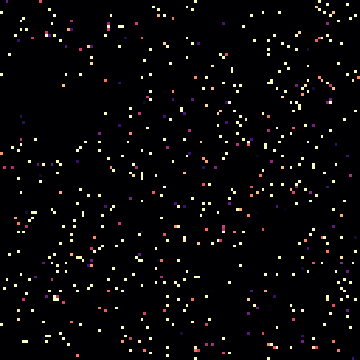
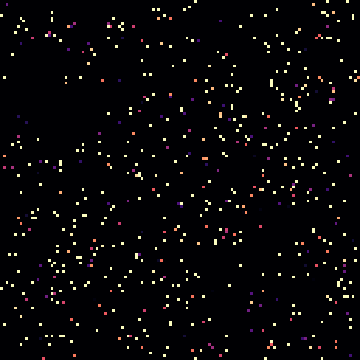
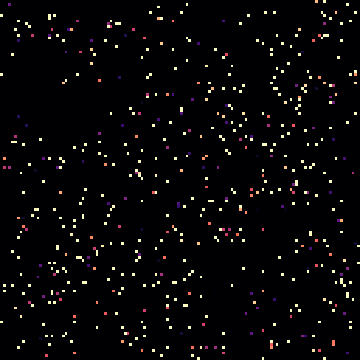
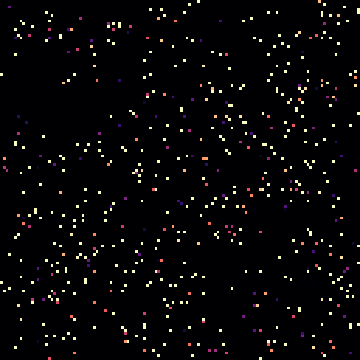
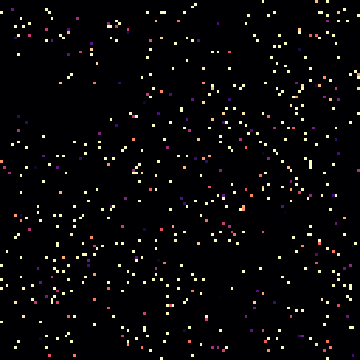
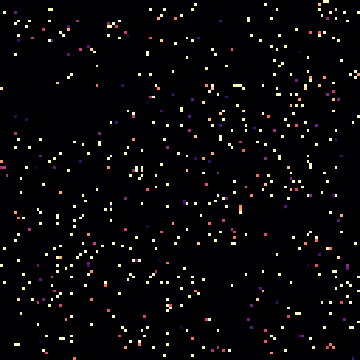
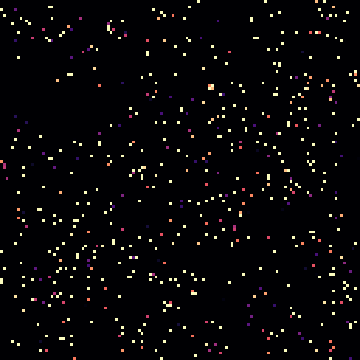
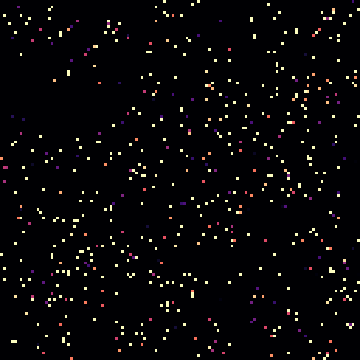
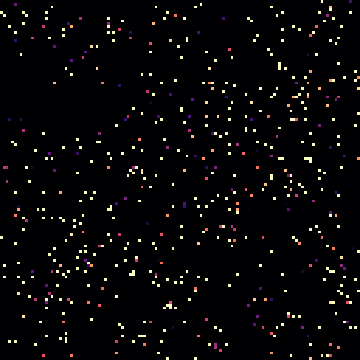
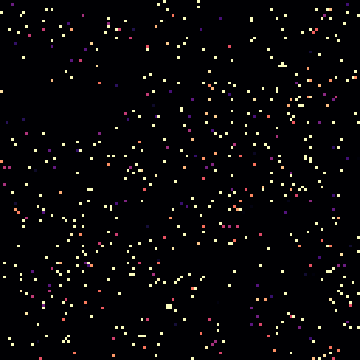
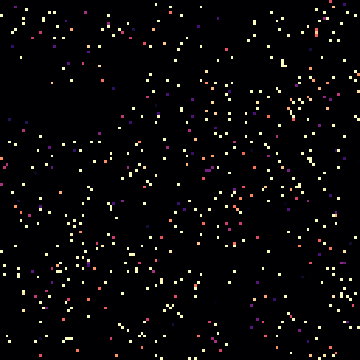
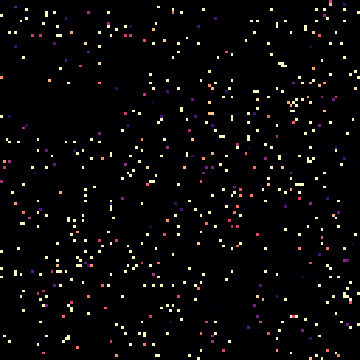
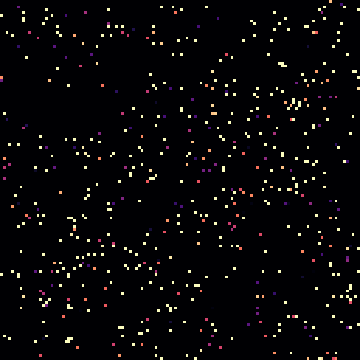
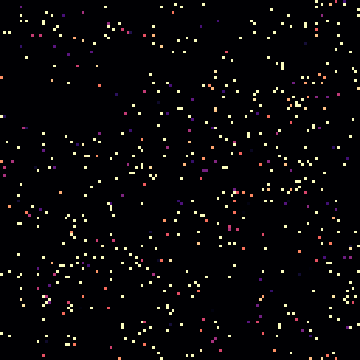
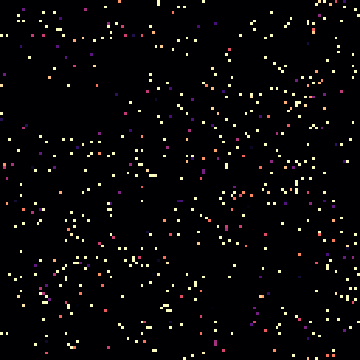
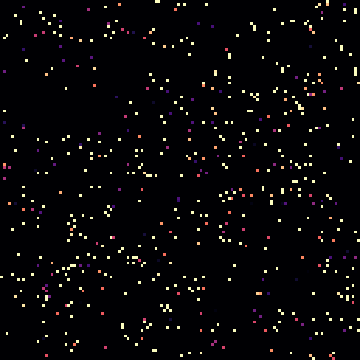
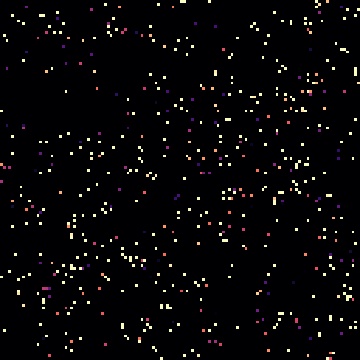
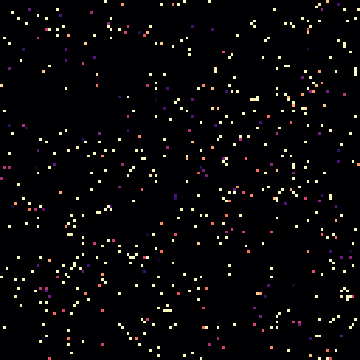
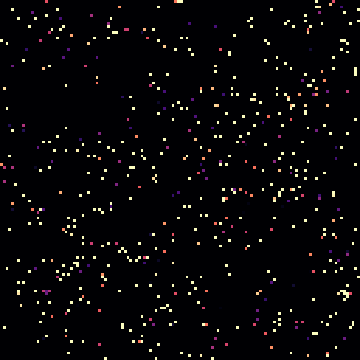
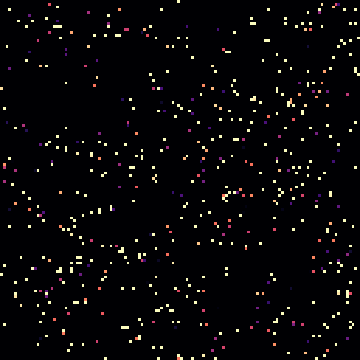
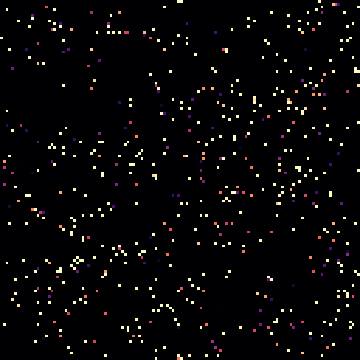
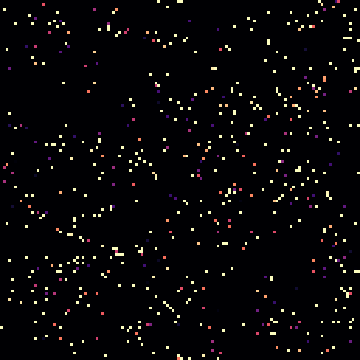
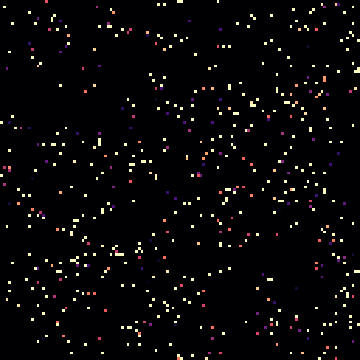
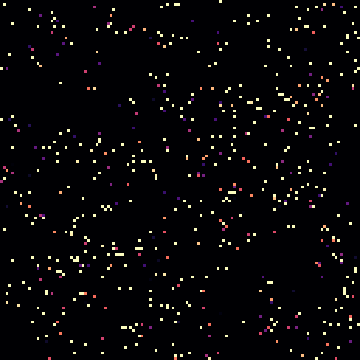
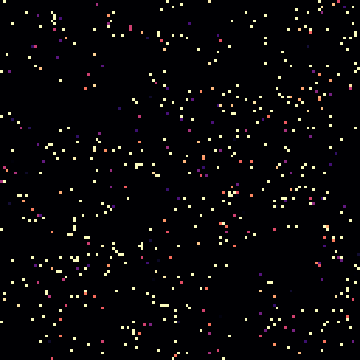
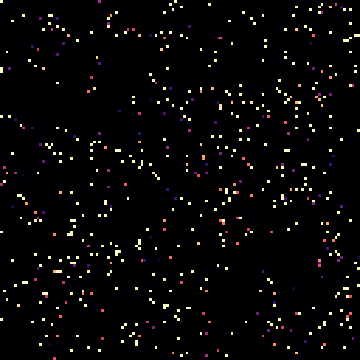
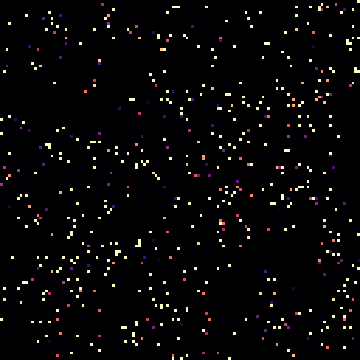
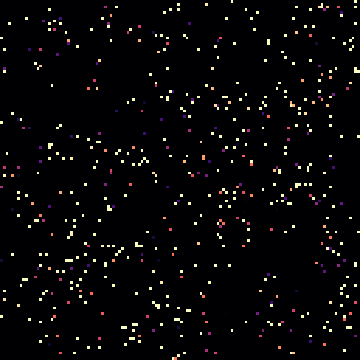
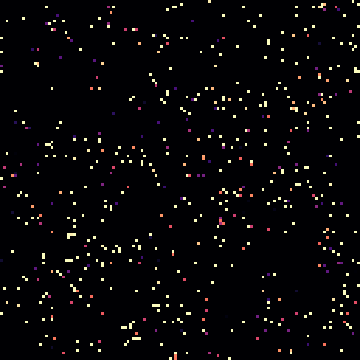
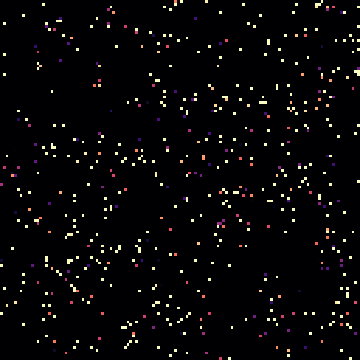
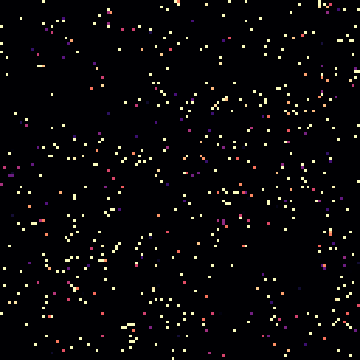
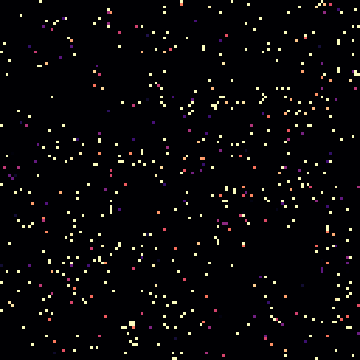
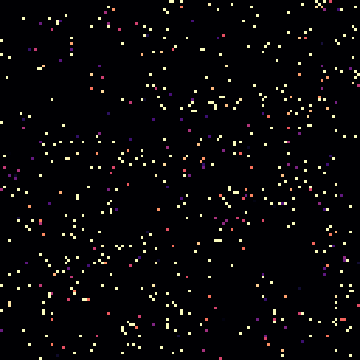
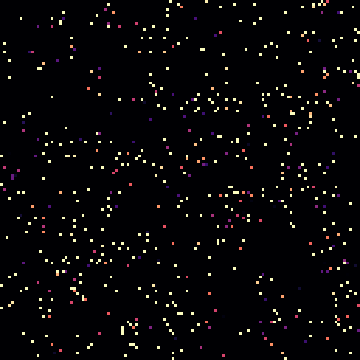
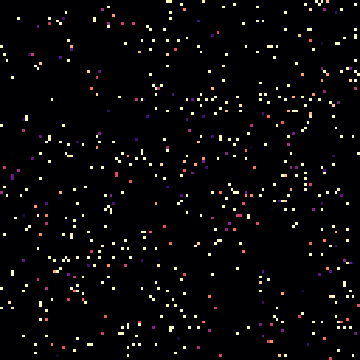
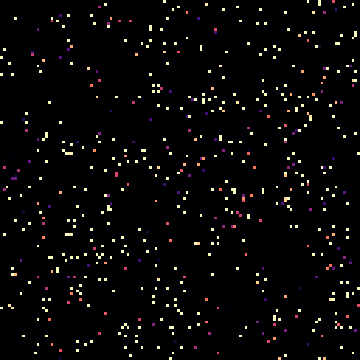
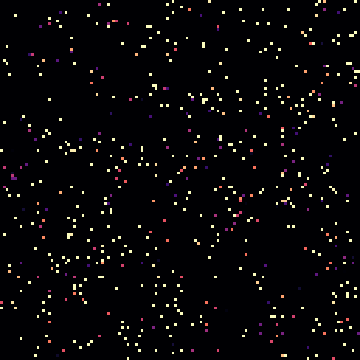
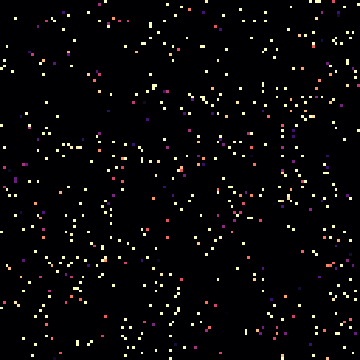
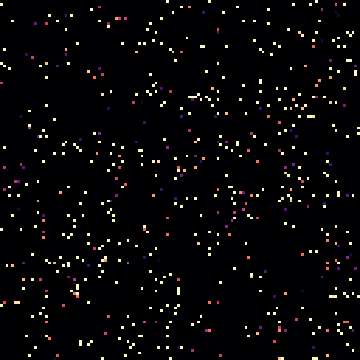
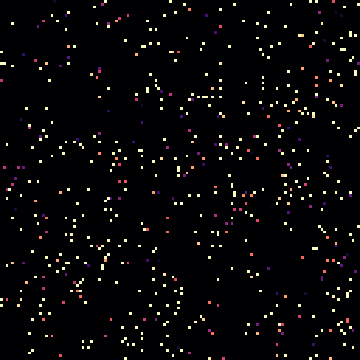
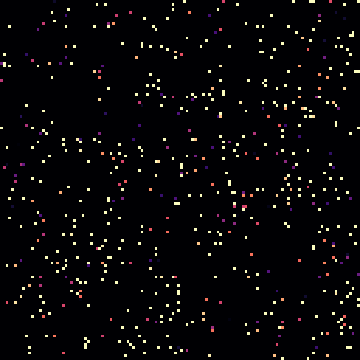
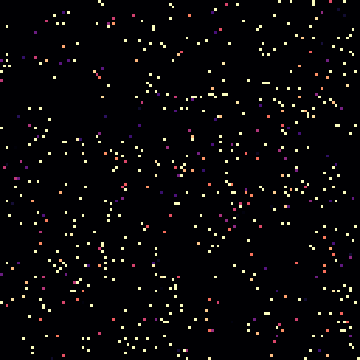
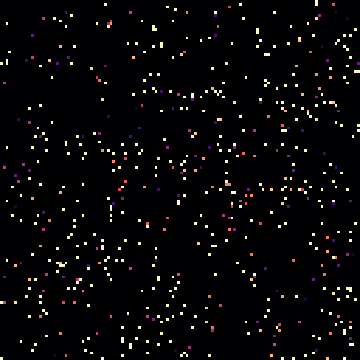
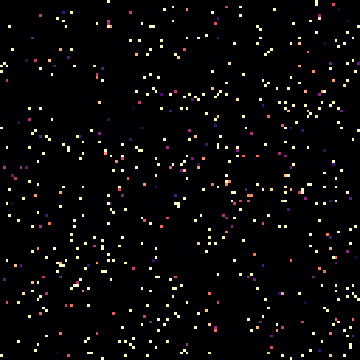
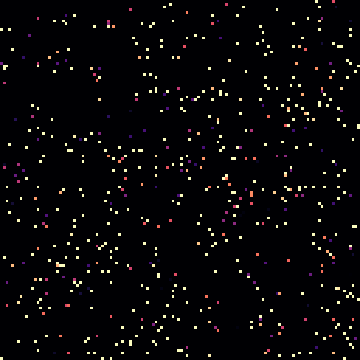
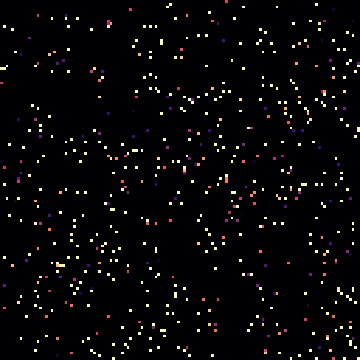
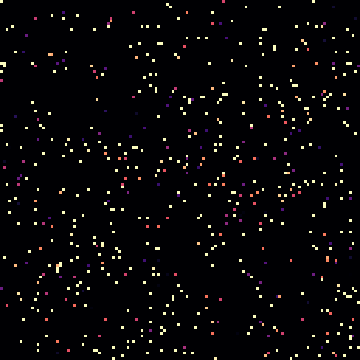
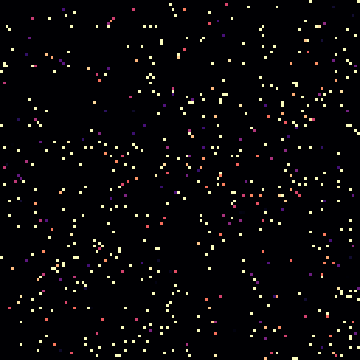
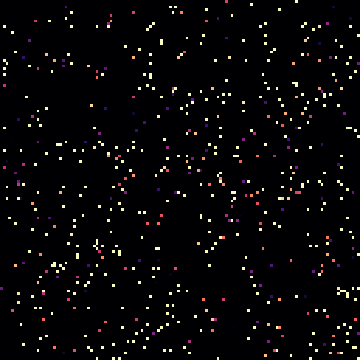
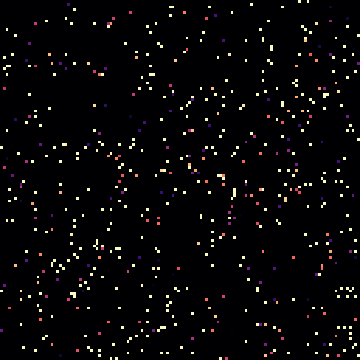
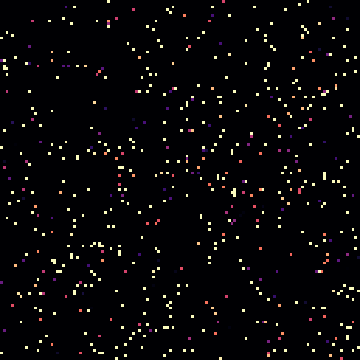
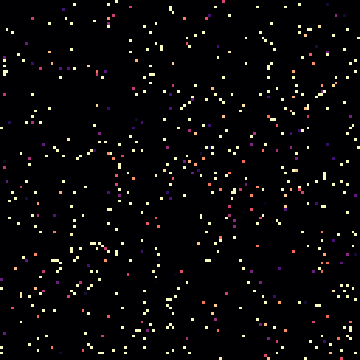
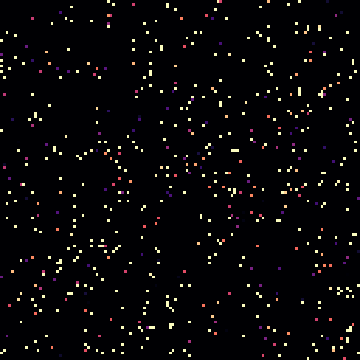
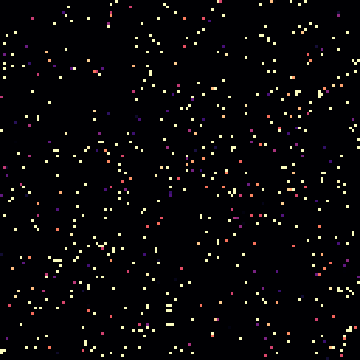
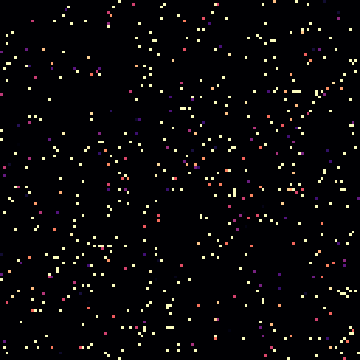
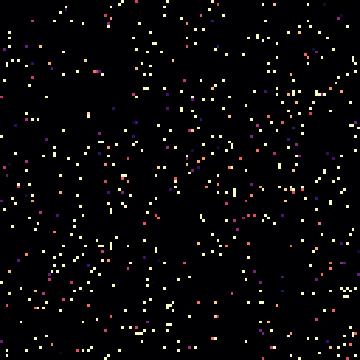
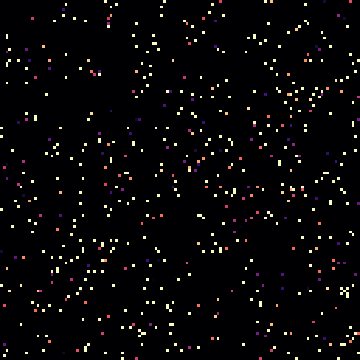
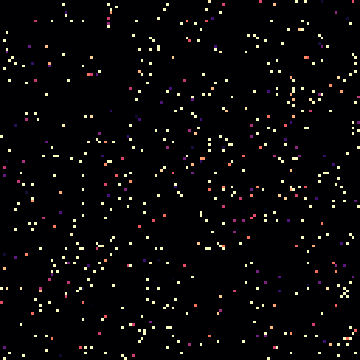
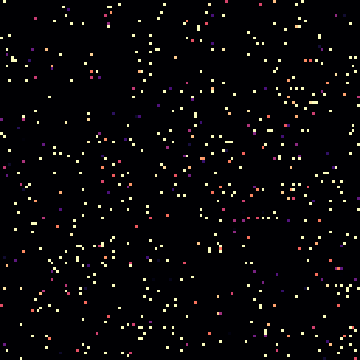
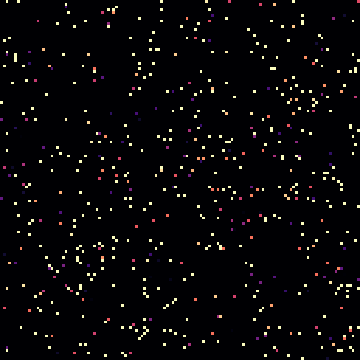
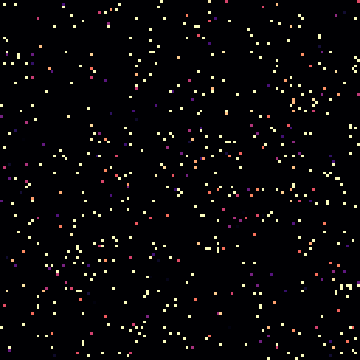
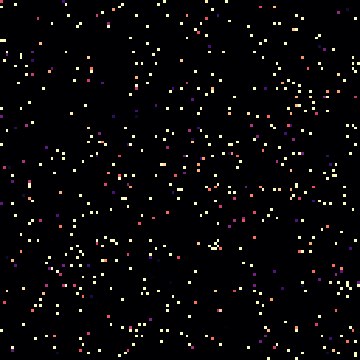
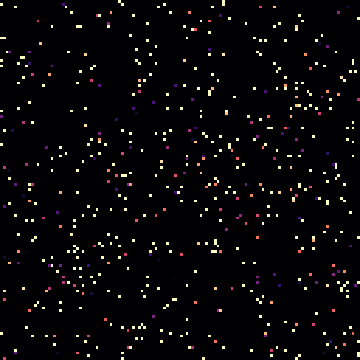
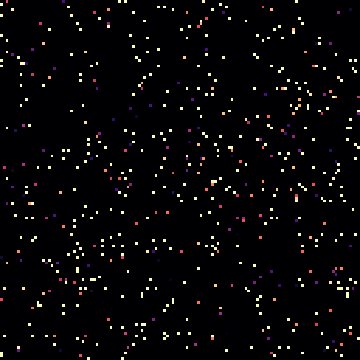
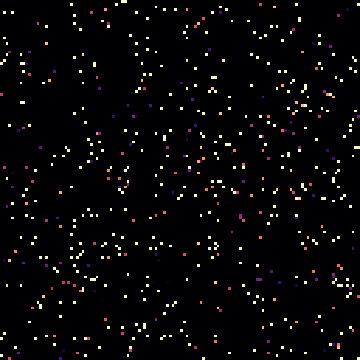
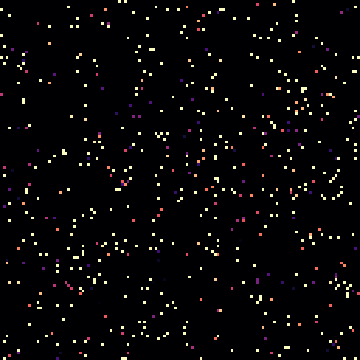
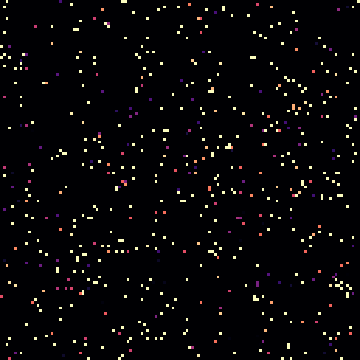
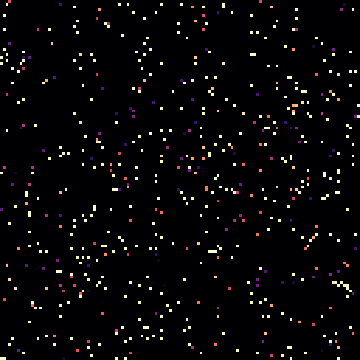
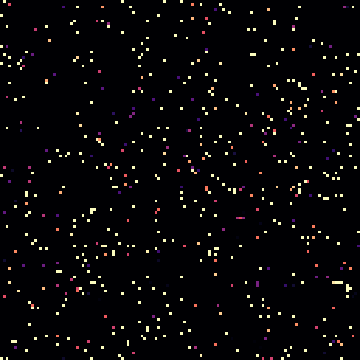
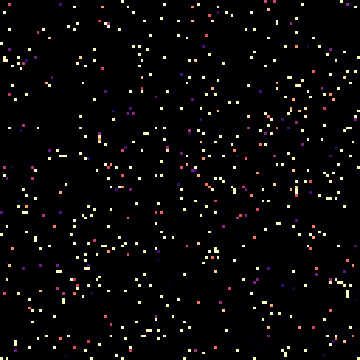
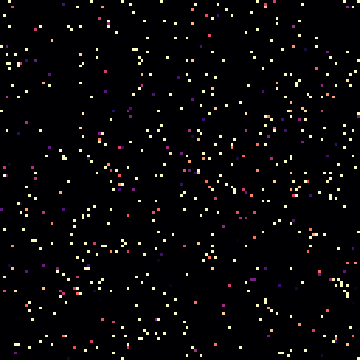
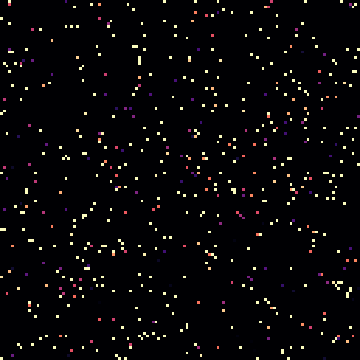
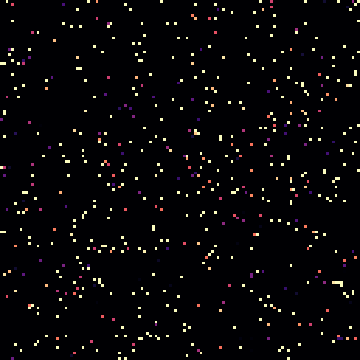
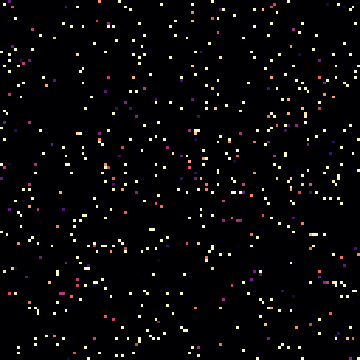
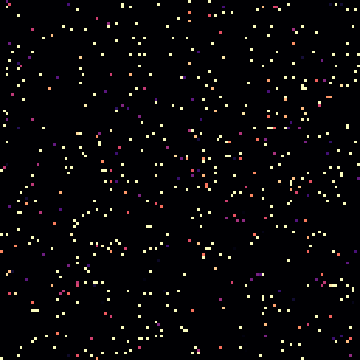
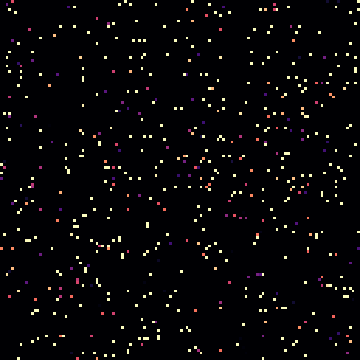
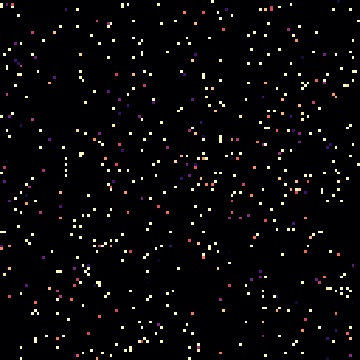
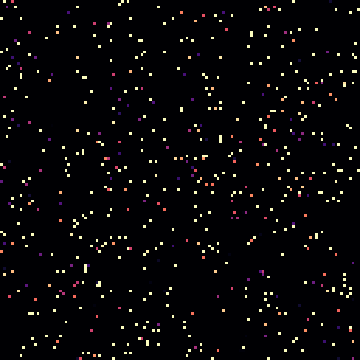
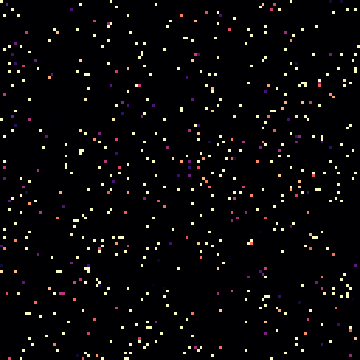
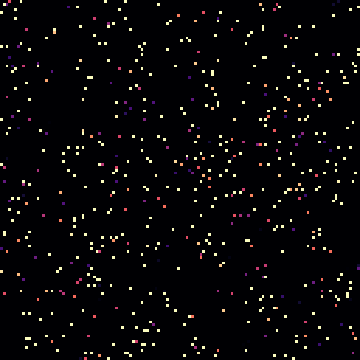
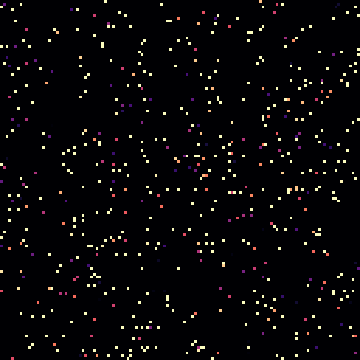
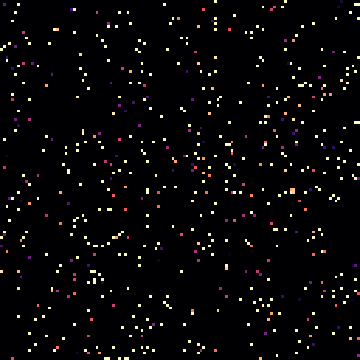
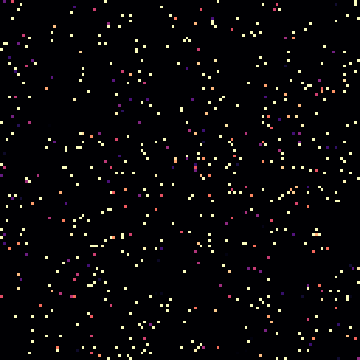
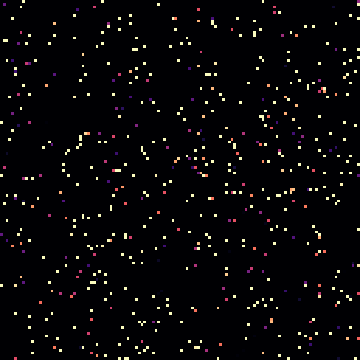
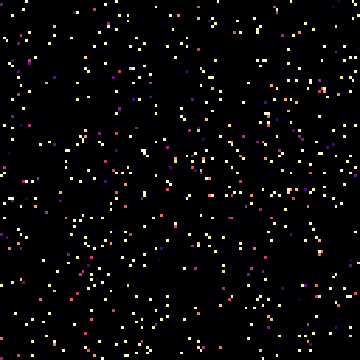
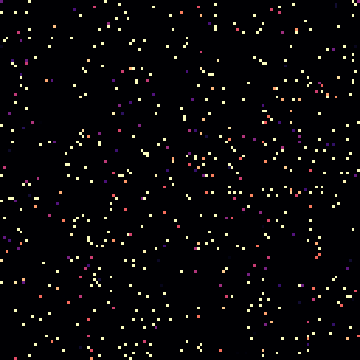
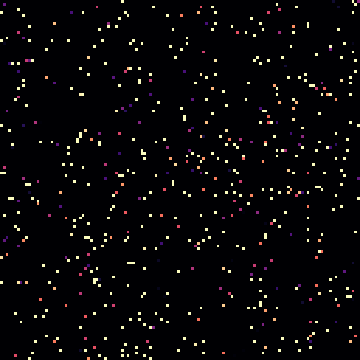
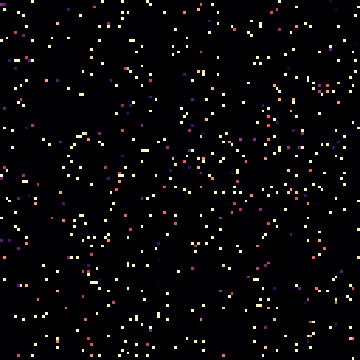
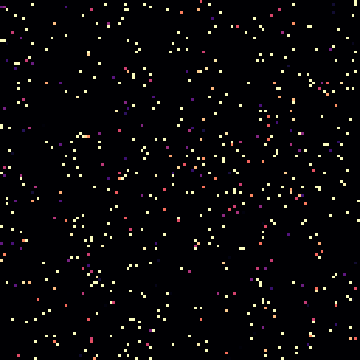
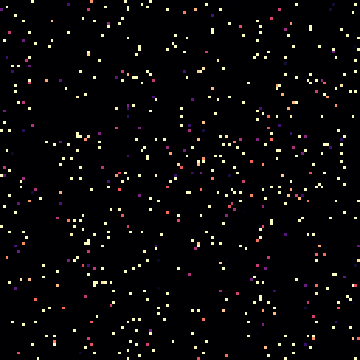
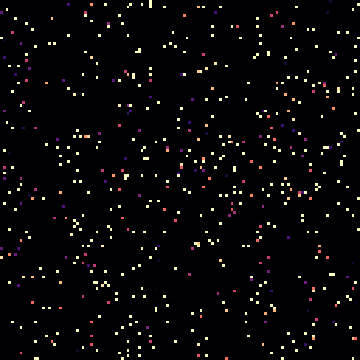
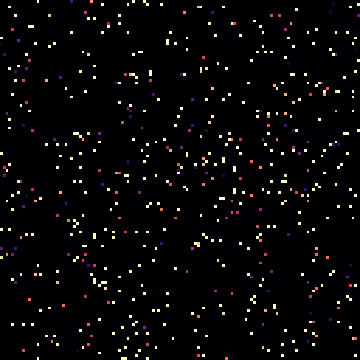
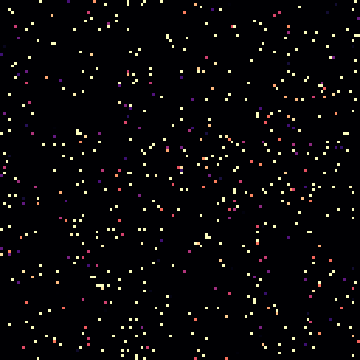
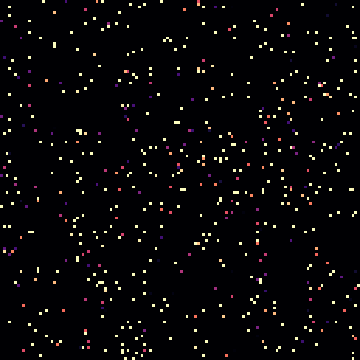
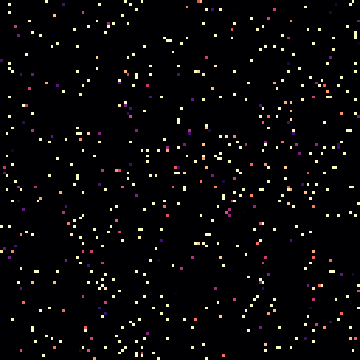
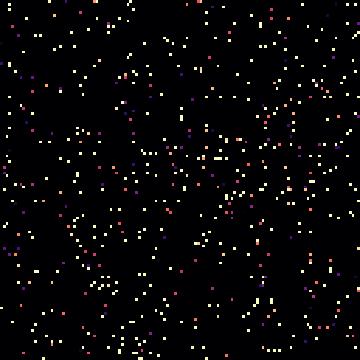
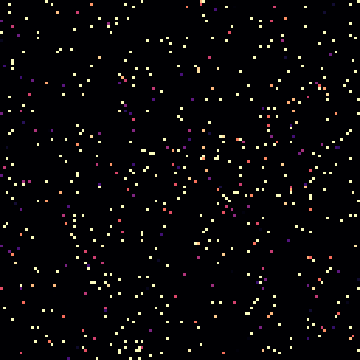
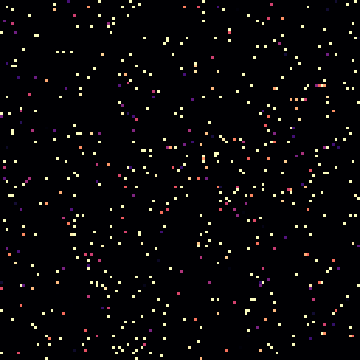
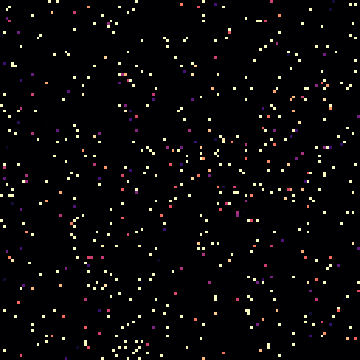
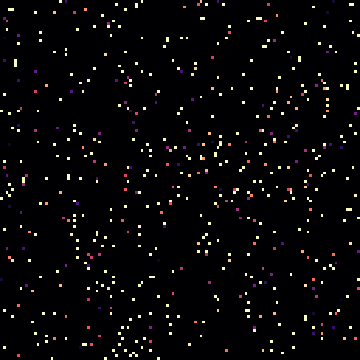
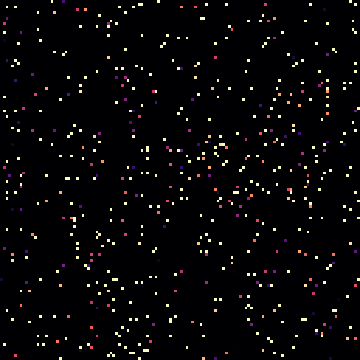
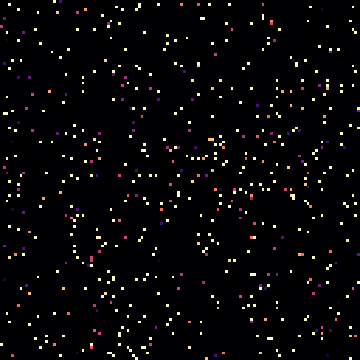
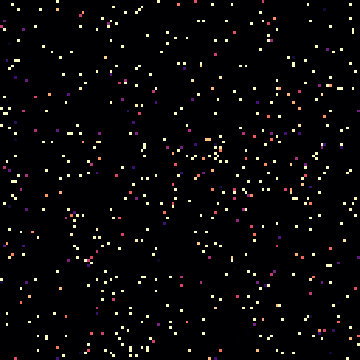
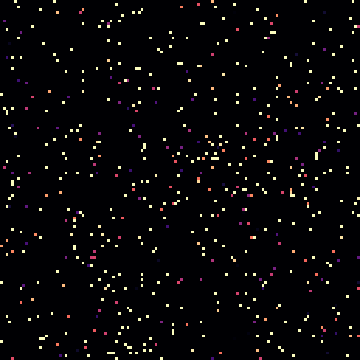
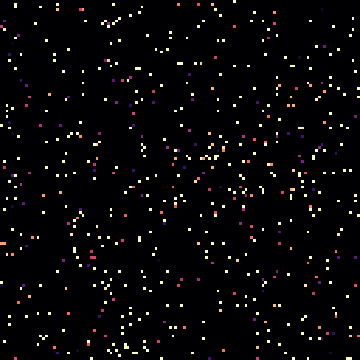
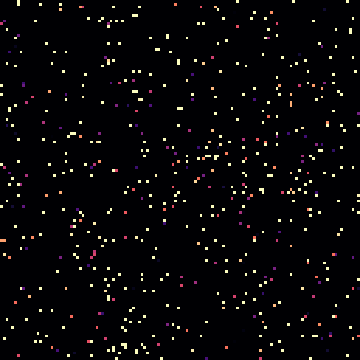
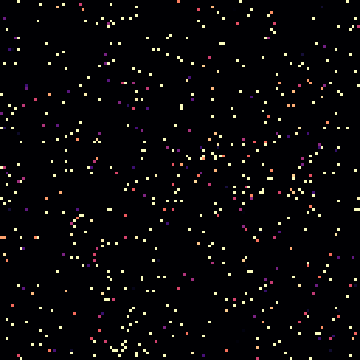
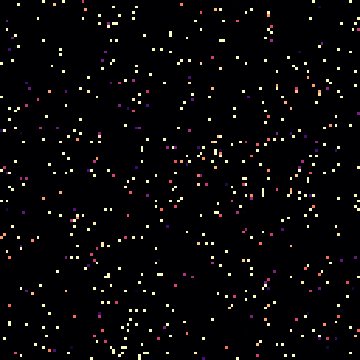
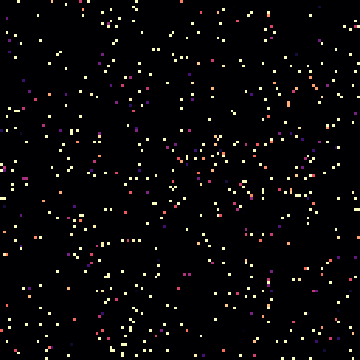
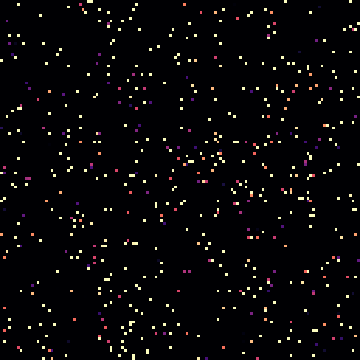
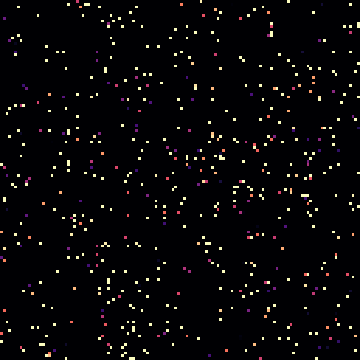
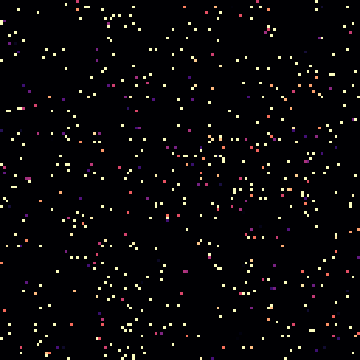
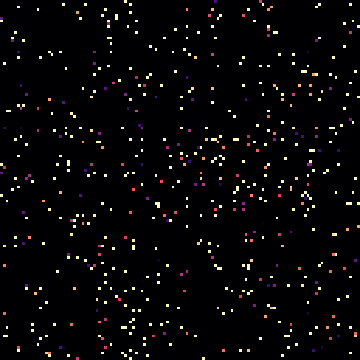
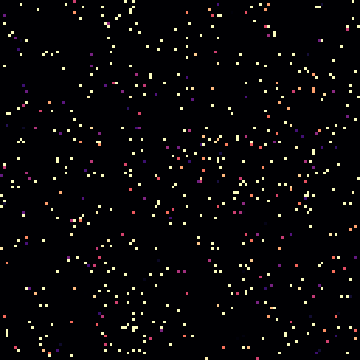
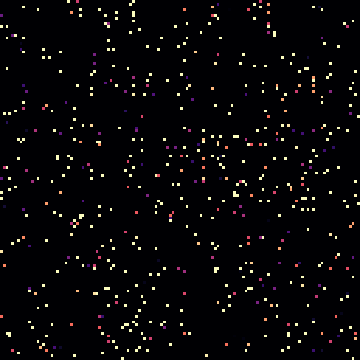
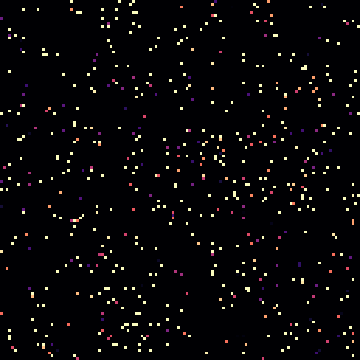
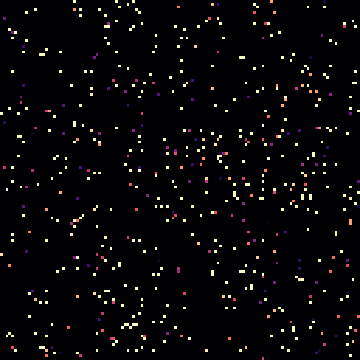
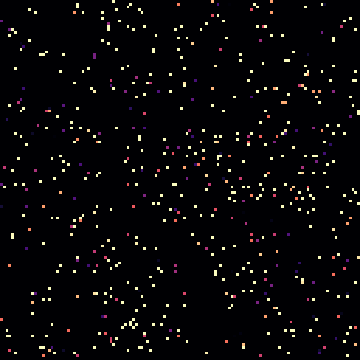
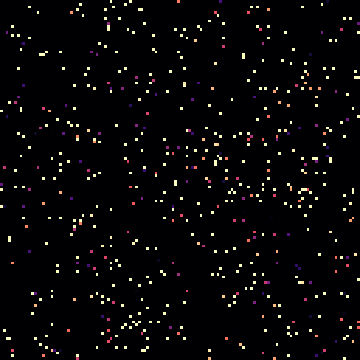
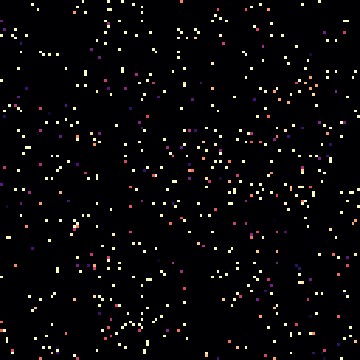
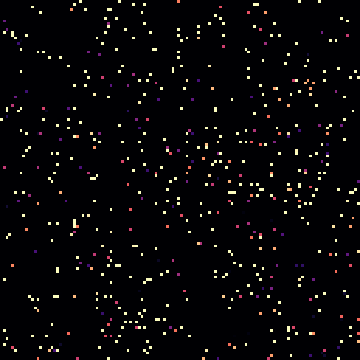
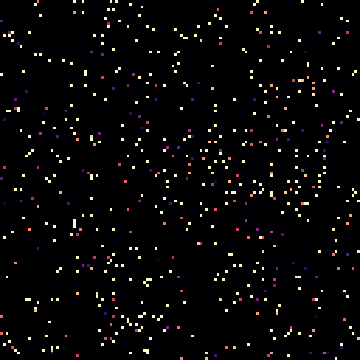
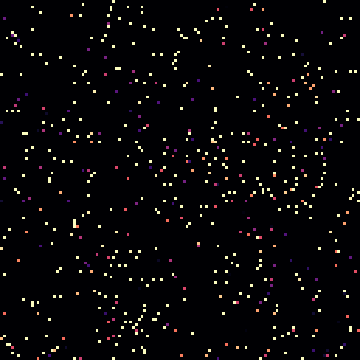
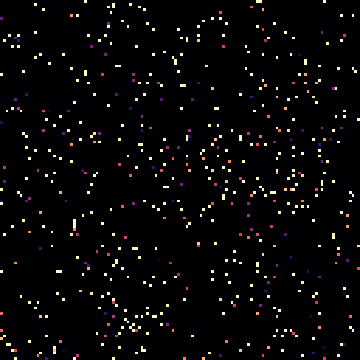
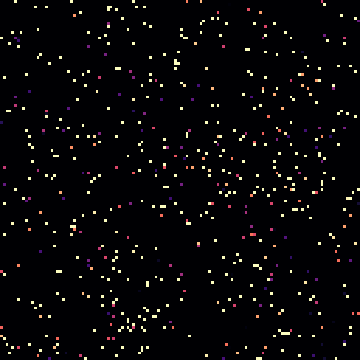
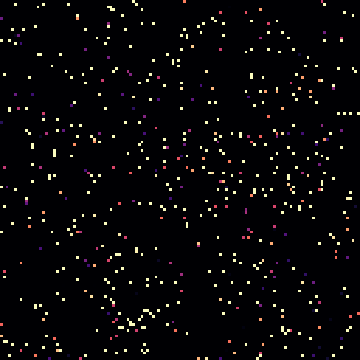
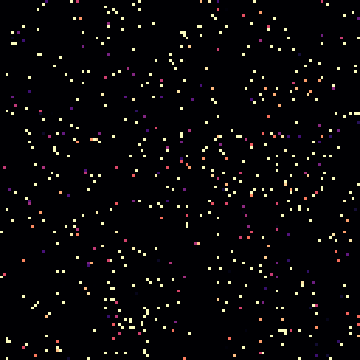
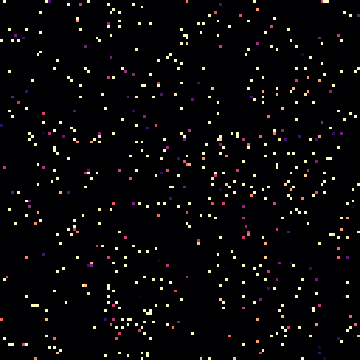
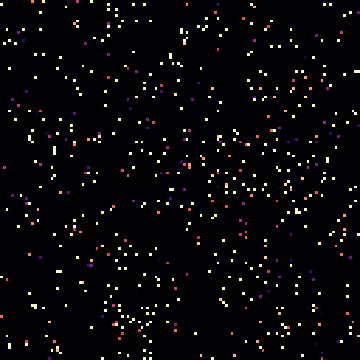
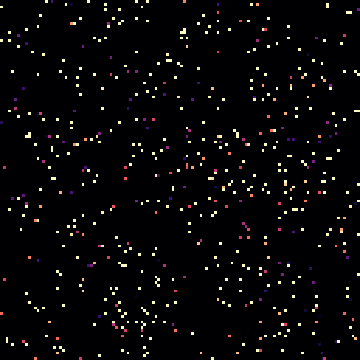
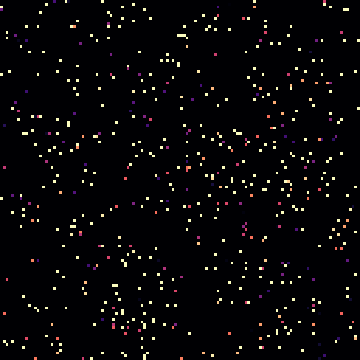
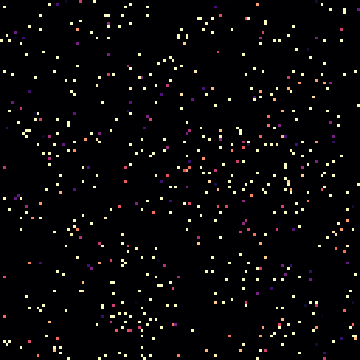
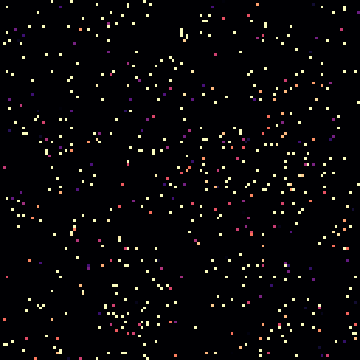
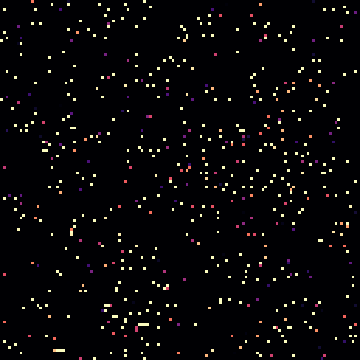
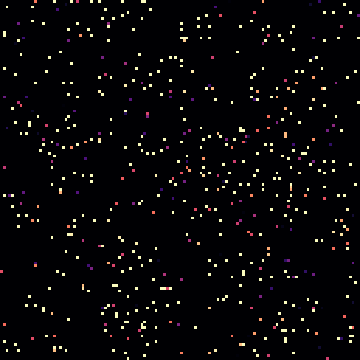
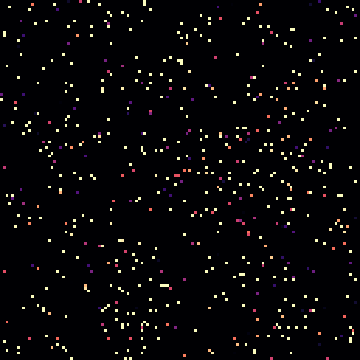
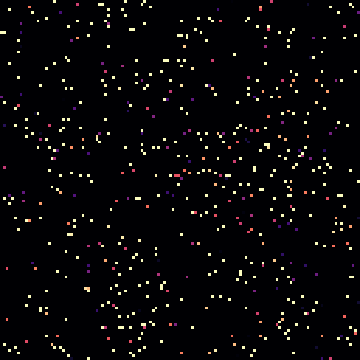
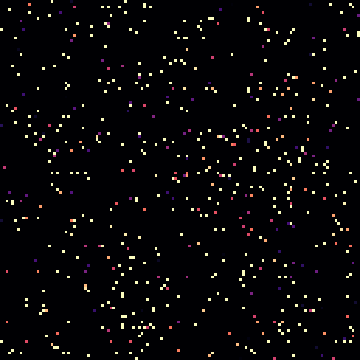
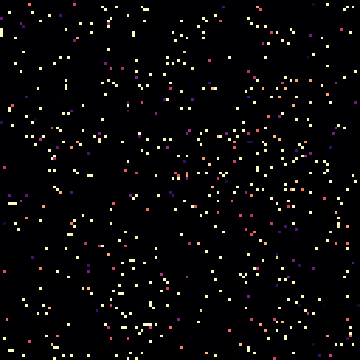
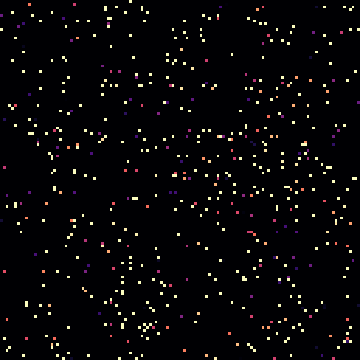
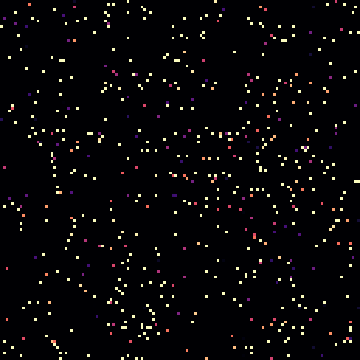
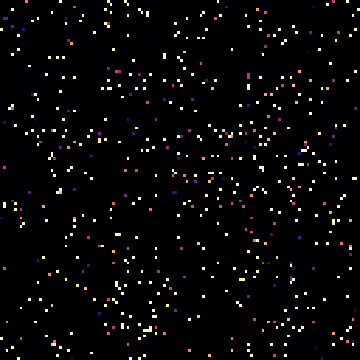
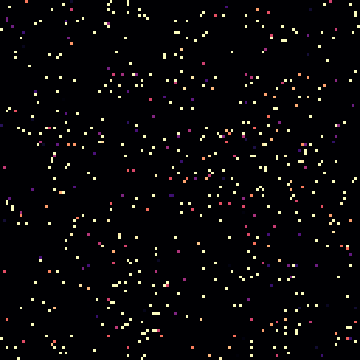
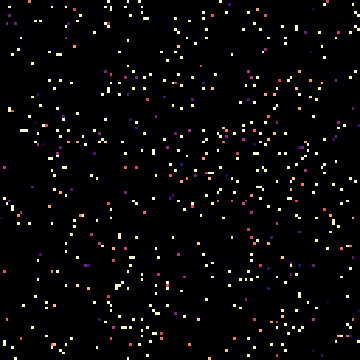
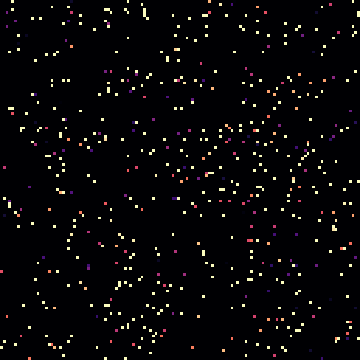
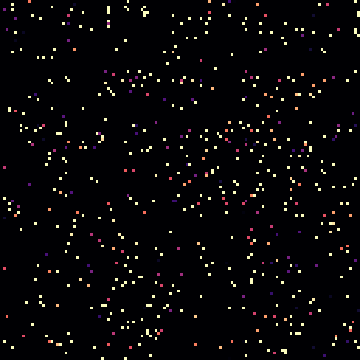
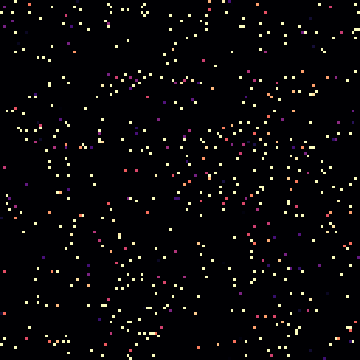
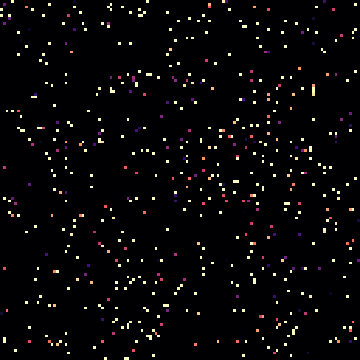
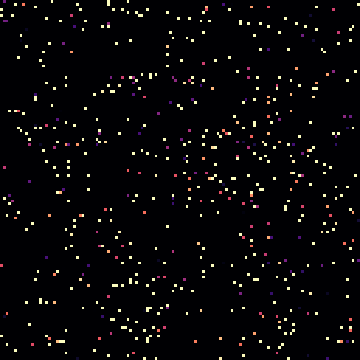
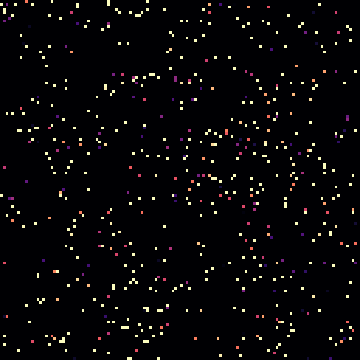
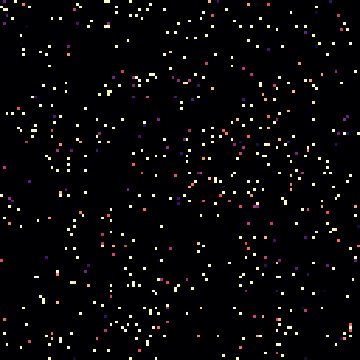
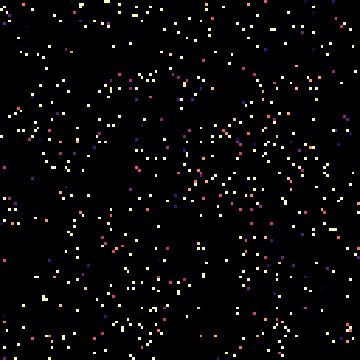
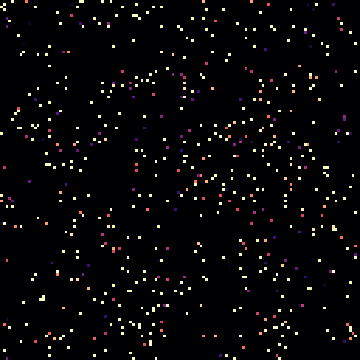
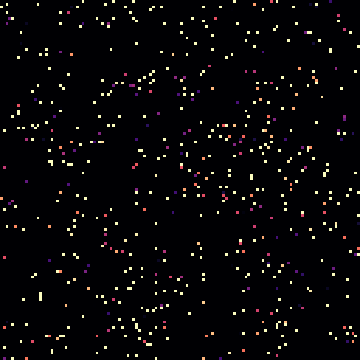
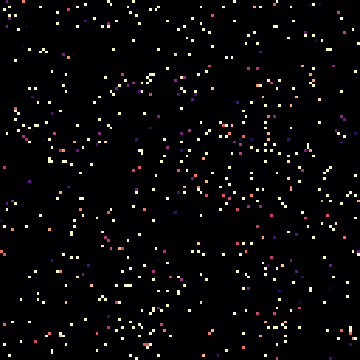
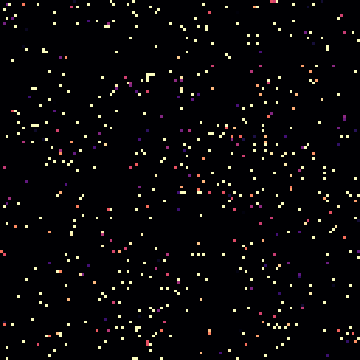
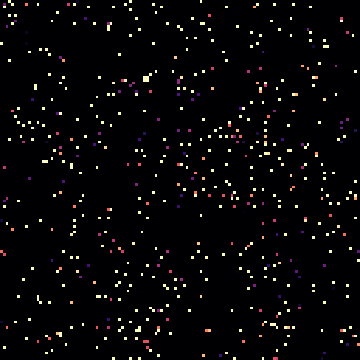
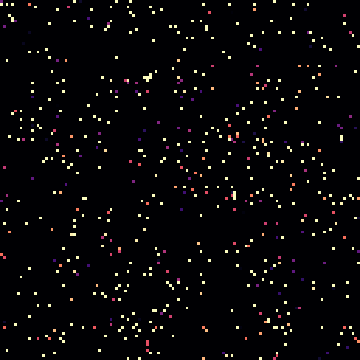
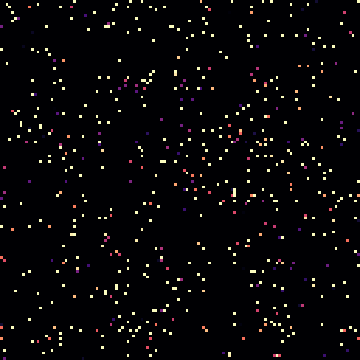
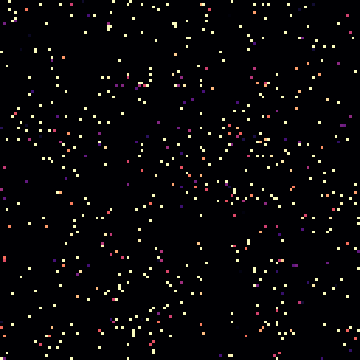
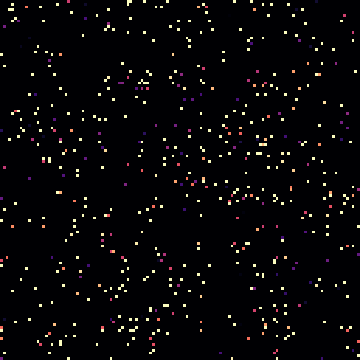
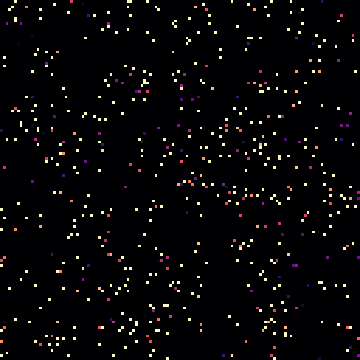
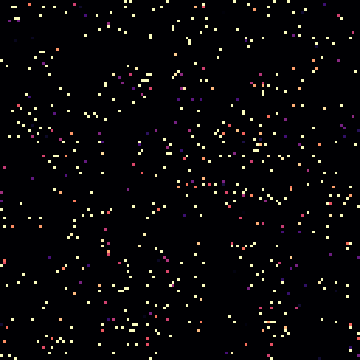
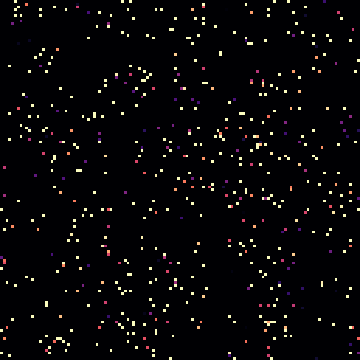
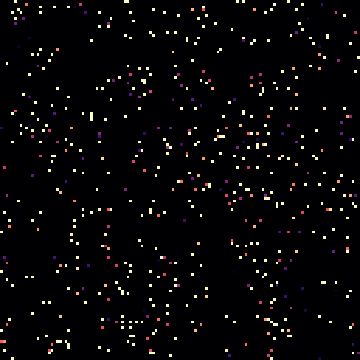
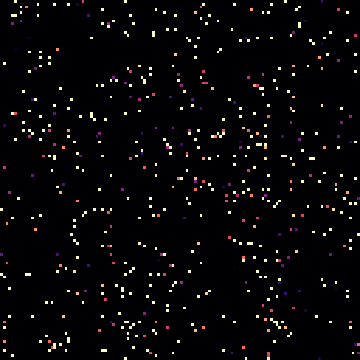
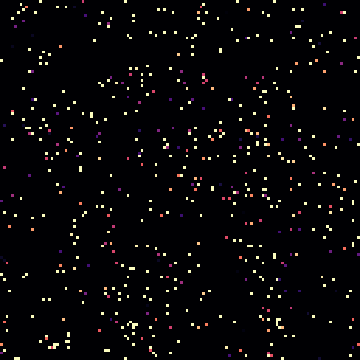
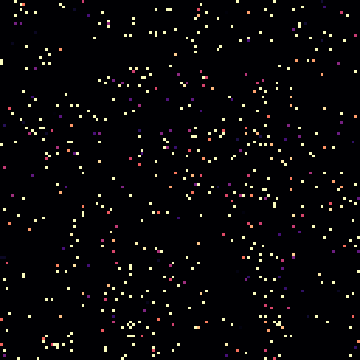
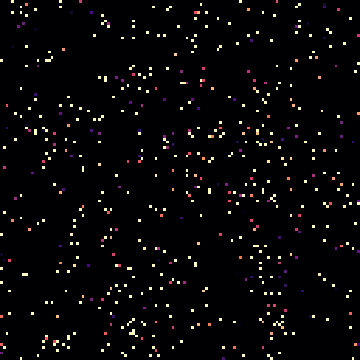
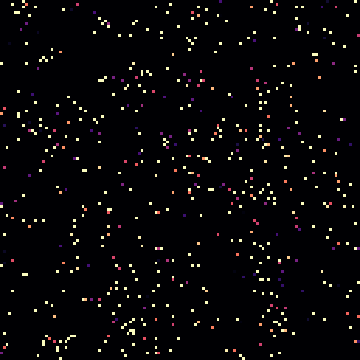
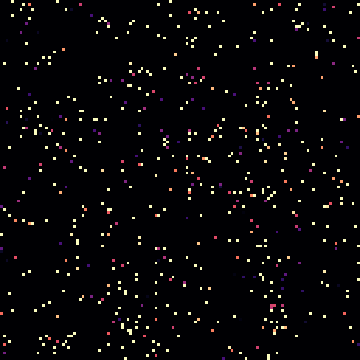
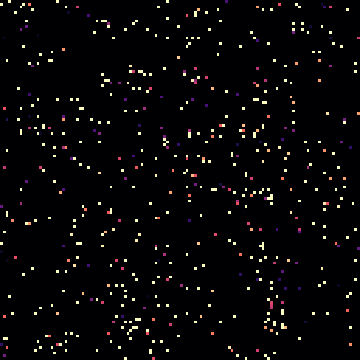
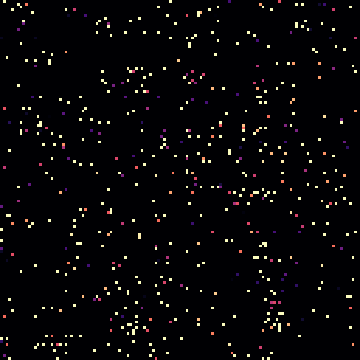
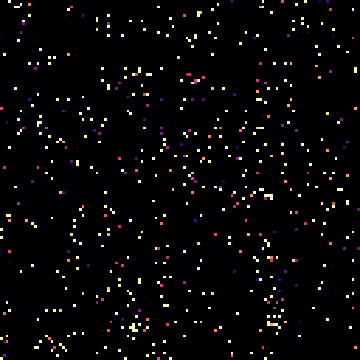
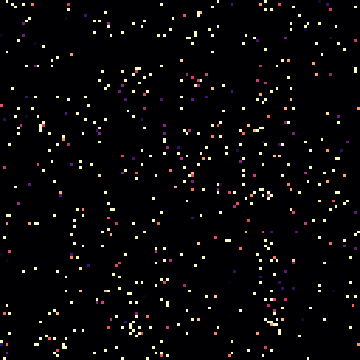
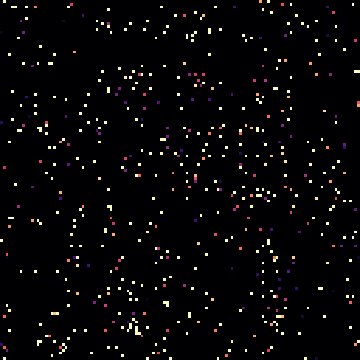
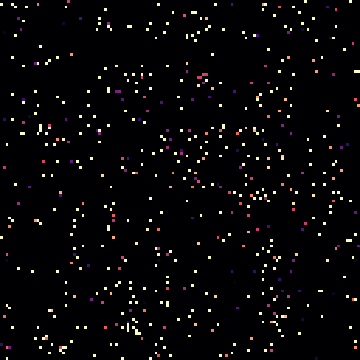
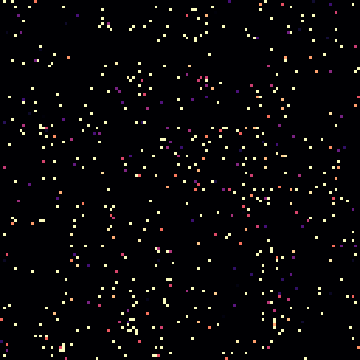
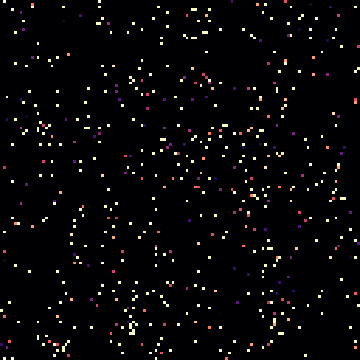
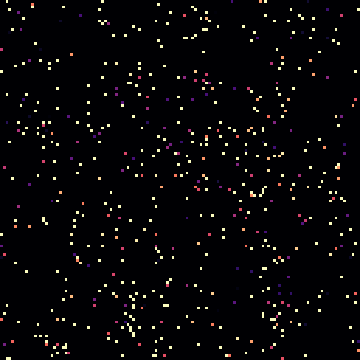
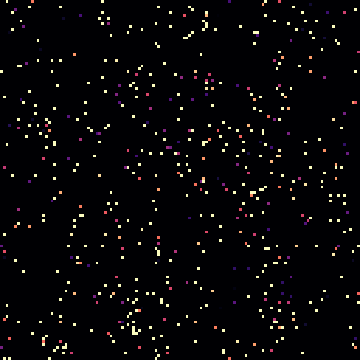
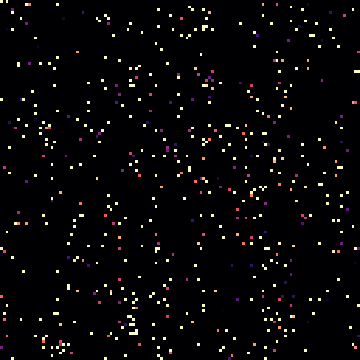
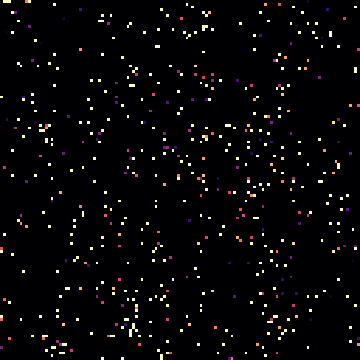
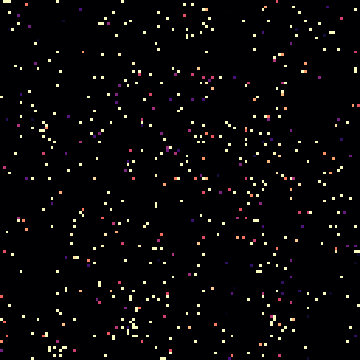
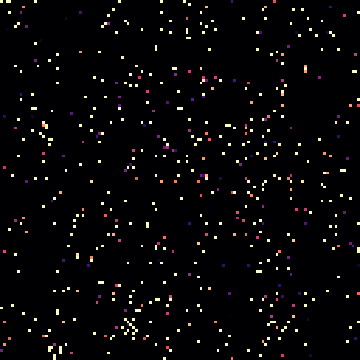
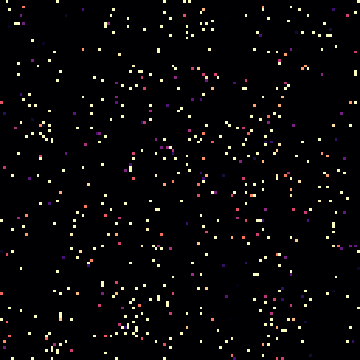
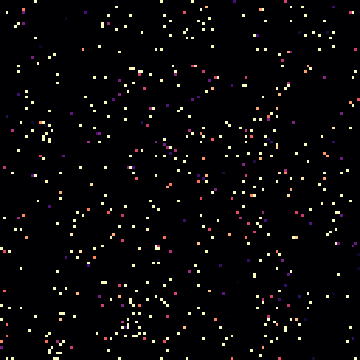
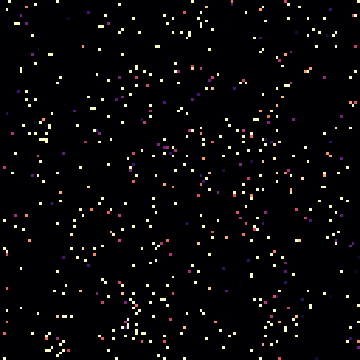
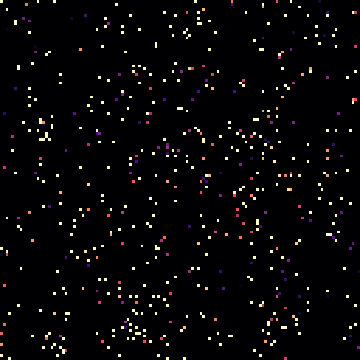
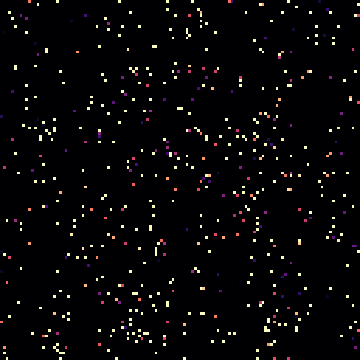
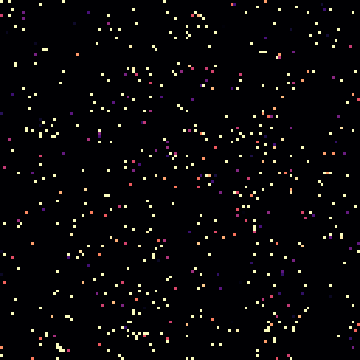
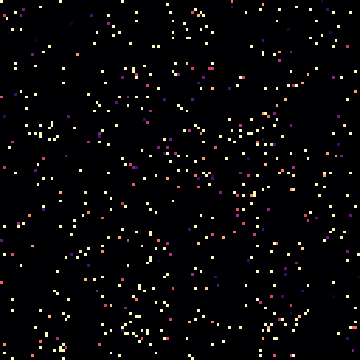
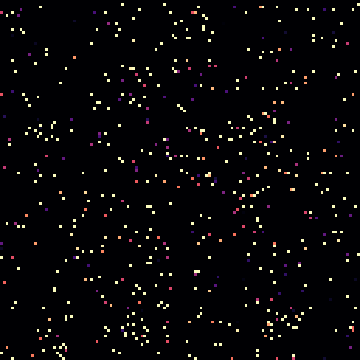
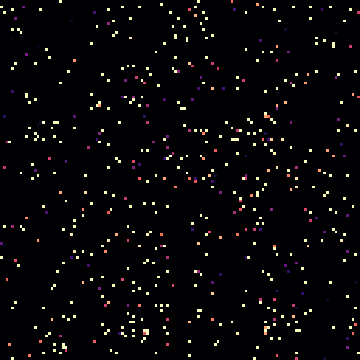
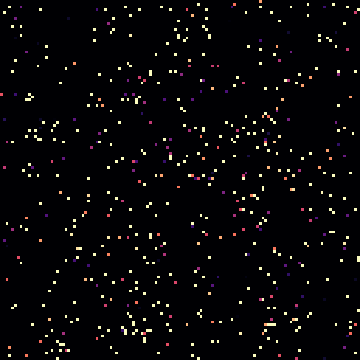
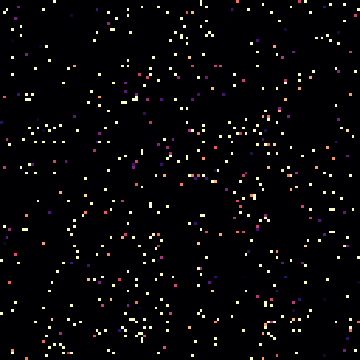
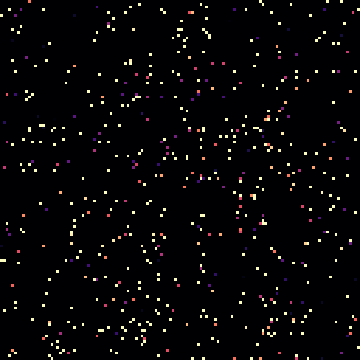
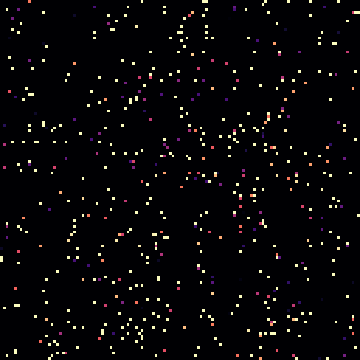
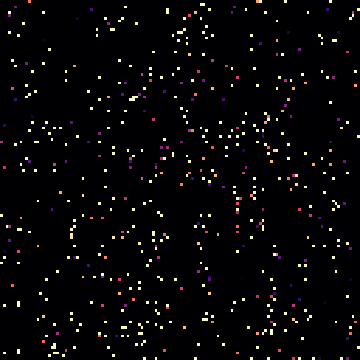
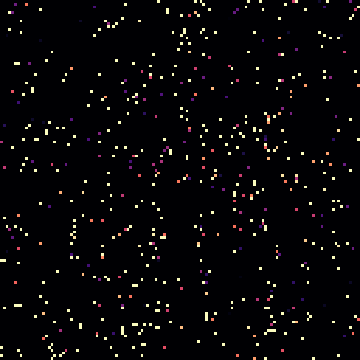
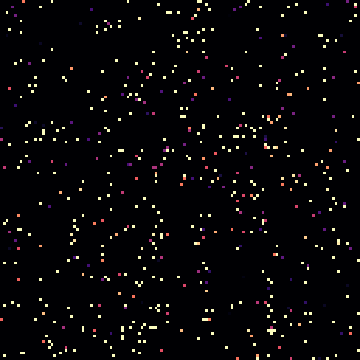
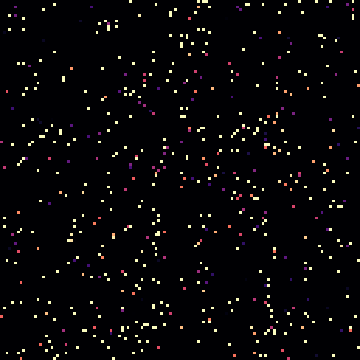
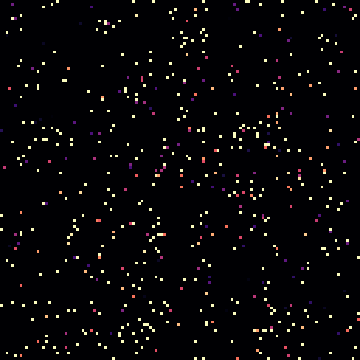
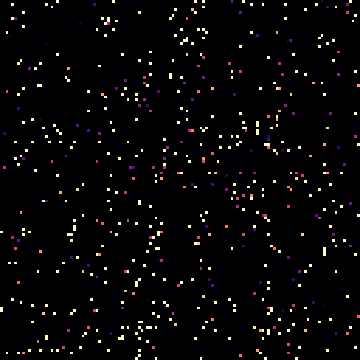
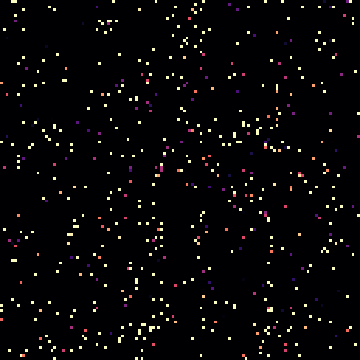
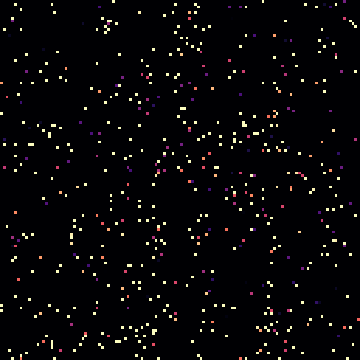
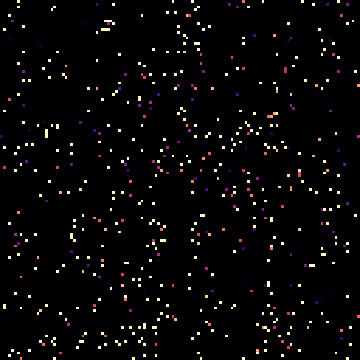
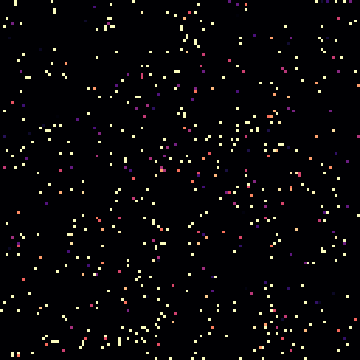
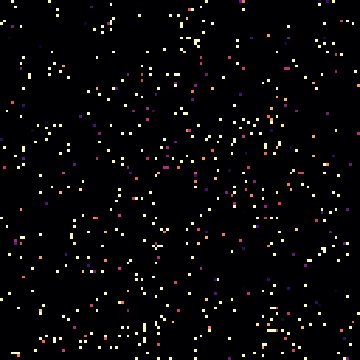
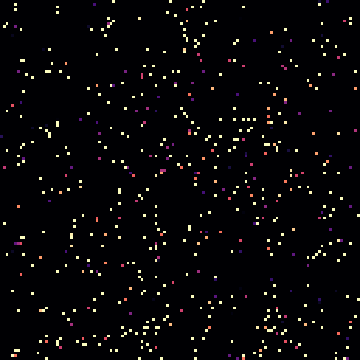
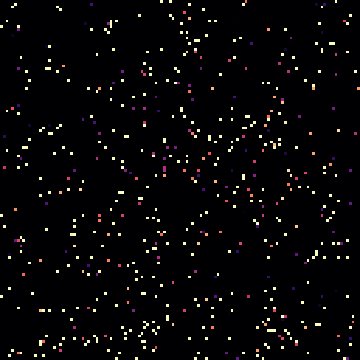
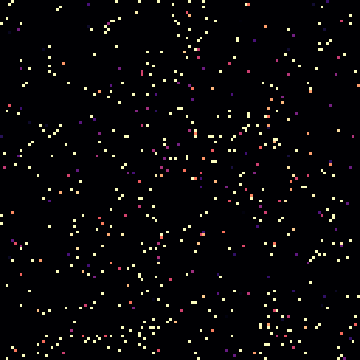
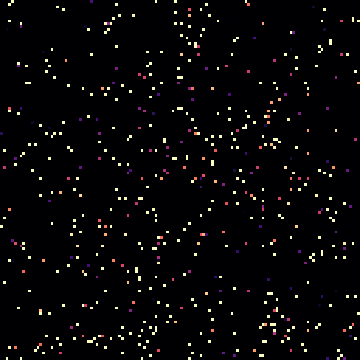
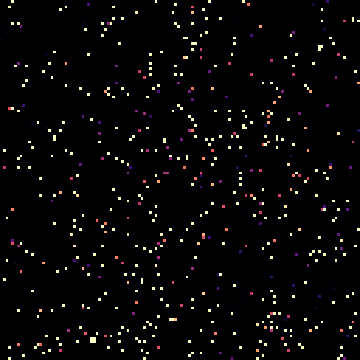
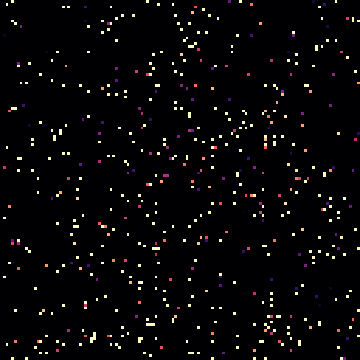
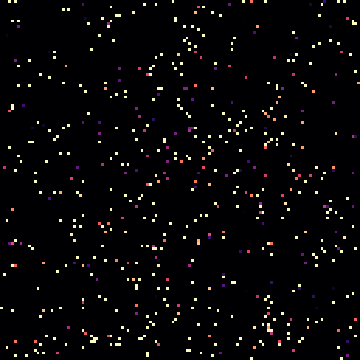
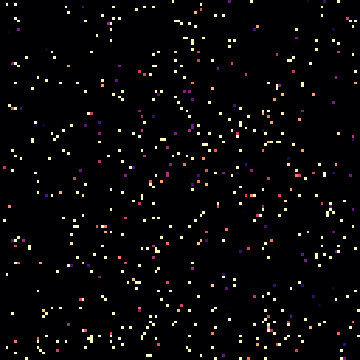
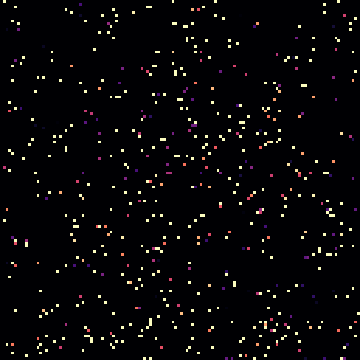
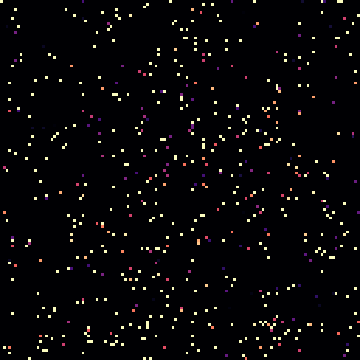
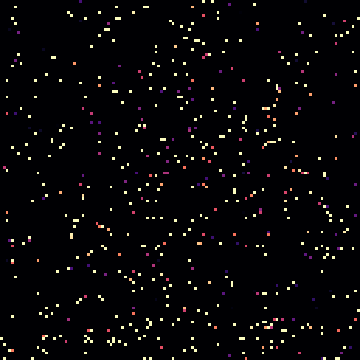
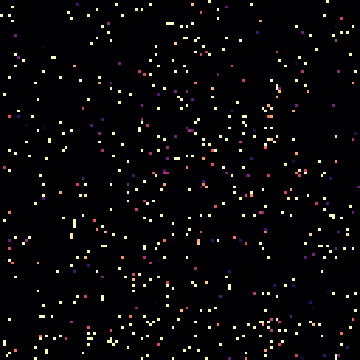
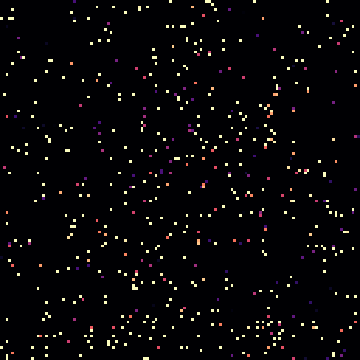
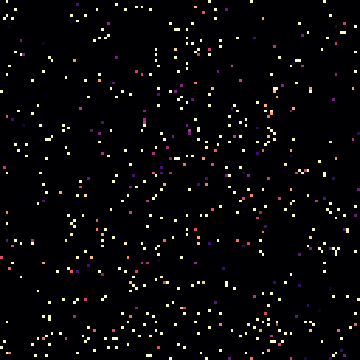
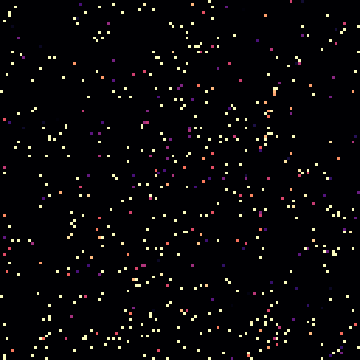
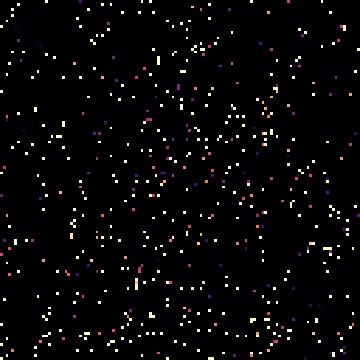
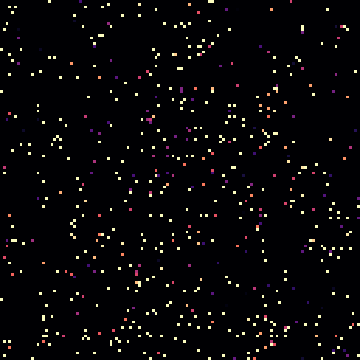
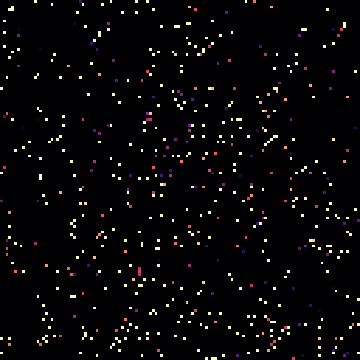
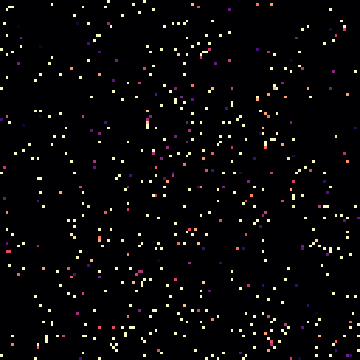
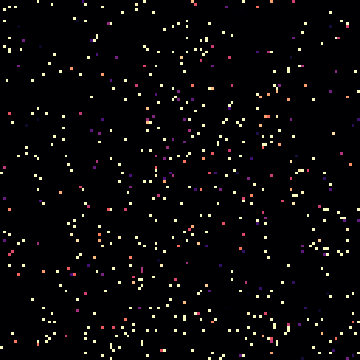
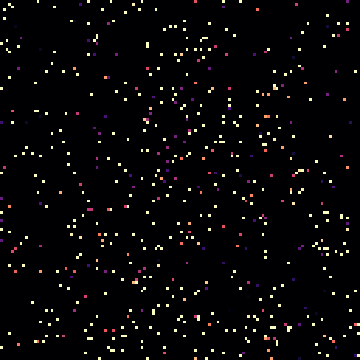
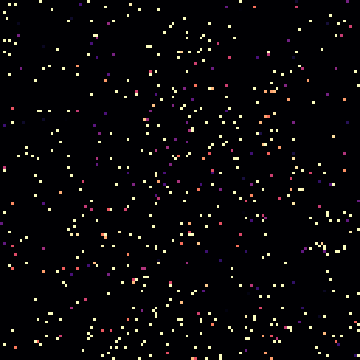
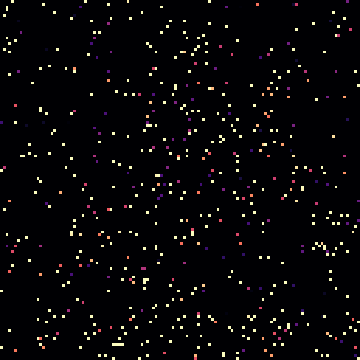
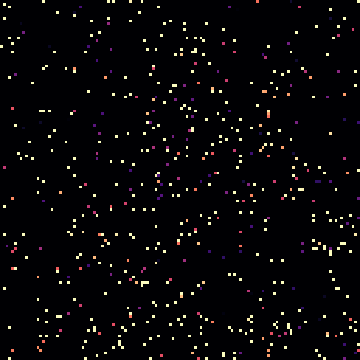
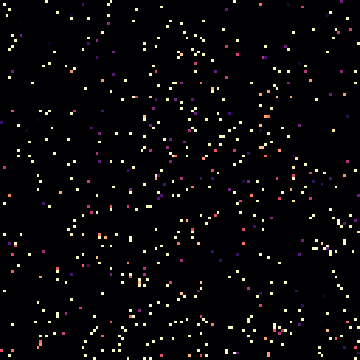
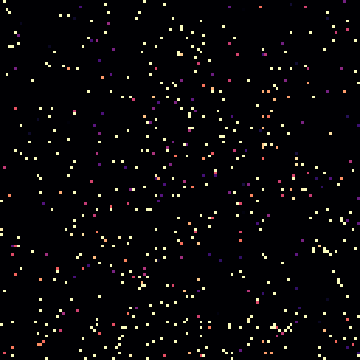
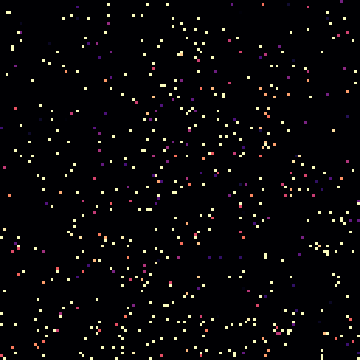
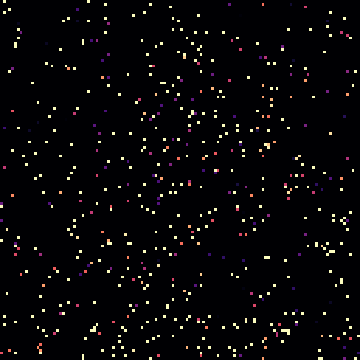
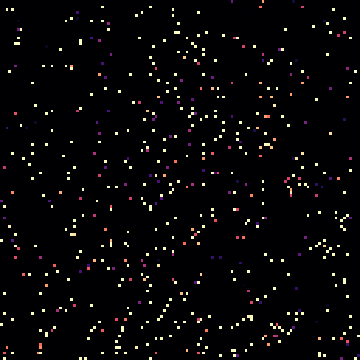
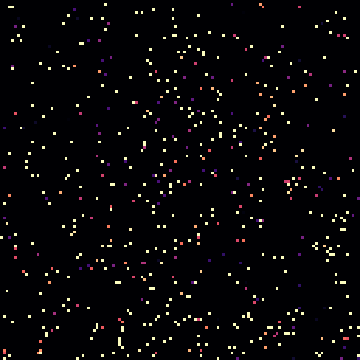
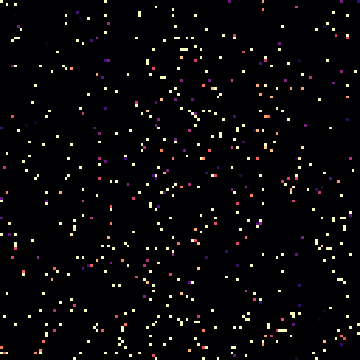
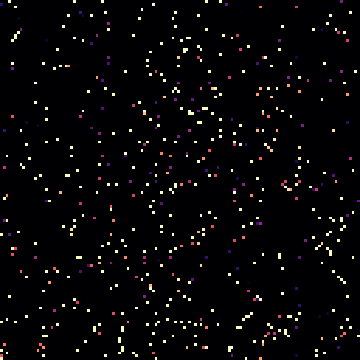
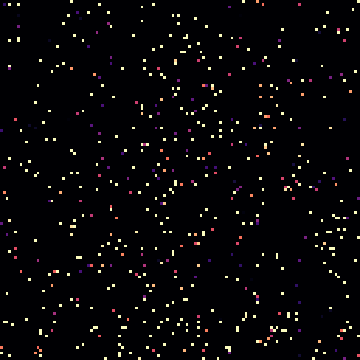
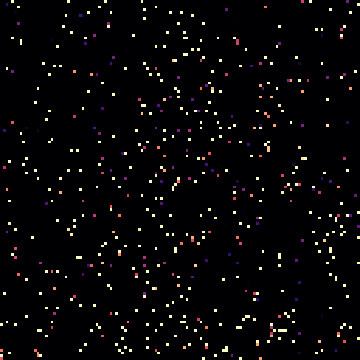
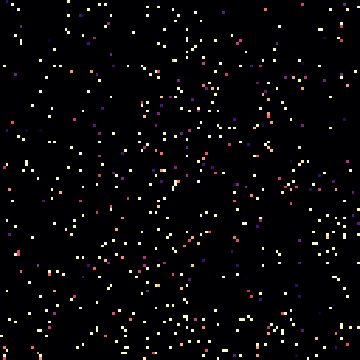
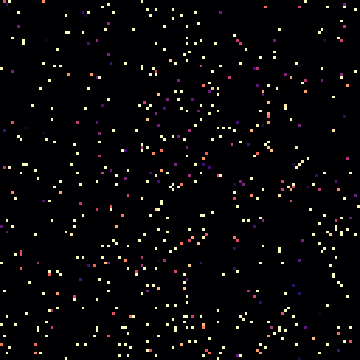
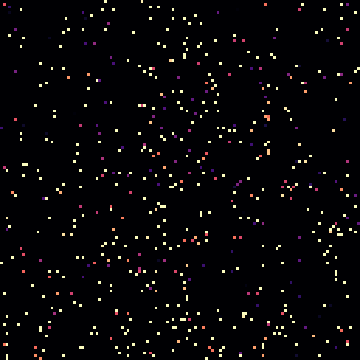
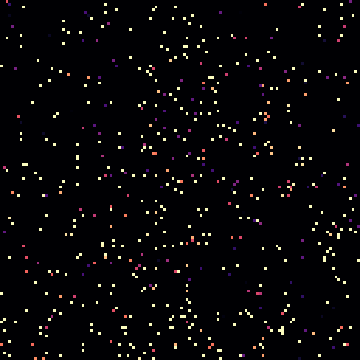
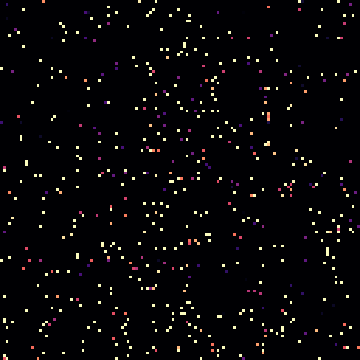
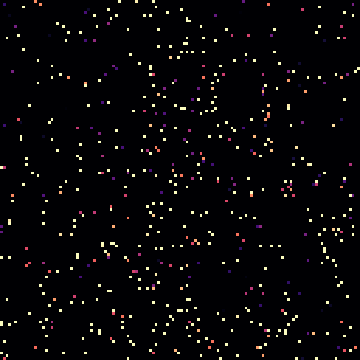
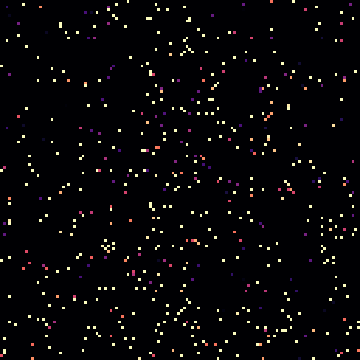
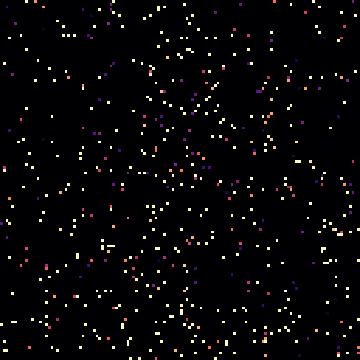
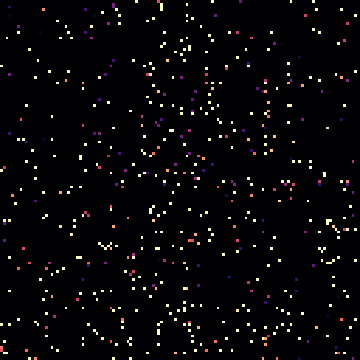
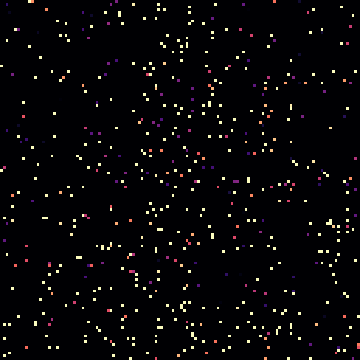
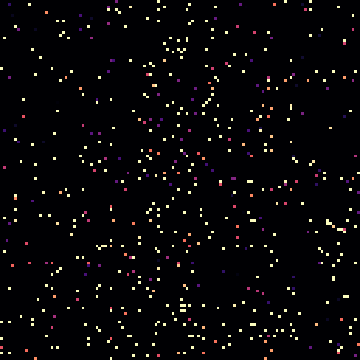
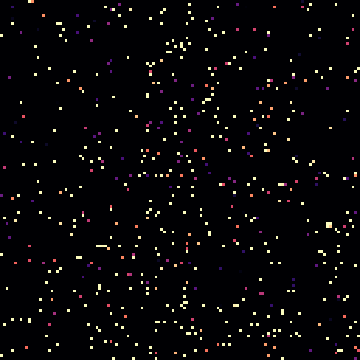
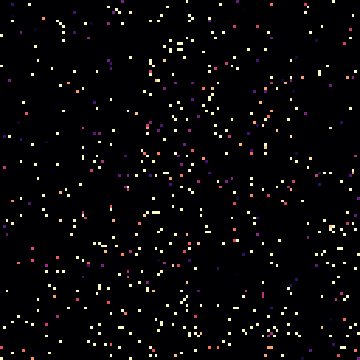
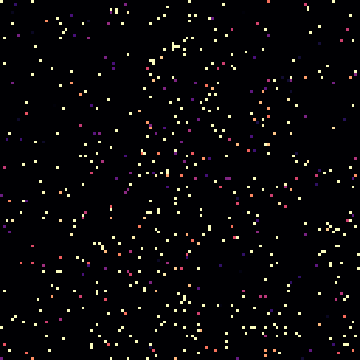
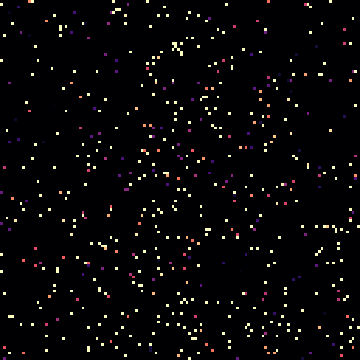
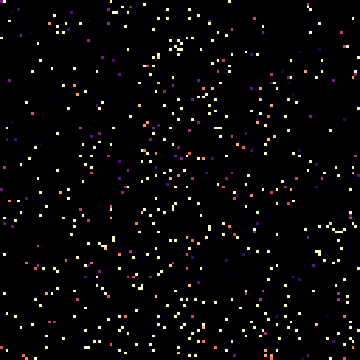
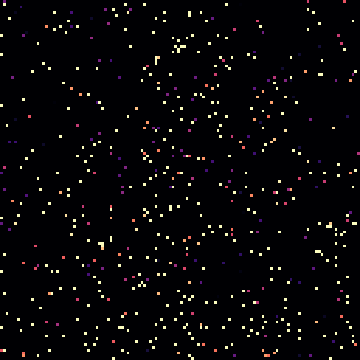
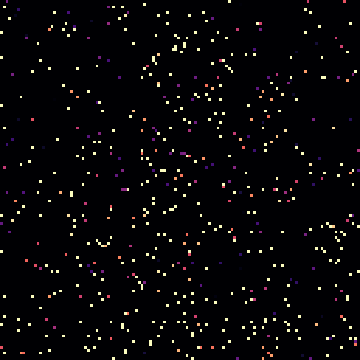
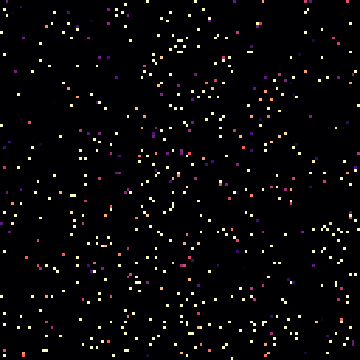
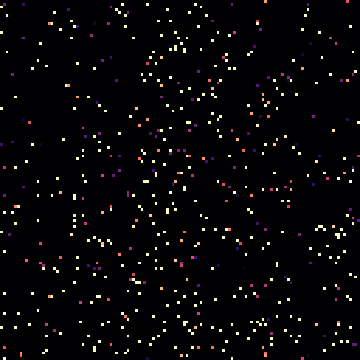
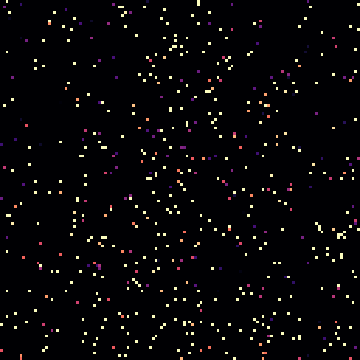
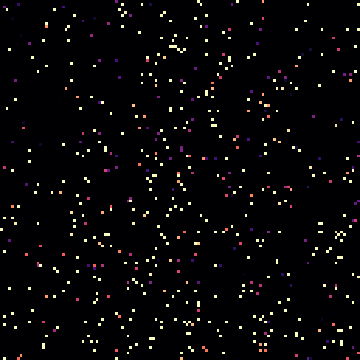
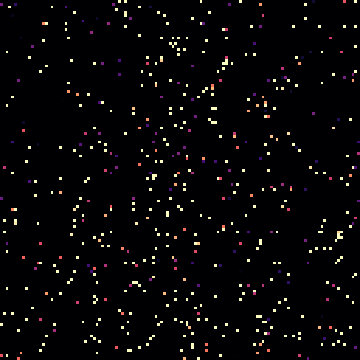
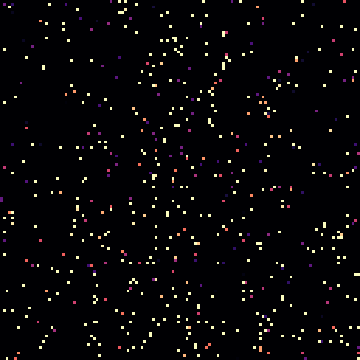
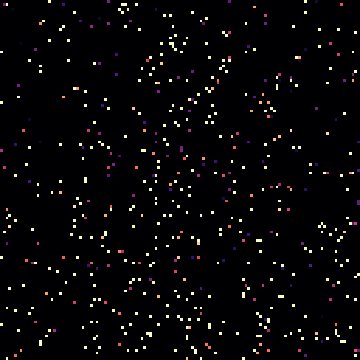
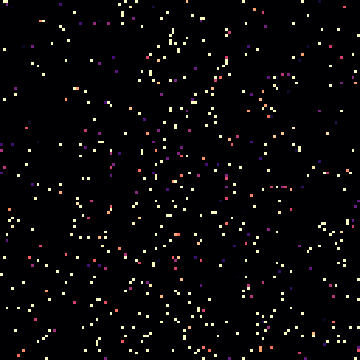
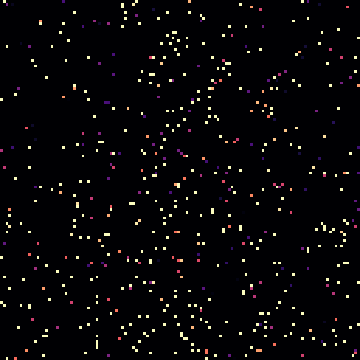
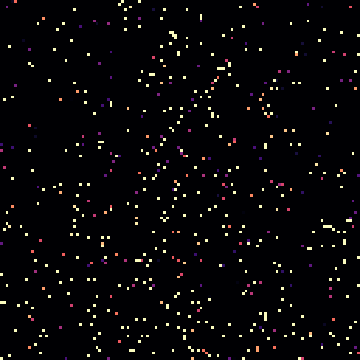
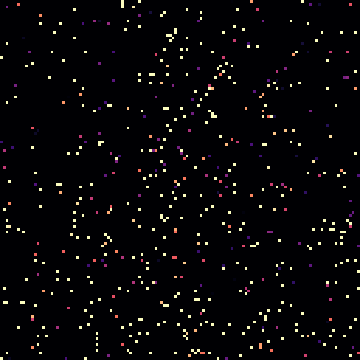
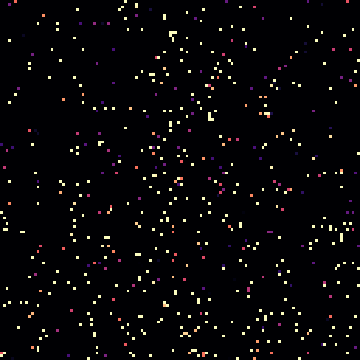
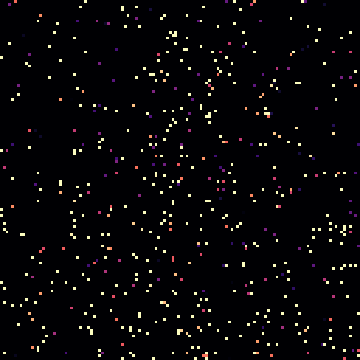
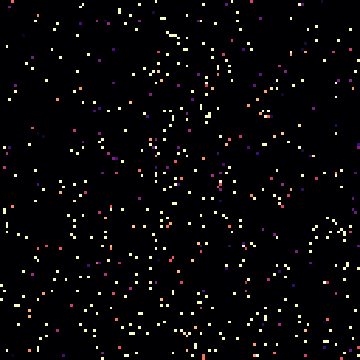

In [44]:
gr2

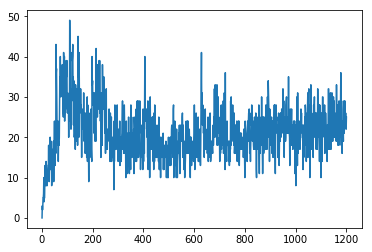

In [45]:
# Growth
plt.plot(t2[:,0],t2[:,1])

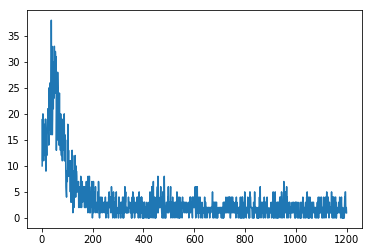

In [46]:
# Birth
plt.plot(t2[:,0],t2[:,2])

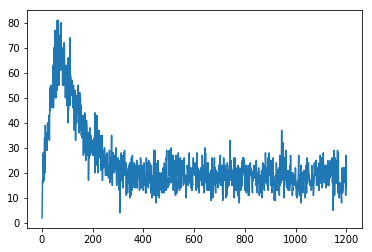

In [47]:
# Injuries
plt.plot(t2[:,0],t2[:,3])

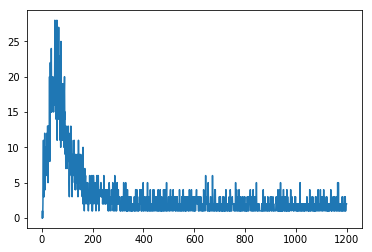

In [48]:
# Deaths
plt.plot(t2[:,0],t2[:,4])

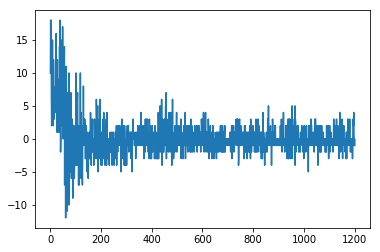

In [49]:
# Births-Deaths
plt.plot(t2[:,0],t2[:,2]-t2[:,4])

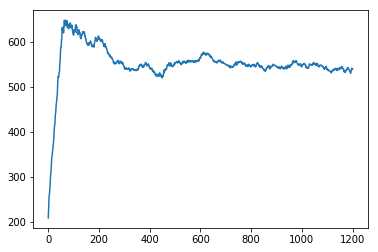

In [50]:
# Population
plt.plot(t2[:,0],t2[:,5])

In [51]:
# Summary
t2

array([[   1,    0,   10,    2,    0,  208],
       [   2,    3,   19,   10,    1,  226],
       [   3,    2,   11,   17,    0,  237],
       ...,
       [1198,   25,    1,   27,    2,  540],
       [1199,   22,    2,   14,    2,  540],
       [1200,   25,    1,   17,    2,  539]])

In [52]:
nx.info(g2)

'Name: \nType: Graph\nNumber of nodes: 4310\nNumber of edges: 4310\nAverage degree:   2.0000'

In [53]:
#import dill
#dill.dump_session('notebook_env.db')

In [54]:
#import dill
#dill.load_session('notebook_env.db')

In [124]:
a = (np.transpose(PCA(n_components=3).fit(np.transpose(cw)).components_)+1)/2

In [125]:
np.round(255*(a-np.min(a))/(np.max(a)-np.min(a)))

array([[ 61.,  62.,  67.],
       [ 80.,  74.,  69.],
       [ 63.,  83.,  67.],
       [ 75.,  62.,  60.],
       [ 75.,  77.,  77.],
       [ 94.,  85.,  77.],
       [ 64.,  71.,  76.],
       [ 76.,  78.,  61.],
       [ 72.,  82.,  68.],
       [ 74.,  67.,  64.],
       [ 69.,  73.,  81.],
       [ 73.,  87.,  72.],
       [  2., 223.,  48.],
       [ 82.,  74.,  63.],
       [ 92.,  67.,  59.],
       [ 66.,  51.,  58.],
       [ 73.,  91.,  55.],
       [ 60.,  68.,  90.],
       [ 72.,  66.,  57.],
       [ 71.,  72.,  74.],
       [ 77.,  73.,  75.],
       [ 75.,  62.,  60.],
       [ 86., 133.,  81.],
       [ 69.,  78.,  59.],
       [ 77.,  78.,  58.],
       [ 76.,  78.,  61.],
       [ 76.,  85.,  80.],
       [ 57.,  47.,  89.],
       [ 59.,  64.,  86.],
       [ 83., 114.,  66.],
       [ 92.,  77.,  90.],
       [ 60.,  82.,  83.],
       [ 86.,  73.,  67.],
       [ 82.,  60.,  85.],
       [ 62.,  86.,  86.],
       [ 68.,  47.,  60.],
       [ 72.,  76.,  60.],
 

In [135]:
np.mean(np.var(cw,axis = 0))

0.32782407189102214